In [1]:
import os
import numpy as np
from scipy.stats import kendalltau
from itertools import product
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import preprocess_documents
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.preprocessing import normalize
from geomloss import SamplesLoss
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

from config import *
from helpers import *
from visualization import *
from redundancy import *
from relevance import *

torch.manual_seed(42)
dtype = torch.float
device = torch.device('cuda:0')
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

In [2]:
DATASET_ID_TRAIN = DATASET_IDS[0]
DATASET_ID_TEST = DATASET_IDS[1]
TOPIC_ID_TRAIN = TOPIC_IDS[DATASET_ID_TRAIN][0]
TOPIC_ID_TEST = TOPIC_IDS[DATASET_ID_TEST][0]
BASE_DATA_DIR = f'/scratch/korunosk/data'
PLOTS_DIR = 'plots'
MODELS_DIR = 'models'
EMBEDDINGS_DIR = os.path.join(BASE_DATA_DIR, 'BERT_sent')

Try out:
- Play with the parameters: D_out, blur in SampleLoss, learning rate
- Normalize embeddings
- Batching
- sigmoid(10 * x)

Validate using:
- correlation

In [3]:
def make_tuples_data_for_regression(dataset_id: str, topic_id: str) -> list:
    ''' Generates data for regression in the form:
    
    (topic_id: str, i: int), where:
    
    topic_id - the topic ID
    i        - index of the summary
    y        - pyramid score

    :param dataset_id: Dataset ID to fetch data from
    :param topic_id:   Topic ID
    :return:           Tuples data
    '''
    topic = load_data(os.path.join(EMBEDDINGS_DIR, dataset_id), topic_id, encoded=True)
    _, _, _, pyr_scores, _ = extract(topic)
    
    data = []
    n = len(pyr_scores)
    for i in range(n):
        y = pyr_scores[i]
        data.append((topic_id, i, y))
    
    return data

def make_tuples_data_for_classification(dataset_id: str, topic_id: str) -> list:
    ''' Generates data for classification in the form:
    
    (topic_id: str, i1: int, i2: int, y: int), where:
    
    topic_id - the topic ID
    i1       - index of the first summary
    i2       - index of the second summary
    y        - {0,1} indicator variable, whether pyramid[i1] > pyramid[i2]

    :param dataset_id: Dataset ID to fetch data from
    :param topic_id:   Topic ID
    :return:           Tuples data
    '''
    topic = load_data(os.path.join(EMBEDDINGS_DIR, dataset_id), topic_id, encoded=True)
    _, _, _, pyr_scores, _ = extract(topic)
    
    data = []
    n = len(pyr_scores)
    for i1, i2 in product(range(n), range(n)):
        if i1 == i2:
            continue
        y = int(pyr_scores[i1] > pyr_scores[i2])
        data.append((topic_id, i1, i2, y))
    
    return data

In [4]:
class TACDataset(Dataset):
    def _load_topic(self, topic_id):
        if self.topic_id == topic_id:
            return
        
        self.topic_id = topic_id
        
        if self.encoded:
            topic = load_data(os.path.join(EMBEDDINGS_DIR, self.dataset_id), topic_id, encoded=True)
        else:
            topic = load_data(BASE_DATA_DIR, self.dataset_id, encoded=False)[self.topic_id]
            
        (self.documents,
         self.summaries,
         self.indices,
         self.pyr_scores,
         self.summary_ids) = extract(topic)
        
        print(f'Loaded data from topic {topic_id}')
    
    def _load_item(self, topic_id, item):
        self.topic_id = topic_id
        directory = os.path.join(EMBEDDINGS_DIR, self.dataset_id, self.topic_id, item)
        return np.load(directory)

    def __init__(self, dataset_id, data, encoded):
        self.dataset_id = dataset_id
        self.data = data
        self.encoded = encoded
        self.topic_id = ''        
        
    def __len__(self):
        return len(self.data)


class TACDatasetRegression(TACDataset):
    def __init__(self, dataset_id, data):
        super().__init__(dataset_id, data, encoded=True)
        # self._load_topic(self.data[0][0])
        np.random.shuffle(data)
        
#     def __getitem__(self, idx):
#         ''' Loads data sequentially. '''
#         self._load_topic(self.data[idx][0])
        
#         i = self.indices[int(self.data[idx][1])]
#         x = (self.documents,
#              self.summaries[i[0]:i[1]])
#         y = float(self.data[idx][2])
        
#         return (x, y)

    def __getitem__(self, idx):
        ''' Loads data randomly. '''
        topic_id = self.data[idx][0]
        print(topic_id)
        
        i = int(self.data[idx][1])
        x = (self._load_item(topic_id, 'document_embs.npy'),
             self._load_item(topic_id, f'summary_{i}_embs.npy'))
        y = float(self.data[idx][2])
        
        return (x, y)


class TACDatasetClassification(TACDataset):
    def __init__(self, dataset_id, data):
        super().__init__(dataset_id, data, encoded=True)
        # self._load_topic(self.data[0][0])
        np.random.shuffle(data)
        
#     def __getitem__(self, idx):
#         ''' Loads data sequentially. '''
#         self._load_topic(self.data[idx][0])
        
#         i1 = self.indices[int(self.data[idx][1])]
#         i2 = self.indices[int(self.data[idx][2])]
#         x = (self.documents,
#              self.summaries[i1[0]:i1[1]],
#              self.summaries[i2[0]:i2[1]])
#         y = float(self.data[idx][3])
        
#         return (x, y)
    
    def __getitem__(self, idx):
        ''' Loads data randomly. '''
        topic_id = self.data[idx][0]
        print(topic_id)
        
        i1 = int(self.data[idx][1])
        i2 = int(self.data[idx][2])
        x = (self._load_item(topic_id, 'document_embs.npy'),
             self._load_item(topic_id, f'summary_{i1}_embs.npy'),
             self._load_item(topic_id, f'summary_{i2}_embs.npy'))
        y = float(self.data[idx][3])
        
        return (x, y)


class TACDatasetClassificationScoring(TACDataset):
    def _load_topic(self, topic_id):
        super()._load_topic(topic_id)
        self.dct = Dictionary(preprocess_documents(self.documents + self.summaries))

    def __init__(self, dataset_id, data):
        super().__init__(dataset_id, data, encoded=False)
        # self._load_topic(self.data[0][0])
        np.random.shuffle(data)
    
    def doc2idx(self, document):
        # filter-out sentences that do not have words in the dictionary
        return list(filter(len, map(self.dct.doc2idx, preprocess_documents(document))))
    
    def num_nnz(self):
        return self.dct.num_nnz
    
#     def __getitem__(self, idx):
#         ''' Loads data sequentially. '''
#         self._load_topic(self.data[idx][0])
        
#         i1 = self.indices[int(self.data[idx][1])]
#         i2 = self.indices[int(self.data[idx][2])]
#         x = (self.doc2idx(self.documents),
#              self.doc2idx(self.summaries[i1[0]:i1[1]]),
#              self.doc2idx(self.summaries[i2[0]:i2[1]]))
#         y = float(self.data[idx][3])
        
#         return (x, y)

    def __getitem__(self, idx):
        ''' Loads data randomly. '''
        topic_id = self.data[idx][0]
        print(topic_id)
        
        i1 = int(self.data[idx][1])
        i2 = int(self.data[idx][2])
        x = (self.doc2idx(self._load_item(topic_id, 'document.npy')),
             self.doc2idx(self._load_item(topic_id, f'summary_{i1}.npy')),
             self.doc2idx(self._load_item(topic_id, f'summary_{i2}.npy')))
        y = float(self.data[idx][3])
        
        return (x, y)

In [5]:
class Normalize():
    def __call__(self, sample):
        x, y = sample
        return (tuple(normalize(x_i, axis=1) for x_i in x), y)


class ToTensor():
    def __call__(self, sample):
        x, y = sample
        return (tuple(torch.tensor(x_i) for x_i in x), torch.tensor(y))

### Make data

In [10]:
def stratified_sampling(data):
    train, test = train_test_split(data, test_size=0.3, random_state=42, stratify=data[:,0])
    # Sort the data by topic_id since we will load each topic separatelly
    train = train[train[:,0].argsort(kind='mergesort')]
    test = test[test[:,0].argsort(kind='mergesort')]
    return train, test

def leave_n_out(topics, data):
    n = int(0.3 * len(topics))
    train_topics = topics[:-n]
    test_topics = topics[-n:]
    train = data[np.isin(data[:,0], train_topics)]
    test = data[np.isin(data[:,0], test_topics)]
    return train, test

In [11]:
### Train
topic = load_data(BASE_DATA_DIR, DATASET_ID_TRAIN, encoded=False)[TOPIC_ID_TRAIN]
data_train = extract(topic)

topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET_ID_TRAIN), TOPIC_ID_TRAIN, encoded=True)
data_encoded_train = extract(topic)

### Test
topic = load_data(BASE_DATA_DIR, DATASET_ID_TEST, encoded=False)[TOPIC_ID_TEST]
data_test = extract(topic)

topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET_ID_TEST), TOPIC_ID_TEST, encoded=True)
data_encoded_test = extract(topic)

#### For all topics

In [12]:
tuples_data = []
for topic_id in TOPIC_IDS[DATASET_ID_TRAIN]:
    tuples_data.extend(make_tuples_data_for_regression(DATASET_ID_TRAIN, topic_id))
tuples_data = np.array(tuples_data)

tuples_train_regression, tuples_val_regression = leave_n_out(TOPIC_IDS[DATASET_ID_TRAIN], tuples_data)

tuples_train_regression.shape, tuples_val_regression.shape

((2107, 3), (868, 3))

In [13]:
tuples_data = []
for topic_id in TOPIC_IDS[DATASET_ID_TRAIN]:
    tuples_data.extend(make_tuples_data_for_classification(DATASET_ID_TRAIN, topic_id))
tuples_data = np.array(tuples_data)

tuples_train_classification, tuples_val_classification = leave_n_out(TOPIC_IDS[DATASET_ID_TRAIN], tuples_data)

tuples_train_classification.shape, tuples_val_classification.shape

((128466, 4), (52948, 4))

#### For single topic

In [15]:
# tuples_data = make_tuples_data_for_regression(DATASET_ID_TRAIN, TOPIC_ID_TRAIN)
# tuples_data = np.array(tuples_data)

# tuples_train_regression, tuples_val_regression = tuples_data, np.array([])

# tuples_train_regression.shape, tuples_val_regression.shape

In [16]:
# tuples_data = make_tuples_data_for_classification(DATASET_ID_TRAIN, TOPIC_ID_TRAIN)
# tuples_data = np.array(tuples_data)

# tuples_train_classification, tuples_val_classification = tuples_data, np.array([])

# tuples_train_classification.shape, tuples_val_classification.shape

# Learning transformation

In [17]:
# write as config {}
D_in = 768
D_out = 768
p = 2
blur = .05
scaling = .9
learning_rate = 1e-2
batch_size = 100


class TransformSinkhornRegModel(nn.Module):
    def __init__(self, D_in, D_out):
        super(TransformSinkhornRegModel, self).__init__()
        self.M = nn.Parameter(torch.randn(D_in, D_out))
        self.sinkhorn = SamplesLoss(loss='sinkhorn', p=p, blur=blur, scaling=scaling)

    def forward(self, d, s):
        dist = self.sinkhorn(torch.mm(d, self.M), torch.mm(s, self.M))
        return torch.exp(-dist)

D0804
D0802
D0802
D0831
D0802
D0820
D0829
D0829
D0818
D0843
D0815
D0831
D0807
D0825
D0805
D0815
D0829
D0807
D0813
D0845
D0819
D0813
D0802
D0820
D0825
D0843
D0802
D0819
D0834
D0807
D0831
D0845
D0825
D0847
D0812
D0822
D0802
D0804
D0813
D0804
D0845
D0820
D0843
D0844
D0810
D0812
D0813
D0815
D0847
D0839
D0807
D0826
D0815
D0817
D0824
D0843
D0809
D0841
D0823
D0823
D0824
D0812
D0817
D0822
D0807
D0819
D0831
D0826
D0810
D0824
D0834
D0813
D0807
D0804
D0825
D0807
D0835
D0839
D0823
D0835
D0841
D0817
D0827
D0814
D0813
D0828
D0839
D0839
D0846
D0804
D0817
D0819
D0814
D0835
D0809
D0821
D0817
D0805
D0818
D0823
0.0231
0.0000
0.0876
0.0156
0.2314
0.4928
0.0008
0.0818
0.1310
0.1945
0.0724
0.0000
0.1018
0.0666
0.0048
0.1225
0.0130
0.0548
0.1069
0.0835
0.2820
0.0000
0.1971
0.2088
0.0166
0.0864
0.1971
0.1069
0.4900
0.1018
0.0088
0.1170
0.0259
0.0266
0.0243
0.0289
0.1109
0.0571
0.0083
0.0169
0.1170
0.3102
0.1050
0.0458
0.0064
0.0000
0.2970
0.0237
0.1347
0.0702
0.6400
0.0190
0.0724
0.2746
0.0190
0.0552
0.1673
0

0.0292
0.1069
0.0369
0.0376
0.0149
0.2581
0.3807
0.0936
0.0174
0.0818
0.2756
0.0000
0.0581
0.3600
0.0818
0.2153
0.0416
0.0000
0.0094
0.1945
0.0428
0.0204
0.1109
0.0480
0.5461
0.1840
0.4449
0.1109
0.8855
0.0745
0.3192
0.3058
0.0493
0.1576
0.0858
0.1875
0.0480
0.0190
0.0119
0.2401
0.1971
0.0339
0.6053
0.1697
0.0156
0.1936
0.0117
0.0625
0.3136
0.0289
0.0048
0.1190
0.0713
0.0279
0.1656
0.7744
1.0000
0.0066
0.0729
0.0048
0.1459
0.2927
0.0745
0.1815
0.1600
0.1722
0.0400
0.0625
0.0581
0.2820
0.2314
0.0961
0.0548
0.0000
0.1505
0.0204
0.1640
0.3516
0.1011
0.0096
0.1109
0.0096
0.1232
0.0114
0.2181
0.0353
0.0210
0.0973
0.0369
0.0094
0.0384
0.2333
0.0650
0.1190
0.1109
0.0000
0.0818
0.0400
0.0038
0.0000
D0843
D0825
D0844
D0815
D0810
D0809
D0831
D0804
D0807
D0824
D0817
D0820
D0819
D0845
D0821
D0820
D0835
D0835
D0805
D0804
D0845
D0825
D0813
D0820
D0818
D0843
D0826
D0812
D0823
D0812
D0809
D0834
D0814
D0821
D0826
D0812
D0843
D0807
D0826
D0824
D0825
D0819
D0821
D0829
D0827
D0827
D0841
D0826
D0828
D0845


0.0169
0.1109
0.4449
0.0692
0.2642
0.0967
0.0007
0.2642
0.0433
0.1490
0.1246
0.1109
0.0166
0.0581
0.0000
0.0149
0.1866
0.1772
0.0289
0.0106
0.0117
0.1600
0.1866
0.0014
0.0000
0.0870
0.5746
0.0713
0.0132
0.1190
0.0056
0.1163
0.2401
0.2218
0.0702
0.0331
0.0467
0.3047
0.1325
0.2070
0.0762
0.0156
0.2621
D0834
D0847
D0827
D0828
D0814
D0820
D0822
D0817
D0822
D0817
D0834
D0821
D0813
D0818
D0813
D0818
D0846
D0841
D0835
D0823
D0819
D0846
D0829
D0805
D0819
D0804
D0831
D0807
D0813
D0824
D0827
D0841
D0807
D0820
D0835
D0824
D0823
D0820
D0831
D0820
D0847
D0807
D0846
D0812
D0843
D0835
D0818
D0845
D0809
D0848
D0843
D0846
D0845
D0804
D0845
D0820
D0847
D0818
D0826
D0843
D0817
D0812
D0813
D0820
D0834
D0847
D0825
D0824
D0827
D0825
D0834
D0817
D0820
D0804
D0810
D0804
D0817
D0807
D0845
D0825
D0826
D0829
D0805
D0818
D0805
D0824
D0829
D0835
D0825
D0822
D0828
D0841
D0843
D0828
D0827
D0809
D0839
D0831
D0819
D0826
0.1875
0.0502
0.0713
0.0331
0.2500
0.2500
0.2228
0.2694
0.0912
0.0000
0.0400
0.0269
0.0557
0.1576
0

D0809
0.5285
0.1971
0.8798
0.0024
0.0144
0.2500
0.0818
0.0059
0.0000
0.0493
0.1274
0.0818
0.1490
0.2314
0.1176
0.0204
0.0702
0.0059
0.0331
0.1246
0.1789
0.1840
0.2218
0.0912
0.0493
0.0010
0.1714
0.0166
0.0038
0.1936
0.1436
0.0000
0.1840
0.1600
0.0762
0.0014
0.1340
0.4045
0.2333
0.0166
0.1011
0.0365
0.1050
0.1962
0.0876
0.0552
0.1544
0.0660
0.2200
0.0702
0.0149
0.2256
0.0864
0.2500
0.0357
0.1347
0.4570
0.1568
0.0986
0.0576
0.0237
0.1544
0.0353
0.1069
0.1246
0.0296
0.0088
0.0745
0.3733
0.2153
0.0818
0.0042
0.1936
0.0581
0.1310
0.0292
0.0671
0.1190
0.2247
0.0000
0.0190
0.0534
0.0062
0.1697
0.0114
0.3684
0.0713
0.0552
0.1076
0.0038
0.2107
0.0190
0.0900
0.0119
0.1369
0.2190
0.0045
0.0400
0.0000
0.0420
D0826
D0828
D0841
D0802
D0844
D0818
D0831
D0845
D0839
D0822
D0839
D0802
D0824
D0844
D0807
D0817
D0844
D0812
D0847
D0828
D0804
D0820
D0809
D0846
D0815
D0813
D0829
D0817
D0841
D0839
D0844
D0820
D0824
D0819
D0802
D0845
D0809
D0813
D0827
D0844
D0822
D0823
D0823
D0820
D0835
D0846
D0821
D0823
D0826


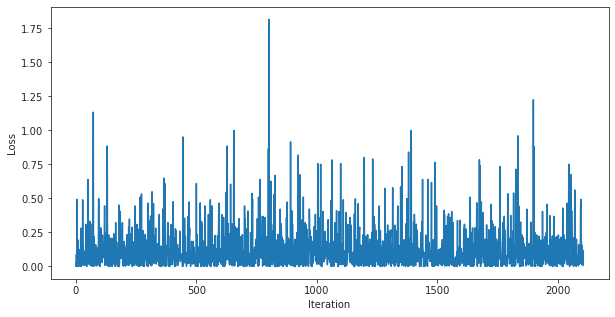

In [18]:
# maybe generalize the training procedure

transform = transforms.Compose([Normalize(), ToTensor()])
dataset = TACDatasetRegression(DATASET_ID_TRAIN, tuples_train_regression)
data_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=lambda x: x)

transform_sinkhorn_reg_model = TransformSinkhornRegModel(D_in, D_out)

criterion = nn.MSELoss()
optimizer = optim.SGD(transform_sinkhorn_reg_model.parameters(), lr=learning_rate)

loss = []

for batch in data_loader:
    for sample in batch:
        (d, s), y = transform(sample)

        L = criterion(transform_sinkhorn_reg_model(d, s), y)

        loss.append(L.item())
        print(f'{loss[-1]:.4f}')

        optimizer.zero_grad()

        L.backward()

        optimizer.step()

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
plot_loss(ax, loss)
plt.show()

In [19]:
M = list(transform_sinkhorn_reg_model.parameters())[0].data.cpu().numpy()
np.save(os.path.join(MODELS_DIR, 'transform_sinkhorn_reg_model.npy'), M)

In [20]:
D_in = 768
D_out = 768
p = 2
blur = .05
scaling = .9
scaling_factor = 1
learning_rate = 1e-2
batch_size = 100


class TransformSinkhornPRModel(nn.Module):
    def __init__(self, D_in, D_out):
        super(TransformSinkhornPRModel, self).__init__()
        self.M = nn.Parameter(torch.randn(D_in, D_out))
        self.sinkhorn = SamplesLoss(loss='sinkhorn', p=p, blur=blur, scaling=scaling)
        self.sigm = nn.Sigmoid()

    def forward(self, d, s1, s2):
        dist1 = self.sinkhorn(torch.mm(d, self.M), torch.mm(s1, self.M))
        dist2 = self.sinkhorn(torch.mm(d, self.M), torch.mm(s2, self.M))
        return self.sigm(scaling_factor * (dist2 - dist1))

D0802
D0831
D0820
D0822
D0839
D0812
D0835
D0835
D0810
D0822
D0802
D0821
D0829
D0825
D0805
D0835
D0812
D0829
D0815
D0812
D0841
D0835
D0810
D0844
D0835
D0817
D0809
D0809
D0814
D0844
D0804
D0848
D0841
D0818
D0813
D0829
D0812
D0814
D0844
D0828
D0823
D0807
D0826
D0819
D0823
D0819
D0812
D0804
D0805
D0820
D0814
D0828
D0844
D0827
D0845
D0824
D0824
D0802
D0831
D0817
D0826
D0812
D0819
D0802
D0844
D0844
D0802
D0804
D0827
D0820
D0810
D0834
D0821
D0844
D0804
D0839
D0807
D0804
D0814
D0821
D0819
D0819
D0820
D0804
D0846
D0843
D0812
D0828
D0824
D0844
D0848
D0810
D0805
D0807
D0846
D0807
D0847
D0812
D0809
D0820
786.7110
D0812
D0804
D0804
D0845
D0823
D0845
D0822
D0802
D0823
D0848
D0807
D0812
D0812
D0818
D0809
D0822
D0846
D0823
D0805
D0815
D0839
D0822
D0822
D0810
D0828
D0831
D0827
D0835
D0844
D0834
D0827
D0845
D0814
D0834
D0845
D0820
D0823
D0804
D0844
D0841
D0835
D0810
D0813
D0810
D0829
D0802
D0828
D0834
D0846
D0848
D0847
D0814
D0810
D0813
D0809
D0821
D0835
D0843
D0826
D0831
D0807
D0809
D0848
D0815
D0809
D

320.3938
D0810
D0846
D0818
D0823
D0804
D0804
D0820
D0812
D0847
D0802
D0834
D0814
D0824
D0819
D0824
D0820
D0839
D0829
D0814
D0846
D0831
D0812
D0814
D0820
D0825
D0843
D0844
D0810
D0804
D0846
D0847
D0846
D0829
D0802
D0807
D0818
D0848
D0810
D0831
D0805
D0822
D0829
D0819
D0812
D0828
D0845
D0847
D0848
D0845
D0843
D0822
D0841
D0824
D0819
D0813
D0839
D0841
D0826
D0835
D0812
D0831
D0813
D0843
D0802
D0834
D0814
D0818
D0823
D0835
D0835
D0845
D0846
D0843
D0835
D0826
D0812
D0815
D0809
D0831
D0825
D0845
D0820
D0805
D0829
D0845
D0844
D0812
D0831
D0845
D0813
D0829
D0821
D0807
D0841
D0809
D0810
D0848
D0813
D0845
D0821
337.9997
D0846
D0809
D0822
D0825
D0835
D0802
D0824
D0824
D0845
D0824
D0818
D0814
D0805
D0843
D0846
D0834
D0813
D0843
D0812
D0809
D0805
D0846
D0835
D0809
D0815
D0835
D0835
D0822
D0804
D0843
D0828
D0839
D0841
D0809
D0826
D0807
D0813
D0828
D0845
D0804
D0829
D0823
D0841
D0829
D0827
D0817
D0807
D0804
D0824
D0817
D0827
D0810
D0807
D0841
D0815
D0823
D0839
D0827
D0813
D0847
D0813
D0805
D0812
D082

196.9192
D0813
D0817
D0845
D0843
D0843
D0848
D0825
D0844
D0835
D0818
D0835
D0846
D0845
D0814
D0819
D0820
D0818
D0824
D0843
D0822
D0845
D0814
D0848
D0813
D0824
D0834
D0845
D0820
D0809
D0843
D0821
D0843
D0809
D0813
D0841
D0823
D0818
D0829
D0841
D0810
D0822
D0829
D0844
D0802
D0835
D0845
D0822
D0809
D0834
D0821
D0805
D0818
D0835
D0809
D0822
D0809
D0802
D0843
D0804
D0823
D0817
D0845
D0841
D0814
D0822
D0810
D0805
D0813
D0835
D0844
D0834
D0841
D0809
D0845
D0847
D0805
D0809
D0846
D0844
D0823
D0846
D0805
D0809
D0812
D0825
D0825
D0821
D0848
D0846
D0835
D0814
D0810
D0805
D0804
D0828
D0843
D0802
D0834
D0817
D0820
147.7853
D0818
D0844
D0822
D0828
D0815
D0802
D0820
D0818
D0829
D0844
D0826
D0835
D0834
D0845
D0826
D0847
D0818
D0815
D0819
D0829
D0805
D0824
D0827
D0839
D0839
D0848
D0818
D0847
D0843
D0826
D0802
D0824
D0810
D0821
D0812
D0824
D0848
D0814
D0835
D0847
D0847
D0805
D0823
D0809
D0813
D0835
D0846
D0841
D0822
D0819
D0813
D0817
D0813
D0825
D0821
D0807
D0826
D0846
D0802
D0831
D0822
D0831
D0841
D081

D0848
D0812
D0828
D0845
D0831
D0812
D0809
D0847
D0813
D0823
146.2786
D0821
D0809
D0839
D0848
D0822
D0802
D0820
D0812
D0839
D0813
D0828
D0825
D0822
D0812
D0822
D0834
D0823
D0804
D0846
D0812
D0831
D0839
D0829
D0822
D0804
D0834
D0846
D0825
D0821
D0848
D0809
D0827
D0822
D0823
D0817
D0810
D0834
D0848
D0818
D0824
D0839
D0810
D0843
D0823
D0804
D0844
D0810
D0826
D0813
D0809
D0818
D0845
D0843
D0818
D0843
D0813
D0812
D0844
D0839
D0831
D0810
D0841
D0847
D0815
D0827
D0817
D0809
D0804
D0824
D0841
D0819
D0829
D0809
D0825
D0844
D0817
D0805
D0845
D0821
D0814
D0807
D0817
D0847
D0828
D0814
D0805
D0817
D0802
D0847
D0843
D0822
D0825
D0820
D0819
D0809
D0829
D0825
D0821
D0843
D0812
170.9693
D0835
D0817
D0844
D0827
D0844
D0847
D0809
D0810
D0821
D0805
D0809
D0818
D0825
D0841
D0812
D0835
D0825
D0804
D0823
D0843
D0810
D0829
D0831
D0817
D0822
D0844
D0828
D0841
D0843
D0827
D0817
D0825
D0829
D0828
D0839
D0823
D0810
D0820
D0821
D0829
D0845
D0815
D0804
D0834
D0823
D0826
D0818
D0829
D0810
D0802
D0827
D0805
D0841
D080

120.3304
D0818
D0829
D0823
D0828
D0847
D0826
D0845
D0841
D0835
D0821
D0823
D0820
D0812
D0810
D0826
D0825
D0819
D0826
D0825
D0821
D0821
D0844
D0829
D0831
D0848
D0848
D0845
D0820
D0843
D0814
D0810
D0822
D0819
D0846
D0841
D0831
D0802
D0805
D0844
D0822
D0826
D0825
D0847
D0817
D0824
D0823
D0814
D0814
D0825
D0831
D0814
D0831
D0824
D0817
D0843
D0834
D0839
D0835
D0844
D0810
D0827
D0817
D0818
D0839
D0810
D0807
D0829
D0809
D0843
D0825
D0824
D0843
D0815
D0815
D0812
D0848
D0834
D0818
D0822
D0845
D0845
D0809
D0824
D0805
D0835
D0843
D0814
D0815
D0812
D0827
D0809
D0834
D0829
D0822
D0818
D0805
D0846
D0810
D0819
D0846
198.5145
D0812
D0845
D0818
D0802
D0815
D0804
D0835
D0824
D0845
D0834
D0815
D0820
D0831
D0822
D0826
D0831
D0843
D0810
D0814
D0819
D0834
D0805
D0819
D0828
D0820
D0819
D0822
D0841
D0834
D0807
D0817
D0819
D0847
D0814
D0802
D0826
D0834
D0812
D0824
D0821
D0810
D0810
D0810
D0827
D0807
D0805
D0829
D0822
D0807
D0820
D0848
D0817
D0821
D0804
D0825
D0810
D0807
D0823
D0818
D0847
D0807
D0804
D0819
D084

127.0213
D0817
D0828
D0817
D0817
D0818
D0827
D0826
D0812
D0823
D0827
D0802
D0812
D0844
D0834
D0815
D0846
D0822
D0817
D0813
D0831
D0819
D0805
D0824
D0827
D0815
D0802
D0848
D0809
D0820
D0810
D0818
D0810
D0818
D0845
D0823
D0802
D0825
D0820
D0807
D0847
D0809
D0805
D0823
D0822
D0809
D0848
D0802
D0826
D0824
D0815
D0826
D0826
D0834
D0835
D0807
D0810
D0807
D0845
D0818
D0827
D0829
D0827
D0847
D0817
D0841
D0846
D0834
D0831
D0844
D0834
D0845
D0834
D0825
D0827
D0812
D0839
D0804
D0823
D0805
D0825
D0848
D0828
D0825
D0819
D0828
D0818
D0844
D0822
D0812
D0823
D0827
D0802
D0829
D0826
D0827
D0817
D0839
D0829
D0845
D0804
101.8777
D0822
D0831
D0813
D0804
D0823
D0843
D0813
D0844
D0846
D0828
D0827
D0835
D0834
D0847
D0809
D0844
D0815
D0826
D0822
D0827
D0829
D0802
D0826
D0839
D0823
D0827
D0810
D0829
D0820
D0809
D0841
D0818
D0807
D0841
D0823
D0844
D0845
D0847
D0802
D0809
D0804
D0843
D0809
D0815
D0820
D0835
D0848
D0818
D0845
D0843
D0825
D0847
D0825
D0817
D0822
D0807
D0828
D0843
D0807
D0821
D0844
D0828
D0827
D081

153.2615
D0815
D0823
D0839
D0831
D0821
D0810
D0841
D0802
D0843
D0810
D0818
D0821
D0827
D0809
D0810
D0841
D0814
D0826
D0831
D0843
D0813
D0815
D0817
D0848
D0846
D0810
D0809
D0845
D0847
D0807
D0810
D0817
D0835
D0841
D0820
D0809
D0809
D0818
D0802
D0834
D0846
D0817
D0827
D0810
D0834
D0835
D0844
D0828
D0826
D0807
D0822
D0817
D0845
D0835
D0835
D0809
D0823
D0820
D0845
D0807
D0810
D0834
D0839
D0843
D0843
D0839
D0823
D0809
D0835
D0846
D0828
D0843
D0818
D0848
D0841
D0802
D0827
D0819
D0824
D0825
D0847
D0809
D0813
D0844
D0824
D0809
D0809
D0822
D0809
D0845
D0829
D0844
D0812
D0812
D0826
D0812
D0819
D0814
D0845
D0804
152.6866
D0844
D0821
D0804
D0829
D0848
D0848
D0817
D0839
D0844
D0820
D0841
D0802
D0826
D0809
D0815
D0828
D0839
D0823
D0827
D0813
D0847
D0810
D0818
D0823
D0845
D0812
D0841
D0834
D0829
D0834
D0819
D0809
D0844
D0823
D0812
D0802
D0831
D0827
D0814
D0826
D0812
D0821
D0848
D0827
D0810
D0824
D0831
D0805
D0810
D0826
D0815
D0825
D0817
D0826
D0822
D0847
D0827
D0826
D0817
D0823
D0807
D0817
D0839
D080

D0834
D0805
D0826
D0817
D0845
D0843
D0817
D0847
D0818
D0828
D0823
D0804
D0819
D0829
D0815
D0809
D0843
D0835
D0810
D0817
D0841
D0823
D0828
D0823
D0823
D0822
D0826
D0843
D0822
D0815
D0813
D0841
D0835
101.1147
D0839
D0805
D0818
D0814
D0839
D0827
D0812
D0818
D0829
D0843
D0807
D0846
D0814
D0834
D0807
D0810
D0805
D0807
D0847
D0839
D0813
D0846
D0848
D0831
D0822
D0809
D0819
D0835
D0844
D0835
D0846
D0843
D0839
D0826
D0817
D0824
D0843
D0826
D0844
D0844
D0812
D0848
D0823
D0845
D0845
D0805
D0802
D0815
D0812
D0848
D0820
D0817
D0827
D0828
D0818
D0847
D0805
D0848
D0825
D0814
D0826
D0824
D0805
D0835
D0839
D0846
D0822
D0809
D0804
D0809
D0815
D0834
D0834
D0826
D0846
D0804
D0848
D0841
D0823
D0825
D0835
D0817
D0810
D0847
D0817
D0826
D0826
D0818
D0828
D0807
D0813
D0847
D0815
D0823
D0834
D0825
D0847
D0829
D0848
D0826
81.5561
D0839
D0805
D0831
D0835
D0813
D0813
D0809
D0815
D0818
D0835
D0820
D0814
D0841
D0809
D0820
D0813
D0829
D0845
D0812
D0834
D0848
D0821
D0819
D0802
D0845
D0844
D0820
D0812
D0818
D0807
D0843

D0831
D0810
D0813
D0831
D0820
D0825
D0847
D0822
D0813
D0825
D0828
66.9000
D0810
D0847
D0845
D0804
D0805
D0831
D0822
D0828
D0848
D0846
D0805
D0815
D0822
D0804
D0826
D0821
D0810
D0812
D0814
D0841
D0828
D0839
D0822
D0847
D0815
D0847
D0821
D0835
D0822
D0841
D0822
D0841
D0843
D0848
D0831
D0813
D0812
D0829
D0843
D0820
D0815
D0827
D0822
D0828
D0821
D0807
D0848
D0834
D0828
D0818
D0802
D0841
D0824
D0839
D0810
D0807
D0847
D0827
D0848
D0805
D0823
D0817
D0829
D0841
D0812
D0817
D0809
D0823
D0848
D0827
D0846
D0825
D0824
D0829
D0835
D0843
D0815
D0819
D0802
D0802
D0817
D0825
D0815
D0848
D0823
D0845
D0812
D0827
D0815
D0821
D0843
D0827
D0827
D0834
D0821
D0824
D0822
D0829
D0821
D0823
98.4305
D0814
D0847
D0805
D0812
D0812
D0844
D0847
D0813
D0817
D0841
D0828
D0802
D0847
D0824
D0809
D0831
D0818
D0844
D0807
D0818
D0824
D0819
D0810
D0839
D0846
D0827
D0820
D0844
D0817
D0843
D0818
D0804
D0807
D0818
D0834
D0818
D0826
D0809
D0821
D0823
D0847
D0807
D0835
D0829
D0846
D0818
D0821
D0825
D0815
D0810
D0839
D0841
D0845


68.0292
D0821
D0834
D0844
D0805
D0807
D0802
D0817
D0809
D0839
D0848
D0817
D0834
D0807
D0813
D0818
D0834
D0827
D0813
D0848
D0847
D0831
D0804
D0813
D0826
D0817
D0821
D0824
D0835
D0834
D0845
D0846
D0805
D0827
D0802
D0810
D0846
D0820
D0807
D0829
D0839
D0822
D0813
D0820
D0829
D0841
D0804
D0847
D0848
D0815
D0829
D0812
D0819
D0805
D0820
D0805
D0817
D0814
D0810
D0848
D0802
D0825
D0825
D0828
D0839
D0804
D0818
D0822
D0841
D0847
D0825
D0848
D0847
D0807
D0817
D0807
D0845
D0819
D0822
D0823
D0823
D0809
D0813
D0820
D0848
D0831
D0809
D0813
D0827
D0829
D0822
D0815
D0831
D0845
D0831
D0847
D0841
D0817
D0812
D0825
D0817
66.4652
D0807
D0821
D0809
D0819
D0827
D0829
D0812
D0822
D0818
D0821
D0835
D0847
D0805
D0819
D0805
D0819
D0822
D0829
D0834
D0831
D0843
D0826
D0827
D0846
D0839
D0848
D0809
D0804
D0843
D0809
D0845
D0804
D0820
D0807
D0807
D0807
D0846
D0824
D0819
D0807
D0805
D0831
D0821
D0822
D0845
D0824
D0843
D0826
D0826
D0818
D0824
D0835
D0815
D0834
D0848
D0821
D0807
D0813
D0829
D0825
D0824
D0848
D0843
D0846


63.8579
D0822
D0828
D0827
D0846
D0827
D0822
D0815
D0845
D0826
D0814
D0841
D0814
D0848
D0824
D0823
D0829
D0810
D0813
D0844
D0826
D0821
D0813
D0848
D0826
D0809
D0823
D0804
D0825
D0845
D0828
D0819
D0834
D0847
D0828
D0843
D0834
D0821
D0827
D0820
D0847
D0810
D0841
D0812
D0834
D0813
D0815
D0835
D0828
D0819
D0805
D0841
D0843
D0822
D0812
D0847
D0828
D0829
D0814
D0846
D0804
D0839
D0828
D0818
D0821
D0819
D0823
D0813
D0820
D0823
D0821
D0834
D0845
D0844
D0827
D0828
D0823
D0822
D0807
D0821
D0819
D0812
D0847
D0819
D0847
D0826
D0804
D0826
D0815
D0829
D0831
D0802
D0810
D0810
D0827
D0834
D0805
D0809
D0843
D0810
D0844
127.2584
D0802
D0831
D0845
D0815
D0812
D0820
D0812
D0815
D0834
D0839
D0825
D0846
D0826
D0802
D0814
D0812
D0835
D0813
D0812
D0843
D0815
D0843
D0817
D0813
D0846
D0823
D0826
D0824
D0823
D0815
D0815
D0822
D0815
D0802
D0815
D0804
D0810
D0829
D0834
D0821
D0829
D0817
D0807
D0807
D0805
D0802
D0813
D0831
D0848
D0809
D0843
D0805
D0828
D0826
D0828
D0824
D0812
D0818
D0826
D0831
D0841
D0819
D0824
D0828

98.6731
D0810
D0825
D0818
D0820
D0814
D0805
D0847
D0805
D0817
D0809
D0805
D0810
D0834
D0824
D0818
D0844
D0824
D0824
D0812
D0821
D0815
D0843
D0829
D0805
D0829
D0817
D0818
D0807
D0819
D0841
D0844
D0810
D0848
D0818
D0826
D0822
D0804
D0844
D0839
D0819
D0802
D0846
D0847
D0825
D0826
D0847
D0809
D0820
D0822
D0844
D0820
D0841
D0804
D0821
D0818
D0814
D0823
D0819
D0845
D0834
D0815
D0819
D0817
D0827
D0834
D0805
D0846
D0825
D0828
D0823
D0839
D0825
D0821
D0823
D0828
D0845
D0823
D0823
D0845
D0844
D0831
D0809
D0812
D0828
D0825
D0810
D0843
D0810
D0826
D0821
D0822
D0810
D0807
D0828
D0824
D0829
D0839
D0847
D0834
D0845
154.9035
D0848
D0823
D0835
D0826
D0823
D0845
D0822
D0807
D0822
D0824
D0846
D0814
D0821
D0828
D0845
D0804
D0847
D0829
D0839
D0805
D0809
D0814
D0822
D0822
D0819
D0828
D0827
D0809
D0809
D0804
D0828
D0819
D0841
D0827
D0835
D0802
D0848
D0815
D0835
D0846
D0802
D0841
D0848
D0828
D0815
D0815
D0819
D0821
D0827
D0819
D0817
D0841
D0807
D0831
D0809
D0812
D0812
D0844
D0817
D0841
D0812
D0843
D0848
D0834

66.6507
D0846
D0822
D0810
D0829
D0847
D0821
D0804
D0846
D0844
D0812
D0823
D0844
D0831
D0802
D0809
D0821
D0824
D0846
D0802
D0828
D0809
D0845
D0810
D0802
D0809
D0815
D0834
D0824
D0839
D0821
D0823
D0804
D0835
D0807
D0827
D0812
D0813
D0815
D0828
D0805
D0810
D0812
D0847
D0813
D0841
D0802
D0847
D0807
D0829
D0810
D0826
D0828
D0805
D0834
D0829
D0807
D0846
D0818
D0834
D0825
D0825
D0834
D0835
D0813
D0809
D0807
D0824
D0844
D0839
D0846
D0831
D0804
D0805
D0817
D0814
D0824
D0829
D0813
D0823
D0813
D0826
D0822
D0807
D0834
D0815
D0814
D0845
D0846
D0829
D0817
D0810
D0812
D0827
D0845
D0823
D0828
D0829
D0826
D0828
D0813
50.6521
D0834
D0804
D0848
D0843
D0804
D0845
D0839
D0845
D0820
D0824
D0815
D0807
D0829
D0807
D0809
D0820
D0802
D0829
D0812
D0812
D0835
D0827
D0802
D0822
D0825
D0835
D0845
D0844
D0845
D0845
D0823
D0805
D0829
D0845
D0824
D0819
D0835
D0839
D0824
D0814
D0804
D0807
D0839
D0828
D0805
D0813
D0815
D0809
D0825
D0822
D0819
D0843
D0820
D0834
D0843
D0802
D0815
D0829
D0827
D0809
D0839
D0813
D0835
D0827


D0817
83.3087
D0818
D0802
D0829
D0820
D0812
D0826
D0812
D0812
D0845
D0845
D0845
D0834
D0848
D0817
D0841
D0821
D0813
D0807
D0817
D0845
D0810
D0824
D0802
D0839
D0848
D0810
D0825
D0845
D0807
D0823
D0846
D0827
D0828
D0807
D0846
D0809
D0824
D0848
D0835
D0807
D0822
D0821
D0817
D0804
D0805
D0812
D0841
D0807
D0814
D0821
D0821
D0820
D0847
D0809
D0824
D0826
D0822
D0839
D0810
D0835
D0820
D0821
D0807
D0817
D0824
D0823
D0812
D0829
D0835
D0823
D0819
D0824
D0807
D0805
D0835
D0831
D0841
D0824
D0826
D0822
D0812
D0829
D0827
D0839
D0825
D0820
D0802
D0807
D0819
D0847
D0831
D0820
D0814
D0813
D0834
D0814
D0807
D0828
D0805
D0846
49.5411
D0821
D0839
D0846
D0845
D0846
D0822
D0820
D0839
D0828
D0843
D0819
D0825
D0828
D0828
D0817
D0839
D0821
D0843
D0827
D0822
D0802
D0829
D0810
D0846
D0812
D0817
D0845
D0835
D0848
D0815
D0818
D0809
D0847
D0813
D0809
D0818
D0813
D0848
D0823
D0817
D0843
D0819
D0809
D0805
D0813
D0839
D0843
D0829
D0809
D0828
D0802
D0846
D0841
D0818
D0822
D0807
D0848
D0831
D0831
D0804
D0818
D0831
D0805


111.3933
D0819
D0817
D0823
D0812
D0827
D0815
D0826
D0844
D0826
D0819
D0815
D0812
D0809
D0828
D0807
D0805
D0831
D0826
D0834
D0843
D0835
D0807
D0827
D0802
D0844
D0804
D0847
D0841
D0809
D0822
D0825
D0839
D0844
D0823
D0847
D0847
D0827
D0841
D0802
D0825
D0814
D0827
D0831
D0807
D0804
D0802
D0819
D0829
D0809
D0839
D0817
D0841
D0809
D0814
D0826
D0802
D0844
D0814
D0841
D0829
D0829
D0821
D0818
D0802
D0841
D0805
D0817
D0825
D0813
D0810
D0823
D0839
D0821
D0815
D0821
D0813
D0844
D0841
D0804
D0812
D0819
D0819
D0823
D0818
D0839
D0810
D0827
D0846
D0802
D0802
D0804
D0824
D0822
D0818
D0846
D0824
D0813
D0847
D0843
D0823
73.9149
D0809
D0823
D0829
D0834
D0828
D0815
D0844
D0809
D0804
D0848
D0844
D0848
D0809
D0827
D0831
D0809
D0809
D0841
D0826
D0819
D0824
D0825
D0834
D0841
D0848
D0823
D0847
D0814
D0848
D0827
D0807
D0807
D0828
D0820
D0825
D0844
D0812
D0843
D0843
D0810
D0846
D0828
D0818
D0841
D0834
D0845
D0824
D0818
D0848
D0848
D0820
D0804
D0802
D0826
D0827
D0824
D0834
D0818
D0835
D0845
D0804
D0845
D0809
D0847

58.0753
D0825
D0825
D0812
D0822
D0813
D0845
D0847
D0812
D0823
D0815
D0841
D0844
D0814
D0807
D0814
D0844
D0826
D0841
D0846
D0817
D0815
D0825
D0810
D0845
D0821
D0847
D0822
D0809
D0831
D0819
D0835
D0820
D0844
D0820
D0815
D0829
D0829
D0839
D0805
D0846
D0834
D0835
D0835
D0839
D0807
D0839
D0844
D0820
D0820
D0825
D0812
D0829
D0818
D0807
D0831
D0834
D0812
D0821
D0810
D0819
D0826
D0835
D0831
D0817
D0820
D0839
D0820
D0826
D0845
D0848
D0812
D0823
D0829
D0831
D0846
D0819
D0829
D0845
D0823
D0818
D0814
D0847
D0802
D0841
D0802
D0802
D0815
D0843
D0810
D0819
D0820
D0812
D0829
D0802
D0805
D0841
D0802
D0825
D0817
D0817
77.0524
D0810
D0827
D0818
D0807
D0815
D0844
D0820
D0802
D0834
D0818
D0847
D0825
D0815
D0825
D0841
D0814
D0815
D0831
D0839
D0819
D0841
D0827
D0844
D0814
D0848
D0807
D0839
D0822
D0810
D0804
D0807
D0827
D0847
D0815
D0818
D0847
D0835
D0817
D0843
D0843
D0831
D0841
D0822
D0824
D0813
D0828
D0834
D0829
D0821
D0831
D0817
D0818
D0804
D0820
D0822
D0834
D0843
D0822
D0814
D0846
D0805
D0812
D0809
D0825


58.8063
D0813
D0823
D0820
D0822
D0826
D0846
D0802
D0829
D0848
D0805
D0844
D0809
D0825
D0807
D0826
D0813
D0839
D0819
D0810
D0846
D0805
D0827
D0841
D0831
D0846
D0845
D0843
D0843
D0814
D0826
D0834
D0831
D0818
D0848
D0814
D0831
D0822
D0823
D0812
D0847
D0831
D0814
D0846
D0807
D0812
D0827
D0826
D0817
D0812
D0809
D0848
D0818
D0835
D0835
D0802
D0819
D0817
D0821
D0834
D0839
D0813
D0804
D0839
D0844
D0829
D0819
D0818
D0825
D0835
D0809
D0844
D0820
D0805
D0829
D0826
D0824
D0802
D0839
D0845
D0835
D0823
D0847
D0845
D0821
D0845
D0844
D0805
D0817
D0829
D0835
D0809
D0845
D0846
D0843
D0824
D0827
D0845
D0843
D0828
D0847
129.6277
D0826
D0848
D0807
D0847
D0845
D0841
D0829
D0845
D0835
D0812
D0839
D0815
D0813
D0846
D0812
D0846
D0819
D0805
D0813
D0809
D0841
D0835
D0841
D0823
D0841
D0824
D0847
D0845
D0815
D0839
D0822
D0835
D0812
D0845
D0828
D0845
D0817
D0841
D0818
D0834
D0828
D0815
D0804
D0809
D0828
D0814
D0828
D0818
D0814
D0844
D0827
D0822
D0834
D0812
D0835
D0845
D0817
D0817
D0829
D0824
D0835
D0823
D0839
D0846

D0827
D0807
D0847
D0829
D0848
D0839
D0822
D0802
D0834
D0819
D0822
D0822
D0820
D0826
D0813
D0848
D0805
D0839
D0828
D0846
D0822
D0807
D0828
D0814
D0823
D0844
D0815
D0827
D0844
D0841
D0844
60.3335
D0812
D0846
D0831
D0804
D0841
D0847
D0822
D0846
D0847
D0834
D0809
D0812
D0809
D0802
D0848
D0810
D0809
D0822
D0817
D0846
D0813
D0834
D0817
D0847
D0841
D0805
D0802
D0820
D0805
D0829
D0846
D0804
D0847
D0819
D0841
D0802
D0818
D0814
D0807
D0814
D0828
D0848
D0812
D0845
D0827
D0818
D0821
D0841
D0804
D0821
D0848
D0848
D0821
D0818
D0812
D0825
D0844
D0839
D0823
D0846
D0834
D0817
D0835
D0805
D0813
D0824
D0820
D0848
D0813
D0802
D0847
D0821
D0843
D0843
D0805
D0809
D0843
D0805
D0825
D0818
D0831
D0841
D0834
D0820
D0844
D0817
D0843
D0843
D0834
D0819
D0835
D0824
D0823
D0815
D0813
D0823
D0835
D0828
D0848
D0826
81.4153
D0824
D0835
D0844
D0828
D0841
D0807
D0825
D0823
D0834
D0831
D0826
D0825
D0831
D0846
D0810
D0822
D0846
D0834
D0802
D0809
D0815
D0825
D0847
D0818
D0820
D0825
D0846
D0847
D0817
D0845
D0807
D0824
D0828


41.7619
D0820
D0805
D0822
D0822
D0839
D0802
D0828
D0825
D0828
D0847
D0805
D0846
D0831
D0824
D0807
D0834
D0818
D0805
D0846
D0805
D0841
D0834
D0827
D0827
D0835
D0815
D0829
D0810
D0817
D0839
D0831
D0845
D0804
D0818
D0824
D0829
D0825
D0845
D0839
D0825
D0826
D0818
D0834
D0825
D0809
D0846
D0826
D0831
D0845
D0820
D0807
D0839
D0826
D0819
D0848
D0843
D0839
D0817
D0813
D0817
D0817
D0847
D0821
D0813
D0824
D0812
D0834
D0812
D0813
D0848
D0802
D0809
D0825
D0813
D0812
D0848
D0845
D0826
D0820
D0817
D0844
D0820
D0819
D0847
D0818
D0814
D0828
D0828
D0844
D0847
D0834
D0826
D0846
D0821
D0817
D0825
D0841
D0817
D0823
D0826
43.9058
D0823
D0820
D0817
D0813
D0824
D0827
D0844
D0826
D0843
D0845
D0823
D0827
D0812
D0841
D0835
D0804
D0822
D0843
D0804
D0845
D0819
D0815
D0823
D0807
D0847
D0809
D0846
D0823
D0821
D0826
D0814
D0820
D0846
D0827
D0812
D0845
D0818
D0844
D0818
D0807
D0843
D0819
D0824
D0824
D0839
D0807
D0818
D0834
D0810
D0820
D0810
D0826
D0826
D0809
D0839
D0802
D0812
D0835
D0843
D0822
D0847
D0818
D0817
D0809


68.1053
D0822
D0843
D0814
D0807
D0810
D0812
D0827
D0805
D0804
D0807
D0834
D0822
D0819
D0817
D0815
D0841
D0847
D0825
D0819
D0818
D0831
D0826
D0841
D0845
D0813
D0825
D0835
D0828
D0821
D0810
D0802
D0804
D0826
D0809
D0844
D0839
D0835
D0845
D0822
D0813
D0824
D0821
D0835
D0845
D0814
D0820
D0828
D0823
D0812
D0814
D0824
D0809
D0819
D0802
D0818
D0805
D0823
D0819
D0828
D0823
D0815
D0802
D0819
D0834
D0845
D0821
D0835
D0831
D0819
D0814
D0821
D0827
D0824
D0805
D0820
D0843
D0815
D0824
D0844
D0831
D0805
D0823
D0821
D0820
D0826
D0810
D0846
D0839
D0812
D0821
D0817
D0829
D0825
D0810
D0821
D0835
D0823
D0848
D0843
D0821
32.6624
D0834
D0847
D0818
D0845
D0813
D0827
D0817
D0820
D0846
D0846
D0831
D0818
D0846
D0848
D0845
D0841
D0824
D0828
D0817
D0846
D0815
D0828
D0848
D0835
D0807
D0821
D0804
D0828
D0827
D0817
D0809
D0824
D0847
D0812
D0805
D0810
D0824
D0807
D0810
D0822
D0847
D0815
D0815
D0831
D0810
D0848
D0822
D0829
D0813
D0841
D0810
D0809
D0813
D0834
D0810
D0828
D0828
D0802
D0814
D0839
D0805
D0823
D0817
D0823


78.1898
D0805
D0841
D0834
D0834
D0819
D0810
D0843
D0812
D0825
D0831
D0846
D0846
D0814
D0813
D0812
D0819
D0822
D0810
D0810
D0813
D0835
D0835
D0846
D0807
D0844
D0817
D0847
D0809
D0841
D0835
D0812
D0829
D0828
D0825
D0809
D0810
D0817
D0843
D0825
D0847
D0839
D0823
D0817
D0841
D0810
D0813
D0809
D0820
D0841
D0804
D0804
D0826
D0815
D0845
D0843
D0839
D0829
D0809
D0845
D0822
D0827
D0814
D0828
D0807
D0829
D0828
D0845
D0813
D0812
D0809
D0829
D0845
D0846
D0804
D0815
D0817
D0826
D0829
D0819
D0802
D0825
D0827
D0807
D0829
D0807
D0848
D0817
D0826
D0819
D0826
D0845
D0815
D0845
D0825
D0820
D0824
D0822
D0823
D0839
D0823
64.5185
D0817
D0846
D0829
D0815
D0844
D0822
D0804
D0824
D0820
D0815
D0845
D0809
D0827
D0802
D0810
D0804
D0839
D0835
D0841
D0802
D0822
D0815
D0817
D0813
D0827
D0841
D0828
D0805
D0841
D0819
D0829
D0807
D0814
D0822
D0847
D0809
D0817
D0809
D0812
D0845
D0814
D0834
D0824
D0818
D0820
D0804
D0828
D0831
D0844
D0807
D0818
D0821
D0819
D0831
D0805
D0827
D0804
D0825
D0822
D0825
D0804
D0815
D0817
D0848


56.1807
D0812
D0815
D0817
D0835
D0847
D0818
D0843
D0809
D0804
D0812
D0834
D0809
D0813
D0805
D0843
D0815
D0807
D0819
D0839
D0827
D0847
D0846
D0820
D0818
D0827
D0825
D0828
D0834
D0834
D0831
D0802
D0825
D0802
D0831
D0848
D0813
D0824
D0843
D0809
D0818
D0841
D0810
D0831
D0822
D0817
D0845
D0844
D0845
D0818
D0814
D0812
D0805
D0835
D0841
D0847
D0809
D0810
D0834
D0841
D0843
D0817
D0827
D0823
D0826
D0821
D0802
D0810
D0826
D0821
D0822
D0807
D0831
D0805
D0844
D0809
D0826
D0804
D0813
D0820
D0817
D0817
D0831
D0820
D0841
D0839
D0802
D0804
D0844
D0843
D0810
D0805
D0805
D0844
D0839
D0817
D0823
D0813
D0822
D0824
D0828
48.9352
D0845
D0844
D0805
D0829
D0819
D0839
D0843
D0835
D0825
D0839
D0844
D0809
D0826
D0831
D0846
D0814
D0848
D0846
D0841
D0831
D0834
D0822
D0807
D0817
D0804
D0839
D0807
D0814
D0827
D0848
D0815
D0810
D0819
D0818
D0839
D0824
D0825
D0829
D0827
D0848
D0817
D0828
D0817
D0835
D0843
D0847
D0839
D0810
D0819
D0815
D0807
D0807
D0828
D0807
D0807
D0815
D0805
D0827
D0820
D0844
D0802
D0829
D0848
D0807


39.4874
D0843
D0813
D0841
D0846
D0824
D0810
D0807
D0812
D0841
D0821
D0814
D0822
D0815
D0834
D0827
D0829
D0841
D0839
D0845
D0814
D0821
D0820
D0845
D0841
D0810
D0822
D0822
D0843
D0802
D0831
D0814
D0804
D0828
D0845
D0834
D0813
D0817
D0824
D0825
D0828
D0812
D0831
D0814
D0829
D0812
D0822
D0834
D0828
D0828
D0815
D0813
D0846
D0805
D0848
D0809
D0826
D0821
D0846
D0834
D0822
D0827
D0824
D0821
D0825
D0829
D0845
D0846
D0825
D0826
D0826
D0845
D0821
D0847
D0810
D0848
D0847
D0825
D0835
D0809
D0829
D0826
D0827
D0843
D0804
D0829
D0843
D0848
D0831
D0807
D0813
D0839
D0822
D0805
D0824
D0831
D0809
D0809
D0812
D0839
D0805
65.0057
D0814
D0846
D0823
D0835
D0831
D0825
D0839
D0822
D0823
D0844
D0834
D0813
D0819
D0815
D0813
D0812
D0826
D0810
D0829
D0815
D0848
D0828
D0845
D0834
D0804
D0839
D0848
D0807
D0825
D0844
D0834
D0827
D0845
D0839
D0847
D0829
D0815
D0831
D0809
D0843
D0834
D0831
D0820
D0810
D0817
D0804
D0827
D0845
D0818
D0809
D0834
D0844
D0844
D0814
D0810
D0847
D0818
D0823
D0848
D0831
D0815
D0843
D0831
D0835


42.4100
D0844
D0843
D0815
D0814
D0827
D0844
D0805
D0825
D0843
D0827
D0834
D0839
D0827
D0839
D0828
D0807
D0827
D0813
D0846
D0839
D0843
D0807
D0818
D0814
D0848
D0843
D0847
D0812
D0820
D0845
D0810
D0844
D0817
D0805
D0824
D0826
D0809
D0813
D0810
D0805
D0834
D0823
D0844
D0812
D0815
D0812
D0845
D0815
D0819
D0843
D0829
D0841
D0846
D0821
D0847
D0819
D0818
D0819
D0834
D0804
D0835
D0815
D0827
D0802
D0821
D0835
D0807
D0845
D0819
D0825
D0847
D0818
D0819
D0820
D0831
D0812
D0817
D0805
D0843
D0807
D0805
D0804
D0802
D0821
D0815
D0804
D0817
D0812
D0804
D0841
D0819
D0818
D0817
D0827
D0826
D0817
D0817
D0823
D0835
D0817
76.0630
D0848
D0804
D0827
D0802
D0815
D0826
D0835
D0810
D0831
D0848
D0829
D0813
D0805
D0815
D0847
D0826
D0804
D0817
D0824
D0824
D0835
D0819
D0812
D0804
D0820
D0828
D0839
D0823
D0823
D0844
D0804
D0827
D0848
D0848
D0843
D0831
D0831
D0825
D0831
D0813
D0841
D0841
D0819
D0818
D0841
D0814
D0843
D0835
D0805
D0828
D0828
D0812
D0839
D0847
D0814
D0845
D0825
D0823
D0825
D0818
D0844
D0839
D0841
D0824


41.3700
D0815
D0812
D0828
D0809
D0818
D0805
D0834
D0848
D0822
D0822
D0809
D0828
D0826
D0834
D0807
D0813
D0817
D0846
D0847
D0848
D0819
D0839
D0846
D0809
D0813
D0835
D0834
D0844
D0841
D0819
D0828
D0845
D0822
D0809
D0819
D0820
D0818
D0823
D0828
D0815
D0814
D0820
D0839
D0848
D0824
D0813
D0824
D0841
D0804
D0839
D0828
D0822
D0821
D0807
D0843
D0821
D0835
D0844
D0835
D0825
D0841
D0807
D0810
D0819
D0826
D0810
D0826
D0828
D0835
D0843
D0822
D0818
D0802
D0821
D0826
D0805
D0834
D0821
D0828
D0813
D0845
D0846
D0823
D0825
D0821
D0822
D0827
D0814
D0844
D0829
D0828
D0835
D0812
D0804
D0802
D0805
D0812
D0834
D0809
D0823
18.0856
D0835
D0817
D0844
D0843
D0841
D0847
D0824
D0807
D0844
D0846
D0804
D0831
D0804
D0827
D0841
D0802
D0813
D0809
D0826
D0817
D0807
D0848
D0845
D0818
D0814
D0820
D0825
D0804
D0814
D0809
D0834
D0809
D0821
D0831
D0847
D0809
D0834
D0835
D0821
D0820
D0827
D0834
D0813
D0843
D0821
D0825
D0815
D0823
D0839
D0839
D0825
D0822
D0841
D0819
D0804
D0825
D0829
D0843
D0827
D0825
D0805
D0831
D0810
D0813


72.3747
D0807
D0826
D0848
D0805
D0839
D0821
D0835
D0848
D0846
D0810
D0823
D0824
D0824
D0802
D0835
D0807
D0814
D0810
D0817
D0804
D0822
D0843
D0828
D0819
D0819
D0841
D0841
D0826
D0814
D0824
D0807
D0847
D0804
D0825
D0821
D0826
D0818
D0814
D0823
D0824
D0824
D0802
D0818
D0829
D0848
D0820
D0827
D0845
D0834
D0828
D0813
D0824
D0810
D0834
D0847
D0822
D0807
D0812
D0812
D0835
D0805
D0835
D0828
D0839
D0824
D0835
D0813
D0813
D0846
D0828
D0807
D0820
D0818
D0824
D0809
D0841
D0814
D0810
D0819
D0809
D0834
D0813
D0822
D0810
D0844
D0848
D0805
D0810
D0826
D0848
D0848
D0847
D0805
D0818
D0848
D0823
D0812
D0846
D0802
D0831
21.0636
D0814
D0848
D0820
D0835
D0817
D0831
D0802
D0829
D0847
D0822
D0805
D0810
D0805
D0805
D0844
D0843
D0818
D0819
D0835
D0848
D0844
D0821
D0843
D0829
D0831
D0825
D0847
D0841
D0809
D0809
D0807
D0814
D0841
D0828
D0848
D0835
D0826
D0827
D0802
D0821
D0817
D0846
D0829
D0819
D0826
D0805
D0820
D0841
D0824
D0825
D0825
D0804
D0834
D0829
D0828
D0821
D0813
D0810
D0815
D0839
D0815
D0802
D0807
D0841


D0807
D0848
D0819
D0847
D0846
D0823
D0818
D0829
D0831
D0845
D0807
D0818
D0843
D0835
D0827
D0829
D0813
D0818
D0834
D0846
D0815
D0809
D0844
D0844
D0821
D0825
D0821
D0847
D0847
D0829
D0845
D0807
D0821
D0821
66.8250
D0807
D0834
D0828
D0831
D0810
D0815
D0819
D0802
D0814
D0817
D0809
D0828
D0839
D0820
D0841
D0847
D0845
D0802
D0824
D0828
D0817
D0818
D0829
D0825
D0844
D0817
D0812
D0820
D0821
D0815
D0827
D0815
D0805
D0813
D0813
D0809
D0843
D0846
D0824
D0823
D0847
D0822
D0839
D0826
D0813
D0821
D0809
D0813
D0812
D0827
D0835
D0839
D0802
D0819
D0818
D0814
D0831
D0844
D0817
D0829
D0813
D0818
D0847
D0831
D0824
D0828
D0825
D0804
D0846
D0845
D0802
D0821
D0817
D0815
D0818
D0812
D0810
D0814
D0813
D0812
D0813
D0814
D0831
D0812
D0821
D0844
D0831
D0813
D0809
D0807
D0819
D0831
D0826
D0823
D0847
D0821
D0843
D0817
D0841
D0817
73.6020
D0815
D0814
D0804
D0814
D0828
D0831
D0810
D0817
D0812
D0841
D0812
D0839
D0814
D0826
D0817
D0822
D0841
D0805
D0825
D0828
D0825
D0821
D0818
D0807
D0812
D0824
D0839
D0844
D0812
D0847


46.7917
D0848
D0805
D0815
D0802
D0812
D0846
D0821
D0814
D0817
D0821
D0822
D0814
D0839
D0807
D0814
D0829
D0823
D0807
D0839
D0825
D0815
D0822
D0847
D0812
D0812
D0802
D0813
D0802
D0826
D0813
D0815
D0827
D0843
D0828
D0807
D0848
D0823
D0809
D0805
D0804
D0823
D0819
D0810
D0820
D0820
D0823
D0815
D0827
D0826
D0824
D0814
D0815
D0843
D0819
D0823
D0825
D0817
D0802
D0809
D0812
D0810
D0805
D0804
D0829
D0809
D0817
D0823
D0817
D0825
D0812
D0817
D0809
D0847
D0823
D0810
D0814
D0844
D0835
D0813
D0807
D0815
D0826
D0823
D0831
D0843
D0821
D0825
D0812
D0843
D0823
D0835
D0823
D0831
D0807
D0848
D0807
D0807
D0813
D0829
D0826
40.1088
D0821
D0846
D0819
D0829
D0844
D0831
D0843
D0820
D0812
D0844
D0812
D0804
D0819
D0804
D0812
D0809
D0841
D0834
D0813
D0823
D0845
D0846
D0845
D0824
D0846
D0823
D0834
D0839
D0827
D0827
D0831
D0828
D0821
D0847
D0844
D0823
D0823
D0805
D0821
D0831
D0847
D0822
D0802
D0807
D0807
D0827
D0828
D0821
D0812
D0822
D0834
D0820
D0839
D0804
D0822
D0822
D0839
D0821
D0809
D0841
D0844
D0839
D0820
D0804


65.7838
D0821
D0814
D0824
D0819
D0846
D0824
D0829
D0845
D0802
D0827
D0831
D0844
D0804
D0821
D0834
D0815
D0825
D0834
D0841
D0818
D0834
D0823
D0818
D0820
D0825
D0802
D0826
D0807
D0820
D0839
D0846
D0814
D0823
D0812
D0834
D0802
D0823
D0839
D0821
D0829
D0841
D0805
D0809
D0828
D0846
D0835
D0813
D0848
D0817
D0810
D0807
D0831
D0827
D0834
D0807
D0814
D0844
D0827
D0809
D0812
D0813
D0812
D0822
D0823
D0844
D0820
D0834
D0834
D0819
D0813
D0818
D0834
D0846
D0846
D0813
D0843
D0825
D0813
D0825
D0813
D0844
D0823
D0822
D0843
D0848
D0818
D0813
D0825
D0805
D0814
D0831
D0802
D0828
D0805
D0829
D0841
D0805
D0823
D0827
D0826
78.1902
D0843
D0847
D0817
D0818
D0831
D0805
D0835
D0810
D0815
D0807
D0822
D0804
D0827
D0848
D0819
D0829
D0807
D0820
D0848
D0815
D0810
D0813
D0835
D0818
D0823
D0815
D0815
D0813
D0835
D0828
D0846
D0834
D0823
D0835
D0846
D0804
D0817
D0814
D0813
D0805
D0848
D0809
D0815
D0817
D0824
D0839
D0813
D0845
D0814
D0807
D0848
D0841
D0828
D0847
D0834
D0813
D0834
D0812
D0823
D0820
D0810
D0828
D0828
D0847


D0845
D0835
D0819
D0804
D0819
D0826
D0828
D0810
D0828
D0814
D0828
D0825
D0843
D0829
D0810
D0848
D0812
D0821
D0831
D0841
D0812
D0825
D0815
D0827
D0835
D0810
D0815
D0814
D0812
D0826
D0822
D0827
D0831
D0835
D0845
D0804
D0835
D0826
D0827
D0818
D0828
D0844
D0835
D0828
D0814
D0846
D0826
D0845
D0807
D0813
D0835
42.8460
D0846
D0814
D0834
D0812
D0827
D0815
D0843
D0843
D0828
D0821
D0810
D0844
D0821
D0835
D0829
D0846
D0829
D0822
D0804
D0848
D0824
D0805
D0824
D0828
D0824
D0820
D0825
D0815
D0846
D0812
D0812
D0813
D0846
D0845
D0826
D0841
D0814
D0829
D0810
D0817
D0828
D0817
D0819
D0843
D0804
D0841
D0809
D0807
D0823
D0839
D0823
D0825
D0823
D0817
D0827
D0822
D0839
D0805
D0818
D0841
D0824
D0844
D0845
D0829
D0847
D0802
D0844
D0831
D0819
D0821
D0844
D0823
D0835
D0843
D0846
D0823
D0818
D0817
D0813
D0805
D0826
D0813
D0807
D0829
D0824
D0807
D0846
D0831
D0839
D0823
D0810
D0814
D0846
D0802
D0819
D0825
D0821
D0804
D0825
D0839
57.1446
D0805
D0829
D0804
D0839
D0804
D0810
D0828
D0809
D0809
D0834
D0839
D0815
D0804


43.5217
D0802
D0831
D0841
D0839
D0809
D0819
D0810
D0819
D0818
D0819
D0809
D0815
D0817
D0826
D0828
D0848
D0810
D0848
D0809
D0818
D0818
D0805
D0819
D0828
D0844
D0812
D0818
D0823
D0846
D0828
D0824
D0805
D0805
D0812
D0805
D0813
D0817
D0824
D0818
D0821
D0845
D0834
D0802
D0820
D0848
D0814
D0824
D0810
D0828
D0834
D0812
D0823
D0823
D0821
D0827
D0821
D0827
D0807
D0829
D0845
D0848
D0845
D0810
D0818
D0815
D0848
D0818
D0802
D0843
D0835
D0807
D0843
D0844
D0834
D0834
D0827
D0813
D0828
D0807
D0815
D0826
D0818
D0834
D0831
D0805
D0822
D0819
D0828
D0827
D0826
D0821
D0826
D0809
D0822
D0802
D0824
D0846
D0804
D0818
D0826
45.0499
D0824
D0812
D0817
D0835
D0834
D0812
D0844
D0825
D0820
D0846
D0825
D0835
D0820
D0835
D0820
D0810
D0819
D0835
D0823
D0841
D0814
D0826
D0839
D0813
D0807
D0812
D0847
D0846
D0834
D0818
D0823
D0826
D0813
D0843
D0843
D0848
D0815
D0845
D0845
D0848
D0844
D0814
D0823
D0812
D0821
D0839
D0819
D0831
D0815
D0831
D0845
D0819
D0810
D0843
D0823
D0829
D0819
D0804
D0829
D0841
D0814
D0802
D0818
D0847


D0812
D0834
D0812
D0843
D0829
D0819
D0844
D0835
30.1794
D0804
D0831
D0826
D0819
D0843
D0817
D0844
D0828
D0843
D0844
D0815
D0812
D0807
D0841
D0826
D0835
D0810
D0814
D0827
D0829
D0848
D0821
D0823
D0802
D0841
D0824
D0810
D0845
D0807
D0819
D0815
D0807
D0835
D0810
D0805
D0834
D0812
D0828
D0848
D0828
D0812
D0810
D0804
D0843
D0828
D0818
D0823
D0809
D0817
D0831
D0820
D0814
D0813
D0825
D0834
D0847
D0825
D0821
D0812
D0804
D0843
D0804
D0812
D0825
D0839
D0823
D0804
D0826
D0843
D0812
D0818
D0813
D0823
D0846
D0824
D0822
D0835
D0826
D0823
D0819
D0822
D0828
D0834
D0844
D0813
D0825
D0835
D0810
D0825
D0827
D0821
D0828
D0826
D0846
D0820
D0835
D0841
D0812
D0835
D0809
94.9795
D0825
D0845
D0818
D0827
D0844
D0810
D0839
D0824
D0846
D0843
D0828
D0818
D0827
D0805
D0845
D0819
D0821
D0839
D0829
D0814
D0821
D0815
D0847
D0839
D0815
D0818
D0821
D0807
D0848
D0831
D0835
D0807
D0835
D0821
D0812
D0847
D0827
D0831
D0826
D0809
D0828
D0823
D0822
D0817
D0828
D0847
D0823
D0826
D0815
D0844
D0847
D0835
D0826
D0829
D0847
D0819


36.8177
D0827
D0841
D0826
D0804
D0807
D0843
D0804
D0825
D0804
D0820
D0841
D0807
D0826
D0813
D0819
D0824
D0848
D0848
D0809
D0815
D0827
D0841
D0809
D0846
D0826
D0804
D0819
D0844
D0819
D0817
D0834
D0819
D0825
D0812
D0841
D0848
D0805
D0809
D0825
D0841
D0828
D0847
D0809
D0817
D0818
D0827
D0809
D0834
D0822
D0843
D0841
D0824
D0831
D0844
D0815
D0834
D0807
D0831
D0845
D0804
D0827
D0823
D0807
D0834
D0845
D0815
D0844
D0809
D0834
D0839
D0824
D0807
D0804
D0831
D0819
D0848
D0821
D0841
D0802
D0843
D0827
D0817
D0835
D0843
D0810
D0819
D0820
D0843
D0824
D0815
D0824
D0815
D0839
D0834
D0826
D0823
D0831
D0820
D0828
D0834
27.8600
D0804
D0809
D0846
D0825
D0847
D0827
D0814
D0813
D0827
D0812
D0810
D0839
D0807
D0824
D0802
D0827
D0825
D0802
D0817
D0814
D0846
D0848
D0812
D0817
D0847
D0848
D0823
D0804
D0819
D0815
D0819
D0826
D0820
D0815
D0812
D0812
D0823
D0819
D0823
D0846
D0824
D0802
D0847
D0804
D0807
D0846
D0820
D0829
D0810
D0829
D0820
D0822
D0814
D0845
D0821
D0824
D0813
D0843
D0813
D0845
D0824
D0822
D0809
D0814


62.3121
D0809
D0823
D0815
D0831
D0823
D0835
D0841
D0804
D0828
D0819
D0829
D0844
D0847
D0834
D0828
D0835
D0823
D0805
D0839
D0807
D0847
D0807
D0814
D0802
D0813
D0807
D0804
D0819
D0805
D0844
D0835
D0818
D0843
D0827
D0831
D0815
D0810
D0827
D0841
D0813
D0845
D0810
D0813
D0829
D0820
D0823
D0848
D0810
D0824
D0819
D0841
D0805
D0822
D0815
D0807
D0807
D0810
D0827
D0834
D0845
D0809
D0841
D0831
D0834
D0831
D0848
D0845
D0839
D0821
D0835
D0820
D0846
D0814
D0844
D0802
D0847
D0820
D0807
D0809
D0823
D0804
D0846
D0810
D0814
D0812
D0829
D0817
D0831
D0843
D0835
D0841
D0805
D0815
D0820
D0839
D0844
D0804
D0828
D0809
D0834
47.1110
D0802
D0820
D0821
D0829
D0826
D0848
D0821
D0805
D0839
D0804
D0845
D0825
D0805
D0810
D0815
D0825
D0812
D0825
D0822
D0824
D0804
D0817
D0844
D0822
D0820
D0804
D0845
D0820
D0823
D0814
D0822
D0817
D0824
D0810
D0844
D0809
D0810
D0846
D0804
D0807
D0805
D0809
D0812
D0844
D0846
D0817
D0821
D0802
D0845
D0805
D0823
D0834
D0825
D0846
D0823
D0835
D0834
D0834
D0809
D0820
D0820
D0829
D0814
D0827


53.4939
D0841
D0809
D0834
D0826
D0828
D0848
D0847
D0822
D0823
D0809
D0841
D0810
D0809
D0822
D0809
D0828
D0843
D0815
D0848
D0821
D0844
D0835
D0841
D0809
D0829
D0827
D0847
D0807
D0821
D0820
D0820
D0814
D0815
D0805
D0807
D0804
D0828
D0823
D0834
D0819
D0820
D0828
D0804
D0847
D0822
D0809
D0846
D0834
D0815
D0819
D0829
D0844
D0821
D0818
D0835
D0822
D0821
D0815
D0828
D0802
D0807
D0829
D0843
D0834
D0825
D0839
D0807
D0810
D0809
D0825
D0817
D0814
D0813
D0815
D0843
D0843
D0807
D0820
D0827
D0815
D0827
D0825
D0839
D0815
D0841
D0802
D0831
D0828
D0820
D0815
D0820
D0841
D0823
D0807
D0839
D0824
D0812
D0804
D0813
D0818
66.3901
D0819
D0844
D0820
D0819
D0807
D0804
D0848
D0846
D0845
D0846
D0818
D0848
D0835
D0814
D0805
D0814
D0829
D0817
D0805
D0834
D0804
D0823
D0829
D0845
D0847
D0841
D0812
D0819
D0831
D0829
D0819
D0820
D0810
D0847
D0817
D0839
D0804
D0827
D0821
D0847
D0828
D0807
D0847
D0843
D0807
D0835
D0844
D0818
D0804
D0809
D0848
D0810
D0815
D0802
D0847
D0809
D0819
D0812
D0846
D0820
D0843
D0839
D0844
D0823


41.7700
D0843
D0839
D0825
D0804
D0847
D0827
D0809
D0823
D0805
D0835
D0822
D0807
D0847
D0825
D0829
D0847
D0809
D0815
D0802
D0818
D0817
D0820
D0825
D0831
D0819
D0823
D0828
D0825
D0810
D0825
D0814
D0831
D0829
D0813
D0812
D0825
D0843
D0844
D0835
D0831
D0802
D0804
D0845
D0814
D0821
D0844
D0846
D0823
D0827
D0825
D0834
D0826
D0823
D0844
D0841
D0807
D0828
D0807
D0841
D0843
D0807
D0831
D0841
D0812
D0814
D0846
D0815
D0834
D0835
D0810
D0846
D0839
D0818
D0802
D0845
D0824
D0820
D0827
D0826
D0818
D0829
D0815
D0822
D0819
D0827
D0822
D0805
D0827
D0821
D0826
D0839
D0812
D0805
D0805
D0827
D0847
D0839
D0821
D0835
D0818
42.1839
D0821
D0824
D0812
D0821
D0835
D0813
D0848
D0824
D0824
D0820
D0831
D0813
D0820
D0844
D0810
D0839
D0821
D0847
D0826
D0819
D0848
D0805
D0810
D0802
D0825
D0831
D0843
D0814
D0824
D0812
D0809
D0848
D0812
D0821
D0807
D0824
D0804
D0824
D0825
D0844
D0834
D0846
D0814
D0817
D0841
D0846
D0846
D0829
D0814
D0848
D0828
D0844
D0810
D0843
D0807
D0848
D0817
D0839
D0825
D0820
D0809
D0821
D0835
D0843


33.7074
D0807
D0818
D0802
D0822
D0813
D0826
D0814
D0846
D0818
D0814
D0809
D0818
D0817
D0829
D0817
D0847
D0825
D0829
D0846
D0818
D0831
D0827
D0839
D0828
D0804
D0802
D0812
D0831
D0827
D0829
D0821
D0821
D0848
D0823
D0845
D0834
D0819
D0805
D0805
D0818
D0841
D0813
D0843
D0846
D0809
D0818
D0825
D0813
D0804
D0805
D0822
D0847
D0817
D0844
D0820
D0828
D0823
D0841
D0824
D0831
D0847
D0827
D0824
D0809
D0839
D0809
D0805
D0834
D0819
D0844
D0804
D0843
D0802
D0835
D0809
D0821
D0841
D0822
D0804
D0817
D0843
D0804
D0834
D0810
D0827
D0817
D0805
D0819
D0828
D0813
D0812
D0804
D0824
D0841
D0809
D0817
D0805
D0814
D0843
D0844
31.0512
D0802
D0809
D0825
D0834
D0812
D0846
D0845
D0822
D0815
D0821
D0827
D0819
D0844
D0824
D0820
D0810
D0831
D0834
D0802
D0814
D0843
D0812
D0810
D0834
D0805
D0848
D0828
D0824
D0823
D0820
D0818
D0821
D0831
D0831
D0814
D0821
D0802
D0821
D0839
D0812
D0819
D0824
D0815
D0810
D0815
D0844
D0843
D0824
D0804
D0847
D0843
D0847
D0804
D0819
D0828
D0805
D0841
D0810
D0824
D0813
D0805
D0819
D0847
D0805


60.2598
D0813
D0813
D0845
D0813
D0835
D0817
D0825
D0827
D0814
D0831
D0818
D0814
D0841
D0834
D0804
D0805
D0835
D0810
D0828
D0821
D0812
D0805
D0823
D0804
D0847
D0831
D0834
D0829
D0835
D0826
D0835
D0827
D0822
D0820
D0826
D0802
D0817
D0813
D0822
D0809
D0809
D0845
D0847
D0802
D0823
D0819
D0846
D0820
D0841
D0823
D0846
D0834
D0802
D0834
D0828
D0827
D0848
D0844
D0804
D0819
D0834
D0846
D0827
D0848
D0819
D0814
D0847
D0835
D0848
D0847
D0824
D0826
D0813
D0841
D0843
D0843
D0805
D0844
D0820
D0846
D0813
D0831
D0817
D0847
D0824
D0818
D0822
D0844
D0826
D0834
D0817
D0839
D0805
D0843
D0813
D0820
D0814
D0809
D0848
D0817
16.4643
D0822
D0802
D0846
D0819
D0823
D0845
D0824
D0841
D0823
D0814
D0835
D0844
D0846
D0807
D0813
D0823
D0817
D0834
D0813
D0820
D0820
D0845
D0804
D0802
D0841
D0805
D0805
D0826
D0812
D0828
D0819
D0814
D0821
D0809
D0829
D0845
D0818
D0845
D0845
D0834
D0814
D0839
D0846
D0815
D0814
D0824
D0826
D0807
D0846
D0844
D0820
D0822
D0827
D0841
D0839
D0813
D0828
D0825
D0809
D0815
D0804
D0847
D0809
D0846


43.5389
D0810
D0845
D0847
D0821
D0804
D0826
D0831
D0823
D0848
D0814
D0847
D0844
D0826
D0818
D0825
D0843
D0825
D0831
D0827
D0813
D0843
D0809
D0814
D0826
D0812
D0814
D0817
D0815
D0824
D0817
D0809
D0802
D0817
D0845
D0827
D0822
D0828
D0829
D0821
D0828
D0825
D0810
D0847
D0843
D0847
D0846
D0821
D0839
D0820
D0821
D0819
D0804
D0841
D0827
D0844
D0812
D0824
D0805
D0818
D0802
D0807
D0843
D0810
D0824
D0841
D0822
D0831
D0845
D0802
D0824
D0818
D0813
D0839
D0844
D0839
D0818
D0828
D0834
D0828
D0826
D0807
D0829
D0844
D0805
D0845
D0831
D0826
D0805
D0845
D0825
D0802
D0819
D0818
D0822
D0827
D0826
D0824
D0814
D0845
D0807
43.4386
D0804
D0826
D0809
D0817
D0813
D0823
D0815
D0804
D0807
D0817
D0825
D0804
D0821
D0834
D0844
D0845
D0809
D0846
D0804
D0839
D0846
D0807
D0847
D0824
D0825
D0810
D0807
D0843
D0802
D0820
D0817
D0831
D0829
D0819
D0825
D0822
D0847
D0805
D0817
D0823
D0817
D0839
D0812
D0810
D0812
D0812
D0828
D0807
D0846
D0835
D0813
D0817
D0824
D0821
D0825
D0802
D0824
D0834
D0805
D0810
D0813
D0813
D0845
D0845


D0826
52.0015
D0826
D0839
D0848
D0810
D0845
D0812
D0824
D0823
D0844
D0847
D0818
D0818
D0804
D0805
D0828
D0829
D0845
D0817
D0820
D0819
D0802
D0809
D0823
D0807
D0817
D0843
D0829
D0831
D0825
D0807
D0820
D0841
D0817
D0848
D0834
D0848
D0820
D0809
D0804
D0813
D0810
D0835
D0834
D0834
D0807
D0825
D0815
D0821
D0826
D0815
D0825
D0829
D0814
D0844
D0846
D0839
D0826
D0844
D0819
D0843
D0827
D0812
D0823
D0829
D0823
D0807
D0828
D0822
D0839
D0809
D0821
D0817
D0819
D0817
D0822
D0807
D0820
D0802
D0844
D0829
D0810
D0805
D0810
D0824
D0810
D0818
D0844
D0831
D0825
D0825
D0810
D0846
D0824
D0848
D0805
D0843
D0805
D0846
D0843
D0805
32.6636
D0821
D0834
D0817
D0834
D0831
D0829
D0821
D0825
D0831
D0824
D0825
D0835
D0818
D0847
D0824
D0826
D0820
D0810
D0835
D0814
D0835
D0815
D0821
D0829
D0839
D0821
D0821
D0825
D0846
D0813
D0810
D0839
D0818
D0829
D0802
D0827
D0809
D0834
D0809
D0804
D0810
D0847
D0831
D0820
D0804
D0848
D0818
D0844
D0802
D0846
D0809
D0817
D0809
D0827
D0821
D0807
D0810
D0814
D0834
D0839
D0821
D0812
D0845


D0822
D0845
D0841
39.5554
D0841
D0823
D0845
D0827
D0805
D0841
D0812
D0834
D0819
D0835
D0804
D0822
D0819
D0844
D0839
D0802
D0843
D0821
D0845
D0823
D0846
D0802
D0822
D0843
D0820
D0835
D0825
D0807
D0822
D0831
D0829
D0827
D0812
D0805
D0847
D0822
D0839
D0804
D0845
D0813
D0809
D0820
D0823
D0829
D0834
D0843
D0804
D0822
D0829
D0834
D0824
D0807
D0847
D0813
D0820
D0847
D0809
D0819
D0820
D0818
D0844
D0848
D0818
D0818
D0815
D0824
D0828
D0819
D0810
D0805
D0815
D0839
D0804
D0848
D0813
D0831
D0841
D0814
D0835
D0820
D0826
D0819
D0814
D0815
D0843
D0815
D0831
D0805
D0844
D0821
D0812
D0843
D0819
D0831
D0818
D0847
D0809
D0841
D0810
D0813
25.0048
D0846
D0807
D0823
D0846
D0809
D0815
D0815
D0809
D0805
D0844
D0812
D0807
D0829
D0804
D0841
D0841
D0817
D0817
D0812
D0804
D0843
D0805
D0819
D0826
D0823
D0818
D0809
D0846
D0813
D0841
D0822
D0818
D0825
D0835
D0827
D0847
D0814
D0845
D0814
D0813
D0814
D0847
D0812
D0845
D0841
D0805
D0805
D0815
D0821
D0834
D0825
D0828
D0810
D0809
D0821
D0827
D0843
D0839
D0823
D0847
D0823


48.3515
D0848
D0844
D0831
D0834
D0824
D0839
D0848
D0824
D0828
D0814
D0848
D0843
D0824
D0825
D0843
D0812
D0821
D0813
D0821
D0802
D0824
D0814
D0825
D0823
D0813
D0825
D0809
D0824
D0805
D0819
D0845
D0844
D0848
D0843
D0812
D0825
D0845
D0828
D0813
D0819
D0844
D0817
D0805
D0839
D0824
D0831
D0821
D0810
D0826
D0819
D0815
D0807
D0839
D0821
D0822
D0848
D0813
D0834
D0817
D0818
D0821
D0812
D0839
D0805
D0823
D0843
D0824
D0822
D0812
D0827
D0843
D0829
D0805
D0825
D0828
D0802
D0839
D0805
D0826
D0812
D0826
D0825
D0829
D0829
D0835
D0814
D0847
D0844
D0824
D0819
D0844
D0802
D0839
D0824
D0847
D0827
D0813
D0805
D0828
D0814
56.7665
D0825
D0848
D0841
D0814
D0845
D0827
D0825
D0821
D0804
D0814
D0848
D0810
D0846
D0818
D0802
D0824
D0809
D0820
D0819
D0843
D0841
D0802
D0843
D0823
D0814
D0807
D0835
D0822
D0807
D0827
D0834
D0809
D0818
D0818
D0825
D0825
D0821
D0824
D0826
D0807
D0843
D0846
D0812
D0847
D0807
D0829
D0835
D0813
D0819
D0839
D0839
D0815
D0813
D0843
D0841
D0844
D0831
D0844
D0817
D0804
D0805
D0812
D0824
D0815


39.8734
D0839
D0829
D0815
D0810
D0824
D0804
D0829
D0818
D0807
D0804
D0834
D0804
D0822
D0844
D0823
D0839
D0848
D0820
D0827
D0810
D0845
D0804
D0820
D0829
D0841
D0844
D0819
D0829
D0825
D0810
D0804
D0835
D0810
D0819
D0834
D0814
D0805
D0827
D0829
D0826
D0814
D0824
D0835
D0812
D0831
D0810
D0831
D0845
D0813
D0848
D0817
D0839
D0834
D0813
D0829
D0802
D0844
D0844
D0819
D0827
D0845
D0834
D0805
D0834
D0847
D0809
D0839
D0809
D0831
D0829
D0847
D0848
D0827
D0841
D0809
D0844
D0841
D0839
D0821
D0822
D0847
D0834
D0813
D0848
D0831
D0831
D0826
D0827
D0820
D0844
D0826
D0848
D0815
D0828
D0839
D0810
D0824
D0802
D0817
D0819
32.5851
D0819
D0817
D0847
D0845
D0815
D0831
D0817
D0835
D0814
D0825
D0831
D0821
D0834
D0839
D0812
D0843
D0809
D0804
D0826
D0821
D0829
D0805
D0814
D0845
D0847
D0848
D0807
D0807
D0828
D0812
D0841
D0807
D0813
D0820
D0813
D0827
D0813
D0824
D0804
D0828
D0831
D0839
D0827
D0846
D0807
D0815
D0844
D0844
D0802
D0828
D0804
D0827
D0820
D0819
D0815
D0846
D0813
D0846
D0829
D0819
D0819
D0812
D0834
D0817


61.9388
D0826
D0835
D0848
D0844
D0815
D0807
D0815
D0827
D0825
D0829
D0839
D0823
D0818
D0805
D0812
D0807
D0822
D0805
D0823
D0841
D0822
D0823
D0805
D0847
D0844
D0810
D0845
D0834
D0839
D0804
D0847
D0835
D0827
D0813
D0804
D0819
D0841
D0823
D0818
D0835
D0847
D0845
D0823
D0817
D0846
D0815
D0815
D0820
D0819
D0847
D0834
D0809
D0818
D0823
D0828
D0845
D0848
D0812
D0846
D0848
D0841
D0845
D0826
D0828
D0813
D0809
D0804
D0843
D0805
D0817
D0824
D0846
D0813
D0805
D0815
D0805
D0839
D0825
D0810
D0818
D0844
D0847
D0810
D0821
D0822
D0844
D0821
D0829
D0839
D0820
D0812
D0826
D0819
D0844
D0835
D0812
D0823
D0835
D0805
D0813
43.2935
D0818
D0841
D0824
D0825
D0817
D0817
D0829
D0845
D0826
D0846
D0814
D0831
D0814
D0826
D0814
D0817
D0828
D0802
D0810
D0829
D0817
D0844
D0847
D0829
D0807
D0818
D0848
D0823
D0839
D0823
D0825
D0813
D0835
D0828
D0835
D0834
D0809
D0827
D0847
D0839
D0810
D0848
D0813
D0812
D0817
D0823
D0824
D0844
D0820
D0827
D0817
D0812
D0818
D0826
D0810
D0831
D0823
D0827
D0805
D0844
D0812
D0827
D0809
D0841


36.4201
D0805
D0835
D0829
D0848
D0828
D0829
D0813
D0802
D0802
D0846
D0846
D0841
D0817
D0823
D0804
D0824
D0815
D0839
D0848
D0846
D0846
D0820
D0818
D0814
D0828
D0818
D0807
D0824
D0848
D0834
D0831
D0826
D0848
D0826
D0828
D0807
D0820
D0807
D0841
D0823
D0821
D0845
D0841
D0826
D0835
D0821
D0815
D0848
D0813
D0845
D0819
D0841
D0843
D0814
D0813
D0814
D0821
D0802
D0847
D0827
D0848
D0846
D0821
D0823
D0828
D0834
D0824
D0809
D0835
D0835
D0821
D0821
D0839
D0843
D0823
D0818
D0846
D0807
D0821
D0820
D0834
D0802
D0828
D0820
D0839
D0839
D0823
D0807
D0824
D0812
D0814
D0823
D0819
D0826
D0817
D0845
D0823
D0835
D0822
D0817
27.5304
D0814
D0805
D0827
D0807
D0805
D0829
D0846
D0815
D0846
D0809
D0822
D0834
D0844
D0809
D0820
D0819
D0822
D0815
D0843
D0843
D0826
D0841
D0813
D0839
D0846
D0848
D0820
D0810
D0815
D0804
D0821
D0804
D0847
D0804
D0822
D0826
D0846
D0820
D0823
D0825
D0834
D0847
D0810
D0834
D0839
D0844
D0835
D0826
D0831
D0804
D0807
D0847
D0822
D0831
D0835
D0812
D0845
D0802
D0807
D0831
D0802
D0823
D0812
D0812


48.2878
D0841
D0834
D0813
D0841
D0846
D0841
D0810
D0814
D0843
D0820
D0821
D0839
D0824
D0821
D0821
D0829
D0813
D0812
D0831
D0848
D0831
D0824
D0814
D0824
D0814
D0825
D0834
D0804
D0846
D0848
D0820
D0820
D0831
D0812
D0823
D0825
D0839
D0807
D0827
D0818
D0841
D0815
D0814
D0802
D0814
D0828
D0835
D0828
D0823
D0812
D0843
D0807
D0809
D0839
D0810
D0815
D0805
D0824
D0843
D0812
D0845
D0807
D0846
D0819
D0823
D0820
D0815
D0824
D0804
D0804
D0817
D0835
D0828
D0804
D0810
D0822
D0845
D0835
D0817
D0847
D0844
D0844
D0814
D0815
D0812
D0848
D0826
D0807
D0807
D0845
D0826
D0835
D0812
D0825
D0848
D0815
D0848
D0815
D0825
D0827
47.7610
D0848
D0818
D0820
D0826
D0841
D0828
D0802
D0821
D0819
D0821
D0807
D0810
D0821
D0821
D0848
D0810
D0841
D0813
D0847
D0828
D0822
D0820
D0841
D0846
D0847
D0807
D0814
D0823
D0823
D0834
D0824
D0821
D0814
D0825
D0817
D0802
D0846
D0820
D0813
D0847
D0810
D0846
D0841
D0827
D0824
D0814
D0846
D0812
D0844
D0818
D0815
D0846
D0821
D0810
D0827
D0834
D0814
D0825
D0823
D0823
D0813
D0826
D0822
D0814


31.2257
D0841
D0823
D0839
D0843
D0845
D0824
D0829
D0824
D0822
D0839
D0820
D0847
D0828
D0841
D0822
D0802
D0805
D0820
D0843
D0841
D0810
D0804
D0848
D0829
D0839
D0827
D0810
D0815
D0845
D0809
D0827
D0823
D0844
D0843
D0820
D0818
D0814
D0843
D0835
D0829
D0843
D0809
D0809
D0812
D0829
D0848
D0807
D0813
D0817
D0823
D0823
D0805
D0819
D0804
D0821
D0825
D0831
D0824
D0845
D0821
D0809
D0845
D0825
D0807
D0834
D0831
D0834
D0802
D0819
D0820
D0820
D0846
D0802
D0814
D0824
D0845
D0815
D0812
D0814
D0807
D0848
D0813
D0818
D0847
D0846
D0845
D0844
D0825
D0834
D0826
D0820
D0804
D0807
D0814
D0823
D0848
D0822
D0847
D0821
D0821
30.0942
D0818
D0835
D0819
D0827
D0843
D0805
D0823
D0825
D0843
D0819
D0822
D0843
D0846
D0843
D0829
D0839
D0847
D0818
D0835
D0843
D0813
D0846
D0817
D0844
D0826
D0802
D0820
D0818
D0820
D0846
D0841
D0839
D0807
D0812
D0843
D0813
D0829
D0826
D0827
D0835
D0809
D0805
D0826
D0813
D0844
D0829
D0834
D0826
D0805
D0835
D0813
D0812
D0844
D0847
D0809
D0818
D0831
D0821
D0804
D0823
D0823
D0804
D0831
D0828


80.5771
D0845
D0845
D0821
D0810
D0844
D0817
D0821
D0804
D0809
D0812
D0810
D0831
D0809
D0822
D0822
D0802
D0848
D0818
D0820
D0835
D0818
D0804
D0831
D0844
D0805
D0828
D0820
D0844
D0835
D0843
D0817
D0815
D0846
D0839
D0829
D0817
D0844
D0805
D0846
D0814
D0810
D0818
D0831
D0805
D0813
D0804
D0831
D0823
D0829
D0827
D0817
D0839
D0802
D0828
D0848
D0847
D0821
D0822
D0826
D0821
D0831
D0814
D0835
D0823
D0819
D0839
D0841
D0824
D0828
D0847
D0825
D0813
D0848
D0827
D0846
D0827
D0831
D0824
D0829
D0802
D0847
D0834
D0804
D0812
D0814
D0824
D0812
D0841
D0846
D0810
D0844
D0817
D0813
D0846
D0804
D0805
D0839
D0814
D0847
D0839
23.8006
D0819
D0818
D0824
D0815
D0818
D0814
D0827
D0810
D0829
D0844
D0809
D0818
D0828
D0831
D0828
D0848
D0805
D0835
D0805
D0839
D0823
D0810
D0831
D0821
D0828
D0835
D0814
D0819
D0839
D0826
D0818
D0818
D0845
D0807
D0839
D0834
D0805
D0812
D0839
D0809
D0812
D0810
D0844
D0825
D0824
D0804
D0820
D0847
D0804
D0820
D0815
D0843
D0825
D0831
D0809
D0824
D0823
D0826
D0815
D0822
D0813
D0818
D0825
D0847


45.0059
D0804
D0847
D0821
D0822
D0819
D0829
D0818
D0813
D0827
D0829
D0845
D0823
D0823
D0817
D0827
D0845
D0819
D0829
D0846
D0835
D0815
D0841
D0841
D0827
D0845
D0802
D0826
D0820
D0819
D0805
D0812
D0823
D0818
D0823
D0813
D0834
D0813
D0827
D0823
D0827
D0834
D0809
D0810
D0847
D0835
D0834
D0839
D0846
D0824
D0821
D0839
D0841
D0835
D0815
D0839
D0825
D0843
D0804
D0821
D0822
D0805
D0807
D0846
D0841
D0831
D0810
D0807
D0845
D0807
D0835
D0843
D0821
D0823
D0827
D0843
D0812
D0823
D0823
D0813
D0841
D0825
D0809
D0835
D0819
D0821
D0802
D0815
D0843
D0827
D0804
D0810
D0845
D0844
D0807
D0826
D0835
D0805
D0814
D0822
D0821
35.5079
D0826
D0847
D0835
D0818
D0826
D0825
D0820
D0814
D0814
D0826
D0834
D0847
D0817
D0813
D0835
D0805
D0841
D0844
D0815
D0826
D0848
D0813
D0815
D0829
D0843
D0831
D0810
D0846
D0802
D0839
D0805
D0812
D0815
D0815
D0818
D0841
D0825
D0802
D0829
D0829
D0839
D0817
D0831
D0802
D0805
D0812
D0848
D0847
D0846
D0822
D0844
D0818
D0805
D0819
D0802
D0809
D0843
D0814
D0823
D0809
D0809
D0823
D0827
D0802


57.5418
D0824
D0804
D0802
D0843
D0846
D0846
D0812
D0829
D0817
D0817
D0812
D0844
D0820
D0844
D0822
D0821
D0825
D0839
D0823
D0810
D0845
D0802
D0818
D0831
D0804
D0841
D0805
D0809
D0807
D0818
D0831
D0822
D0839
D0847
D0814
D0824
D0831
D0809
D0835
D0846
D0839
D0805
D0828
D0812
D0845
D0810
D0805
D0848
D0814
D0822
D0827
D0826
D0815
D0818
D0807
D0841
D0845
D0843
D0839
D0829
D0813
D0815
D0822
D0824
D0807
D0826
D0825
D0829
D0824
D0826
D0843
D0822
D0809
D0826
D0805
D0844
D0835
D0843
D0805
D0804
D0817
D0804
D0827
D0845
D0826
D0813
D0835
D0818
D0813
D0809
D0844
D0814
D0847
D0841
D0813
D0835
D0824
D0826
D0843
D0841
30.9530
D0813
D0829
D0826
D0820
D0847
D0805
D0818
D0814
D0821
D0848
D0828
D0821
D0835
D0805
D0841
D0847
D0813
D0810
D0802
D0802
D0822
D0834
D0807
D0814
D0814
D0809
D0835
D0807
D0820
D0825
D0831
D0807
D0810
D0805
D0814
D0822
D0819
D0804
D0815
D0827
D0839
D0823
D0809
D0827
D0843
D0804
D0821
D0823
D0823
D0821
D0827
D0845
D0824
D0804
D0802
D0821
D0839
D0805
D0844
D0814
D0820
D0804
D0821
D0820


51.4120
D0835
D0819
D0844
D0827
D0805
D0846
D0828
D0817
D0809
D0818
D0820
D0809
D0819
D0848
D0846
D0815
D0827
D0813
D0814
D0825
D0812
D0825
D0845
D0845
D0834
D0821
D0812
D0825
D0815
D0846
D0828
D0822
D0844
D0819
D0807
D0841
D0831
D0825
D0846
D0827
D0847
D0813
D0802
D0820
D0844
D0828
D0805
D0825
D0827
D0839
D0845
D0839
D0807
D0823
D0844
D0810
D0847
D0828
D0844
D0843
D0835
D0804
D0848
D0822
D0848
D0827
D0822
D0812
D0824
D0828
D0820
D0805
D0835
D0834
D0812
D0829
D0821
D0815
D0826
D0843
D0822
D0810
D0819
D0814
D0844
D0813
D0829
D0814
D0826
D0828
D0829
D0844
D0844
D0814
D0818
D0819
D0841
D0809
D0805
D0843
28.2383
D0820
D0820
D0805
D0804
D0822
D0812
D0809
D0821
D0823
D0812
D0813
D0825
D0804
D0810
D0810
D0814
D0835
D0835
D0807
D0802
D0804
D0831
D0824
D0846
D0847
D0807
D0822
D0813
D0819
D0817
D0820
D0848
D0844
D0848
D0824
D0844
D0835
D0831
D0841
D0805
D0848
D0815
D0829
D0823
D0834
D0804
D0827
D0807
D0848
D0804
D0802
D0822
D0804
D0825
D0827
D0826
D0813
D0827
D0807
D0831
D0829
D0835
D0839
D0825


55.0067
D0804
D0841
D0807
D0826
D0845
D0802
D0845
D0839
D0807
D0819
D0839
D0804
D0810
D0805
D0818
D0835
D0813
D0817
D0827
D0831
D0828
D0845
D0805
D0817
D0846
D0826
D0835
D0809
D0829
D0848
D0835
D0834
D0814
D0843
D0831
D0805
D0815
D0817
D0847
D0802
D0827
D0812
D0839
D0817
D0848
D0821
D0828
D0848
D0843
D0809
D0804
D0824
D0815
D0839
D0821
D0828
D0834
D0804
D0807
D0827
D0815
D0805
D0817
D0823
D0802
D0823
D0805
D0823
D0846
D0831
D0821
D0846
D0802
D0841
D0805
D0817
D0818
D0822
D0818
D0825
D0834
D0824
D0807
D0828
D0835
D0841
D0848
D0846
D0805
D0802
D0815
D0817
D0810
D0841
D0818
D0839
D0844
D0848
D0846
D0839
29.5188
D0823
D0835
D0820
D0843
D0829
D0817
D0824
D0847
D0805
D0844
D0835
D0824
D0815
D0805
D0805
D0821
D0819
D0815
D0823
D0821
D0825
D0813
D0835
D0841
D0825
D0825
D0805
D0821
D0819
D0834
D0824
D0804
D0807
D0815
D0839
D0845
D0809
D0845
D0835
D0809
D0829
D0847
D0809
D0823
D0807
D0824
D0819
D0848
D0821
D0818
D0845
D0815
D0815
D0835
D0805
D0844
D0841
D0826
D0834
D0843
D0825
D0845
D0843
D0828


62.0280
D0834
D0817
D0813
D0813
D0809
D0827
D0810
D0822
D0843
D0845
D0804
D0841
D0848
D0831
D0805
D0848
D0828
D0802
D0831
D0828
D0821
D0820
D0841
D0802
D0815
D0834
D0807
D0848
D0829
D0834
D0815
D0835
D0810
D0814
D0809
D0820
D0819
D0829
D0815
D0826
D0817
D0848
D0807
D0802
D0844
D0818
D0810
D0845
D0817
D0839
D0821
D0826
D0845
D0841
D0824
D0805
D0813
D0845
D0817
D0815
D0834
D0829
D0846
D0819
D0815
D0846
D0804
D0823
D0827
D0802
D0802
D0821
D0814
D0815
D0827
D0822
D0822
D0839
D0846
D0815
D0828
D0829
D0813
D0819
D0817
D0812
D0848
D0839
D0843
D0843
D0841
D0845
D0813
D0822
D0841
D0805
D0812
D0814
D0807
D0815
59.5370
D0817
D0839
D0822
D0845
D0843
D0829
D0834
D0813
D0835
D0805
D0848
D0825
D0844
D0810
D0820
D0823
D0822
D0848
D0805
D0831
D0812
D0820
D0815
D0848
D0809
D0825
D0818
D0845
D0845
D0820
D0848
D0819
D0817
D0824
D0845
D0814
D0804
D0818
D0826
D0812
D0843
D0802
D0827
D0805
D0841
D0802
D0807
D0810
D0817
D0815
D0805
D0804
D0823
D0839
D0810
D0805
D0805
D0847
D0821
D0824
D0834
D0802
D0834
D0831


55.7871
D0831
D0844
D0804
D0834
D0820
D0820
D0813
D0828
D0848
D0843
D0834
D0815
D0822
D0821
D0844
D0804
D0825
D0824
D0810
D0821
D0831
D0831
D0848
D0822
D0820
D0821
D0824
D0817
D0813
D0844
D0802
D0820
D0847
D0834
D0827
D0815
D0817
D0805
D0843
D0827
D0829
D0841
D0824
D0815
D0846
D0818
D0844
D0810
D0834
D0809
D0846
D0813
D0835
D0813
D0810
D0843
D0812
D0824
D0809
D0824
D0823
D0805
D0820
D0822
D0822
D0807
D0827
D0844
D0819
D0823
D0823
D0846
D0827
D0825
D0841
D0841
D0807
D0821
D0818
D0813
D0823
D0820
D0846
D0825
D0821
D0819
D0807
D0815
D0813
D0819
D0843
D0804
D0831
D0812
D0825
D0810
D0826
D0831
D0825
D0831
27.3311
D0824
D0826
D0802
D0847
D0834
D0821
D0823
D0834
D0824
D0843
D0843
D0825
D0807
D0848
D0821
D0845
D0823
D0834
D0846
D0820
D0848
D0845
D0807
D0824
D0839
D0807
D0819
D0815
D0809
D0825
D0809
D0809
D0805
D0809
D0822
D0834
D0814
D0813
D0802
D0802
D0848
D0807
D0812
D0812
D0810
D0828
D0810
D0825
D0804
D0818
D0805
D0828
D0812
D0845
D0823
D0846
D0820
D0809
D0827
D0813
D0820
D0824
D0831
D0810


46.3920
D0809
D0844
D0809
D0826
D0841
D0809
D0822
D0817
D0823
D0829
D0815
D0847
D0820
D0819
D0812
D0823
D0820
D0831
D0804
D0822
D0807
D0809
D0804
D0820
D0821
D0844
D0825
D0843
D0846
D0839
D0825
D0818
D0810
D0813
D0804
D0829
D0835
D0829
D0820
D0812
D0820
D0820
D0831
D0829
D0823
D0817
D0847
D0824
D0817
D0820
D0822
D0814
D0825
D0805
D0815
D0825
D0818
D0821
D0843
D0825
D0823
D0823
D0809
D0844
D0815
D0841
D0802
D0825
D0821
D0804
D0827
D0822
D0826
D0814
D0831
D0814
D0831
D0805
D0834
D0848
D0804
D0841
D0818
D0844
D0817
D0848
D0813
D0819
D0817
D0824
D0848
D0845
D0829
D0844
D0815
D0847
D0802
D0831
D0810
D0826
49.6980
D0819
D0846
D0820
D0825
D0817
D0810
D0813
D0839
D0845
D0818
D0822
D0835
D0827
D0821
D0845
D0807
D0813
D0820
D0813
D0827
D0812
D0810
D0813
D0821
D0848
D0807
D0824
D0810
D0847
D0844
D0815
D0825
D0805
D0804
D0807
D0809
D0846
D0821
D0810
D0805
D0845
D0841
D0812
D0809
D0814
D0814
D0804
D0828
D0821
D0843
D0835
D0843
D0804
D0809
D0802
D0807
D0847
D0802
D0835
D0802
D0848
D0820
D0807
D0815


56.9481
D0817
D0819
D0839
D0843
D0828
D0819
D0845
D0812
D0829
D0839
D0814
D0826
D0813
D0807
D0843
D0828
D0848
D0802
D0809
D0818
D0845
D0818
D0839
D0823
D0822
D0825
D0820
D0817
D0814
D0809
D0805
D0814
D0817
D0828
D0819
D0848
D0848
D0813
D0831
D0834
D0813
D0825
D0841
D0809
D0825
D0822
D0807
D0814
D0828
D0821
D0823
D0809
D0831
D0812
D0819
D0824
D0839
D0843
D0823
D0818
D0825
D0824
D0823
D0821
D0834
D0823
D0805
D0819
D0817
D0823
D0814
D0831
D0809
D0827
D0821
D0805
D0822
D0807
D0819
D0820
D0825
D0847
D0845
D0824
D0831
D0802
D0827
D0810
D0802
D0819
D0822
D0839
D0845
D0825
D0812
D0844
D0825
D0813
D0843
D0807
46.9403
D0818
D0814
D0822
D0847
D0826
D0848
D0805
D0844
D0819
D0822
D0835
D0834
D0814
D0802
D0821
D0828
D0821
D0821
D0804
D0819
D0802
D0847
D0821
D0834
D0843
D0815
D0846
D0824
D0814
D0804
D0805
D0843
D0804
D0819
D0846
D0820
D0824
D0805
D0847
D0829
D0846
D0846
D0819
D0810
D0805
D0812
D0825
D0813
D0818
D0826
D0821
D0807
D0845
D0848
D0834
D0826
D0810
D0845
D0846
D0818
D0819
D0817
D0825
D0810


18.8271
D0822
D0824
D0820
D0802
D0825
D0835
D0823
D0815
D0822
D0844
D0812
D0829
D0825
D0843
D0848
D0848
D0807
D0820
D0821
D0817
D0845
D0847
D0835
D0820
D0815
D0847
D0819
D0804
D0812
D0807
D0823
D0825
D0817
D0826
D0825
D0822
D0804
D0814
D0835
D0822
D0805
D0814
D0809
D0824
D0839
D0809
D0802
D0846
D0827
D0827
D0829
D0834
D0845
D0839
D0814
D0843
D0835
D0817
D0831
D0829
D0825
D0818
D0809
D0826
D0815
D0834
D0822
D0820
D0835
D0826
D0813
D0804
D0802
D0823
D0845
D0804
D0824
D0824
D0813
D0807
D0820
D0818
D0841
D0813
D0823
D0821
D0831
D0825
D0807
D0834
D0813
D0807
D0841
D0843
D0810
D0821
D0848
D0805
D0813
D0828
33.8988
D0829
D0844
D0823
D0802
D0829
D0828
D0812
D0844
D0819
D0823
D0848
D0847
D0825
D0804
D0824
D0835
D0835
D0827
D0804
D0827
D0831
D0805
D0844
D0841
D0814
D0826
D0828
D0805
D0825
D0824
D0819
D0819
D0831
D0804
D0814
D0825
D0829
D0841
D0826
D0821
D0817
D0824
D0835
D0810
D0813
D0807
D0831
D0819
D0802
D0812
D0819
D0804
D0834
D0834
D0828
D0829
D0822
D0805
D0821
D0835
D0812
D0817
D0844
D0812


74.9381
D0841
D0831
D0831
D0829
D0844
D0825
D0818
D0823
D0820
D0843
D0814
D0825
D0841
D0844
D0821
D0804
D0813
D0817
D0827
D0829
D0813
D0823
D0815
D0809
D0823
D0824
D0835
D0828
D0843
D0845
D0819
D0846
D0824
D0831
D0831
D0817
D0821
D0812
D0829
D0813
D0817
D0834
D0841
D0805
D0804
D0835
D0843
D0812
D0819
D0817
D0809
D0827
D0820
D0845
D0819
D0804
D0835
D0810
D0802
D0831
D0843
D0825
D0813
D0812
D0812
D0827
D0829
D0824
D0810
D0810
D0812
D0819
D0810
D0824
D0824
D0814
D0848
D0844
D0809
D0841
D0831
D0848
D0841
D0829
D0814
D0805
D0827
D0809
D0824
D0814
D0831
D0824
D0805
D0848
D0813
D0804
D0810
D0807
D0812
D0828
35.6987
D0846
D0839
D0846
D0848
D0805
D0841
D0848
D0843
D0839
D0818
D0802
D0827
D0839
D0817
D0814
D0815
D0835
D0831
D0819
D0823
D0839
D0804
D0817
D0843
D0823
D0848
D0822
D0823
D0813
D0831
D0814
D0809
D0828
D0810
D0810
D0823
D0820
D0812
D0825
D0807
D0843
D0804
D0817
D0810
D0847
D0824
D0823
D0810
D0815
D0846
D0841
D0844
D0848
D0819
D0845
D0804
D0826
D0802
D0825
D0819
D0828
D0839
D0829
D0812


42.7090
D0818
D0843
D0813
D0829
D0822
D0834
D0804
D0813
D0805
D0846
D0819
D0802
D0804
D0834
D0831
D0827
D0817
D0810
D0847
D0822
D0848
D0817
D0817
D0802
D0822
D0847
D0844
D0813
D0825
D0815
D0848
D0847
D0825
D0835
D0814
D0818
D0825
D0822
D0807
D0845
D0846
D0845
D0817
D0831
D0813
D0814
D0827
D0826
D0844
D0821
D0826
D0813
D0827
D0804
D0820
D0823
D0822
D0847
D0802
D0805
D0831
D0823
D0835
D0821
D0834
D0822
D0846
D0818
D0809
D0809
D0802
D0847
D0819
D0812
D0826
D0828
D0829
D0815
D0846
D0846
D0847
D0828
D0843
D0804
D0822
D0814
D0809
D0822
D0845
D0843
D0815
D0813
D0807
D0822
D0826
D0824
D0807
D0828
D0848
D0823
50.2267
D0825
D0844
D0805
D0841
D0841
D0848
D0824
D0802
D0815
D0826
D0820
D0824
D0844
D0843
D0817
D0805
D0828
D0802
D0845
D0846
D0831
D0848
D0823
D0819
D0835
D0827
D0835
D0843
D0839
D0834
D0841
D0804
D0839
D0809
D0831
D0845
D0828
D0824
D0835
D0804
D0812
D0804
D0846
D0847
D0828
D0843
D0831
D0813
D0813
D0828
D0835
D0829
D0822
D0848
D0846
D0827
D0802
D0820
D0823
D0826
D0835
D0834
D0820
D0834


28.8034
D0827
D0819
D0831
D0817
D0805
D0819
D0817
D0824
D0822
D0802
D0809
D0831
D0804
D0804
D0812
D0843
D0844
D0834
D0834
D0813
D0835
D0827
D0827
D0844
D0843
D0804
D0807
D0835
D0821
D0819
D0846
D0831
D0815
D0804
D0834
D0812
D0815
D0835
D0839
D0824
D0831
D0839
D0846
D0802
D0805
D0835
D0812
D0822
D0843
D0802
D0834
D0809
D0818
D0802
D0829
D0845
D0844
D0809
D0823
D0824
D0817
D0826
D0828
D0828
D0824
D0804
D0802
D0821
D0804
D0804
D0839
D0809
D0831
D0848
D0814
D0825
D0821
D0834
D0807
D0819
D0845
D0814
D0804
D0829
D0825
D0834
D0845
D0846
D0822
D0848
D0839
D0828
D0841
D0817
D0824
D0845
D0843
D0813
D0829
D0817
40.3467
D0810
D0843
D0846
D0810
D0812
D0845
D0844
D0829
D0812
D0827
D0812
D0820
D0826
D0831
D0818
D0834
D0821
D0827
D0823
D0831
D0829
D0807
D0841
D0831
D0820
D0802
D0823
D0815
D0826
D0841
D0828
D0817
D0834
D0809
D0825
D0848
D0817
D0821
D0823
D0817
D0819
D0841
D0820
D0807
D0831
D0802
D0815
D0819
D0819
D0828
D0827
D0815
D0839
D0828
D0827
D0824
D0805
D0845
D0818
D0817
D0813
D0823
D0812
D0824


32.5498
D0809
D0835
D0829
D0820
D0841
D0807
D0829
D0812
D0829
D0843
D0809
D0827
D0802
D0834
D0822
D0823
D0804
D0810
D0814
D0821
D0829
D0805
D0834
D0822
D0812
D0807
D0834
D0847
D0843
D0809
D0847
D0848
D0847
D0846
D0826
D0841
D0804
D0817
D0821
D0824
D0807
D0848
D0818
D0823
D0802
D0815
D0819
D0814
D0818
D0835
D0822
D0825
D0829
D0827
D0834
D0848
D0807
D0820
D0847
D0802
D0809
D0820
D0847
D0823
D0834
D0828
D0802
D0802
D0813
D0845
D0828
D0813
D0841
D0827
D0804
D0815
D0804
D0813
D0845
D0848
D0828
D0834
D0804
D0843
D0821
D0821
D0807
D0834
D0848
D0845
D0820
D0822
D0825
D0804
D0824
D0829
D0805
D0841
D0805
D0843
47.1500
D0839
D0843
D0807
D0814
D0824
D0847
D0846
D0827
D0813
D0823
D0815
D0845
D0848
D0847
D0825
D0844
D0826
D0839
D0812
D0844
D0805
D0847
D0818
D0839
D0831
D0810
D0812
D0802
D0809
D0820
D0827
D0824
D0807
D0843
D0822
D0829
D0847
D0809
D0814
D0812
D0818
D0807
D0824
D0843
D0823
D0828
D0835
D0839
D0831
D0818
D0809
D0844
D0835
D0841
D0812
D0828
D0846
D0828
D0821
D0826
D0822
D0818
D0815
D0814


33.5051
D0821
D0814
D0809
D0812
D0848
D0845
D0809
D0826
D0822
D0841
D0835
D0841
D0828
D0831
D0817
D0848
D0813
D0828
D0839
D0839
D0839
D0815
D0827
D0813
D0814
D0829
D0815
D0834
D0845
D0848
D0820
D0815
D0829
D0826
D0820
D0804
D0809
D0841
D0804
D0824
D0815
D0819
D0821
D0839
D0825
D0805
D0809
D0847
D0818
D0819
D0819
D0843
D0822
D0807
D0843
D0810
D0846
D0815
D0847
D0847
D0834
D0848
D0804
D0848
D0831
D0814
D0822
D0809
D0835
D0847
D0807
D0812
D0827
D0828
D0825
D0847
D0802
D0810
D0843
D0834
D0819
D0845
D0844
D0807
D0845
D0813
D0841
D0826
D0831
D0817
D0822
D0810
D0827
D0848
D0804
D0828
D0820
D0821
D0828
D0821
35.4717
D0835
D0804
D0828
D0845
D0823
D0807
D0804
D0815
D0802
D0847
D0822
D0848
D0843
D0839
D0844
D0844
D0846
D0822
D0831
D0843
D0829
D0802
D0845
D0805
D0835
D0822
D0841
D0804
D0813
D0826
D0804
D0807
D0831
D0846
D0847
D0839
D0802
D0823
D0815
D0812
D0829
D0807
D0814
D0846
D0834
D0847
D0843
D0831
D0819
D0817
D0809
D0814
D0827
D0818
D0813
D0802
D0829
D0821
D0810
D0846
D0841
D0812
D0815
D0825


32.2014
D0815
D0835
D0835
D0805
D0825
D0845
D0809
D0835
D0831
D0804
D0824
D0841
D0802
D0819
D0819
D0839
D0812
D0847
D0807
D0822
D0825
D0826
D0827
D0827
D0817
D0809
D0826
D0841
D0821
D0827
D0812
D0839
D0835
D0848
D0804
D0826
D0802
D0846
D0807
D0824
D0829
D0847
D0820
D0829
D0804
D0822
D0845
D0844
D0804
D0814
D0834
D0820
D0822
D0848
D0810
D0823
D0804
D0814
D0839
D0805
D0841
D0846
D0845
D0820
D0814
D0831
D0802
D0823
D0829
D0819
D0809
D0807
D0821
D0815
D0839
D0814
D0826
D0826
D0815
D0815
D0844
D0823
D0807
D0845
D0824
D0839
D0812
D0831
D0829
D0807
D0831
D0841
D0834
D0824
D0825
D0846
D0821
D0824
D0828
D0831
31.6655
D0814
D0805
D0847
D0846
D0829
D0828
D0841
D0828
D0817
D0831
D0815
D0831
D0823
D0827
D0814
D0839
D0822
D0821
D0814
D0835
D0820
D0819
D0817
D0831
D0828
D0815
D0815
D0844
D0847
D0804
D0807
D0810
D0823
D0844
D0813
D0815
D0817
D0829
D0834
D0825
D0821
D0819
D0824
D0814
D0826
D0810
D0812
D0815
D0845
D0809
D0826
D0831
D0815
D0829
D0848
D0845
D0824
D0805
D0841
D0847
D0822
D0831
D0814
D0845


32.3632
D0815
D0804
D0802
D0824
D0847
D0824
D0820
D0812
D0810
D0824
D0834
D0826
D0817
D0824
D0827
D0845
D0829
D0815
D0823
D0819
D0814
D0831
D0822
D0845
D0823
D0828
D0846
D0819
D0815
D0834
D0804
D0831
D0805
D0817
D0829
D0828
D0846
D0819
D0804
D0814
D0820
D0839
D0809
D0820
D0820
D0831
D0847
D0848
D0826
D0848
D0818
D0813
D0824
D0805
D0820
D0820
D0817
D0807
D0809
D0846
D0823
D0822
D0826
D0821
D0812
D0841
D0814
D0802
D0812
D0834
D0819
D0807
D0831
D0845
D0805
D0828
D0841
D0829
D0834
D0827
D0818
D0809
D0807
D0835
D0848
D0812
D0845
D0841
D0847
D0807
D0817
D0825
D0804
D0802
D0835
D0831
D0802
D0814
D0825
D0812
45.9587
D0829
D0823
D0812
D0807
D0844
D0841
D0835
D0841
D0802
D0807
D0835
D0809
D0843
D0824
D0819
D0820
D0802
D0819
D0813
D0844
D0813
D0820
D0847
D0813
D0807
D0845
D0822
D0823
D0814
D0829
D0823
D0827
D0827
D0812
D0844
D0822
D0820
D0814
D0802
D0814
D0845
D0821
D0848
D0843
D0848
D0845
D0835
D0826
D0844
D0805
D0839
D0843
D0804
D0844
D0846
D0802
D0810
D0814
D0802
D0819
D0819
D0826
D0829
D0824


17.9187
D0835
D0814
D0825
D0812
D0839
D0848
D0845
D0831
D0834
D0827
D0817
D0814
D0820
D0821
D0804
D0820
D0834
D0826
D0821
D0815
D0825
D0839
D0818
D0843
D0835
D0828
D0818
D0819
D0817
D0825
D0823
D0821
D0822
D0813
D0834
D0804
D0817
D0813
D0815
D0804
D0820
D0819
D0809
D0828
D0846
D0828
D0810
D0843
D0817
D0823
D0825
D0809
D0834
D0844
D0835
D0814
D0813
D0815
D0826
D0848
D0819
D0813
D0843
D0848
D0824
D0814
D0819
D0822
D0828
D0812
D0823
D0845
D0843
D0843
D0810
D0831
D0817
D0819
D0807
D0846
D0810
D0807
D0812
D0817
D0828
D0819
D0843
D0825
D0834
D0814
D0846
D0810
D0839
D0812
D0814
D0845
D0805
D0826
D0802
D0843
42.5065
D0825
D0802
D0802
D0817
D0821
D0824
D0821
D0846
D0810
D0807
D0822
D0812
D0824
D0839
D0846
D0844
D0818
D0812
D0826
D0847
D0817
D0823
D0802
D0814
D0824
D0831
D0839
D0805
D0815
D0814
D0843
D0822
D0805
D0824
D0805
D0812
D0839
D0819
D0817
D0818
D0809
D0848
D0812
D0812
D0805
D0843
D0843
D0815
D0846
D0844
D0804
D0820
D0843
D0843
D0831
D0812
D0844
D0825
D0817
D0834
D0826
D0802
D0804
D0846


40.1954
D0825
D0843
D0841
D0835
D0847
D0805
D0809
D0845
D0825
D0827
D0822
D0819
D0815
D0810
D0821
D0818
D0843
D0822
D0823
D0847
D0834
D0847
D0814
D0844
D0839
D0841
D0845
D0835
D0802
D0814
D0826
D0826
D0817
D0813
D0846
D0847
D0846
D0829
D0841
D0823
D0846
D0815
D0819
D0848
D0829
D0845
D0841
D0822
D0820
D0809
D0834
D0845
D0828
D0835
D0848
D0822
D0822
D0828
D0804
D0848
D0834
D0821
D0826
D0843
D0820
D0831
D0807
D0820
D0815
D0847
D0848
D0831
D0817
D0828
D0844
D0846
D0835
D0846
D0823
D0844
D0809
D0835
D0821
D0807
D0831
D0809
D0802
D0835
D0827
D0815
D0817
D0828
D0846
D0818
D0828
D0822
D0807
D0820
D0843
D0813
32.6607
D0815
D0815
D0820
D0815
D0848
D0848
D0823
D0846
D0807
D0809
D0845
D0807
D0847
D0843
D0839
D0805
D0823
D0843
D0825
D0826
D0847
D0813
D0802
D0813
D0805
D0818
D0804
D0823
D0818
D0846
D0843
D0827
D0825
D0819
D0847
D0804
D0810
D0809
D0826
D0847
D0823
D0826
D0807
D0814
D0827
D0821
D0817
D0810
D0805
D0846
D0843
D0825
D0843
D0844
D0827
D0822
D0814
D0814
D0804
D0813
D0821
D0818
D0817
D0817


15.1279
D0845
D0824
D0818
D0802
D0820
D0824
D0804
D0835
D0813
D0818
D0822
D0839
D0802
D0818
D0835
D0820
D0841
D0826
D0846
D0831
D0821
D0823
D0813
D0848
D0804
D0841
D0810
D0847
D0804
D0843
D0807
D0823
D0829
D0834
D0809
D0825
D0819
D0804
D0829
D0823
D0802
D0819
D0844
D0831
D0841
D0846
D0848
D0831
D0827
D0817
D0805
D0835
D0831
D0810
D0823
D0804
D0820
D0822
D0831
D0814
D0810
D0819
D0829
D0848
D0817
D0823
D0834
D0835
D0814
D0846
D0844
D0844
D0823
D0810
D0848
D0805
D0835
D0845
D0818
D0804
D0810
D0813
D0802
D0843
D0804
D0824
D0804
D0845
D0810
D0804
D0829
D0809
D0826
D0825
D0817
D0835
D0819
D0820
D0820
D0805
43.3897
D0802
D0835
D0843
D0821
D0825
D0804
D0847
D0829
D0818
D0824
D0847
D0835
D0805
D0810
D0818
D0821
D0820
D0846
D0823
D0844
D0802
D0802
D0844
D0817
D0831
D0817
D0812
D0822
D0835
D0827
D0835
D0815
D0826
D0804
D0824
D0823
D0826
D0818
D0843
D0805
D0844
D0844
D0824
D0814
D0829
D0813
D0809
D0812
D0813
D0815
D0845
D0805
D0845
D0809
D0827
D0802
D0825
D0847
D0835
D0827
D0810
D0807
D0845
D0823


49.4714
D0818
D0817
D0827
D0824
D0813
D0823
D0822
D0847
D0825
D0814
D0805
D0848
D0848
D0815
D0820
D0827
D0802
D0802
D0817
D0819
D0844
D0847
D0822
D0813
D0827
D0820
D0819
D0829
D0815
D0843
D0814
D0819
D0826
D0827
D0845
D0845
D0841
D0807
D0823
D0845
D0823
D0839
D0820
D0818
D0814
D0835
D0805
D0812
D0814
D0802
D0845
D0844
D0834
D0828
D0835
D0835
D0822
D0820
D0807
D0812
D0810
D0813
D0846
D0804
D0835
D0821
D0834
D0823
D0802
D0814
D0826
D0844
D0834
D0835
D0828
D0828
D0805
D0818
D0844
D0847
D0809
D0817
D0822
D0824
D0815
D0843
D0828
D0821
D0844
D0804
D0846
D0841
D0835
D0839
D0805
D0809
D0810
D0809
D0846
D0831
9.8088
D0814
D0848
D0809
D0822
D0828
D0810
D0809
D0829
D0804
D0841
D0828
D0818
D0819
D0804
D0835
D0844
D0814
D0847
D0807
D0827
D0846
D0821
D0847
D0835
D0825
D0844
D0845
D0812
D0807
D0802
D0814
D0844
D0845
D0820
D0834
D0826
D0834
D0848
D0834
D0822
D0821
D0810
D0825
D0839
D0815
D0831
D0813
D0846
D0813
D0848
D0843
D0817
D0831
D0819
D0843
D0845
D0825
D0827
D0818
D0819
D0820
D0847
D0828
D0834
D

33.7794
D0825
D0820
D0844
D0845
D0829
D0810
D0834
D0829
D0821
D0845
D0828
D0831
D0835
D0814
D0814
D0829
D0822
D0847
D0823
D0823
D0843
D0820
D0810
D0818
D0824
D0813
D0847
D0814
D0839
D0802
D0804
D0820
D0818
D0826
D0844
D0807
D0846
D0835
D0807
D0814
D0828
D0829
D0845
D0844
D0824
D0823
D0821
D0824
D0834
D0825
D0809
D0812
D0822
D0848
D0812
D0843
D0844
D0815
D0802
D0823
D0846
D0848
D0822
D0843
D0818
D0815
D0841
D0835
D0823
D0844
D0802
D0804
D0815
D0848
D0819
D0823
D0820
D0809
D0835
D0814
D0831
D0823
D0831
D0820
D0810
D0835
D0817
D0841
D0815
D0819
D0827
D0848
D0802
D0820
D0828
D0818
D0827
D0815
D0819
D0821
13.5877
D0802
D0843
D0844
D0813
D0809
D0805
D0819
D0824
D0826
D0810
D0804
D0831
D0831
D0814
D0825
D0823
D0802
D0841
D0805
D0845
D0812
D0831
D0846
D0809
D0845
D0826
D0835
D0848
D0817
D0822
D0805
D0848
D0809
D0804
D0817
D0839
D0834
D0839
D0823
D0844
D0843
D0822
D0823
D0835
D0809
D0841
D0813
D0813
D0848
D0846
D0815
D0844
D0822
D0835
D0817
D0825
D0844
D0815
D0802
D0814
D0813
D0844
D0812
D0835


D0814
D0829
D0841
D0839
D0813
D0804
D0809
41.6997
D0821
D0819
D0821
D0804
D0823
D0814
D0822
D0807
D0829
D0834
D0802
D0804
D0834
D0846
D0817
D0841
D0822
D0815
D0834
D0809
D0815
D0845
D0823
D0846
D0822
D0821
D0847
D0826
D0817
D0844
D0819
D0847
D0825
D0846
D0843
D0820
D0818
D0820
D0825
D0843
D0828
D0821
D0804
D0844
D0847
D0827
D0809
D0839
D0835
D0826
D0828
D0822
D0847
D0827
D0835
D0814
D0810
D0829
D0835
D0825
D0821
D0821
D0831
D0812
D0848
D0822
D0835
D0802
D0825
D0825
D0835
D0835
D0805
D0829
D0844
D0844
D0844
D0809
D0819
D0835
D0804
D0812
D0817
D0827
D0847
D0825
D0809
D0824
D0802
D0814
D0815
D0802
D0815
D0846
D0827
D0821
D0846
D0824
D0826
D0805
43.2594
D0839
D0805
D0839
D0823
D0804
D0831
D0846
D0825
D0821
D0805
D0823
D0826
D0802
D0848
D0823
D0810
D0825
D0820
D0829
D0841
D0822
D0812
D0804
D0821
D0827
D0829
D0847
D0841
D0826
D0821
D0804
D0825
D0822
D0843
D0828
D0831
D0831
D0802
D0818
D0835
D0824
D0846
D0843
D0846
D0817
D0844
D0847
D0841
D0827
D0809
D0828
D0841
D0807
D0819
D0821
D0813
D0841


50.8196
D0814
D0824
D0809
D0818
D0828
D0845
D0827
D0843
D0831
D0822
D0823
D0823
D0845
D0841
D0827
D0817
D0815
D0815
D0823
D0843
D0826
D0805
D0828
D0823
D0804
D0825
D0827
D0822
D0814
D0845
D0827
D0847
D0831
D0821
D0825
D0845
D0848
D0818
D0802
D0843
D0845
D0805
D0828
D0802
D0847
D0814
D0845
D0847
D0822
D0818
D0824
D0843
D0804
D0825
D0809
D0821
D0845
D0841
D0843
D0813
D0818
D0845
D0824
D0820
D0812
D0845
D0834
D0823
D0828
D0839
D0831
D0812
D0821
D0827
D0826
D0834
D0802
D0802
D0807
D0821
D0828
D0846
D0819
D0802
D0804
D0844
D0815
D0820
D0807
D0834
D0807
D0802
D0815
D0843
D0807
D0804
D0827
D0812
D0815
D0843
36.2668
D0846
D0847
D0841
D0818
D0843
D0841
D0823
D0829
D0848
D0810
D0828
D0817
D0841
D0825
D0810
D0810
D0834
D0812
D0843
D0824
D0819
D0822
D0848
D0805
D0822
D0826
D0825
D0813
D0807
D0835
D0844
D0829
D0814
D0823
D0834
D0848
D0805
D0839
D0843
D0828
D0835
D0822
D0815
D0828
D0824
D0822
D0843
D0843
D0841
D0847
D0822
D0845
D0847
D0810
D0825
D0845
D0810
D0820
D0826
D0841
D0835
D0827
D0809
D0821


27.9069
D0834
D0845
D0813
D0825
D0805
D0828
D0827
D0846
D0824
D0813
D0827
D0847
D0807
D0827
D0814
D0809
D0817
D0817
D0810
D0807
D0812
D0815
D0835
D0825
D0824
D0848
D0817
D0819
D0821
D0826
D0844
D0827
D0841
D0824
D0821
D0829
D0817
D0843
D0846
D0844
D0845
D0826
D0827
D0828
D0825
D0815
D0831
D0839
D0810
D0823
D0826
D0844
D0841
D0846
D0845
D0829
D0846
D0844
D0804
D0834
D0822
D0809
D0820
D0826
D0809
D0807
D0827
D0814
D0805
D0815
D0804
D0820
D0844
D0826
D0827
D0815
D0835
D0839
D0810
D0826
D0829
D0812
D0809
D0826
D0843
D0810
D0802
D0817
D0802
D0819
D0807
D0828
D0820
D0820
D0818
D0826
D0844
D0839
D0812
D0831
22.5570
D0813
D0802
D0841
D0822
D0843
D0817
D0805
D0846
D0843
D0839
D0809
D0810
D0813
D0844
D0817
D0826
D0810
D0824
D0823
D0818
D0813
D0829
D0821
D0829
D0809
D0827
D0818
D0804
D0824
D0820
D0828
D0805
D0846
D0843
D0814
D0827
D0814
D0824
D0802
D0805
D0807
D0821
D0818
D0820
D0839
D0846
D0847
D0844
D0831
D0810
D0846
D0813
D0809
D0834
D0802
D0802
D0846
D0843
D0835
D0813
D0848
D0819
D0827
D0826


33.9383
D0818
D0844
D0829
D0823
D0841
D0804
D0831
D0828
D0809
D0818
D0818
D0825
D0818
D0844
D0839
D0843
D0829
D0820
D0847
D0846
D0820
D0829
D0839
D0819
D0847
D0845
D0804
D0826
D0810
D0823
D0829
D0823
D0827
D0810
D0843
D0813
D0810
D0822
D0819
D0847
D0802
D0826
D0813
D0823
D0804
D0843
D0813
D0817
D0824
D0846
D0805
D0809
D0807
D0825
D0834
D0812
D0844
D0835
D0848
D0828
D0821
D0805
D0802
D0829
D0844
D0825
D0810
D0820
D0810
D0815
D0844
D0822
D0818
D0839
D0814
D0812
D0822
D0820
D0820
D0829
D0828
D0827
D0848
D0819
D0823
D0814
D0839
D0823
D0822
D0846
D0825
D0809
D0817
D0809
D0821
D0825
D0814
D0846
D0804
D0805
33.0750
D0805
D0804
D0834
D0802
D0827
D0825
D0841
D0845
D0844
D0828
D0839
D0821
D0844
D0835
D0812
D0825
D0827
D0819
D0848
D0817
D0844
D0815
D0821
D0812
D0847
D0807
D0831
D0807
D0810
D0829
D0831
D0827
D0819
D0815
D0828
D0809
D0831
D0815
D0814
D0819
D0841
D0846
D0826
D0835
D0844
D0815
D0831
D0817
D0826
D0809
D0825
D0821
D0829
D0835
D0815
D0846
D0812
D0819
D0813
D0814
D0844
D0810
D0843
D0822


31.9351
D0815
D0805
D0834
D0831
D0821
D0839
D0815
D0829
D0807
D0845
D0817
D0823
D0814
D0810
D0823
D0805
D0835
D0815
D0805
D0814
D0831
D0845
D0813
D0815
D0814
D0847
D0844
D0820
D0827
D0804
D0827
D0805
D0823
D0844
D0815
D0827
D0812
D0804
D0835
D0820
D0835
D0823
D0848
D0810
D0829
D0845
D0804
D0847
D0848
D0818
D0834
D0843
D0828
D0822
D0817
D0825
D0828
D0807
D0817
D0807
D0839
D0841
D0846
D0828
D0843
D0819
D0813
D0814
D0807
D0843
D0823
D0843
D0817
D0839
D0831
D0835
D0825
D0810
D0818
D0823
D0824
D0819
D0822
D0843
D0823
D0844
D0815
D0804
D0846
D0805
D0845
D0813
D0802
D0823
D0824
D0815
D0826
D0839
D0841
D0828
36.7372
D0845
D0824
D0823
D0817
D0843
D0821
D0821
D0834
D0835
D0822
D0807
D0841
D0817
D0821
D0848
D0814
D0835
D0843
D0845
D0827
D0827
D0819
D0804
D0828
D0819
D0812
D0835
D0802
D0839
D0809
D0845
D0823
D0848
D0815
D0810
D0843
D0844
D0810
D0820
D0825
D0802
D0824
D0809
D0817
D0812
D0846
D0847
D0804
D0804
D0829
D0807
D0805
D0817
D0826
D0822
D0822
D0824
D0824
D0829
D0817
D0807
D0802
D0835
D0825


28.5149
D0831
D0829
D0818
D0809
D0812
D0834
D0810
D0807
D0814
D0844
D0815
D0841
D0815
D0834
D0846
D0825
D0823
D0812
D0817
D0819
D0846
D0804
D0810
D0843
D0821
D0818
D0804
D0809
D0844
D0839
D0818
D0817
D0802
D0813
D0846
D0805
D0820
D0848
D0839
D0821
D0831
D0846
D0817
D0831
D0847
D0807
D0821
D0802
D0825
D0815
D0825
D0835
D0848
D0802
D0835
D0807
D0817
D0825
D0804
D0814
D0805
D0818
D0829
D0847
D0845
D0848
D0812
D0804
D0841
D0826
D0819
D0815
D0828
D0823
D0822
D0815
D0844
D0802
D0804
D0848
D0809
D0825
D0835
D0820
D0812
D0847
D0844
D0839
D0826
D0804
D0827
D0817
D0829
D0818
D0843
D0829
D0821
D0814
D0815
D0834
27.7729
D0817
D0813
D0826
D0807
D0831
D0824
D0834
D0841
D0807
D0848
D0807
D0824
D0802
D0807
D0845
D0845
D0825
D0829
D0819
D0814
D0834
D0802
D0820
D0805
D0818
D0817
D0828
D0814
D0822
D0845
D0834
D0841
D0829
D0807
D0813
D0834
D0817
D0847
D0846
D0848
D0825
D0824
D0828
D0814
D0824
D0824
D0812
D0825
D0828
D0835
D0828
D0820
D0829
D0818
D0823
D0821
D0839
D0835
D0810
D0835
D0834
D0821
D0835
D0848


26.8137
D0812
D0818
D0807
D0807
D0843
D0845
D0818
D0835
D0812
D0813
D0819
D0844
D0821
D0812
D0822
D0818
D0845
D0826
D0828
D0846
D0827
D0826
D0827
D0815
D0828
D0826
D0804
D0822
D0819
D0844
D0815
D0827
D0822
D0827
D0817
D0825
D0812
D0843
D0829
D0829
D0834
D0843
D0819
D0835
D0839
D0845
D0819
D0845
D0822
D0817
D0827
D0845
D0834
D0841
D0819
D0825
D0834
D0805
D0802
D0807
D0828
D0812
D0829
D0817
D0831
D0835
D0819
D0835
D0807
D0809
D0834
D0807
D0845
D0807
D0829
D0820
D0848
D0825
D0828
D0815
D0810
D0839
D0810
D0831
D0828
D0804
D0841
D0822
D0831
D0809
D0802
D0843
D0813
D0820
D0809
D0829
D0848
D0822
D0847
D0805
18.8468
D0835
D0846
D0817
D0822
D0820
D0815
D0809
D0834
D0846
D0821
D0818
D0810
D0828
D0834
D0846
D0829
D0817
D0844
D0831
D0818
D0813
D0818
D0848
D0818
D0818
D0821
D0826
D0844
D0821
D0843
D0804
D0825
D0834
D0810
D0825
D0847
D0845
D0825
D0804
D0831
D0821
D0841
D0823
D0823
D0802
D0826
D0817
D0812
D0822
D0809
D0812
D0835
D0829
D0835
D0813
D0828
D0807
D0841
D0843
D0848
D0824
D0825
D0807
D0828


33.8587
D0815
D0820
D0848
D0846
D0847
D0826
D0820
D0823
D0810
D0809
D0834
D0822
D0839
D0819
D0820
D0807
D0815
D0844
D0835
D0819
D0821
D0818
D0809
D0812
D0827
D0814
D0810
D0827
D0835
D0818
D0818
D0848
D0829
D0805
D0839
D0824
D0802
D0821
D0829
D0841
D0828
D0825
D0839
D0824
D0835
D0809
D0841
D0818
D0807
D0820
D0802
D0818
D0846
D0843
D0829
D0839
D0823
D0822
D0815
D0845
D0815
D0822
D0827
D0845
D0820
D0819
D0845
D0843
D0821
D0820
D0820
D0818
D0844
D0828
D0818
D0848
D0834
D0831
D0810
D0847
D0847
D0814
D0812
D0820
D0834
D0810
D0820
D0815
D0831
D0823
D0828
D0843
D0825
D0815
D0804
D0831
D0817
D0822
D0844
D0848
32.7657
D0809
D0820
D0827
D0815
D0839
D0831
D0843
D0829
D0819
D0805
D0844
D0845
D0829
D0810
D0822
D0844
D0823
D0810
D0814
D0827
D0819
D0810
D0819
D0813
D0807
D0829
D0841
D0810
D0805
D0845
D0835
D0844
D0827
D0802
D0814
D0848
D0802
D0826
D0809
D0819
D0828
D0818
D0804
D0826
D0846
D0834
D0834
D0822
D0843
D0826
D0844
D0828
D0826
D0805
D0835
D0807
D0829
D0825
D0821
D0827
D0839
D0829
D0802
D0804


45.7494
D0804
D0828
D0846
D0815
D0848
D0807
D0847
D0823
D0815
D0835
D0828
D0810
D0828
D0821
D0810
D0807
D0814
D0805
D0821
D0846
D0819
D0826
D0812
D0817
D0802
D0815
D0804
D0822
D0828
D0814
D0824
D0807
D0809
D0812
D0831
D0819
D0821
D0814
D0841
D0807
D0812
D0812
D0802
D0821
D0809
D0826
D0809
D0802
D0821
D0815
D0805
D0817
D0829
D0807
D0825
D0814
D0835
D0809
D0810
D0825
D0820
D0815
D0829
D0844
D0848
D0835
D0802
D0834
D0826
D0807
D0822
D0819
D0847
D0820
D0831
D0810
D0825
D0829
D0807
D0834
D0819
D0824
D0802
D0826
D0813
D0846
D0823
D0823
D0831
D0846
D0815
D0846
D0822
D0831
D0839
D0827
D0812
D0804
D0819
D0825
18.7754
D0804
D0823
D0841
D0844
D0839
D0804
D0804
D0828
D0843
D0834
D0802
D0807
D0834
D0820
D0809
D0845
D0843
D0812
D0818
D0802
D0839
D0804
D0818
D0802
D0814
D0824
D0847
D0846
D0824
D0809
D0845
D0822
D0827
D0831
D0810
D0818
D0828
D0835
D0815
D0828
D0822
D0829
D0844
D0848
D0822
D0828
D0826
D0843
D0805
D0820
D0812
D0846
D0807
D0831
D0814
D0841
D0802
D0812
D0827
D0823
D0845
D0809
D0815
D0810


49.8582
D0819
D0824
D0834
D0827
D0813
D0846
D0825
D0822
D0831
D0820
D0807
D0804
D0823
D0839
D0828
D0825
D0848
D0812
D0802
D0807
D0845
D0841
D0835
D0804
D0812
D0809
D0821
D0804
D0802
D0802
D0809
D0813
D0846
D0829
D0812
D0841
D0825
D0827
D0812
D0839
D0835
D0820
D0834
D0804
D0812
D0822
D0847
D0841
D0826
D0804
D0817
D0819
D0804
D0810
D0823
D0829
D0817
D0829
D0828
D0815
D0831
D0839
D0809
D0826
D0802
D0826
D0807
D0844
D0815
D0812
D0845
D0804
D0813
D0814
D0804
D0821
D0843
D0844
D0817
D0824
D0814
D0831
D0845
D0828
D0823
D0804
D0823
D0815
D0809
D0812
D0810
D0835
D0835
D0829
D0846
D0843
D0817
D0802
D0829
D0817
63.7642
D0831
D0847
D0845
D0817
D0815
D0815
D0818
D0810
D0820
D0822
D0804
D0819
D0805
D0822
D0815
D0804
D0820
D0815
D0822
D0844
D0824
D0825
D0841
D0828
D0818
D0809
D0839
D0818
D0848
D0829
D0831
D0812
D0834
D0805
D0823
D0821
D0822
D0805
D0820
D0835
D0804
D0813
D0848
D0812
D0821
D0810
D0848
D0817
D0847
D0805
D0819
D0841
D0844
D0843
D0847
D0820
D0846
D0839
D0822
D0820
D0804
D0815
D0844
D0814


43.8790
D0810
D0839
D0821
D0821
D0809
D0807
D0807
D0823
D0825
D0831
D0834
D0807
D0814
D0813
D0824
D0846
D0813
D0815
D0846
D0834
D0822
D0847
D0825
D0807
D0843
D0821
D0817
D0841
D0814
D0812
D0824
D0818
D0843
D0848
D0817
D0817
D0820
D0817
D0823
D0812
D0820
D0802
D0809
D0826
D0822
D0802
D0848
D0824
D0835
D0828
D0841
D0815
D0802
D0829
D0844
D0848
D0828
D0817
D0845
D0826
D0844
D0839
D0839
D0845
D0829
D0828
D0843
D0807
D0807
D0820
D0835
D0813
D0824
D0819
D0813
D0819
D0818
D0817
D0839
D0829
D0825
D0809
D0825
D0824
D0829
D0804
D0810
D0839
D0812
D0802
D0819
D0844
D0847
D0813
D0828
D0847
D0831
D0809
D0829
D0812
26.3455
D0818
D0821
D0820
D0819
D0846
D0828
D0805
D0835
D0813
D0821
D0813
D0822
D0844
D0821
D0815
D0826
D0834
D0802
D0831
D0814
D0814
D0826
D0815
D0809
D0831
D0843
D0805
D0819
D0831
D0815
D0820
D0846
D0821
D0810
D0814
D0825
D0810
D0835
D0831
D0844
D0814
D0805
D0834
D0810
D0831
D0819
D0828
D0826
D0826
D0821
D0843
D0844
D0828
D0828
D0829
D0848
D0831
D0844
D0831
D0822
D0822
D0839
D0839
D0823


23.2326
D0834
D0822
D0847
D0804
D0825
D0817
D0815
D0821
D0846
D0823
D0845
D0835
D0828
D0825
D0829
D0835
D0846
D0845
D0819
D0809
D0846
D0802
D0814
D0810
D0843
D0817
D0822
D0839
D0810
D0802
D0823
D0844
D0805
D0815
D0823
D0848
D0814
D0820
D0847
D0848
D0819
D0841
D0821
D0841
D0802
D0807
D0829
D0813
D0831
D0846
D0812
D0822
D0843
D0843
D0814
D0846
D0820
D0847
D0829
D0813
D0804
D0810
D0824
D0831
D0827
D0815
D0822
D0804
D0846
D0845
D0834
D0804
D0839
D0805
D0814
D0820
D0828
D0828
D0815
D0812
D0845
D0828
D0847
D0835
D0845
D0839
D0844
D0848
D0807
D0805
D0841
D0821
D0820
D0807
D0835
D0822
D0831
D0822
D0845
D0844
21.1028
D0843
D0815
D0829
D0847
D0821
D0819
D0839
D0845
D0835
D0843
D0807
D0823
D0835
D0815
D0819
D0846
D0807
D0814
D0831
D0834
D0820
D0805
D0839
D0809
D0824
D0817
D0813
D0810
D0848
D0845
D0828
D0819
D0839
D0834
D0844
D0847
D0804
D0841
D0846
D0820
D0823
D0848
D0807
D0823
D0822
D0826
D0846
D0817
D0844
D0827
D0804
D0820
D0827
D0819
D0847
D0802
D0846
D0848
D0834
D0827
D0822
D0829
D0841
D0807


26.2787
D0834
D0820
D0812
D0804
D0802
D0818
D0821
D0846
D0829
D0839
D0828
D0804
D0804
D0824
D0802
D0825
D0802
D0835
D0817
D0831
D0839
D0810
D0805
D0819
D0814
D0804
D0815
D0848
D0835
D0813
D0839
D0810
D0841
D0831
D0821
D0813
D0822
D0814
D0823
D0824
D0812
D0823
D0846
D0848
D0821
D0834
D0804
D0821
D0810
D0829
D0841
D0824
D0818
D0823
D0821
D0825
D0820
D0841
D0839
D0828
D0809
D0814
D0825
D0819
D0814
D0834
D0847
D0845
D0802
D0847
D0805
D0844
D0835
D0834
D0841
D0810
D0817
D0813
D0821
D0813
D0844
D0834
D0839
D0829
D0802
D0824
D0827
D0815
D0844
D0821
D0844
D0820
D0815
D0844
D0835
D0828
D0818
D0826
D0841
D0841
36.6710
D0805
D0814
D0823
D0807
D0822
D0835
D0812
D0848
D0818
D0846
D0822
D0841
D0814
D0804
D0823
D0847
D0847
D0835
D0813
D0834
D0809
D0810
D0825
D0846
D0841
D0809
D0831
D0829
D0847
D0802
D0817
D0846
D0841
D0847
D0839
D0804
D0823
D0831
D0814
D0814
D0825
D0820
D0834
D0845
D0820
D0821
D0843
D0810
D0818
D0817
D0817
D0829
D0815
D0805
D0825
D0823
D0839
D0820
D0812
D0825
D0814
D0828
D0823
D0815


14.5040
D0843
D0826
D0827
D0804
D0829
D0831
D0843
D0825
D0827
D0825
D0846
D0812
D0839
D0848
D0807
D0822
D0845
D0845
D0805
D0826
D0841
D0839
D0805
D0834
D0846
D0841
D0804
D0812
D0819
D0810
D0835
D0825
D0814
D0804
D0841
D0815
D0805
D0825
D0835
D0824
D0814
D0846
D0805
D0848
D0821
D0831
D0844
D0844
D0826
D0831
D0826
D0818
D0844
D0805
D0835
D0848
D0826
D0835
D0809
D0815
D0831
D0822
D0831
D0813
D0805
D0810
D0829
D0810
D0825
D0807
D0831
D0847
D0841
D0826
D0826
D0825
D0814
D0818
D0847
D0813
D0831
D0822
D0814
D0843
D0807
D0822
D0827
D0804
D0804
D0834
D0814
D0843
D0818
D0843
D0825
D0809
D0831
D0841
D0812
D0824
31.0518
D0827
D0839
D0813
D0843
D0839
D0818
D0843
D0819
D0846
D0814
D0846
D0824
D0815
D0818
D0834
D0847
D0841
D0814
D0826
D0821
D0812
D0821
D0828
D0802
D0820
D0831
D0825
D0845
D0825
D0846
D0822
D0821
D0823
D0843
D0845
D0846
D0813
D0848
D0835
D0825
D0814
D0825
D0828
D0814
D0804
D0828
D0847
D0809
D0817
D0844
D0809
D0819
D0820
D0827
D0829
D0814
D0841
D0841
D0804
D0807
D0825
D0846
D0841
D0827


30.4986
D0818
D0818
D0812
D0831
D0812
D0831
D0805
D0834
D0823
D0839
D0846
D0819
D0835
D0819
D0825
D0802
D0825
D0844
D0843
D0834
D0848
D0804
D0809
D0807
D0834
D0823
D0844
D0834
D0819
D0812
D0817
D0819
D0841
D0819
D0813
D0817
D0827
D0844
D0802
D0829
D0819
D0843
D0828
D0826
D0846
D0822
D0845
D0829
D0846
D0820
D0812
D0845
D0825
D0821
D0822
D0841
D0823
D0827
D0825
D0835
D0819
D0807
D0847
D0802
D0829
D0839
D0820
D0843
D0823
D0846
D0828
D0804
D0820
D0846
D0813
D0834
D0847
D0815
D0813
D0802
D0843
D0815
D0812
D0809
D0822
D0843
D0814
D0848
D0822
D0810
D0839
D0814
D0844
D0819
D0826
D0805
D0820
D0805
D0827
D0847
77.5551
D0819
D0823
D0824
D0814
D0834
D0847
D0847
D0805
D0848
D0831
D0844
D0834
D0847
D0804
D0835
D0835
D0814
D0844
D0827
D0813
D0844
D0845
D0824
D0818
D0824
D0828
D0818
D0821
D0845
D0843
D0825
D0835
D0846
D0822
D0815
D0818
D0818
D0807
D0841
D0841
D0828
D0824
D0843
D0809
D0829
D0835
D0834
D0844
D0835
D0824
D0820
D0819
D0810
D0825
D0827
D0818
D0835
D0845
D0841
D0819
D0813
D0819
D0843
D0841


24.9134
D0817
D0834
D0829
D0835
D0828
D0817
D0821
D0815
D0821
D0812
D0820
D0829
D0827
D0821
D0815
D0843
D0813
D0827
D0819
D0823
D0819
D0841
D0821
D0841
D0824
D0828
D0829
D0827
D0807
D0824
D0826
D0845
D0834
D0821
D0844
D0813
D0846
D0834
D0810
D0815
D0805
D0813
D0834
D0843
D0844
D0819
D0810
D0828
D0845
D0831
D0831
D0822
D0810
D0804
D0828
D0818
D0822
D0822
D0809
D0848
D0820
D0843
D0809
D0846
D0815
D0835
D0818
D0809
D0819
D0841
D0839
D0824
D0827
D0831
D0809
D0835
D0847
D0809
D0819
D0845
D0834
D0817
D0848
D0829
D0847
D0827
D0817
D0829
D0812
D0843
D0843
D0843
D0845
D0807
D0841
D0825
D0802
D0843
D0807
D0818
34.8754
D0826
D0814
D0839
D0834
D0831
D0845
D0820
D0839
D0813
D0846
D0835
D0839
D0813
D0814
D0818
D0812
D0845
D0821
D0831
D0815
D0827
D0815
D0804
D0823
D0845
D0845
D0818
D0822
D0818
D0826
D0825
D0820
D0807
D0839
D0827
D0824
D0845
D0826
D0804
D0813
D0846
D0831
D0845
D0831
D0812
D0843
D0810
D0834
D0824
D0839
D0822
D0820
D0843
D0824
D0827
D0807
D0807
D0839
D0815
D0817
D0825
D0826
D0824
D0817


17.3111
D0812
D0826
D0814
D0823
D0822
D0819
D0802
D0821
D0822
D0834
D0828
D0845
D0807
D0813
D0810
D0813
D0831
D0823
D0824
D0839
D0809
D0814
D0810
D0819
D0825
D0818
D0804
D0848
D0820
D0822
D0805
D0831
D0821
D0817
D0845
D0817
D0823
D0805
D0846
D0843
D0834
D0841
D0813
D0827
D0843
D0821
D0848
D0813
D0825
D0814
D0805
D0805
D0845
D0815
D0814
D0846
D0812
D0825
D0847
D0829
D0829
D0810
D0835
D0843
D0845
D0831
D0846
D0825
D0846
D0826
D0831
D0825
D0843
D0813
D0848
D0824
D0814
D0827
D0804
D0819
D0810
D0819
D0826
D0817
D0826
D0807
D0814
D0845
D0835
D0820
D0828
D0844
D0846
D0819
D0824
D0810
D0820
D0834
D0812
D0831
30.8973
D0834
D0826
D0818
D0828
D0818
D0841
D0848
D0809
D0834
D0809
D0821
D0802
D0814
D0823
D0809
D0815
D0848
D0807
D0846
D0834
D0824
D0835
D0841
D0831
D0820
D0809
D0818
D0847
D0835
D0805
D0802
D0807
D0821
D0822
D0835
D0812
D0835
D0805
D0848
D0825
D0828
D0802
D0807
D0843
D0823
D0844
D0820
D0848
D0843
D0822
D0831
D0826
D0831
D0812
D0805
D0807
D0819
D0828
D0823
D0819
D0820
D0802
D0820
D0809


18.0833
D0807
D0805
D0831
D0827
D0822
D0802
D0829
D0819
D0846
D0805
D0819
D0813
D0839
D0839
D0828
D0813
D0848
D0820
D0815
D0812
D0834
D0828
D0839
D0841
D0813
D0820
D0826
D0839
D0804
D0824
D0848
D0844
D0820
D0813
D0846
D0825
D0825
D0812
D0822
D0829
D0828
D0807
D0839
D0821
D0846
D0846
D0819
D0804
D0841
D0807
D0817
D0843
D0815
D0847
D0825
D0822
D0829
D0812
D0821
D0839
D0829
D0825
D0825
D0828
D0813
D0823
D0826
D0847
D0823
D0834
D0810
D0824
D0846
D0848
D0826
D0834
D0843
D0804
D0817
D0823
D0828
D0829
D0804
D0815
D0824
D0818
D0824
D0823
D0827
D0844
D0829
D0815
D0805
D0804
D0805
D0807
D0818
D0831
D0826
D0820
26.4341
D0835
D0802
D0815
D0827
D0847
D0805
D0839
D0847
D0820
D0825
D0827
D0807
D0804
D0847
D0827
D0847
D0834
D0846
D0843
D0839
D0846
D0835
D0843
D0824
D0827
D0820
D0827
D0802
D0846
D0818
D0827
D0848
D0839
D0847
D0825
D0826
D0826
D0821
D0807
D0802
D0817
D0844
D0807
D0814
D0841
D0847
D0819
D0827
D0814
D0845
D0839
D0805
D0819
D0824
D0834
D0805
D0844
D0810
D0827
D0825
D0817
D0822
D0812
D0812


35.4532
D0820
D0825
D0813
D0809
D0843
D0802
D0809
D0802
D0802
D0845
D0814
D0804
D0826
D0814
D0814
D0835
D0815
D0826
D0825
D0821
D0826
D0825
D0843
D0819
D0810
D0848
D0829
D0844
D0815
D0802
D0812
D0809
D0820
D0846
D0847
D0826
D0802
D0825
D0828
D0835
D0846
D0817
D0841
D0819
D0818
D0802
D0845
D0831
D0822
D0822
D0821
D0826
D0846
D0819
D0804
D0847
D0814
D0822
D0804
D0835
D0844
D0813
D0841
D0814
D0814
D0828
D0812
D0802
D0822
D0843
D0819
D0812
D0812
D0814
D0824
D0827
D0821
D0829
D0843
D0805
D0848
D0802
D0834
D0812
D0820
D0841
D0831
D0825
D0844
D0821
D0844
D0841
D0835
D0819
D0844
D0820
D0822
D0826
D0834
D0824
16.1743
D0839
D0826
D0822
D0835
D0818
D0817
D0802
D0831
D0828
D0802
D0810
D0818
D0824
D0821
D0839
D0813
D0807
D0810
D0826
D0810
D0841
D0819
D0835
D0839
D0847
D0839
D0814
D0820
D0817
D0815
D0826
D0843
D0804
D0829
D0823
D0817
D0827
D0841
D0813
D0821
D0815
D0829
D0828
D0846
D0822
D0825
D0839
D0804
D0814
D0823
D0809
D0818
D0802
D0848
D0841
D0821
D0810
D0821
D0845
D0839
D0847
D0809
D0835
D0819


27.6148
D0825
D0802
D0807
D0825
D0812
D0805
D0818
D0827
D0814
D0814
D0822
D0805
D0831
D0804
D0829
D0844
D0809
D0802
D0810
D0822
D0824
D0847
D0834
D0817
D0812
D0807
D0814
D0819
D0827
D0823
D0834
D0810
D0825
D0812
D0844
D0812
D0828
D0828
D0834
D0848
D0809
D0835
D0813
D0828
D0846
D0843
D0846
D0843
D0848
D0819
D0821
D0846
D0815
D0829
D0829
D0804
D0835
D0839
D0843
D0815
D0807
D0824
D0825
D0829
D0829
D0827
D0835
D0846
D0846
D0804
D0827
D0826
D0821
D0829
D0802
D0825
D0815
D0818
D0844
D0810
D0844
D0841
D0823
D0835
D0839
D0825
D0820
D0831
D0847
D0839
D0848
D0812
D0844
D0825
D0814
D0804
D0820
D0805
D0827
D0824
49.4962
D0824
D0825
D0822
D0827
D0846
D0820
D0828
D0827
D0821
D0834
D0826
D0828
D0824
D0824
D0817
D0809
D0843
D0814
D0848
D0818
D0818
D0847
D0846
D0819
D0813
D0839
D0818
D0812
D0823
D0835
D0834
D0835
D0835
D0825
D0812
D0844
D0841
D0822
D0819
D0846
D0839
D0843
D0839
D0829
D0814
D0835
D0822
D0847
D0802
D0814
D0835
D0809
D0810
D0812
D0813
D0841
D0822
D0817
D0835
D0841
D0814
D0810
D0847
D0812


D0818
63.5392
D0823
D0829
D0835
D0809
D0818
D0807
D0813
D0823
D0823
D0826
D0828
D0810
D0831
D0817
D0817
D0822
D0809
D0822
D0843
D0819
D0817
D0843
D0807
D0807
D0820
D0818
D0829
D0804
D0824
D0846
D0839
D0818
D0847
D0823
D0829
D0839
D0821
D0848
D0826
D0828
D0829
D0813
D0829
D0813
D0809
D0823
D0809
D0831
D0846
D0814
D0821
D0827
D0818
D0818
D0847
D0829
D0809
D0831
D0843
D0844
D0822
D0815
D0841
D0810
D0804
D0810
D0823
D0802
D0845
D0831
D0819
D0834
D0809
D0835
D0812
D0810
D0822
D0822
D0839
D0841
D0813
D0807
D0826
D0807
D0802
D0826
D0839
D0805
D0839
D0824
D0802
D0834
D0845
D0802
D0825
D0817
D0815
D0844
D0818
D0823
47.7700
D0815
D0810
D0835
D0820
D0831
D0839
D0826
D0821
D0814
D0812
D0821
D0845
D0829
D0822
D0841
D0804
D0845
D0841
D0846
D0824
D0834
D0813
D0802
D0835
D0828
D0802
D0846
D0818
D0827
D0845
D0809
D0813
D0814
D0810
D0839
D0829
D0815
D0845
D0847
D0843
D0814
D0823
D0835
D0805
D0828
D0848
D0846
D0807
D0817
D0846
D0829
D0812
D0819
D0841
D0822
D0807
D0820
D0813
D0844
D0844
D0817
D0820
D0819


35.6660
D0828
D0841
D0810
D0809
D0825
D0805
D0823
D0846
D0847
D0802
D0818
D0810
D0831
D0825
D0827
D0825
D0810
D0827
D0825
D0817
D0824
D0843
D0827
D0821
D0835
D0814
D0827
D0824
D0826
D0820
D0825
D0824
D0824
D0835
D0839
D0839
D0823
D0824
D0835
D0843
D0821
D0848
D0812
D0843
D0822
D0834
D0846
D0813
D0807
D0826
D0804
D0847
D0819
D0812
D0847
D0804
D0825
D0822
D0827
D0843
D0829
D0814
D0813
D0831
D0814
D0809
D0813
D0814
D0843
D0834
D0834
D0822
D0820
D0841
D0802
D0807
D0824
D0828
D0827
D0848
D0813
D0807
D0843
D0823
D0817
D0834
D0841
D0841
D0804
D0815
D0823
D0835
D0805
D0804
D0814
D0818
D0821
D0815
D0845
D0827
15.7629
D0834
D0819
D0810
D0814
D0805
D0810
D0805
D0814
D0818
D0815
D0822
D0821
D0813
D0831
D0831
D0843
D0820
D0805
D0818
D0813
D0818
D0845
D0835
D0819
D0817
D0827
D0804
D0845
D0813
D0847
D0821
D0814
D0825
D0828
D0823
D0819
D0813
D0829
D0845
D0809
D0826
D0819
D0804
D0819
D0824
D0843
D0809
D0813
D0829
D0831
D0831
D0824
D0812
D0820
D0848
D0821
D0807
D0817
D0822
D0814
D0813
D0819
D0827
D0807


36.3977
D0835
D0821
D0805
D0847
D0835
D0818
D0847
D0841
D0812
D0820
D0815
D0848
D0843
D0824
D0834
D0825
D0815
D0807
D0825
D0824
D0809
D0825
D0809
D0829
D0810
D0813
D0825
D0828
D0835
D0835
D0839
D0828
D0804
D0819
D0828
D0823
D0809
D0827
D0809
D0826
D0845
D0812
D0810
D0818
D0829
D0839
D0843
D0809
D0841
D0823
D0810
D0844
D0820
D0834
D0846
D0826
D0846
D0834
D0848
D0839
D0844
D0817
D0834
D0827
D0805
D0802
D0844
D0810
D0831
D0831
D0813
D0807
D0847
D0820
D0818
D0817
D0810
D0820
D0817
D0841
D0844
D0815
D0814
D0804
D0847
D0815
D0831
D0846
D0834
D0804
D0813
D0828
D0814
D0813
D0847
D0804
D0822
D0815
D0843
D0834
23.5997
D0813
D0809
D0805
D0828
D0822
D0827
D0846
D0821
D0826
D0820
D0824
D0826
D0828
D0805
D0819
D0820
D0819
D0841
D0815
D0812
D0815
D0847
D0821
D0848
D0827
D0822
D0825
D0822
D0824
D0809
D0841
D0835
D0829
D0841
D0815
D0817
D0822
D0835
D0812
D0845
D0824
D0831
D0804
D0805
D0814
D0804
D0819
D0834
D0844
D0814
D0821
D0810
D0819
D0828
D0819
D0815
D0802
D0813
D0845
D0846
D0809
D0843
D0844
D0841


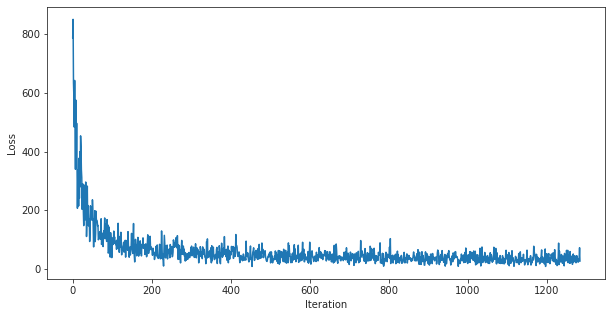

In [21]:
transform = transforms.Compose([Normalize(), ToTensor()])
dataset = TACDatasetClassification(DATASET_ID_TRAIN, tuples_train_classification)
data_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=lambda x: x)

transform_sinkhorn_pr_model = TransformSinkhornPRModel(D_in, D_out)

criterion = nn.BCELoss()
optimizer = optim.SGD(transform_sinkhorn_pr_model.parameters(), lr=learning_rate)

loss = []

for batch in data_loader:
    L = 0.0
    
    for sample in batch:
        (d, s1, s2), y = transform(sample)
                
        L += criterion(transform_sinkhorn_pr_model(d, s1, s2), y)
        
        optimizer.step()
        
    loss.append(L.item())
    print(f'{loss[-1]:.4f}')
    
    optimizer.zero_grad()

    L.backward()
    
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
plot_loss(ax, loss)
plt.show()

In [22]:
M = list(transform_sinkhorn_pr_model.parameters())[0].data.cpu().numpy()
np.save(os.path.join(MODELS_DIR, 'transform_sinkhorn_pr_model.npy'), M)

In [23]:
D_in = 768
D_out = 768
p = 2
blur = .05
scaling = .9
scaling_factor = 1
learning_rate = 1e-2
batch_size = 100


class NeuralNetSinkhornPRModel(nn.Module):
    def __init__(self, D_in, D_out):
        super(NeuralNetSinkhornPRModel, self).__init__()
        self.sinkhorn = SamplesLoss(loss='sinkhorn', p=p, blur=blur, scaling=scaling)
        self.layer = nn.Linear(D_in, D_out)
        self.sigm = nn.Sigmoid()
    
    def predict(self, x):
        return F.relu(self.layer(x))

    def forward(self, d, s1, s2):
        dist1 = self.sinkhorn(self.predict(d), self.predict(s1))
        dist2 = self.sinkhorn(self.predict(d), self.predict(s2))
        return self.sigm(scaling_factor * (dist2 - dist1))

D0819
D0848
D0813
D0809
D0820
D0802
D0827
D0843
D0826
D0814
D0812
D0820
D0807
D0802
D0804
D0804
D0818
D0812
D0824
D0804
D0812
D0835
D0844
D0821
D0831
D0804
D0841
D0804
D0814
D0824
D0831
D0823
D0814
D0835
D0805
D0815
D0819
D0802
D0829
D0846
D0823
D0804
D0818
D0826
D0815
D0828
D0844
D0828
D0815
D0827
D0819
D0804
D0845
D0823
D0841
D0809
D0823
D0845
D0820
D0844
D0820
D0845
D0804
D0843
D0827
D0814
D0813
D0820
D0835
D0805
D0807
D0848
D0826
D0847
D0841
D0818
D0820
D0812
D0822
D0824
D0807
D0834
D0807
D0819
D0826
D0818
D0844
D0844
D0828
D0848
D0829
D0812
D0818
D0824
D0807
D0821
D0839
D0819
D0835
D0820
69.3063
D0825
D0831
D0822
D0848
D0843
D0848
D0839
D0835
D0812
D0839
D0828
D0807
D0846
D0828
D0845
D0807
D0846
D0839
D0805
D0846
D0817
D0809
D0823
D0817
D0845
D0817
D0817
D0805
D0810
D0825
D0817
D0826
D0812
D0839
D0848
D0835
D0839
D0804
D0831
D0845
D0846
D0809
D0817
D0844
D0831
D0817
D0812
D0813
D0831
D0819
D0810
D0841
D0802
D0823
D0804
D0826
D0805
D0814
D0813
D0835
D0845
D0807
D0812
D0819
D0807
D0

69.1792
D0824
D0825
D0809
D0810
D0805
D0814
D0821
D0825
D0834
D0847
D0843
D0817
D0807
D0809
D0834
D0825
D0841
D0844
D0848
D0812
D0841
D0848
D0828
D0848
D0809
D0828
D0814
D0846
D0835
D0823
D0812
D0848
D0824
D0827
D0825
D0812
D0817
D0848
D0802
D0835
D0847
D0841
D0825
D0843
D0815
D0843
D0826
D0847
D0807
D0802
D0829
D0848
D0827
D0843
D0821
D0821
D0818
D0826
D0809
D0820
D0847
D0844
D0829
D0834
D0815
D0823
D0802
D0810
D0822
D0815
D0818
D0824
D0809
D0817
D0805
D0844
D0817
D0843
D0807
D0802
D0810
D0831
D0805
D0818
D0834
D0829
D0826
D0809
D0802
D0820
D0829
D0807
D0826
D0819
D0815
D0807
D0846
D0839
D0848
D0820
69.1378
D0802
D0827
D0820
D0823
D0821
D0834
D0835
D0847
D0835
D0814
D0821
D0805
D0814
D0844
D0835
D0820
D0821
D0848
D0825
D0834
D0847
D0844
D0848
D0846
D0831
D0831
D0848
D0824
D0813
D0807
D0843
D0828
D0845
D0822
D0845
D0818
D0810
D0822
D0822
D0847
D0848
D0843
D0844
D0819
D0818
D0846
D0835
D0810
D0824
D0821
D0815
D0815
D0820
D0812
D0822
D0802
D0844
D0845
D0817
D0823
D0804
D0847
D0848
D0827


68.7692
D0814
D0846
D0821
D0817
D0829
D0828
D0844
D0818
D0822
D0819
D0805
D0822
D0812
D0844
D0846
D0825
D0804
D0818
D0824
D0821
D0835
D0827
D0813
D0804
D0820
D0829
D0805
D0810
D0802
D0827
D0846
D0809
D0831
D0819
D0841
D0815
D0804
D0847
D0828
D0844
D0841
D0802
D0839
D0839
D0841
D0810
D0802
D0824
D0822
D0818
D0826
D0845
D0802
D0841
D0831
D0843
D0825
D0826
D0848
D0827
D0845
D0807
D0813
D0822
D0817
D0827
D0824
D0826
D0841
D0827
D0815
D0824
D0820
D0831
D0824
D0814
D0845
D0807
D0834
D0841
D0810
D0807
D0821
D0814
D0848
D0814
D0847
D0847
D0822
D0812
D0827
D0835
D0809
D0823
D0814
D0827
D0818
D0826
D0818
D0827
68.7160
D0829
D0843
D0835
D0818
D0812
D0823
D0812
D0818
D0822
D0813
D0804
D0820
D0809
D0839
D0810
D0825
D0805
D0847
D0843
D0825
D0819
D0810
D0820
D0814
D0823
D0826
D0826
D0810
D0835
D0812
D0818
D0817
D0814
D0824
D0824
D0839
D0804
D0820
D0820
D0848
D0848
D0827
D0809
D0817
D0848
D0809
D0802
D0809
D0813
D0846
D0834
D0815
D0839
D0824
D0807
D0844
D0829
D0812
D0847
D0831
D0831
D0826
D0822
D0810


66.7838
D0810
D0848
D0807
D0844
D0825
D0822
D0834
D0846
D0820
D0831
D0805
D0819
D0812
D0817
D0846
D0834
D0821
D0804
D0828
D0815
D0841
D0839
D0818
D0839
D0825
D0807
D0825
D0829
D0818
D0835
D0826
D0820
D0812
D0834
D0848
D0847
D0827
D0839
D0822
D0828
D0810
D0822
D0826
D0817
D0822
D0846
D0826
D0845
D0804
D0810
D0809
D0813
D0846
D0802
D0847
D0827
D0834
D0825
D0802
D0846
D0814
D0813
D0827
D0835
D0809
D0807
D0822
D0812
D0835
D0815
D0819
D0818
D0835
D0804
D0846
D0841
D0807
D0813
D0846
D0810
D0821
D0814
D0828
D0819
D0822
D0825
D0815
D0805
D0813
D0807
D0831
D0828
D0835
D0821
D0804
D0824
D0814
D0807
D0807
D0819
68.7883
D0820
D0844
D0829
D0815
D0817
D0846
D0834
D0813
D0828
D0824
D0835
D0817
D0839
D0826
D0820
D0823
D0829
D0848
D0826
D0825
D0831
D0823
D0831
D0846
D0820
D0846
D0812
D0822
D0821
D0829
D0812
D0827
D0831
D0817
D0815
D0819
D0844
D0828
D0807
D0827
D0829
D0845
D0839
D0814
D0827
D0834
D0818
D0804
D0809
D0823
D0817
D0813
D0802
D0820
D0827
D0822
D0827
D0828
D0843
D0831
D0843
D0827
D0828
D0817


63.3278
D0825
D0805
D0848
D0844
D0844
D0845
D0813
D0805
D0846
D0815
D0822
D0847
D0820
D0818
D0847
D0822
D0809
D0841
D0824
D0809
D0839
D0834
D0844
D0844
D0802
D0802
D0822
D0819
D0822
D0835
D0822
D0829
D0822
D0828
D0809
D0813
D0814
D0835
D0815
D0819
D0820
D0831
D0807
D0824
D0835
D0845
D0810
D0834
D0839
D0831
D0831
D0826
D0810
D0847
D0802
D0810
D0823
D0846
D0809
D0818
D0802
D0817
D0814
D0829
D0828
D0835
D0815
D0810
D0824
D0807
D0828
D0815
D0835
D0809
D0829
D0823
D0845
D0815
D0841
D0805
D0843
D0813
D0823
D0845
D0831
D0819
D0802
D0844
D0821
D0807
D0845
D0839
D0826
D0846
D0844
D0814
D0819
D0844
D0848
D0810
66.0168
D0829
D0818
D0802
D0845
D0841
D0819
D0814
D0831
D0812
D0817
D0810
D0814
D0817
D0804
D0831
D0807
D0848
D0847
D0818
D0807
D0821
D0834
D0804
D0843
D0831
D0826
D0810
D0817
D0829
D0822
D0844
D0809
D0804
D0813
D0809
D0827
D0831
D0820
D0818
D0828
D0809
D0812
D0812
D0831
D0831
D0807
D0845
D0844
D0809
D0820
D0814
D0822
D0807
D0815
D0827
D0828
D0844
D0835
D0820
D0823
D0835
D0809
D0810
D0823


64.4545
D0828
D0817
D0844
D0848
D0802
D0826
D0831
D0841
D0846
D0807
D0828
D0834
D0825
D0839
D0805
D0814
D0845
D0839
D0847
D0824
D0831
D0848
D0814
D0812
D0819
D0839
D0819
D0841
D0843
D0825
D0821
D0848
D0845
D0844
D0814
D0802
D0810
D0814
D0822
D0843
D0815
D0843
D0843
D0802
D0818
D0824
D0805
D0844
D0807
D0846
D0818
D0828
D0843
D0828
D0825
D0844
D0831
D0839
D0823
D0805
D0839
D0834
D0813
D0817
D0818
D0802
D0824
D0841
D0841
D0828
D0820
D0810
D0844
D0826
D0821
D0818
D0826
D0848
D0835
D0812
D0841
D0812
D0818
D0813
D0809
D0828
D0824
D0831
D0815
D0844
D0843
D0804
D0815
D0820
D0839
D0817
D0819
D0813
D0815
D0807
63.2359
D0829
D0815
D0829
D0826
D0834
D0802
D0823
D0813
D0821
D0828
D0820
D0831
D0822
D0825
D0846
D0827
D0844
D0813
D0831
D0810
D0817
D0843
D0815
D0834
D0848
D0810
D0823
D0815
D0815
D0829
D0815
D0824
D0817
D0807
D0843
D0804
D0839
D0807
D0826
D0848
D0818
D0848
D0818
D0820
D0821
D0829
D0810
D0822
D0822
D0831
D0847
D0825
D0844
D0804
D0848
D0810
D0812
D0828
D0834
D0822
D0809
D0826
D0835
D0845


60.5784
D0843
D0807
D0824
D0845
D0805
D0802
D0824
D0839
D0804
D0825
D0809
D0834
D0839
D0835
D0823
D0813
D0827
D0831
D0844
D0846
D0835
D0828
D0807
D0825
D0810
D0846
D0846
D0820
D0822
D0834
D0810
D0823
D0846
D0809
D0807
D0818
D0818
D0823
D0804
D0825
D0807
D0826
D0844
D0828
D0807
D0821
D0843
D0819
D0845
D0824
D0810
D0831
D0805
D0839
D0826
D0804
D0823
D0805
D0827
D0802
D0823
D0820
D0847
D0848
D0818
D0818
D0807
D0831
D0810
D0848
D0826
D0845
D0846
D0841
D0820
D0809
D0846
D0823
D0845
D0839
D0843
D0831
D0829
D0841
D0802
D0812
D0845
D0829
D0818
D0815
D0807
D0810
D0847
D0809
D0820
D0831
D0819
D0814
D0844
D0835
63.9755
D0846
D0831
D0846
D0828
D0805
D0827
D0846
D0826
D0823
D0821
D0810
D0813
D0818
D0819
D0829
D0815
D0807
D0847
D0844
D0805
D0814
D0813
D0822
D0810
D0810
D0845
D0820
D0815
D0802
D0804
D0820
D0810
D0805
D0813
D0846
D0828
D0809
D0826
D0824
D0805
D0825
D0807
D0802
D0846
D0848
D0825
D0835
D0813
D0846
D0823
D0813
D0846
D0848
D0819
D0815
D0829
D0807
D0839
D0822
D0835
D0831
D0812
D0822
D0817


61.1278
D0815
D0847
D0828
D0810
D0802
D0821
D0839
D0810
D0804
D0802
D0809
D0831
D0846
D0828
D0821
D0824
D0828
D0814
D0820
D0846
D0821
D0843
D0820
D0814
D0825
D0825
D0817
D0804
D0815
D0822
D0818
D0809
D0848
D0845
D0844
D0829
D0812
D0844
D0845
D0822
D0848
D0824
D0813
D0812
D0844
D0815
D0812
D0826
D0848
D0839
D0809
D0839
D0844
D0817
D0822
D0802
D0841
D0810
D0810
D0822
D0807
D0834
D0845
D0831
D0812
D0815
D0812
D0828
D0827
D0846
D0829
D0804
D0825
D0846
D0839
D0834
D0844
D0805
D0839
D0818
D0802
D0845
D0821
D0846
D0818
D0807
D0829
D0821
D0843
D0810
D0812
D0822
D0829
D0846
D0825
D0815
D0835
D0839
D0826
D0815
60.0881
D0815
D0810
D0809
D0809
D0812
D0845
D0815
D0818
D0813
D0820
D0824
D0813
D0824
D0828
D0827
D0834
D0818
D0820
D0848
D0826
D0818
D0827
D0821
D0831
D0822
D0839
D0807
D0818
D0822
D0848
D0835
D0843
D0834
D0843
D0822
D0812
D0835
D0835
D0815
D0824
D0812
D0821
D0823
D0825
D0802
D0845
D0834
D0845
D0831
D0813
D0839
D0827
D0805
D0831
D0827
D0847
D0817
D0817
D0820
D0825
D0815
D0805
D0845
D0845


59.6305
D0807
D0821
D0835
D0826
D0817
D0815
D0835
D0814
D0848
D0841
D0814
D0846
D0819
D0805
D0834
D0807
D0815
D0802
D0834
D0826
D0818
D0828
D0804
D0807
D0827
D0845
D0848
D0847
D0824
D0845
D0821
D0819
D0835
D0839
D0809
D0820
D0844
D0812
D0802
D0831
D0826
D0818
D0809
D0828
D0839
D0810
D0845
D0820
D0822
D0841
D0825
D0835
D0805
D0810
D0841
D0824
D0845
D0812
D0818
D0809
D0825
D0813
D0848
D0835
D0818
D0828
D0827
D0819
D0818
D0835
D0817
D0827
D0817
D0835
D0828
D0822
D0817
D0823
D0807
D0817
D0818
D0845
D0807
D0826
D0845
D0802
D0809
D0845
D0807
D0823
D0847
D0810
D0812
D0805
D0818
D0826
D0824
D0809
D0824
D0825
55.0061
D0818
D0825
D0812
D0821
D0823
D0814
D0848
D0823
D0835
D0815
D0847
D0828
D0815
D0807
D0839
D0813
D0814
D0810
D0818
D0819
D0812
D0822
D0831
D0827
D0835
D0839
D0821
D0819
D0824
D0835
D0845
D0827
D0839
D0841
D0835
D0835
D0825
D0839
D0810
D0804
D0841
D0813
D0841
D0805
D0817
D0812
D0809
D0813
D0821
D0822
D0814
D0820
D0813
D0841
D0826
D0839
D0845
D0847
D0818
D0841
D0810
D0823
D0848
D0847


57.3176
D0826
D0812
D0834
D0824
D0848
D0821
D0810
D0825
D0847
D0807
D0812
D0813
D0826
D0820
D0823
D0835
D0802
D0825
D0810
D0807
D0802
D0834
D0828
D0839
D0815
D0831
D0847
D0827
D0847
D0847
D0818
D0819
D0802
D0813
D0827
D0841
D0812
D0841
D0815
D0821
D0848
D0815
D0810
D0834
D0844
D0804
D0804
D0824
D0831
D0845
D0844
D0807
D0834
D0804
D0818
D0820
D0845
D0820
D0827
D0841
D0846
D0805
D0835
D0829
D0802
D0821
D0843
D0826
D0825
D0822
D0825
D0813
D0825
D0847
D0807
D0825
D0810
D0820
D0848
D0809
D0828
D0819
D0841
D0834
D0848
D0848
D0845
D0828
D0804
D0828
D0822
D0824
D0821
D0827
D0810
D0844
D0829
D0823
D0819
D0820
53.7446
D0818
D0843
D0825
D0824
D0802
D0834
D0823
D0845
D0843
D0805
D0827
D0835
D0812
D0815
D0818
D0807
D0835
D0802
D0834
D0834
D0847
D0810
D0819
D0805
D0828
D0826
D0831
D0814
D0820
D0843
D0848
D0829
D0804
D0825
D0804
D0818
D0826
D0843
D0841
D0807
D0817
D0807
D0846
D0835
D0815
D0820
D0848
D0809
D0846
D0824
D0831
D0815
D0829
D0818
D0817
D0813
D0834
D0807
D0802
D0828
D0813
D0839
D0841
D0814


53.5384
D0813
D0828
D0819
D0823
D0834
D0828
D0843
D0821
D0843
D0828
D0819
D0826
D0823
D0818
D0818
D0825
D0822
D0815
D0814
D0805
D0802
D0818
D0822
D0839
D0846
D0812
D0834
D0827
D0831
D0825
D0805
D0822
D0822
D0844
D0834
D0818
D0809
D0805
D0848
D0831
D0826
D0802
D0804
D0841
D0820
D0809
D0824
D0841
D0815
D0807
D0813
D0827
D0805
D0821
D0823
D0824
D0834
D0829
D0805
D0825
D0802
D0848
D0809
D0834
D0822
D0845
D0820
D0847
D0814
D0818
D0844
D0834
D0824
D0822
D0827
D0829
D0835
D0829
D0831
D0814
D0812
D0817
D0846
D0826
D0809
D0823
D0827
D0807
D0807
D0828
D0813
D0834
D0821
D0848
D0812
D0844
D0813
D0824
D0844
D0829
59.8902
D0846
D0829
D0812
D0820
D0819
D0844
D0824
D0839
D0843
D0804
D0826
D0843
D0848
D0823
D0814
D0831
D0834
D0812
D0826
D0844
D0823
D0815
D0818
D0826
D0841
D0823
D0809
D0815
D0827
D0822
D0848
D0831
D0827
D0817
D0822
D0847
D0844
D0846
D0824
D0843
D0822
D0828
D0813
D0812
D0828
D0814
D0825
D0810
D0813
D0828
D0829
D0822
D0823
D0848
D0847
D0815
D0804
D0834
D0847
D0839
D0828
D0846
D0848
D0831


48.7962
D0820
D0804
D0804
D0831
D0810
D0807
D0839
D0839
D0827
D0839
D0845
D0814
D0820
D0839
D0839
D0818
D0812
D0824
D0844
D0820
D0829
D0824
D0818
D0828
D0824
D0814
D0814
D0847
D0824
D0834
D0822
D0821
D0831
D0804
D0829
D0848
D0821
D0844
D0805
D0821
D0805
D0844
D0821
D0805
D0814
D0826
D0804
D0823
D0804
D0848
D0822
D0827
D0847
D0823
D0824
D0807
D0841
D0802
D0827
D0831
D0820
D0834
D0824
D0827
D0827
D0828
D0829
D0846
D0818
D0804
D0818
D0847
D0843
D0843
D0817
D0814
D0820
D0802
D0828
D0823
D0817
D0834
D0804
D0848
D0805
D0825
D0847
D0843
D0844
D0829
D0820
D0814
D0812
D0846
D0818
D0822
D0847
D0841
D0813
D0813
58.8739
D0824
D0834
D0835
D0825
D0841
D0826
D0828
D0835
D0813
D0823
D0813
D0848
D0848
D0817
D0807
D0827
D0810
D0831
D0846
D0823
D0817
D0802
D0824
D0825
D0824
D0841
D0814
D0839
D0846
D0810
D0823
D0839
D0807
D0828
D0826
D0829
D0848
D0809
D0848
D0846
D0839
D0809
D0812
D0841
D0810
D0826
D0844
D0825
D0804
D0807
D0820
D0821
D0807
D0843
D0843
D0817
D0818
D0843
D0807
D0802
D0828
D0819
D0826
D0847


53.7443
D0826
D0805
D0825
D0812
D0820
D0812
D0812
D0844
D0846
D0828
D0841
D0805
D0843
D0828
D0845
D0809
D0821
D0844
D0822
D0827
D0831
D0810
D0810
D0843
D0839
D0821
D0834
D0823
D0813
D0813
D0846
D0825
D0846
D0810
D0845
D0844
D0848
D0802
D0821
D0820
D0824
D0825
D0804
D0829
D0813
D0823
D0802
D0819
D0826
D0831
D0818
D0822
D0834
D0809
D0825
D0841
D0820
D0831
D0828
D0844
D0823
D0818
D0820
D0805
D0846
D0819
D0819
D0835
D0825
D0821
D0818
D0848
D0826
D0826
D0812
D0835
D0813
D0822
D0807
D0819
D0831
D0834
D0826
D0810
D0810
D0831
D0819
D0827
D0845
D0809
D0802
D0848
D0827
D0831
D0823
D0820
D0846
D0835
D0834
D0814
53.2733
D0834
D0810
D0835
D0804
D0824
D0820
D0822
D0820
D0818
D0804
D0835
D0847
D0839
D0821
D0834
D0839
D0848
D0828
D0834
D0826
D0824
D0819
D0841
D0813
D0835
D0804
D0802
D0804
D0844
D0843
D0827
D0823
D0805
D0825
D0846
D0804
D0813
D0831
D0812
D0807
D0807
D0844
D0813
D0813
D0826
D0809
D0813
D0823
D0843
D0828
D0819
D0839
D0846
D0815
D0802
D0817
D0804
D0807
D0821
D0817
D0817
D0846
D0818
D0846


45.3082
D0827
D0802
D0813
D0812
D0812
D0825
D0843
D0822
D0847
D0843
D0817
D0829
D0814
D0839
D0815
D0828
D0844
D0835
D0828
D0831
D0810
D0805
D0802
D0835
D0827
D0815
D0825
D0825
D0814
D0845
D0841
D0815
D0834
D0846
D0846
D0841
D0809
D0822
D0847
D0835
D0827
D0820
D0828
D0815
D0826
D0809
D0805
D0813
D0827
D0843
D0822
D0839
D0841
D0834
D0815
D0802
D0843
D0824
D0809
D0812
D0814
D0825
D0843
D0817
D0819
D0827
D0813
D0828
D0812
D0821
D0844
D0846
D0807
D0822
D0810
D0813
D0828
D0846
D0839
D0827
D0823
D0834
D0820
D0835
D0809
D0843
D0805
D0845
D0827
D0818
D0827
D0847
D0804
D0807
D0810
D0820
D0823
D0817
D0812
D0809
47.6337
D0845
D0848
D0828
D0835
D0821
D0825
D0844
D0818
D0823
D0807
D0807
D0828
D0825
D0813
D0826
D0817
D0839
D0802
D0814
D0812
D0818
D0828
D0819
D0818
D0835
D0828
D0820
D0824
D0827
D0847
D0821
D0835
D0844
D0820
D0831
D0819
D0814
D0819
D0827
D0822
D0812
D0815
D0805
D0809
D0846
D0843
D0839
D0845
D0825
D0815
D0822
D0844
D0844
D0827
D0804
D0809
D0804
D0804
D0834
D0829
D0825
D0814
D0810
D0846


49.3217
D0822
D0812
D0820
D0828
D0846
D0809
D0834
D0848
D0829
D0835
D0835
D0820
D0828
D0847
D0812
D0835
D0826
D0809
D0813
D0820
D0827
D0813
D0819
D0835
D0822
D0823
D0821
D0844
D0815
D0802
D0820
D0805
D0822
D0841
D0817
D0839
D0827
D0802
D0813
D0815
D0827
D0843
D0802
D0814
D0848
D0844
D0813
D0804
D0847
D0845
D0823
D0846
D0804
D0804
D0835
D0807
D0807
D0812
D0825
D0807
D0813
D0813
D0815
D0804
D0828
D0809
D0820
D0814
D0825
D0843
D0817
D0805
D0819
D0814
D0847
D0841
D0813
D0841
D0805
D0807
D0804
D0824
D0825
D0814
D0802
D0843
D0831
D0848
D0815
D0823
D0845
D0807
D0804
D0814
D0848
D0822
D0822
D0802
D0822
D0818
47.0576
D0826
D0810
D0847
D0820
D0813
D0805
D0848
D0804
D0805
D0815
D0819
D0807
D0844
D0802
D0807
D0819
D0848
D0822
D0828
D0828
D0821
D0839
D0818
D0805
D0821
D0825
D0826
D0819
D0824
D0827
D0839
D0807
D0828
D0845
D0815
D0828
D0817
D0809
D0815
D0821
D0802
D0835
D0834
D0843
D0846
D0812
D0847
D0829
D0827
D0824
D0807
D0843
D0824
D0827
D0843
D0825
D0846
D0802
D0825
D0843
D0829
D0809
D0823
D0823


49.2557
D0825
D0818
D0814
D0843
D0813
D0819
D0817
D0825
D0825
D0824
D0839
D0819
D0848
D0827
D0802
D0814
D0802
D0823
D0820
D0802
D0810
D0847
D0847
D0845
D0810
D0829
D0848
D0822
D0846
D0813
D0817
D0802
D0835
D0802
D0812
D0841
D0819
D0846
D0824
D0815
D0812
D0818
D0846
D0848
D0843
D0818
D0831
D0812
D0841
D0820
D0809
D0825
D0819
D0839
D0846
D0807
D0821
D0804
D0834
D0829
D0815
D0805
D0812
D0846
D0829
D0805
D0844
D0815
D0817
D0823
D0815
D0828
D0810
D0835
D0802
D0824
D0822
D0828
D0824
D0848
D0802
D0829
D0844
D0814
D0834
D0826
D0844
D0819
D0818
D0826
D0834
D0819
D0845
D0847
D0843
D0825
D0825
D0810
D0817
D0804
44.8647
D0839
D0847
D0823
D0818
D0827
D0828
D0825
D0820
D0825
D0818
D0841
D0824
D0839
D0817
D0823
D0843
D0812
D0814
D0845
D0846
D0812
D0805
D0820
D0844
D0839
D0822
D0834
D0844
D0827
D0831
D0822
D0834
D0818
D0820
D0828
D0823
D0818
D0822
D0826
D0844
D0818
D0818
D0822
D0847
D0815
D0829
D0813
D0819
D0815
D0802
D0818
D0821
D0819
D0847
D0812
D0825
D0809
D0805
D0839
D0829
D0843
D0821
D0809
D0834


40.7430
D0848
D0805
D0848
D0802
D0827
D0827
D0824
D0831
D0835
D0813
D0845
D0841
D0844
D0824
D0841
D0844
D0815
D0825
D0813
D0843
D0841
D0809
D0815
D0826
D0824
D0820
D0813
D0802
D0826
D0802
D0819
D0834
D0824
D0845
D0825
D0802
D0819
D0831
D0835
D0823
D0822
D0825
D0829
D0826
D0821
D0847
D0824
D0802
D0817
D0841
D0809
D0812
D0847
D0819
D0818
D0845
D0818
D0823
D0802
D0841
D0821
D0810
D0821
D0820
D0818
D0802
D0828
D0815
D0847
D0846
D0845
D0844
D0835
D0845
D0824
D0821
D0817
D0835
D0820
D0828
D0807
D0846
D0824
D0823
D0847
D0820
D0820
D0841
D0843
D0839
D0835
D0814
D0827
D0807
D0835
D0839
D0824
D0824
D0821
D0847
41.9518
D0825
D0825
D0819
D0802
D0824
D0802
D0841
D0844
D0818
D0822
D0834
D0817
D0822
D0821
D0844
D0848
D0827
D0845
D0823
D0829
D0821
D0844
D0825
D0834
D0831
D0826
D0818
D0805
D0817
D0839
D0847
D0847
D0825
D0846
D0824
D0805
D0822
D0841
D0844
D0828
D0825
D0845
D0817
D0843
D0828
D0819
D0821
D0817
D0826
D0843
D0827
D0817
D0822
D0844
D0814
D0814
D0813
D0845
D0814
D0829
D0826
D0821
D0810
D0820


40.2128
D0818
D0815
D0826
D0845
D0804
D0820
D0815
D0804
D0802
D0848
D0848
D0814
D0804
D0807
D0802
D0826
D0815
D0804
D0848
D0805
D0834
D0820
D0844
D0802
D0823
D0835
D0824
D0820
D0825
D0845
D0822
D0834
D0820
D0807
D0807
D0804
D0807
D0839
D0823
D0845
D0823
D0809
D0827
D0845
D0827
D0828
D0826
D0817
D0802
D0812
D0848
D0831
D0815
D0835
D0848
D0841
D0825
D0826
D0825
D0825
D0841
D0820
D0847
D0822
D0809
D0813
D0827
D0804
D0834
D0813
D0834
D0822
D0805
D0834
D0841
D0829
D0804
D0810
D0822
D0820
D0813
D0819
D0818
D0847
D0834
D0835
D0839
D0831
D0817
D0844
D0817
D0824
D0848
D0843
D0805
D0846
D0847
D0831
D0823
D0841
40.3922
D0846
D0828
D0828
D0817
D0835
D0819
D0829
D0805
D0807
D0839
D0828
D0818
D0826
D0813
D0823
D0835
D0831
D0805
D0810
D0823
D0841
D0841
D0828
D0810
D0831
D0843
D0847
D0823
D0804
D0807
D0845
D0847
D0822
D0807
D0810
D0817
D0843
D0802
D0846
D0844
D0809
D0834
D0844
D0823
D0810
D0815
D0820
D0812
D0812
D0844
D0817
D0828
D0843
D0815
D0821
D0807
D0802
D0847
D0831
D0812
D0810
D0827
D0835
D0809


43.2009
D0848
D0824
D0802
D0807
D0839
D0818
D0820
D0813
D0813
D0807
D0814
D0846
D0817
D0815
D0825
D0839
D0802
D0813
D0820
D0809
D0810
D0828
D0820
D0817
D0834
D0823
D0814
D0835
D0821
D0826
D0805
D0805
D0823
D0835
D0815
D0822
D0826
D0818
D0818
D0824
D0805
D0823
D0823
D0810
D0817
D0814
D0847
D0843
D0807
D0848
D0839
D0843
D0844
D0819
D0829
D0823
D0815
D0820
D0848
D0819
D0824
D0828
D0827
D0813
D0821
D0821
D0841
D0824
D0826
D0848
D0831
D0845
D0827
D0844
D0813
D0848
D0848
D0827
D0815
D0810
D0820
D0826
D0814
D0817
D0829
D0826
D0828
D0834
D0805
D0823
D0810
D0846
D0846
D0810
D0847
D0821
D0829
D0820
D0820
D0810
43.0502
D0824
D0820
D0831
D0805
D0828
D0822
D0843
D0839
D0810
D0827
D0807
D0845
D0821
D0828
D0818
D0814
D0802
D0813
D0815
D0825
D0820
D0831
D0834
D0848
D0826
D0845
D0804
D0846
D0835
D0847
D0820
D0815
D0810
D0828
D0814
D0815
D0812
D0827
D0844
D0807
D0807
D0822
D0846
D0829
D0823
D0815
D0802
D0814
D0812
D0822
D0805
D0848
D0818
D0828
D0831
D0819
D0841
D0823
D0818
D0818
D0826
D0841
D0844
D0819


40.6996
D0825
D0812
D0829
D0805
D0834
D0835
D0804
D0810
D0843
D0804
D0846
D0822
D0820
D0807
D0813
D0818
D0823
D0815
D0824
D0847
D0821
D0814
D0814
D0834
D0818
D0818
D0810
D0835
D0814
D0821
D0810
D0812
D0848
D0845
D0819
D0845
D0844
D0807
D0822
D0821
D0823
D0846
D0805
D0802
D0843
D0812
D0847
D0834
D0831
D0818
D0834
D0819
D0805
D0821
D0819
D0835
D0822
D0821
D0812
D0821
D0829
D0813
D0804
D0810
D0834
D0821
D0812
D0813
D0825
D0820
D0809
D0826
D0805
D0829
D0823
D0839
D0809
D0834
D0820
D0807
D0818
D0810
D0848
D0818
D0820
D0847
D0813
D0847
D0826
D0848
D0841
D0804
D0843
D0847
D0810
D0804
D0825
D0807
D0827
D0820
39.0013
D0844
D0843
D0826
D0834
D0827
D0831
D0809
D0827
D0810
D0821
D0809
D0823
D0839
D0843
D0831
D0847
D0805
D0846
D0847
D0812
D0829
D0807
D0848
D0813
D0845
D0807
D0824
D0834
D0802
D0807
D0827
D0841
D0810
D0839
D0809
D0845
D0829
D0819
D0827
D0827
D0829
D0814
D0846
D0805
D0841
D0804
D0810
D0814
D0848
D0823
D0829
D0845
D0820
D0823
D0822
D0814
D0814
D0824
D0828
D0810
D0835
D0846
D0819
D0828


39.6425
D0812
D0835
D0834
D0802
D0848
D0847
D0804
D0809
D0822
D0831
D0848
D0807
D0834
D0814
D0835
D0846
D0823
D0844
D0822
D0805
D0817
D0819
D0824
D0841
D0824
D0845
D0848
D0819
D0817
D0822
D0812
D0807
D0827
D0841
D0825
D0825
D0809
D0809
D0805
D0817
D0819
D0839
D0817
D0827
D0807
D0814
D0826
D0817
D0813
D0835
D0810
D0814
D0847
D0823
D0802
D0829
D0809
D0825
D0835
D0844
D0847
D0829
D0820
D0824
D0818
D0807
D0817
D0848
D0815
D0823
D0846
D0828
D0818
D0826
D0825
D0812
D0818
D0823
D0846
D0813
D0839
D0804
D0817
D0815
D0846
D0817
D0815
D0818
D0831
D0845
D0818
D0812
D0834
D0815
D0818
D0825
D0822
D0817
D0839
D0827
38.3239
D0810
D0813
D0815
D0804
D0839
D0819
D0813
D0834
D0812
D0843
D0844
D0814
D0810
D0814
D0844
D0835
D0846
D0807
D0814
D0847
D0834
D0834
D0814
D0820
D0839
D0829
D0820
D0847
D0846
D0844
D0812
D0848
D0834
D0843
D0843
D0831
D0843
D0810
D0847
D0829
D0809
D0810
D0828
D0813
D0835
D0822
D0846
D0826
D0802
D0839
D0823
D0818
D0823
D0835
D0810
D0828
D0827
D0844
D0813
D0825
D0846
D0848
D0822
D0802


35.9983
D0846
D0809
D0846
D0805
D0820
D0841
D0843
D0804
D0817
D0820
D0812
D0804
D0847
D0809
D0804
D0817
D0839
D0817
D0834
D0813
D0802
D0820
D0831
D0815
D0834
D0846
D0807
D0848
D0818
D0829
D0812
D0824
D0807
D0846
D0828
D0814
D0810
D0823
D0821
D0802
D0825
D0813
D0823
D0817
D0822
D0810
D0826
D0804
D0843
D0813
D0827
D0841
D0813
D0804
D0818
D0827
D0845
D0823
D0819
D0805
D0839
D0839
D0826
D0817
D0843
D0825
D0815
D0831
D0847
D0824
D0834
D0805
D0834
D0835
D0843
D0817
D0834
D0815
D0848
D0827
D0805
D0807
D0843
D0820
D0834
D0812
D0824
D0835
D0824
D0843
D0805
D0824
D0818
D0843
D0804
D0841
D0848
D0825
D0814
D0812
32.1468
D0805
D0820
D0821
D0818
D0841
D0843
D0810
D0815
D0822
D0846
D0846
D0807
D0835
D0802
D0843
D0831
D0817
D0810
D0818
D0822
D0847
D0817
D0821
D0826
D0821
D0807
D0847
D0847
D0847
D0826
D0845
D0829
D0828
D0831
D0846
D0817
D0802
D0817
D0826
D0820
D0809
D0824
D0834
D0817
D0813
D0846
D0828
D0835
D0805
D0825
D0804
D0845
D0848
D0824
D0828
D0815
D0820
D0824
D0817
D0823
D0845
D0824
D0804
D0846


36.1544
D0805
D0812
D0828
D0824
D0822
D0807
D0845
D0807
D0834
D0817
D0821
D0845
D0827
D0831
D0846
D0809
D0843
D0818
D0841
D0829
D0839
D0813
D0834
D0814
D0847
D0822
D0843
D0815
D0831
D0822
D0804
D0802
D0843
D0846
D0819
D0848
D0845
D0827
D0813
D0819
D0812
D0819
D0813
D0824
D0847
D0844
D0822
D0827
D0820
D0839
D0839
D0823
D0810
D0817
D0843
D0826
D0810
D0841
D0804
D0843
D0839
D0828
D0826
D0827
D0845
D0813
D0810
D0829
D0804
D0831
D0839
D0835
D0831
D0834
D0843
D0807
D0834
D0841
D0834
D0825
D0843
D0835
D0804
D0844
D0809
D0847
D0822
D0825
D0815
D0847
D0802
D0802
D0826
D0821
D0846
D0846
D0847
D0835
D0831
D0825
40.5409
D0831
D0843
D0815
D0823
D0835
D0812
D0828
D0818
D0825
D0819
D0827
D0809
D0822
D0839
D0809
D0826
D0812
D0810
D0839
D0834
D0812
D0831
D0846
D0835
D0809
D0848
D0809
D0828
D0843
D0846
D0844
D0827
D0820
D0834
D0825
D0847
D0805
D0812
D0828
D0834
D0819
D0841
D0844
D0814
D0839
D0829
D0835
D0818
D0818
D0810
D0810
D0807
D0810
D0813
D0818
D0845
D0809
D0805
D0848
D0841
D0822
D0807
D0827
D0817


D0823
D0810
D0827
D0818
D0829
D0825
D0835
D0848
D0818
D0826
D0820
D0823
D0845
D0825
D0834
D0847
D0847
D0818
38.9395
D0847
D0847
D0817
D0845
D0835
D0828
D0807
D0848
D0817
D0823
D0834
D0807
D0831
D0829
D0846
D0828
D0827
D0820
D0834
D0817
D0820
D0810
D0812
D0821
D0822
D0804
D0839
D0813
D0814
D0813
D0845
D0814
D0846
D0818
D0804
D0835
D0824
D0845
D0846
D0810
D0844
D0820
D0805
D0847
D0847
D0846
D0819
D0846
D0843
D0807
D0814
D0841
D0818
D0809
D0802
D0809
D0812
D0845
D0847
D0805
D0802
D0845
D0848
D0822
D0819
D0846
D0818
D0846
D0814
D0825
D0835
D0847
D0817
D0831
D0805
D0848
D0846
D0812
D0828
D0847
D0835
D0818
D0809
D0847
D0818
D0835
D0812
D0845
D0819
D0817
D0848
D0845
D0814
D0804
D0845
D0828
D0831
D0826
D0825
D0826
33.4482
D0820
D0843
D0813
D0829
D0805
D0812
D0829
D0844
D0845
D0805
D0845
D0845
D0845
D0825
D0814
D0815
D0819
D0848
D0807
D0846
D0815
D0815
D0815
D0810
D0807
D0822
D0839
D0845
D0809
D0827
D0845
D0813
D0831
D0826
D0825
D0807
D0820
D0815
D0826
D0822
D0831
D0829
D0822
D0804
D0827
D0848


33.7212
D0827
D0823
D0822
D0843
D0846
D0810
D0802
D0823
D0822
D0843
D0835
D0841
D0828
D0826
D0834
D0845
D0839
D0847
D0818
D0814
D0814
D0844
D0844
D0847
D0824
D0835
D0813
D0815
D0844
D0815
D0809
D0819
D0845
D0807
D0824
D0821
D0814
D0841
D0812
D0815
D0821
D0821
D0812
D0814
D0820
D0820
D0843
D0814
D0824
D0828
D0810
D0807
D0828
D0823
D0807
D0829
D0812
D0807
D0824
D0845
D0845
D0843
D0822
D0834
D0819
D0834
D0815
D0822
D0807
D0810
D0805
D0819
D0802
D0828
D0809
D0843
D0835
D0802
D0841
D0831
D0821
D0848
D0829
D0826
D0825
D0810
D0848
D0844
D0825
D0805
D0815
D0812
D0846
D0827
D0835
D0805
D0807
D0819
D0804
D0848
41.6525
D0817
D0812
D0829
D0828
D0804
D0819
D0839
D0835
D0812
D0812
D0825
D0835
D0844
D0824
D0817
D0843
D0820
D0834
D0845
D0807
D0807
D0839
D0845
D0815
D0813
D0827
D0845
D0822
D0823
D0828
D0825
D0829
D0846
D0825
D0815
D0841
D0812
D0834
D0846
D0813
D0831
D0835
D0807
D0817
D0834
D0839
D0809
D0821
D0823
D0813
D0829
D0818
D0848
D0846
D0847
D0828
D0813
D0818
D0810
D0814
D0846
D0809
D0819
D0831


32.2413
D0804
D0843
D0820
D0834
D0804
D0844
D0827
D0827
D0835
D0807
D0817
D0823
D0843
D0814
D0822
D0818
D0810
D0835
D0845
D0821
D0819
D0820
D0828
D0835
D0826
D0844
D0839
D0843
D0807
D0831
D0828
D0847
D0821
D0834
D0804
D0844
D0844
D0848
D0841
D0831
D0809
D0834
D0835
D0823
D0843
D0809
D0805
D0835
D0826
D0846
D0817
D0822
D0804
D0823
D0844
D0848
D0805
D0819
D0817
D0827
D0802
D0823
D0839
D0825
D0835
D0820
D0829
D0810
D0819
D0826
D0820
D0846
D0847
D0802
D0827
D0827
D0809
D0805
D0847
D0841
D0809
D0826
D0814
D0839
D0834
D0812
D0818
D0847
D0829
D0804
D0824
D0810
D0815
D0804
D0814
D0817
D0828
D0826
D0847
D0818
38.7653
D0807
D0824
D0814
D0829
D0802
D0831
D0845
D0845
D0826
D0841
D0839
D0827
D0814
D0822
D0822
D0809
D0839
D0823
D0824
D0824
D0821
D0805
D0841
D0848
D0839
D0824
D0804
D0824
D0826
D0818
D0831
D0817
D0823
D0839
D0825
D0809
D0826
D0810
D0827
D0821
D0802
D0843
D0831
D0841
D0817
D0831
D0822
D0846
D0831
D0834
D0829
D0847
D0821
D0826
D0829
D0802
D0835
D0820
D0821
D0823
D0844
D0834
D0848
D0848


28.3258
D0804
D0834
D0827
D0812
D0841
D0841
D0810
D0802
D0844
D0829
D0805
D0835
D0802
D0807
D0818
D0814
D0805
D0821
D0815
D0818
D0821
D0807
D0815
D0815
D0814
D0814
D0805
D0802
D0845
D0848
D0815
D0824
D0846
D0844
D0815
D0845
D0829
D0831
D0826
D0841
D0835
D0843
D0828
D0819
D0818
D0843
D0828
D0834
D0826
D0824
D0831
D0847
D0829
D0831
D0824
D0834
D0812
D0844
D0826
D0813
D0822
D0810
D0814
D0831
D0848
D0809
D0841
D0844
D0845
D0825
D0809
D0826
D0829
D0839
D0845
D0824
D0822
D0827
D0820
D0817
D0843
D0845
D0844
D0828
D0823
D0818
D0817
D0804
D0819
D0839
D0823
D0841
D0812
D0835
D0827
D0823
D0829
D0845
D0846
D0809
31.4191
D0827
D0846
D0818
D0834
D0826
D0839
D0845
D0817
D0828
D0813
D0819
D0814
D0804
D0807
D0810
D0835
D0809
D0848
D0804
D0835
D0848
D0825
D0831
D0805
D0802
D0847
D0835
D0847
D0820
D0843
D0829
D0813
D0843
D0844
D0815
D0819
D0831
D0809
D0802
D0820
D0839
D0815
D0841
D0845
D0839
D0805
D0813
D0823
D0843
D0848
D0841
D0848
D0805
D0822
D0841
D0821
D0823
D0844
D0831
D0813
D0804
D0813
D0802
D0824


32.7931
D0846
D0815
D0819
D0828
D0846
D0846
D0841
D0821
D0848
D0812
D0845
D0835
D0844
D0843
D0818
D0821
D0824
D0827
D0824
D0802
D0815
D0847
D0822
D0826
D0823
D0815
D0822
D0815
D0847
D0846
D0807
D0810
D0823
D0822
D0823
D0845
D0823
D0839
D0815
D0848
D0802
D0819
D0841
D0802
D0848
D0824
D0825
D0845
D0843
D0841
D0829
D0822
D0839
D0839
D0812
D0815
D0815
D0815
D0831
D0828
D0819
D0834
D0823
D0829
D0815
D0845
D0804
D0848
D0835
D0839
D0809
D0844
D0843
D0814
D0807
D0841
D0819
D0822
D0815
D0828
D0847
D0820
D0813
D0818
D0828
D0831
D0827
D0809
D0841
D0847
D0841
D0834
D0807
D0804
D0805
D0844
D0825
D0814
D0818
D0845
29.5757
D0813
D0846
D0847
D0834
D0814
D0824
D0846
D0841
D0826
D0831
D0820
D0827
D0841
D0817
D0815
D0826
D0841
D0807
D0831
D0813
D0821
D0829
D0826
D0831
D0841
D0824
D0805
D0827
D0818
D0810
D0820
D0834
D0805
D0831
D0819
D0810
D0826
D0815
D0810
D0810
D0841
D0835
D0827
D0825
D0828
D0821
D0807
D0815
D0810
D0822
D0814
D0845
D0821
D0841
D0814
D0817
D0810
D0823
D0802
D0822
D0846
D0826
D0834
D0812


41.0297
D0818
D0843
D0820
D0829
D0821
D0846
D0822
D0804
D0829
D0814
D0814
D0829
D0810
D0804
D0834
D0831
D0826
D0810
D0823
D0802
D0815
D0822
D0826
D0828
D0817
D0810
D0843
D0823
D0827
D0809
D0846
D0807
D0826
D0817
D0824
D0826
D0825
D0804
D0813
D0812
D0846
D0829
D0809
D0821
D0810
D0818
D0813
D0813
D0812
D0839
D0820
D0824
D0831
D0814
D0815
D0827
D0835
D0846
D0824
D0848
D0823
D0845
D0841
D0819
D0841
D0843
D0819
D0818
D0813
D0826
D0817
D0843
D0818
D0810
D0844
D0841
D0820
D0813
D0821
D0810
D0813
D0815
D0844
D0814
D0821
D0818
D0843
D0819
D0819
D0809
D0814
D0847
D0818
D0802
D0818
D0809
D0810
D0843
D0814
D0839
35.5652
D0817
D0807
D0843
D0802
D0828
D0802
D0807
D0820
D0847
D0814
D0813
D0841
D0847
D0847
D0807
D0818
D0819
D0824
D0814
D0848
D0810
D0812
D0814
D0846
D0813
D0834
D0813
D0826
D0846
D0821
D0846
D0810
D0821
D0820
D0818
D0822
D0834
D0802
D0809
D0814
D0841
D0819
D0825
D0825
D0802
D0804
D0813
D0839
D0809
D0826
D0818
D0835
D0846
D0835
D0846
D0818
D0805
D0819
D0826
D0810
D0824
D0846
D0822
D0810


33.0430
D0846
D0818
D0822
D0809
D0825
D0821
D0813
D0834
D0825
D0804
D0825
D0845
D0828
D0827
D0820
D0815
D0831
D0810
D0824
D0826
D0818
D0848
D0804
D0812
D0826
D0810
D0825
D0817
D0804
D0843
D0829
D0817
D0834
D0820
D0810
D0814
D0826
D0844
D0812
D0820
D0826
D0847
D0809
D0818
D0827
D0821
D0829
D0814
D0823
D0831
D0848
D0823
D0827
D0802
D0826
D0845
D0815
D0809
D0843
D0810
D0820
D0826
D0846
D0809
D0810
D0843
D0822
D0824
D0809
D0820
D0831
D0829
D0841
D0820
D0818
D0804
D0810
D0812
D0834
D0824
D0823
D0820
D0802
D0822
D0824
D0817
D0822
D0802
D0846
D0819
D0827
D0827
D0805
D0810
D0828
D0802
D0807
D0847
D0802
D0829
40.4103
D0846
D0818
D0846
D0824
D0829
D0812
D0812
D0818
D0845
D0843
D0831
D0818
D0819
D0829
D0843
D0843
D0825
D0841
D0823
D0831
D0823
D0820
D0824
D0841
D0810
D0809
D0835
D0802
D0829
D0828
D0820
D0821
D0844
D0835
D0844
D0821
D0825
D0828
D0828
D0844
D0818
D0827
D0846
D0809
D0843
D0802
D0818
D0822
D0809
D0841
D0809
D0823
D0831
D0810
D0817
D0845
D0815
D0827
D0826
D0820
D0812
D0844
D0841
D0841


33.4554
D0814
D0818
D0846
D0844
D0828
D0814
D0807
D0813
D0843
D0839
D0821
D0826
D0820
D0834
D0834
D0846
D0847
D0824
D0834
D0810
D0819
D0804
D0805
D0828
D0839
D0829
D0804
D0847
D0828
D0843
D0817
D0817
D0846
D0829
D0834
D0817
D0810
D0848
D0807
D0825
D0824
D0815
D0845
D0824
D0820
D0804
D0807
D0821
D0834
D0818
D0843
D0802
D0826
D0821
D0813
D0844
D0834
D0825
D0826
D0822
D0807
D0848
D0841
D0827
D0839
D0847
D0810
D0824
D0845
D0813
D0835
D0814
D0822
D0827
D0814
D0817
D0829
D0807
D0848
D0817
D0804
D0813
D0804
D0805
D0818
D0823
D0813
D0834
D0817
D0827
D0826
D0824
D0822
D0802
D0819
D0828
D0812
D0826
D0823
D0831
30.9356
D0814
D0820
D0814
D0821
D0846
D0822
D0805
D0825
D0815
D0822
D0834
D0815
D0823
D0818
D0805
D0843
D0821
D0825
D0848
D0846
D0805
D0834
D0820
D0814
D0820
D0813
D0807
D0845
D0824
D0847
D0817
D0835
D0819
D0814
D0839
D0812
D0823
D0805
D0822
D0839
D0810
D0841
D0804
D0826
D0845
D0835
D0820
D0820
D0812
D0805
D0825
D0810
D0829
D0829
D0810
D0821
D0820
D0843
D0821
D0829
D0812
D0826
D0844
D0847


37.4477
D0818
D0809
D0826
D0843
D0828
D0817
D0826
D0831
D0835
D0805
D0825
D0844
D0826
D0846
D0846
D0839
D0828
D0821
D0820
D0834
D0802
D0807
D0824
D0805
D0829
D0820
D0817
D0814
D0814
D0826
D0805
D0831
D0847
D0831
D0804
D0846
D0813
D0825
D0846
D0805
D0804
D0847
D0843
D0828
D0826
D0817
D0820
D0839
D0817
D0826
D0820
D0846
D0827
D0823
D0824
D0845
D0847
D0827
D0844
D0845
D0834
D0813
D0812
D0843
D0809
D0846
D0812
D0825
D0820
D0839
D0813
D0825
D0812
D0844
D0804
D0817
D0821
D0807
D0841
D0802
D0841
D0810
D0805
D0817
D0817
D0813
D0804
D0831
D0817
D0810
D0813
D0813
D0834
D0825
D0807
D0821
D0810
D0807
D0810
D0841
31.2930
D0839
D0814
D0834
D0814
D0823
D0839
D0822
D0802
D0822
D0829
D0820
D0848
D0845
D0823
D0826
D0809
D0822
D0825
D0834
D0839
D0831
D0819
D0812
D0829
D0818
D0822
D0821
D0822
D0821
D0848
D0820
D0839
D0843
D0812
D0843
D0823
D0844
D0844
D0819
D0848
D0848
D0841
D0828
D0814
D0828
D0835
D0848
D0820
D0813
D0807
D0819
D0805
D0814
D0828
D0817
D0810
D0848
D0814
D0823
D0831
D0825
D0813
D0847
D0829


33.4558
D0834
D0822
D0826
D0826
D0812
D0820
D0834
D0845
D0812
D0844
D0824
D0844
D0835
D0846
D0846
D0826
D0817
D0815
D0810
D0809
D0848
D0846
D0844
D0847
D0812
D0846
D0819
D0817
D0826
D0820
D0810
D0834
D0839
D0844
D0844
D0822
D0839
D0846
D0819
D0839
D0812
D0813
D0846
D0822
D0844
D0807
D0843
D0827
D0809
D0847
D0807
D0828
D0839
D0815
D0819
D0825
D0847
D0805
D0827
D0827
D0846
D0819
D0815
D0802
D0848
D0817
D0834
D0848
D0845
D0823
D0822
D0802
D0819
D0845
D0822
D0807
D0841
D0827
D0810
D0829
D0813
D0805
D0822
D0819
D0821
D0834
D0846
D0805
D0819
D0802
D0824
D0817
D0805
D0826
D0848
D0815
D0826
D0829
D0812
D0813
30.6056
D0841
D0802
D0817
D0844
D0831
D0831
D0846
D0827
D0826
D0821
D0846
D0828
D0810
D0831
D0820
D0823
D0829
D0813
D0831
D0826
D0820
D0824
D0847
D0835
D0847
D0834
D0807
D0826
D0805
D0814
D0843
D0813
D0826
D0828
D0809
D0820
D0826
D0831
D0846
D0825
D0810
D0807
D0846
D0824
D0810
D0815
D0815
D0805
D0841
D0804
D0845
D0823
D0829
D0817
D0812
D0810
D0820
D0829
D0834
D0823
D0805
D0839
D0823
D0822


24.3915
D0834
D0818
D0845
D0843
D0847
D0825
D0812
D0821
D0828
D0813
D0835
D0812
D0814
D0817
D0843
D0821
D0802
D0839
D0822
D0805
D0828
D0826
D0834
D0815
D0815
D0823
D0807
D0802
D0804
D0823
D0804
D0810
D0829
D0813
D0844
D0817
D0834
D0843
D0814
D0839
D0829
D0824
D0839
D0809
D0824
D0844
D0814
D0802
D0831
D0819
D0813
D0818
D0829
D0805
D0813
D0846
D0815
D0815
D0810
D0818
D0824
D0848
D0824
D0815
D0814
D0804
D0824
D0825
D0827
D0847
D0825
D0822
D0818
D0848
D0847
D0827
D0846
D0807
D0826
D0846
D0821
D0812
D0819
D0812
D0827
D0826
D0815
D0812
D0818
D0825
D0828
D0813
D0821
D0831
D0814
D0825
D0826
D0821
D0847
D0844
26.8324
D0805
D0819
D0822
D0812
D0834
D0844
D0810
D0812
D0843
D0813
D0845
D0846
D0809
D0818
D0802
D0839
D0839
D0812
D0818
D0822
D0823
D0826
D0810
D0829
D0823
D0847
D0807
D0819
D0847
D0846
D0805
D0805
D0812
D0814
D0802
D0831
D0807
D0809
D0846
D0807
D0802
D0810
D0823
D0824
D0810
D0848
D0834
D0831
D0847
D0826
D0826
D0804
D0822
D0822
D0807
D0818
D0817
D0841
D0815
D0835
D0802
D0823
D0823
D0841


31.2989
D0804
D0844
D0819
D0824
D0809
D0847
D0821
D0848
D0822
D0812
D0829
D0819
D0814
D0809
D0839
D0810
D0825
D0819
D0819
D0835
D0828
D0820
D0815
D0843
D0823
D0843
D0812
D0823
D0839
D0823
D0809
D0804
D0829
D0820
D0813
D0841
D0822
D0843
D0834
D0846
D0848
D0824
D0846
D0809
D0821
D0805
D0824
D0847
D0828
D0846
D0843
D0815
D0813
D0810
D0835
D0824
D0841
D0804
D0821
D0835
D0829
D0846
D0828
D0847
D0818
D0846
D0827
D0822
D0810
D0844
D0828
D0814
D0809
D0841
D0823
D0848
D0815
D0839
D0847
D0841
D0841
D0815
D0827
D0848
D0823
D0815
D0809
D0812
D0829
D0824
D0841
D0804
D0826
D0814
D0820
D0810
D0825
D0846
D0807
D0839
41.6977
D0841
D0834
D0831
D0847
D0809
D0828
D0844
D0824
D0820
D0822
D0828
D0831
D0839
D0815
D0810
D0829
D0831
D0841
D0841
D0815
D0848
D0813
D0814
D0826
D0828
D0835
D0827
D0824
D0814
D0829
D0835
D0845
D0843
D0814
D0834
D0810
D0847
D0846
D0823
D0820
D0828
D0829
D0846
D0824
D0820
D0825
D0802
D0829
D0829
D0820
D0823
D0815
D0829
D0804
D0834
D0824
D0827
D0802
D0835
D0828
D0813
D0820
D0835
D0807


30.6403
D0847
D0846
D0843
D0812
D0844
D0827
D0814
D0825
D0814
D0822
D0804
D0817
D0845
D0831
D0826
D0847
D0817
D0804
D0829
D0810
D0817
D0815
D0802
D0828
D0826
D0820
D0810
D0819
D0839
D0827
D0818
D0820
D0835
D0848
D0819
D0847
D0845
D0812
D0829
D0819
D0824
D0826
D0807
D0841
D0826
D0828
D0835
D0845
D0821
D0823
D0841
D0809
D0821
D0847
D0829
D0818
D0844
D0818
D0815
D0822
D0824
D0824
D0823
D0826
D0844
D0826
D0802
D0829
D0843
D0839
D0827
D0839
D0824
D0844
D0821
D0839
D0845
D0818
D0824
D0834
D0802
D0805
D0815
D0814
D0826
D0828
D0844
D0809
D0835
D0834
D0844
D0829
D0841
D0821
D0821
D0804
D0813
D0839
D0824
D0839
29.8879
D0812
D0841
D0823
D0819
D0818
D0839
D0821
D0827
D0821
D0841
D0807
D0818
D0825
D0823
D0844
D0847
D0818
D0809
D0826
D0844
D0809
D0827
D0815
D0822
D0845
D0805
D0810
D0807
D0823
D0813
D0812
D0802
D0845
D0820
D0845
D0843
D0846
D0810
D0817
D0825
D0819
D0813
D0822
D0839
D0846
D0834
D0831
D0823
D0821
D0821
D0848
D0817
D0819
D0841
D0804
D0848
D0821
D0845
D0819
D0839
D0809
D0810
D0847
D0814


D0845
D0826
30.6415
D0807
D0824
D0825
D0843
D0817
D0839
D0812
D0802
D0814
D0815
D0815
D0834
D0834
D0823
D0828
D0843
D0845
D0839
D0831
D0835
D0802
D0847
D0820
D0802
D0815
D0810
D0821
D0827
D0835
D0847
D0825
D0820
D0841
D0844
D0834
D0831
D0825
D0817
D0834
D0844
D0818
D0819
D0826
D0809
D0812
D0817
D0834
D0821
D0821
D0805
D0818
D0846
D0810
D0807
D0818
D0831
D0848
D0827
D0813
D0843
D0824
D0826
D0828
D0809
D0848
D0829
D0841
D0835
D0810
D0810
D0820
D0848
D0841
D0829
D0802
D0807
D0835
D0827
D0839
D0824
D0848
D0834
D0845
D0820
D0823
D0823
D0835
D0825
D0820
D0848
D0847
D0843
D0821
D0822
D0841
D0822
D0846
D0802
D0826
D0819
23.4065
D0841
D0812
D0819
D0844
D0807
D0813
D0845
D0805
D0828
D0844
D0823
D0827
D0844
D0828
D0805
D0813
D0821
D0827
D0810
D0820
D0844
D0817
D0848
D0817
D0807
D0815
D0810
D0820
D0834
D0804
D0839
D0825
D0834
D0817
D0829
D0809
D0845
D0817
D0809
D0809
D0825
D0839
D0812
D0804
D0826
D0819
D0815
D0821
D0824
D0848
D0844
D0809
D0819
D0802
D0828
D0824
D0841
D0805
D0807
D0802
D0824
D0814


34.8578
D0804
D0826
D0810
D0824
D0802
D0844
D0817
D0814
D0831
D0805
D0805
D0814
D0829
D0815
D0825
D0831
D0834
D0815
D0835
D0829
D0829
D0826
D0846
D0844
D0827
D0815
D0804
D0844
D0804
D0804
D0807
D0819
D0846
D0818
D0817
D0828
D0843
D0826
D0831
D0802
D0817
D0843
D0817
D0847
D0823
D0805
D0817
D0845
D0809
D0826
D0823
D0817
D0822
D0814
D0843
D0827
D0834
D0828
D0818
D0827
D0843
D0848
D0820
D0804
D0844
D0817
D0826
D0805
D0804
D0804
D0805
D0820
D0821
D0817
D0821
D0828
D0804
D0823
D0817
D0807
D0843
D0827
D0826
D0813
D0815
D0814
D0815
D0813
D0810
D0819
D0839
D0813
D0805
D0835
D0819
D0848
D0824
D0812
D0823
D0822
38.6422
D0821
D0815
D0822
D0847
D0812
D0846
D0829
D0807
D0827
D0815
D0810
D0829
D0823
D0812
D0824
D0805
D0845
D0822
D0847
D0821
D0828
D0813
D0820
D0839
D0820
D0845
D0824
D0822
D0813
D0825
D0815
D0827
D0807
D0804
D0834
D0831
D0810
D0813
D0846
D0848
D0821
D0804
D0807
D0831
D0835
D0820
D0809
D0802
D0817
D0802
D0809
D0829
D0814
D0813
D0823
D0805
D0814
D0844
D0812
D0844
D0812
D0804
D0827
D0845


33.1535
D0847
D0824
D0809
D0814
D0846
D0809
D0805
D0839
D0818
D0805
D0839
D0802
D0819
D0805
D0819
D0823
D0846
D0813
D0846
D0819
D0804
D0841
D0834
D0810
D0847
D0819
D0804
D0843
D0839
D0848
D0835
D0845
D0844
D0818
D0810
D0834
D0843
D0828
D0821
D0844
D0805
D0826
D0844
D0844
D0812
D0812
D0828
D0814
D0846
D0815
D0843
D0813
D0829
D0810
D0810
D0834
D0822
D0823
D0821
D0834
D0815
D0843
D0839
D0835
D0818
D0845
D0835
D0834
D0820
D0845
D0804
D0822
D0847
D0844
D0848
D0822
D0819
D0805
D0817
D0829
D0846
D0809
D0820
D0819
D0831
D0829
D0826
D0829
D0822
D0810
D0818
D0848
D0809
D0809
D0817
D0810
D0824
D0844
D0820
D0843
31.4477
D0841
D0843
D0844
D0812
D0819
D0817
D0828
D0839
D0819
D0812
D0824
D0845
D0813
D0846
D0821
D0844
D0824
D0807
D0826
D0827
D0809
D0824
D0814
D0835
D0835
D0823
D0834
D0827
D0841
D0835
D0817
D0822
D0845
D0807
D0820
D0835
D0820
D0841
D0814
D0815
D0839
D0814
D0831
D0807
D0818
D0805
D0834
D0845
D0815
D0825
D0834
D0805
D0828
D0847
D0824
D0835
D0817
D0831
D0825
D0824
D0843
D0807
D0825
D0826


20.9200
D0846
D0831
D0807
D0824
D0847
D0820
D0847
D0834
D0826
D0831
D0813
D0817
D0807
D0844
D0846
D0824
D0805
D0845
D0812
D0824
D0834
D0804
D0843
D0820
D0807
D0835
D0807
D0804
D0802
D0817
D0827
D0841
D0804
D0807
D0841
D0846
D0843
D0818
D0824
D0846
D0821
D0817
D0807
D0810
D0846
D0847
D0809
D0827
D0818
D0834
D0835
D0827
D0839
D0822
D0802
D0802
D0802
D0822
D0812
D0831
D0827
D0812
D0814
D0813
D0804
D0848
D0805
D0843
D0807
D0828
D0826
D0804
D0827
D0819
D0841
D0821
D0817
D0820
D0824
D0847
D0818
D0843
D0821
D0826
D0847
D0829
D0805
D0843
D0805
D0802
D0827
D0810
D0844
D0818
D0826
D0815
D0831
D0827
D0824
D0809
27.6041
D0813
D0805
D0826
D0804
D0843
D0845
D0829
D0815
D0812
D0843
D0809
D0828
D0805
D0823
D0829
D0809
D0823
D0802
D0815
D0813
D0804
D0848
D0844
D0843
D0843
D0844
D0844
D0819
D0845
D0847
D0829
D0847
D0848
D0827
D0831
D0826
D0845
D0815
D0846
D0802
D0831
D0825
D0817
D0821
D0804
D0844
D0847
D0827
D0822
D0845
D0810
D0843
D0812
D0829
D0814
D0828
D0848
D0807
D0822
D0826
D0845
D0820
D0834
D0802


28.3879
D0835
D0822
D0846
D0821
D0812
D0825
D0824
D0814
D0826
D0822
D0823
D0843
D0843
D0839
D0848
D0810
D0817
D0828
D0809
D0810
D0848
D0835
D0802
D0843
D0827
D0839
D0824
D0818
D0805
D0807
D0845
D0848
D0825
D0824
D0844
D0817
D0804
D0846
D0821
D0804
D0827
D0802
D0820
D0829
D0812
D0831
D0823
D0813
D0809
D0847
D0818
D0831
D0814
D0827
D0804
D0825
D0824
D0813
D0804
D0848
D0841
D0834
D0821
D0821
D0839
D0823
D0827
D0809
D0831
D0822
D0819
D0847
D0826
D0841
D0812
D0844
D0834
D0848
D0805
D0828
D0820
D0848
D0846
D0822
D0847
D0822
D0815
D0848
D0846
D0824
D0820
D0828
D0814
D0844
D0848
D0831
D0809
D0824
D0815
D0824
24.0181
D0844
D0812
D0802
D0822
D0848
D0815
D0843
D0805
D0807
D0815
D0813
D0823
D0845
D0805
D0831
D0827
D0843
D0847
D0821
D0848
D0814
D0817
D0825
D0817
D0817
D0813
D0802
D0845
D0818
D0844
D0826
D0815
D0841
D0839
D0828
D0821
D0809
D0825
D0821
D0809
D0847
D0819
D0813
D0821
D0835
D0810
D0845
D0810
D0828
D0820
D0827
D0815
D0810
D0826
D0831
D0820
D0825
D0821
D0817
D0848
D0834
D0814
D0815
D0819


18.3291
D0845
D0821
D0826
D0826
D0802
D0815
D0823
D0841
D0804
D0845
D0848
D0828
D0826
D0820
D0807
D0823
D0831
D0827
D0805
D0831
D0818
D0815
D0805
D0802
D0841
D0834
D0820
D0823
D0810
D0809
D0812
D0819
D0813
D0843
D0817
D0843
D0826
D0813
D0813
D0807
D0826
D0847
D0834
D0844
D0815
D0824
D0834
D0814
D0844
D0804
D0827
D0825
D0847
D0820
D0844
D0817
D0819
D0820
D0804
D0844
D0831
D0848
D0825
D0843
D0817
D0820
D0835
D0846
D0810
D0841
D0804
D0821
D0820
D0825
D0823
D0844
D0846
D0843
D0831
D0839
D0839
D0828
D0819
D0819
D0817
D0845
D0848
D0820
D0845
D0805
D0843
D0825
D0821
D0828
D0822
D0844
D0825
D0846
D0844
D0827
26.8568
D0846
D0845
D0815
D0822
D0818
D0831
D0823
D0841
D0821
D0805
D0810
D0825
D0805
D0831
D0839
D0847
D0813
D0812
D0802
D0843
D0802
D0835
D0802
D0823
D0812
D0843
D0820
D0815
D0815
D0825
D0831
D0812
D0847
D0827
D0822
D0807
D0807
D0846
D0834
D0828
D0845
D0824
D0824
D0847
D0848
D0848
D0802
D0802
D0824
D0815
D0843
D0822
D0847
D0835
D0822
D0846
D0839
D0802
D0814
D0828
D0841
D0829
D0829
D0843


22.3686
D0844
D0828
D0805
D0834
D0827
D0831
D0809
D0820
D0829
D0823
D0812
D0813
D0818
D0831
D0802
D0823
D0823
D0813
D0819
D0835
D0824
D0824
D0819
D0821
D0824
D0817
D0826
D0804
D0813
D0845
D0810
D0807
D0814
D0822
D0820
D0831
D0839
D0814
D0848
D0848
D0818
D0848
D0827
D0812
D0825
D0805
D0834
D0815
D0826
D0820
D0809
D0831
D0839
D0843
D0814
D0822
D0817
D0829
D0828
D0839
D0804
D0841
D0812
D0827
D0815
D0822
D0825
D0839
D0813
D0822
D0826
D0807
D0839
D0812
D0807
D0805
D0829
D0827
D0845
D0841
D0809
D0807
D0829
D0812
D0834
D0823
D0824
D0813
D0828
D0807
D0847
D0848
D0825
D0824
D0826
D0804
D0824
D0848
D0809
D0827
29.9652
D0819
D0827
D0812
D0813
D0810
D0813
D0823
D0834
D0834
D0847
D0815
D0835
D0846
D0828
D0820
D0821
D0829
D0845
D0844
D0821
D0835
D0847
D0835
D0828
D0813
D0804
D0814
D0843
D0827
D0835
D0824
D0817
D0847
D0846
D0809
D0839
D0825
D0812
D0841
D0827
D0805
D0843
D0809
D0818
D0813
D0844
D0819
D0819
D0844
D0805
D0843
D0823
D0823
D0809
D0809
D0814
D0843
D0847
D0841
D0805
D0825
D0822
D0810
D0818


31.7740
D0818
D0824
D0834
D0839
D0846
D0807
D0829
D0843
D0848
D0823
D0844
D0822
D0845
D0845
D0843
D0847
D0847
D0820
D0807
D0804
D0822
D0826
D0829
D0818
D0802
D0818
D0824
D0834
D0819
D0825
D0843
D0846
D0802
D0823
D0818
D0810
D0804
D0841
D0802
D0814
D0818
D0805
D0847
D0807
D0839
D0844
D0813
D0805
D0802
D0823
D0839
D0818
D0821
D0807
D0805
D0844
D0823
D0820
D0846
D0821
D0821
D0841
D0846
D0809
D0809
D0813
D0812
D0848
D0831
D0805
D0814
D0802
D0814
D0826
D0824
D0839
D0814
D0829
D0834
D0805
D0813
D0819
D0817
D0818
D0848
D0825
D0812
D0804
D0846
D0826
D0844
D0823
D0844
D0818
D0828
D0820
D0839
D0802
D0825
D0825
28.8441
D0807
D0834
D0846
D0817
D0834
D0847
D0827
D0829
D0807
D0805
D0847
D0807
D0846
D0822
D0819
D0846
D0812
D0828
D0802
D0807
D0839
D0809
D0812
D0805
D0805
D0810
D0809
D0828
D0822
D0835
D0809
D0822
D0848
D0820
D0824
D0828
D0829
D0848
D0843
D0841
D0809
D0841
D0823
D0807
D0820
D0807
D0810
D0845
D0804
D0843
D0817
D0844
D0831
D0829
D0821
D0825
D0848
D0820
D0819
D0810
D0846
D0823
D0810
D0822


26.1776
D0829
D0835
D0823
D0818
D0805
D0818
D0812
D0844
D0805
D0841
D0822
D0814
D0841
D0802
D0805
D0814
D0845
D0821
D0822
D0825
D0826
D0804
D0820
D0823
D0821
D0807
D0821
D0828
D0829
D0839
D0828
D0829
D0825
D0809
D0809
D0821
D0819
D0820
D0809
D0847
D0820
D0846
D0805
D0829
D0834
D0848
D0831
D0815
D0807
D0804
D0835
D0835
D0839
D0848
D0812
D0815
D0805
D0846
D0829
D0828
D0812
D0839
D0804
D0807
D0847
D0818
D0847
D0846
D0824
D0823
D0846
D0829
D0821
D0826
D0845
D0825
D0847
D0835
D0819
D0815
D0844
D0815
D0802
D0845
D0815
D0810
D0834
D0814
D0828
D0826
D0814
D0839
D0824
D0828
D0831
D0824
D0812
D0804
D0804
D0818
21.8905
D0822
D0823
D0825
D0820
D0823
D0843
D0819
D0820
D0846
D0843
D0807
D0815
D0839
D0821
D0826
D0822
D0847
D0826
D0807
D0817
D0814
D0814
D0831
D0818
D0848
D0848
D0814
D0807
D0820
D0828
D0834
D0835
D0805
D0805
D0815
D0814
D0843
D0813
D0827
D0805
D0822
D0821
D0807
D0834
D0827
D0809
D0846
D0819
D0847
D0844
D0819
D0844
D0846
D0817
D0847
D0805
D0812
D0846
D0820
D0848
D0844
D0825
D0848
D0827


28.2033
D0818
D0802
D0827
D0828
D0839
D0834
D0820
D0829
D0827
D0847
D0815
D0813
D0835
D0810
D0813
D0802
D0814
D0824
D0825
D0825
D0823
D0807
D0841
D0815
D0818
D0813
D0848
D0812
D0839
D0812
D0813
D0820
D0818
D0810
D0812
D0819
D0824
D0802
D0828
D0817
D0810
D0827
D0841
D0802
D0843
D0828
D0822
D0819
D0807
D0818
D0813
D0812
D0813
D0846
D0841
D0802
D0823
D0810
D0848
D0805
D0820
D0815
D0823
D0844
D0824
D0824
D0824
D0823
D0834
D0827
D0804
D0804
D0812
D0820
D0810
D0844
D0825
D0809
D0821
D0846
D0813
D0823
D0835
D0823
D0819
D0823
D0841
D0829
D0820
D0809
D0817
D0828
D0804
D0831
D0825
D0815
D0834
D0824
D0847
D0820
28.6687
D0814
D0831
D0844
D0810
D0841
D0835
D0824
D0824
D0814
D0804
D0824
D0843
D0835
D0828
D0823
D0809
D0835
D0834
D0802
D0839
D0821
D0847
D0841
D0843
D0821
D0829
D0845
D0848
D0848
D0826
D0817
D0826
D0843
D0814
D0828
D0825
D0834
D0810
D0846
D0844
D0824
D0818
D0813
D0827
D0845
D0844
D0807
D0843
D0829
D0844
D0817
D0818
D0825
D0839
D0831
D0817
D0835
D0824
D0846
D0844
D0817
D0828
D0812
D0819


20.6922
D0821
D0835
D0835
D0804
D0845
D0841
D0846
D0821
D0815
D0826
D0805
D0819
D0827
D0846
D0845
D0821
D0844
D0809
D0821
D0841
D0835
D0812
D0819
D0819
D0804
D0809
D0805
D0807
D0845
D0844
D0813
D0807
D0804
D0823
D0822
D0846
D0843
D0846
D0839
D0809
D0846
D0845
D0817
D0823
D0804
D0819
D0804
D0814
D0820
D0815
D0823
D0834
D0847
D0817
D0819
D0822
D0821
D0824
D0831
D0805
D0805
D0821
D0823
D0826
D0847
D0825
D0846
D0804
D0834
D0802
D0807
D0805
D0828
D0810
D0821
D0819
D0813
D0807
D0828
D0820
D0835
D0810
D0825
D0818
D0818
D0846
D0844
D0839
D0834
D0802
D0802
D0834
D0844
D0841
D0824
D0829
D0831
D0821
D0810
D0802
25.5367
D0823
D0815
D0827
D0810
D0812
D0841
D0823
D0814
D0820
D0820
D0824
D0843
D0805
D0848
D0814
D0822
D0835
D0831
D0804
D0835
D0819
D0817
D0844
D0827
D0815
D0847
D0843
D0848
D0823
D0843
D0823
D0839
D0843
D0824
D0807
D0822
D0835
D0812
D0815
D0821
D0846
D0839
D0827
D0812
D0812
D0809
D0825
D0814
D0847
D0817
D0809
D0820
D0841
D0810
D0814
D0819
D0843
D0814
D0827
D0813
D0828
D0809
D0848
D0844


25.8777
D0826
D0835
D0823
D0847
D0807
D0825
D0845
D0834
D0848
D0804
D0815
D0839
D0819
D0839
D0835
D0802
D0822
D0824
D0817
D0804
D0820
D0821
D0829
D0846
D0839
D0813
D0820
D0847
D0835
D0818
D0817
D0831
D0827
D0814
D0815
D0820
D0819
D0841
D0826
D0824
D0834
D0848
D0848
D0824
D0831
D0841
D0831
D0844
D0839
D0845
D0829
D0821
D0847
D0829
D0813
D0804
D0818
D0846
D0802
D0824
D0821
D0814
D0844
D0847
D0846
D0847
D0827
D0817
D0823
D0822
D0809
D0812
D0805
D0824
D0826
D0812
D0834
D0826
D0848
D0817
D0813
D0828
D0845
D0813
D0846
D0831
D0847
D0815
D0839
D0805
D0809
D0815
D0814
D0839
D0823
D0841
D0820
D0841
D0802
D0817
23.6848
D0820
D0845
D0821
D0822
D0820
D0817
D0835
D0805
D0826
D0810
D0823
D0814
D0848
D0839
D0846
D0807
D0841
D0812
D0820
D0841
D0814
D0834
D0804
D0826
D0817
D0813
D0843
D0822
D0819
D0807
D0822
D0834
D0829
D0845
D0821
D0829
D0831
D0805
D0807
D0843
D0841
D0817
D0807
D0846
D0828
D0821
D0845
D0802
D0822
D0827
D0819
D0823
D0848
D0822
D0819
D0824
D0827
D0812
D0818
D0820
D0805
D0809
D0810
D0828


25.5767
D0828
D0802
D0813
D0848
D0844
D0802
D0825
D0823
D0848
D0823
D0826
D0821
D0828
D0821
D0827
D0804
D0807
D0813
D0802
D0813
D0809
D0822
D0848
D0812
D0817
D0804
D0839
D0815
D0847
D0802
D0828
D0841
D0827
D0809
D0825
D0839
D0828
D0831
D0845
D0841
D0834
D0829
D0844
D0839
D0807
D0847
D0810
D0813
D0835
D0829
D0813
D0810
D0802
D0829
D0831
D0845
D0829
D0823
D0807
D0818
D0813
D0846
D0824
D0846
D0827
D0831
D0847
D0847
D0828
D0827
D0847
D0802
D0848
D0848
D0826
D0819
D0802
D0824
D0839
D0848
D0802
D0828
D0841
D0812
D0819
D0839
D0848
D0817
D0828
D0844
D0825
D0845
D0804
D0827
D0845
D0845
D0807
D0847
D0834
D0819
24.5187
D0802
D0809
D0841
D0848
D0845
D0819
D0804
D0818
D0823
D0841
D0846
D0848
D0843
D0828
D0819
D0841
D0847
D0809
D0847
D0828
D0812
D0831
D0845
D0821
D0839
D0821
D0812
D0829
D0827
D0825
D0831
D0844
D0809
D0821
D0809
D0818
D0805
D0818
D0847
D0823
D0824
D0826
D0818
D0824
D0807
D0829
D0835
D0807
D0810
D0845
D0841
D0829
D0846
D0826
D0848
D0819
D0827
D0835
D0814
D0839
D0825
D0807
D0802
D0822


23.7993
D0824
D0825
D0829
D0825
D0813
D0810
D0827
D0839
D0812
D0824
D0809
D0845
D0825
D0845
D0805
D0809
D0831
D0804
D0829
D0843
D0812
D0814
D0804
D0831
D0824
D0809
D0828
D0820
D0839
D0818
D0805
D0822
D0848
D0846
D0810
D0843
D0848
D0818
D0844
D0843
D0823
D0821
D0826
D0804
D0839
D0814
D0843
D0834
D0835
D0848
D0841
D0812
D0813
D0827
D0841
D0819
D0802
D0807
D0844
D0817
D0820
D0847
D0835
D0819
D0834
D0839
D0819
D0841
D0819
D0825
D0821
D0846
D0817
D0819
D0845
D0835
D0802
D0821
D0820
D0831
D0822
D0814
D0845
D0813
D0843
D0824
D0846
D0839
D0820
D0814
D0841
D0807
D0828
D0802
D0807
D0815
D0846
D0839
D0813
D0817
28.7178
D0824
D0828
D0802
D0829
D0813
D0821
D0829
D0827
D0847
D0817
D0820
D0804
D0845
D0829
D0834
D0834
D0814
D0827
D0835
D0812
D0819
D0841
D0813
D0815
D0844
D0847
D0834
D0839
D0813
D0831
D0802
D0820
D0818
D0845
D0815
D0822
D0846
D0815
D0839
D0820
D0823
D0835
D0805
D0846
D0804
D0810
D0822
D0834
D0825
D0827
D0810
D0810
D0822
D0841
D0807
D0809
D0848
D0846
D0810
D0843
D0843
D0821
D0844
D0824


23.3268
D0807
D0815
D0841
D0841
D0835
D0823
D0841
D0829
D0831
D0814
D0813
D0822
D0834
D0817
D0828
D0817
D0813
D0839
D0847
D0809
D0824
D0810
D0847
D0812
D0807
D0848
D0804
D0828
D0827
D0845
D0826
D0825
D0818
D0821
D0820
D0809
D0827
D0846
D0815
D0812
D0843
D0810
D0821
D0810
D0805
D0846
D0822
D0848
D0845
D0817
D0809
D0844
D0818
D0819
D0812
D0844
D0810
D0814
D0829
D0823
D0841
D0817
D0822
D0826
D0807
D0834
D0815
D0828
D0835
D0824
D0821
D0802
D0812
D0817
D0844
D0834
D0809
D0809
D0822
D0825
D0802
D0847
D0810
D0810
D0821
D0846
D0809
D0818
D0831
D0826
D0814
D0809
D0827
D0823
D0818
D0829
D0817
D0845
D0841
D0815
24.8179
D0841
D0805
D0846
D0819
D0834
D0813
D0823
D0827
D0815
D0802
D0802
D0818
D0812
D0839
D0839
D0818
D0839
D0821
D0839
D0823
D0827
D0844
D0845
D0812
D0822
D0825
D0847
D0810
D0810
D0845
D0804
D0814
D0817
D0825
D0823
D0827
D0815
D0815
D0818
D0814
D0802
D0810
D0815
D0824
D0827
D0831
D0810
D0839
D0810
D0820
D0804
D0805
D0845
D0835
D0829
D0828
D0848
D0820
D0843
D0835
D0834
D0809
D0810
D0826


25.1356
D0835
D0824
D0807
D0818
D0824
D0807
D0834
D0834
D0804
D0826
D0831
D0802
D0807
D0819
D0810
D0847
D0823
D0802
D0825
D0829
D0845
D0847
D0828
D0835
D0834
D0831
D0814
D0844
D0834
D0805
D0822
D0844
D0845
D0815
D0815
D0843
D0829
D0807
D0819
D0823
D0845
D0815
D0839
D0841
D0804
D0823
D0823
D0844
D0843
D0847
D0813
D0809
D0848
D0804
D0813
D0824
D0817
D0834
D0814
D0807
D0825
D0818
D0822
D0809
D0815
D0844
D0843
D0825
D0815
D0812
D0814
D0848
D0826
D0835
D0824
D0843
D0841
D0846
D0835
D0827
D0843
D0823
D0825
D0831
D0827
D0827
D0825
D0824
D0831
D0823
D0824
D0845
D0812
D0826
D0802
D0834
D0829
D0821
D0846
D0827
23.1949
D0827
D0848
D0839
D0847
D0815
D0812
D0844
D0812
D0847
D0814
D0844
D0822
D0847
D0835
D0823
D0821
D0834
D0807
D0809
D0819
D0829
D0827
D0822
D0825
D0819
D0839
D0810
D0822
D0820
D0813
D0834
D0828
D0815
D0802
D0845
D0844
D0839
D0819
D0818
D0828
D0812
D0829
D0812
D0823
D0822
D0844
D0814
D0810
D0818
D0829
D0817
D0818
D0819
D0810
D0828
D0823
D0824
D0807
D0817
D0812
D0846
D0824
D0817
D0818


32.0439
D0845
D0815
D0812
D0802
D0845
D0819
D0826
D0834
D0823
D0810
D0823
D0820
D0828
D0827
D0824
D0820
D0812
D0818
D0831
D0846
D0820
D0843
D0844
D0807
D0827
D0807
D0810
D0843
D0815
D0846
D0847
D0828
D0844
D0848
D0824
D0848
D0810
D0829
D0829
D0848
D0847
D0823
D0824
D0824
D0834
D0802
D0826
D0813
D0846
D0835
D0845
D0828
D0810
D0821
D0815
D0845
D0839
D0820
D0843
D0815
D0817
D0829
D0834
D0819
D0813
D0820
D0829
D0824
D0809
D0817
D0828
D0809
D0807
D0839
D0847
D0812
D0831
D0810
D0828
D0815
D0812
D0815
D0843
D0848
D0847
D0834
D0825
D0804
D0831
D0821
D0848
D0846
D0804
D0820
D0817
D0843
D0835
D0820
D0822
D0812
24.9937
D0825
D0810
D0818
D0828
D0848
D0804
D0822
D0825
D0821
D0826
D0845
D0847
D0810
D0826
D0821
D0810
D0835
D0820
D0804
D0809
D0802
D0802
D0826
D0826
D0820
D0813
D0813
D0839
D0841
D0826
D0827
D0813
D0822
D0821
D0834
D0834
D0847
D0835
D0820
D0802
D0819
D0821
D0834
D0822
D0841
D0812
D0846
D0828
D0835
D0847
D0847
D0829
D0845
D0804
D0822
D0828
D0805
D0814
D0828
D0823
D0826
D0829
D0824
D0814


16.1548
D0823
D0820
D0839
D0839
D0848
D0805
D0818
D0802
D0821
D0826
D0815
D0827
D0812
D0802
D0829
D0834
D0825
D0825
D0825
D0807
D0839
D0829
D0802
D0807
D0813
D0813
D0812
D0826
D0815
D0812
D0822
D0802
D0819
D0818
D0813
D0846
D0834
D0818
D0805
D0817
D0844
D0810
D0824
D0846
D0827
D0804
D0812
D0829
D0828
D0824
D0821
D0819
D0843
D0829
D0831
D0846
D0848
D0848
D0819
D0844
D0804
D0834
D0848
D0813
D0826
D0821
D0804
D0835
D0835
D0826
D0818
D0823
D0841
D0819
D0834
D0839
D0839
D0848
D0817
D0809
D0845
D0822
D0835
D0829
D0841
D0807
D0819
D0831
D0843
D0809
D0829
D0848
D0846
D0821
D0828
D0821
D0847
D0802
D0807
D0818
23.1050
D0810
D0824
D0828
D0841
D0828
D0831
D0835
D0813
D0824
D0847
D0821
D0804
D0817
D0839
D0824
D0818
D0841
D0821
D0804
D0847
D0822
D0805
D0818
D0809
D0810
D0829
D0844
D0821
D0848
D0834
D0805
D0823
D0829
D0826
D0813
D0848
D0812
D0829
D0819
D0822
D0834
D0813
D0807
D0828
D0829
D0818
D0813
D0846
D0807
D0821
D0834
D0817
D0825
D0824
D0829
D0847
D0831
D0813
D0822
D0841
D0848
D0839
D0844
D0845


20.5846
D0814
D0831
D0809
D0834
D0844
D0805
D0843
D0821
D0802
D0822
D0831
D0829
D0822
D0810
D0812
D0827
D0831
D0828
D0812
D0827
D0815
D0809
D0819
D0828
D0820
D0828
D0829
D0848
D0821
D0809
D0817
D0818
D0809
D0827
D0814
D0839
D0820
D0813
D0826
D0843
D0823
D0846
D0817
D0846
D0818
D0835
D0834
D0812
D0846
D0829
D0817
D0813
D0825
D0843
D0818
D0809
D0848
D0831
D0819
D0813
D0828
D0834
D0818
D0834
D0819
D0823
D0824
D0821
D0846
D0812
D0848
D0820
D0817
D0841
D0844
D0820
D0848
D0848
D0823
D0825
D0839
D0831
D0843
D0839
D0802
D0846
D0822
D0820
D0828
D0831
D0810
D0845
D0809
D0839
D0815
D0829
D0820
D0809
D0820
D0848
34.2398
D0835
D0820
D0819
D0831
D0835
D0805
D0825
D0812
D0828
D0848
D0807
D0802
D0822
D0834
D0825
D0844
D0834
D0822
D0814
D0821
D0846
D0834
D0835
D0825
D0822
D0846
D0846
D0844
D0848
D0810
D0848
D0820
D0817
D0831
D0843
D0825
D0810
D0814
D0845
D0824
D0814
D0823
D0810
D0834
D0814
D0845
D0812
D0825
D0819
D0809
D0848
D0841
D0812
D0817
D0812
D0821
D0823
D0814
D0823
D0827
D0815
D0847
D0831
D0817


29.8421
D0829
D0820
D0828
D0826
D0831
D0807
D0818
D0829
D0831
D0807
D0841
D0820
D0834
D0848
D0846
D0826
D0843
D0844
D0804
D0844
D0841
D0848
D0831
D0812
D0823
D0828
D0823
D0823
D0829
D0841
D0826
D0822
D0841
D0826
D0848
D0817
D0829
D0809
D0826
D0834
D0822
D0813
D0841
D0813
D0828
D0825
D0826
D0841
D0839
D0843
D0841
D0802
D0817
D0846
D0829
D0815
D0815
D0844
D0829
D0821
D0843
D0847
D0848
D0802
D0844
D0812
D0848
D0826
D0815
D0802
D0827
D0807
D0810
D0814
D0828
D0826
D0823
D0807
D0819
D0848
D0818
D0844
D0831
D0841
D0818
D0847
D0841
D0815
D0831
D0824
D0804
D0814
D0805
D0835
D0826
D0834
D0821
D0810
D0845
D0817
25.6693
D0834
D0831
D0844
D0823
D0822
D0818
D0804
D0826
D0835
D0821
D0813
D0825
D0826
D0831
D0834
D0810
D0845
D0846
D0805
D0805
D0822
D0819
D0810
D0831
D0848
D0847
D0809
D0818
D0824
D0848
D0807
D0817
D0839
D0810
D0807
D0847
D0813
D0835
D0804
D0810
D0818
D0820
D0817
D0825
D0805
D0826
D0831
D0825
D0805
D0846
D0809
D0846
D0818
D0845
D0843
D0823
D0827
D0820
D0845
D0841
D0826
D0802
D0807
D0843


24.5725
D0839
D0846
D0819
D0807
D0823
D0805
D0820
D0805
D0826
D0802
D0825
D0828
D0845
D0804
D0846
D0810
D0817
D0828
D0818
D0820
D0813
D0839
D0829
D0802
D0807
D0812
D0839
D0802
D0802
D0841
D0812
D0824
D0813
D0847
D0810
D0818
D0821
D0831
D0819
D0818
D0845
D0812
D0843
D0829
D0846
D0814
D0843
D0822
D0805
D0817
D0810
D0817
D0802
D0812
D0839
D0812
D0809
D0804
D0824
D0814
D0846
D0831
D0845
D0829
D0823
D0819
D0843
D0819
D0826
D0818
D0827
D0844
D0848
D0835
D0802
D0829
D0805
D0834
D0829
D0848
D0823
D0843
D0843
D0829
D0814
D0819
D0805
D0828
D0847
D0815
D0822
D0812
D0829
D0814
D0848
D0843
D0824
D0845
D0841
D0847
24.4146
D0834
D0824
D0823
D0829
D0846
D0841
D0822
D0821
D0815
D0802
D0844
D0823
D0817
D0841
D0817
D0827
D0844
D0829
D0828
D0829
D0823
D0823
D0825
D0846
D0835
D0829
D0834
D0812
D0804
D0821
D0845
D0829
D0809
D0834
D0841
D0829
D0831
D0821
D0809
D0839
D0815
D0846
D0822
D0848
D0805
D0845
D0845
D0822
D0826
D0847
D0821
D0814
D0843
D0819
D0831
D0825
D0828
D0813
D0834
D0814
D0839
D0818
D0831
D0841


D0828
D0835
D0805
D0807
D0821
D0841
D0827
D0817
19.7962
D0844
D0828
D0804
D0812
D0841
D0846
D0805
D0844
D0817
D0804
D0839
D0817
D0807
D0843
D0834
D0814
D0818
D0807
D0827
D0847
D0834
D0821
D0821
D0847
D0817
D0822
D0827
D0815
D0809
D0823
D0829
D0818
D0846
D0818
D0818
D0835
D0807
D0807
D0847
D0815
D0820
D0813
D0815
D0804
D0802
D0825
D0848
D0827
D0823
D0846
D0847
D0810
D0822
D0831
D0839
D0807
D0814
D0809
D0846
D0818
D0812
D0821
D0822
D0804
D0812
D0846
D0819
D0820
D0815
D0807
D0813
D0843
D0812
D0819
D0845
D0824
D0812
D0807
D0821
D0813
D0841
D0814
D0802
D0802
D0815
D0821
D0847
D0822
D0843
D0809
D0809
D0809
D0844
D0848
D0835
D0826
D0835
D0835
D0846
D0812
17.0483
D0848
D0807
D0844
D0818
D0824
D0845
D0813
D0845
D0805
D0817
D0823
D0807
D0819
D0826
D0834
D0802
D0820
D0834
D0807
D0822
D0844
D0809
D0823
D0829
D0810
D0843
D0809
D0804
D0829
D0831
D0815
D0826
D0820
D0821
D0810
D0819
D0841
D0804
D0818
D0804
D0831
D0828
D0815
D0821
D0814
D0820
D0810
D0848
D0846
D0815
D0844
D0829
D0815
D0826
D0819
D0812


D0802
D0845
D0846
D0812
D0817
D0828
D0844
D0813
D0831
D0829
D0818
D0824
D0819
D0804
D0802
D0815
17.9198
D0824
D0818
D0834
D0823
D0828
D0839
D0839
D0822
D0818
D0802
D0812
D0820
D0822
D0848
D0846
D0812
D0845
D0823
D0841
D0819
D0810
D0827
D0814
D0825
D0819
D0802
D0845
D0831
D0820
D0815
D0822
D0820
D0826
D0835
D0804
D0823
D0810
D0810
D0828
D0835
D0841
D0839
D0845
D0827
D0814
D0826
D0815
D0839
D0814
D0818
D0804
D0826
D0829
D0845
D0847
D0820
D0818
D0827
D0835
D0845
D0826
D0810
D0834
D0823
D0845
D0828
D0848
D0846
D0843
D0828
D0802
D0829
D0847
D0814
D0812
D0831
D0848
D0818
D0839
D0848
D0814
D0820
D0807
D0844
D0810
D0848
D0820
D0810
D0817
D0807
D0815
D0817
D0809
D0845
D0829
D0813
D0821
D0814
D0822
D0847
24.0774
D0843
D0847
D0812
D0827
D0802
D0828
D0805
D0829
D0804
D0827
D0813
D0807
D0812
D0835
D0812
D0821
D0848
D0817
D0829
D0828
D0848
D0844
D0826
D0839
D0804
D0802
D0807
D0821
D0831
D0828
D0815
D0822
D0844
D0828
D0829
D0813
D0846
D0823
D0829
D0826
D0813
D0847
D0809
D0822
D0835
D0845
D0829
D0843


25.2895
D0841
D0804
D0809
D0843
D0818
D0824
D0823
D0820
D0843
D0831
D0845
D0845
D0805
D0841
D0821
D0826
D0829
D0847
D0813
D0834
D0825
D0810
D0829
D0813
D0827
D0824
D0846
D0828
D0831
D0828
D0844
D0819
D0844
D0820
D0818
D0812
D0825
D0809
D0824
D0821
D0814
D0831
D0827
D0809
D0819
D0804
D0845
D0819
D0807
D0828
D0823
D0841
D0826
D0835
D0807
D0841
D0846
D0828
D0845
D0802
D0807
D0818
D0826
D0826
D0826
D0831
D0823
D0828
D0829
D0841
D0820
D0845
D0814
D0815
D0847
D0829
D0841
D0819
D0809
D0839
D0814
D0805
D0815
D0807
D0825
D0841
D0848
D0841
D0817
D0822
D0820
D0819
D0809
D0834
D0825
D0829
D0845
D0802
D0821
D0846
27.9976
D0839
D0815
D0839
D0825
D0810
D0843
D0834
D0847
D0805
D0818
D0823
D0822
D0839
D0814
D0847
D0815
D0807
D0809
D0822
D0846
D0812
D0848
D0845
D0841
D0817
D0848
D0829
D0807
D0805
D0828
D0844
D0814
D0841
D0804
D0820
D0817
D0828
D0807
D0825
D0823
D0829
D0834
D0845
D0828
D0829
D0817
D0819
D0824
D0847
D0848
D0826
D0814
D0805
D0839
D0845
D0835
D0827
D0818
D0824
D0818
D0817
D0843
D0847
D0804


21.8757
D0829
D0825
D0805
D0818
D0802
D0807
D0809
D0826
D0818
D0813
D0844
D0820
D0848
D0824
D0815
D0835
D0812
D0818
D0817
D0847
D0812
D0835
D0810
D0828
D0823
D0844
D0812
D0825
D0802
D0820
D0841
D0815
D0847
D0834
D0835
D0819
D0831
D0841
D0814
D0839
D0841
D0814
D0834
D0835
D0817
D0828
D0822
D0822
D0826
D0846
D0805
D0824
D0815
D0845
D0843
D0824
D0823
D0823
D0827
D0846
D0827
D0818
D0818
D0815
D0809
D0805
D0802
D0834
D0812
D0848
D0828
D0807
D0827
D0831
D0815
D0819
D0847
D0834
D0815
D0826
D0825
D0835
D0834
D0844
D0817
D0844
D0814
D0834
D0813
D0805
D0809
D0834
D0820
D0814
D0841
D0820
D0812
D0841
D0824
D0820
21.8339
D0826
D0839
D0831
D0815
D0839
D0812
D0810
D0841
D0847
D0822
D0802
D0848
D0847
D0845
D0835
D0843
D0843
D0822
D0848
D0844
D0814
D0812
D0812
D0844
D0835
D0846
D0844
D0828
D0827
D0812
D0828
D0805
D0831
D0807
D0809
D0823
D0819
D0815
D0804
D0805
D0815
D0835
D0819
D0847
D0821
D0824
D0821
D0818
D0846
D0828
D0807
D0824
D0828
D0839
D0839
D0814
D0814
D0848
D0839
D0835
D0802
D0802
D0822
D0843


19.0204
D0821
D0815
D0829
D0839
D0828
D0813
D0839
D0807
D0813
D0843
D0809
D0826
D0823
D0843
D0805
D0834
D0826
D0828
D0829
D0847
D0802
D0818
D0814
D0846
D0819
D0846
D0824
D0827
D0822
D0812
D0843
D0824
D0802
D0825
D0823
D0828
D0823
D0805
D0821
D0827
D0802
D0810
D0844
D0821
D0843
D0807
D0828
D0829
D0828
D0815
D0839
D0819
D0826
D0802
D0846
D0812
D0805
D0839
D0828
D0807
D0805
D0827
D0825
D0839
D0831
D0810
D0812
D0845
D0823
D0810
D0826
D0820
D0817
D0841
D0848
D0809
D0835
D0822
D0822
D0847
D0848
D0829
D0818
D0824
D0819
D0834
D0848
D0818
D0809
D0822
D0846
D0817
D0807
D0814
D0807
D0802
D0843
D0845
D0845
D0845
25.4378
D0807
D0829
D0805
D0815
D0819
D0826
D0831
D0821
D0841
D0826
D0843
D0825
D0831
D0814
D0820
D0820
D0846
D0802
D0841
D0846
D0821
D0831
D0804
D0835
D0835
D0841
D0812
D0818
D0847
D0826
D0845
D0834
D0809
D0820
D0802
D0809
D0818
D0822
D0821
D0831
D0823
D0819
D0820
D0845
D0825
D0848
D0812
D0834
D0844
D0828
D0829
D0814
D0809
D0810
D0834
D0813
D0807
D0824
D0812
D0847
D0831
D0827
D0820
D0821


16.6539
D0843
D0817
D0841
D0843
D0809
D0809
D0848
D0815
D0818
D0828
D0848
D0834
D0822
D0843
D0843
D0813
D0828
D0821
D0824
D0815
D0819
D0845
D0802
D0829
D0820
D0817
D0845
D0831
D0823
D0814
D0820
D0807
D0810
D0839
D0831
D0845
D0822
D0831
D0821
D0822
D0847
D0824
D0841
D0817
D0820
D0821
D0820
D0810
D0826
D0820
D0827
D0822
D0846
D0846
D0841
D0829
D0843
D0834
D0805
D0809
D0843
D0819
D0804
D0804
D0810
D0804
D0810
D0818
D0844
D0817
D0846
D0841
D0814
D0827
D0812
D0829
D0823
D0834
D0813
D0848
D0839
D0834
D0804
D0804
D0831
D0804
D0813
D0807
D0814
D0813
D0812
D0841
D0844
D0825
D0814
D0844
D0848
D0813
D0809
D0802
28.4117
D0825
D0827
D0817
D0819
D0825
D0807
D0818
D0835
D0802
D0844
D0824
D0835
D0813
D0841
D0824
D0828
D0828
D0809
D0848
D0814
D0817
D0828
D0845
D0820
D0821
D0839
D0823
D0812
D0848
D0821
D0810
D0848
D0831
D0841
D0825
D0802
D0817
D0813
D0824
D0848
D0817
D0805
D0828
D0818
D0824
D0839
D0812
D0846
D0817
D0810
D0821
D0835
D0804
D0829
D0834
D0834
D0819
D0826
D0826
D0845
D0823
D0828
D0825
D0819


32.8083
D0827
D0828
D0804
D0847
D0807
D0819
D0802
D0809
D0810
D0807
D0831
D0848
D0812
D0841
D0817
D0818
D0805
D0817
D0823
D0807
D0817
D0828
D0818
D0805
D0846
D0847
D0805
D0802
D0805
D0815
D0834
D0823
D0843
D0818
D0845
D0848
D0841
D0848
D0820
D0835
D0817
D0817
D0815
D0825
D0827
D0835
D0827
D0847
D0844
D0809
D0809
D0807
D0846
D0839
D0818
D0821
D0819
D0804
D0831
D0835
D0844
D0828
D0810
D0834
D0817
D0843
D0845
D0814
D0834
D0835
D0807
D0846
D0824
D0809
D0810
D0843
D0809
D0813
D0813
D0844
D0823
D0805
D0827
D0804
D0839
D0828
D0848
D0843
D0821
D0822
D0844
D0807
D0813
D0827
D0826
D0841
D0847
D0847
D0847
D0822
21.9362
D0835
D0827
D0847
D0804
D0828
D0828
D0822
D0835
D0802
D0812
D0805
D0824
D0819
D0822
D0810
D0845
D0835
D0813
D0813
D0819
D0829
D0813
D0820
D0817
D0845
D0843
D0829
D0804
D0814
D0824
D0818
D0843
D0828
D0825
D0813
D0822
D0810
D0826
D0828
D0827
D0827
D0813
D0823
D0844
D0809
D0819
D0802
D0846
D0824
D0846
D0815
D0834
D0820
D0822
D0821
D0818
D0827
D0815
D0813
D0817
D0813
D0804
D0834
D0809


23.8247
D0847
D0844
D0829
D0817
D0825
D0839
D0805
D0815
D0815
D0810
D0846
D0814
D0804
D0848
D0845
D0822
D0844
D0831
D0847
D0844
D0845
D0835
D0835
D0802
D0824
D0813
D0814
D0834
D0820
D0843
D0805
D0847
D0826
D0804
D0805
D0847
D0831
D0812
D0821
D0847
D0844
D0825
D0841
D0834
D0835
D0831
D0828
D0848
D0817
D0820
D0807
D0844
D0831
D0817
D0824
D0802
D0828
D0844
D0843
D0848
D0804
D0822
D0829
D0824
D0814
D0834
D0841
D0813
D0839
D0802
D0820
D0846
D0823
D0817
D0821
D0839
D0810
D0818
D0835
D0820
D0815
D0825
D0820
D0841
D0812
D0848
D0822
D0831
D0827
D0843
D0822
D0809
D0820
D0812
D0820
D0823
D0839
D0815
D0810
D0815
26.7222
D0834
D0804
D0823
D0829
D0822
D0814
D0805
D0805
D0802
D0818
D0804
D0813
D0844
D0843
D0834
D0809
D0826
D0805
D0846
D0826
D0831
D0813
D0812
D0820
D0822
D0813
D0817
D0828
D0827
D0805
D0810
D0841
D0810
D0822
D0823
D0814
D0813
D0826
D0827
D0809
D0813
D0814
D0846
D0848
D0807
D0802
D0839
D0826
D0807
D0846
D0841
D0814
D0847
D0815
D0821
D0825
D0823
D0817
D0821
D0819
D0848
D0839
D0831
D0822


21.4699
D0834
D0820
D0843
D0846
D0819
D0824
D0812
D0848
D0835
D0809
D0828
D0818
D0818
D0839
D0820
D0809
D0846
D0847
D0828
D0844
D0841
D0831
D0834
D0807
D0843
D0802
D0825
D0805
D0847
D0843
D0802
D0809
D0831
D0820
D0828
D0809
D0834
D0843
D0823
D0810
D0820
D0807
D0820
D0820
D0819
D0820
D0841
D0846
D0821
D0844
D0831
D0843
D0828
D0848
D0834
D0835
D0835
D0827
D0829
D0822
D0831
D0805
D0820
D0812
D0802
D0819
D0841
D0822
D0823
D0807
D0818
D0815
D0847
D0828
D0814
D0848
D0831
D0818
D0829
D0817
D0817
D0817
D0810
D0831
D0822
D0812
D0807
D0823
D0809
D0814
D0846
D0835
D0845
D0809
D0823
D0824
D0827
D0824
D0821
D0804
17.1677
D0844
D0805
D0812
D0848
D0828
D0812
D0807
D0813
D0843
D0835
D0834
D0815
D0845
D0847
D0825
D0846
D0812
D0822
D0818
D0809
D0846
D0826
D0812
D0847
D0841
D0846
D0828
D0821
D0817
D0844
D0813
D0804
D0824
D0831
D0823
D0821
D0848
D0820
D0839
D0809
D0827
D0846
D0828
D0810
D0845
D0810
D0807
D0834
D0824
D0844
D0818
D0807
D0813
D0827
D0819
D0807
D0834
D0810
D0804
D0807
D0805
D0810
D0804
D0819


15.5184
D0825
D0821
D0839
D0828
D0810
D0818
D0802
D0818
D0846
D0825
D0824
D0829
D0823
D0812
D0812
D0843
D0812
D0824
D0848
D0822
D0844
D0805
D0846
D0839
D0826
D0835
D0841
D0812
D0817
D0802
D0812
D0817
D0815
D0835
D0835
D0841
D0839
D0846
D0843
D0818
D0807
D0812
D0848
D0822
D0813
D0835
D0847
D0829
D0815
D0804
D0818
D0822
D0821
D0844
D0834
D0828
D0843
D0818
D0839
D0822
D0826
D0839
D0814
D0831
D0839
D0823
D0804
D0843
D0819
D0826
D0813
D0844
D0802
D0809
D0845
D0804
D0804
D0848
D0848
D0834
D0809
D0844
D0825
D0828
D0815
D0817
D0815
D0818
D0823
D0823
D0810
D0845
D0813
D0834
D0847
D0841
D0809
D0804
D0826
D0812
25.1346
D0847
D0818
D0844
D0845
D0804
D0839
D0841
D0839
D0834
D0817
D0844
D0824
D0821
D0841
D0821
D0827
D0813
D0822
D0807
D0812
D0821
D0841
D0809
D0814
D0831
D0820
D0846
D0827
D0826
D0819
D0826
D0807
D0845
D0831
D0824
D0818
D0826
D0847
D0804
D0804
D0845
D0822
D0824
D0822
D0807
D0818
D0812
D0847
D0847
D0819
D0814
D0824
D0839
D0820
D0844
D0818
D0819
D0835
D0805
D0813
D0809
D0814
D0847
D0821


D0818
D0841
D0807
D0827
D0823
D0815
20.2835
D0807
D0831
D0824
D0825
D0827
D0829
D0817
D0841
D0804
D0812
D0823
D0831
D0845
D0846
D0809
D0824
D0839
D0826
D0805
D0829
D0825
D0820
D0802
D0819
D0831
D0843
D0814
D0812
D0809
D0804
D0815
D0805
D0834
D0825
D0834
D0818
D0804
D0807
D0822
D0824
D0807
D0815
D0843
D0824
D0810
D0827
D0812
D0835
D0805
D0814
D0839
D0826
D0847
D0825
D0846
D0835
D0814
D0815
D0841
D0846
D0815
D0826
D0825
D0805
D0839
D0805
D0825
D0810
D0844
D0841
D0814
D0825
D0804
D0847
D0815
D0814
D0815
D0827
D0825
D0819
D0827
D0810
D0835
D0841
D0824
D0818
D0843
D0826
D0821
D0828
D0820
D0814
D0834
D0805
D0824
D0814
D0817
D0835
D0821
D0805
24.2528
D0829
D0807
D0818
D0831
D0829
D0807
D0829
D0804
D0848
D0835
D0848
D0814
D0817
D0814
D0824
D0845
D0839
D0814
D0813
D0829
D0834
D0804
D0819
D0847
D0826
D0815
D0810
D0829
D0844
D0820
D0802
D0810
D0824
D0820
D0845
D0846
D0812
D0815
D0814
D0805
D0835
D0821
D0802
D0829
D0804
D0807
D0841
D0820
D0844
D0824
D0802
D0839
D0841
D0809
D0813
D0820
D0813
D0818


22.4989
D0847
D0820
D0835
D0827
D0841
D0815
D0813
D0834
D0826
D0802
D0817
D0820
D0841
D0839
D0839
D0841
D0835
D0829
D0807
D0846
D0848
D0823
D0815
D0804
D0802
D0835
D0823
D0829
D0848
D0839
D0819
D0814
D0823
D0834
D0835
D0822
D0804
D0805
D0813
D0822
D0807
D0828
D0807
D0805
D0843
D0847
D0847
D0834
D0845
D0824
D0827
D0846
D0802
D0823
D0807
D0809
D0827
D0809
D0819
D0824
D0807
D0824
D0817
D0828
D0814
D0827
D0807
D0802
D0847
D0825
D0824
D0846
D0821
D0843
D0827
D0805
D0818
D0820
D0817
D0819
D0846
D0844
D0819
D0818
D0815
D0843
D0841
D0822
D0812
D0843
D0815
D0824
D0820
D0844
D0807
D0831
D0805
D0824
D0841
D0810
19.5639
D0825
D0847
D0835
D0804
D0817
D0835
D0804
D0805
D0810
D0824
D0848
D0818
D0812
D0810
D0815
D0818
D0824
D0812
D0824
D0835
D0810
D0827
D0805
D0805
D0845
D0815
D0814
D0839
D0848
D0834
D0805
D0818
D0847
D0813
D0829
D0843
D0834
D0818
D0813
D0805
D0815
D0824
D0807
D0846
D0846
D0845
D0845
D0839
D0818
D0802
D0810
D0820
D0829
D0817
D0815
D0835
D0825
D0805
D0802
D0810
D0825
D0827
D0805
D0831


17.6804
D0825
D0805
D0845
D0824
D0831
D0821
D0827
D0821
D0804
D0804
D0822
D0810
D0819
D0847
D0804
D0825
D0822
D0845
D0845
D0818
D0843
D0809
D0812
D0818
D0846
D0818
D0821
D0826
D0846
D0823
D0810
D0817
D0835
D0820
D0848
D0814
D0822
D0848
D0844
D0819
D0845
D0848
D0844
D0835
D0843
D0804
D0826
D0846
D0841
D0848
D0802
D0845
D0829
D0821
D0831
D0847
D0814
D0821
D0818
D0814
D0846
D0810
D0804
D0828
D0821
D0834
D0823
D0831
D0805
D0815
D0812
D0831
D0817
D0807
D0824
D0804
D0823
D0821
D0846
D0813
D0825
D0848
D0818
D0820
D0812
D0810
D0846
D0815
D0847
D0825
D0822
D0813
D0819
D0839
D0804
D0834
D0822
D0823
D0829
D0814
22.8690
D0831
D0825
D0827
D0812
D0848
D0805
D0813
D0827
D0825
D0843
D0819
D0813
D0825
D0814
D0828
D0809
D0822
D0841
D0818
D0819
D0846
D0817
D0848
D0802
D0825
D0824
D0805
D0802
D0827
D0847
D0824
D0805
D0831
D0834
D0807
D0826
D0844
D0810
D0802
D0834
D0828
D0804
D0841
D0821
D0834
D0845
D0809
D0844
D0831
D0848
D0845
D0810
D0841
D0843
D0821
D0834
D0845
D0831
D0839
D0813
D0819
D0846
D0843
D0821


27.2584
D0812
D0831
D0823
D0828
D0817
D0843
D0820
D0810
D0809
D0843
D0819
D0802
D0815
D0813
D0834
D0810
D0825
D0805
D0835
D0831
D0819
D0834
D0829
D0815
D0834
D0834
D0843
D0821
D0839
D0822
D0814
D0841
D0815
D0827
D0847
D0835
D0839
D0847
D0822
D0839
D0802
D0802
D0812
D0809
D0804
D0805
D0822
D0814
D0820
D0819
D0826
D0843
D0825
D0825
D0813
D0802
D0813
D0847
D0820
D0805
D0822
D0817
D0819
D0822
D0834
D0815
D0847
D0815
D0835
D0827
D0839
D0804
D0848
D0831
D0807
D0809
D0834
D0845
D0807
D0809
D0846
D0807
D0844
D0802
D0818
D0812
D0805
D0824
D0829
D0824
D0818
D0845
D0829
D0807
D0845
D0826
D0828
D0823
D0805
D0822
20.5268
D0839
D0809
D0844
D0844
D0822
D0844
D0847
D0848
D0824
D0813
D0823
D0829
D0831
D0827
D0814
D0829
D0848
D0827
D0823
D0845
D0817
D0804
D0807
D0813
D0839
D0829
D0821
D0847
D0812
D0819
D0841
D0828
D0809
D0802
D0843
D0824
D0834
D0845
D0835
D0835
D0844
D0822
D0819
D0847
D0810
D0845
D0823
D0828
D0844
D0802
D0839
D0805
D0818
D0802
D0824
D0807
D0829
D0823
D0847
D0807
D0841
D0831
D0827
D0831


12.5019
D0827
D0817
D0809
D0847
D0825
D0825
D0828
D0843
D0845
D0807
D0824
D0845
D0845
D0841
D0828
D0817
D0845
D0825
D0846
D0813
D0844
D0825
D0822
D0845
D0818
D0824
D0821
D0835
D0848
D0812
D0813
D0810
D0834
D0845
D0822
D0846
D0815
D0817
D0831
D0844
D0841
D0847
D0812
D0831
D0839
D0829
D0828
D0829
D0804
D0823
D0824
D0822
D0802
D0815
D0823
D0834
D0826
D0831
D0841
D0805
D0807
D0807
D0834
D0817
D0835
D0822
D0818
D0823
D0802
D0818
D0828
D0813
D0818
D0813
D0843
D0818
D0846
D0841
D0843
D0809
D0823
D0821
D0820
D0812
D0839
D0846
D0812
D0841
D0831
D0818
D0827
D0810
D0810
D0843
D0802
D0813
D0824
D0829
D0826
D0839
17.8305
D0810
D0846
D0812
D0835
D0829
D0848
D0846
D0828
D0848
D0843
D0805
D0848
D0827
D0847
D0814
D0822
D0846
D0834
D0825
D0839
D0848
D0827
D0820
D0809
D0822
D0814
D0843
D0831
D0810
D0802
D0817
D0826
D0841
D0826
D0823
D0845
D0818
D0822
D0825
D0818
D0846
D0839
D0822
D0828
D0817
D0805
D0828
D0822
D0845
D0834
D0802
D0812
D0846
D0805
D0819
D0841
D0805
D0835
D0819
D0835
D0843
D0848
D0843
D0805


29.1303
D0826
D0829
D0829
D0810
D0814
D0835
D0825
D0824
D0827
D0812
D0817
D0823
D0812
D0813
D0810
D0826
D0813
D0835
D0805
D0829
D0841
D0839
D0824
D0812
D0844
D0828
D0819
D0819
D0818
D0813
D0829
D0822
D0826
D0843
D0819
D0835
D0845
D0815
D0818
D0805
D0829
D0844
D0814
D0820
D0828
D0813
D0839
D0818
D0817
D0817
D0831
D0802
D0843
D0814
D0809
D0826
D0827
D0824
D0846
D0841
D0809
D0818
D0839
D0823
D0828
D0847
D0841
D0831
D0804
D0841
D0820
D0814
D0802
D0829
D0819
D0825
D0817
D0818
D0804
D0826
D0839
D0818
D0834
D0802
D0805
D0844
D0814
D0813
D0809
D0802
D0810
D0822
D0825
D0827
D0835
D0839
D0820
D0820
D0817
D0843
21.7842
D0819
D0834
D0822
D0841
D0848
D0829
D0804
D0810
D0839
D0831
D0823
D0813
D0839
D0834
D0839
D0814
D0848
D0845
D0809
D0822
D0817
D0843
D0848
D0848
D0839
D0829
D0812
D0826
D0841
D0804
D0844
D0810
D0844
D0835
D0823
D0807
D0824
D0834
D0821
D0835
D0814
D0810
D0826
D0825
D0817
D0814
D0812
D0845
D0810
D0848
D0805
D0819
D0814
D0807
D0846
D0818
D0813
D0839
D0818
D0815
D0810
D0815
D0828
D0802


17.2853
D0824
D0846
D0817
D0835
D0828
D0844
D0824
D0823
D0807
D0839
D0821
D0827
D0826
D0834
D0825
D0839
D0822
D0825
D0847
D0844
D0823
D0845
D0815
D0819
D0828
D0829
D0848
D0846
D0847
D0845
D0810
D0844
D0810
D0825
D0845
D0813
D0824
D0809
D0835
D0814
D0844
D0841
D0810
D0828
D0845
D0809
D0817
D0831
D0805
D0835
D0828
D0804
D0819
D0826
D0817
D0831
D0824
D0818
D0846
D0807
D0813
D0818
D0843
D0845
D0812
D0826
D0809
D0834
D0839
D0841
D0805
D0848
D0843
D0848
D0817
D0847
D0826
D0827
D0807
D0834
D0804
D0821
D0835
D0835
D0819
D0815
D0807
D0802
D0829
D0839
D0841
D0804
D0843
D0807
D0846
D0834
D0831
D0835
D0807
D0823
23.5482
D0829
D0817
D0828
D0844
D0843
D0814
D0812
D0827
D0802
D0844
D0826
D0814
D0827
D0815
D0829
D0821
D0846
D0821
D0807
D0834
D0834
D0825
D0805
D0826
D0815
D0822
D0846
D0845
D0814
D0835
D0810
D0843
D0809
D0825
D0804
D0820
D0823
D0815
D0848
D0847
D0834
D0802
D0814
D0848
D0818
D0821
D0812
D0805
D0820
D0848
D0824
D0835
D0815
D0819
D0843
D0845
D0802
D0831
D0827
D0827
D0813
D0823
D0824
D0810


19.4654
D0845
D0839
D0820
D0841
D0810
D0823
D0810
D0812
D0813
D0823
D0814
D0818
D0828
D0828
D0835
D0826
D0817
D0844
D0802
D0812
D0810
D0815
D0828
D0804
D0819
D0822
D0843
D0845
D0844
D0847
D0805
D0844
D0820
D0839
D0804
D0847
D0813
D0846
D0827
D0826
D0810
D0848
D0823
D0804
D0818
D0834
D0848
D0809
D0823
D0804
D0807
D0818
D0822
D0822
D0822
D0828
D0827
D0844
D0823
D0822
D0823
D0818
D0822
D0812
D0809
D0847
D0823
D0805
D0817
D0821
D0847
D0829
D0843
D0834
D0848
D0824
D0813
D0828
D0807
D0845
D0848
D0845
D0841
D0805
D0848
D0813
D0825
D0846
D0822
D0810
D0828
D0846
D0805
D0831
D0826
D0804
D0844
D0848
D0843
D0845
18.4507
D0839
D0841
D0844
D0844
D0844
D0848
D0843
D0846
D0844
D0844
D0809
D0841
D0814
D0810
D0839
D0831
D0804
D0820
D0822
D0841
D0814
D0844
D0823
D0843
D0820
D0817
D0820
D0823
D0814
D0828
D0828
D0834
D0843
D0848
D0826
D0846
D0827
D0807
D0827
D0821
D0844
D0815
D0839
D0809
D0835
D0819
D0815
D0827
D0821
D0827
D0802
D0831
D0834
D0841
D0845
D0839
D0814
D0805
D0839
D0829
D0847
D0805
D0844
D0848


23.8668
D0821
D0821
D0841
D0814
D0829
D0804
D0843
D0820
D0819
D0809
D0828
D0820
D0831
D0839
D0847
D0818
D0809
D0822
D0825
D0814
D0847
D0844
D0844
D0827
D0845
D0847
D0818
D0827
D0807
D0821
D0843
D0815
D0813
D0822
D0826
D0824
D0810
D0820
D0821
D0843
D0834
D0818
D0827
D0846
D0824
D0825
D0823
D0843
D0812
D0831
D0802
D0846
D0848
D0819
D0815
D0819
D0843
D0825
D0813
D0831
D0821
D0826
D0843
D0839
D0814
D0802
D0819
D0828
D0843
D0835
D0834
D0817
D0812
D0827
D0805
D0843
D0845
D0828
D0805
D0831
D0828
D0843
D0805
D0845
D0817
D0828
D0817
D0809
D0825
D0815
D0835
D0818
D0821
D0831
D0825
D0826
D0809
D0841
D0843
D0828
22.2896
D0802
D0812
D0814
D0843
D0839
D0802
D0839
D0822
D0829
D0827
D0820
D0834
D0828
D0841
D0809
D0822
D0807
D0826
D0812
D0846
D0821
D0843
D0827
D0822
D0843
D0817
D0824
D0814
D0847
D0841
D0828
D0839
D0845
D0843
D0826
D0824
D0802
D0812
D0810
D0809
D0819
D0807
D0829
D0810
D0804
D0829
D0813
D0814
D0839
D0839
D0831
D0821
D0839
D0809
D0807
D0826
D0828
D0821
D0809
D0821
D0829
D0824
D0824
D0804


18.3887
D0805
D0839
D0844
D0839
D0822
D0824
D0820
D0845
D0828
D0839
D0831
D0819
D0826
D0826
D0817
D0827
D0802
D0819
D0841
D0827
D0825
D0845
D0824
D0821
D0818
D0809
D0813
D0817
D0812
D0821
D0829
D0826
D0831
D0825
D0814
D0845
D0820
D0846
D0813
D0814
D0843
D0809
D0814
D0835
D0810
D0843
D0827
D0843
D0810
D0813
D0834
D0821
D0815
D0817
D0848
D0847
D0841
D0828
D0846
D0802
D0814
D0818
D0825
D0831
D0809
D0835
D0845
D0805
D0815
D0818
D0846
D0843
D0802
D0809
D0825
D0807
D0829
D0812
D0819
D0839
D0826
D0846
D0831
D0820
D0843
D0831
D0805
D0820
D0810
D0834
D0809
D0829
D0829
D0841
D0831
D0820
D0847
D0819
D0810
D0825
26.2515
D0820
D0847
D0846
D0843
D0802
D0841
D0843
D0820
D0823
D0825
D0844
D0813
D0804
D0817
D0822
D0814
D0831
D0841
D0844
D0802
D0820
D0824
D0804
D0846
D0839
D0839
D0817
D0821
D0829
D0825
D0828
D0834
D0819
D0825
D0814
D0844
D0835
D0834
D0823
D0841
D0819
D0822
D0824
D0822
D0813
D0802
D0846
D0802
D0835
D0825
D0839
D0813
D0809
D0819
D0810
D0805
D0814
D0825
D0813
D0812
D0835
D0821
D0812
D0821


23.4184
D0820
D0819
D0817
D0814
D0844
D0822
D0802
D0815
D0807
D0847
D0812
D0826
D0821
D0818
D0821
D0804
D0847
D0848
D0809
D0810
D0845
D0829
D0817
D0814
D0805
D0804
D0841
D0847
D0822
D0825
D0818
D0824
D0814
D0845
D0827
D0822
D0809
D0805
D0809
D0809
D0820
D0817
D0809
D0813
D0813
D0823
D0819
D0821
D0815
D0804
D0812
D0810
D0822
D0839
D0823
D0810
D0813
D0824
D0825
D0839
D0847
D0841
D0826
D0825
D0839
D0822
D0841
D0814
D0848
D0825
D0845
D0809
D0843
D0819
D0845
D0819
D0827
D0835
D0831
D0805
D0825
D0802
D0843
D0848
D0821
D0839
D0824
D0818
D0835
D0844
D0834
D0826
D0820
D0824
D0821
D0845
D0819
D0823
D0804
D0821
25.4411
D0829
D0820
D0827
D0831
D0810
D0817
D0823
D0834
D0828
D0826
D0814
D0821
D0805
D0823
D0844
D0825
D0844
D0809
D0807
D0845
D0847
D0844
D0809
D0847
D0823
D0814
D0822
D0846
D0829
D0839
D0807
D0819
D0812
D0814
D0821
D0847
D0821
D0819
D0813
D0813
D0839
D0841
D0815
D0829
D0810
D0845
D0845
D0834
D0802
D0823
D0834
D0834
D0829
D0810
D0848
D0834
D0841
D0818
D0825
D0841
D0839
D0825
D0831
D0819


17.4086
D0817
D0827
D0843
D0817
D0848
D0820
D0810
D0819
D0807
D0824
D0826
D0843
D0815
D0847
D0845
D0835
D0828
D0815
D0804
D0802
D0813
D0831
D0835
D0813
D0807
D0843
D0841
D0814
D0818
D0823
D0844
D0819
D0815
D0824
D0822
D0820
D0846
D0823
D0831
D0824
D0835
D0812
D0820
D0844
D0846
D0817
D0815
D0826
D0812
D0841
D0823
D0843
D0805
D0844
D0841
D0809
D0841
D0817
D0844
D0818
D0847
D0843
D0802
D0843
D0839
D0812
D0831
D0810
D0817
D0831
D0820
D0822
D0813
D0827
D0848
D0805
D0823
D0845
D0815
D0843
D0841
D0841
D0818
D0804
D0823
D0815
D0843
D0820
D0809
D0841
D0826
D0813
D0810
D0805
D0827
D0829
D0829
D0841
D0814
D0822
13.6403
D0821
D0819
D0826
D0843
D0807
D0815
D0831
D0829
D0839
D0821
D0821
D0825
D0802
D0846
D0819
D0827
D0827
D0827
D0813
D0812
D0834
D0847
D0835
D0812
D0829
D0822
D0846
D0826
D0819
D0835
D0818
D0841
D0848
D0839
D0805
D0819
D0823
D0827
D0820
D0828
D0820
D0839
D0815
D0820
D0823
D0847
D0813
D0831
D0828
D0817
D0815
D0822
D0847
D0804
D0847
D0825
D0820
D0824
D0809
D0820
D0802
D0828
D0814
D0814


16.6952
D0802
D0846
D0847
D0807
D0831
D0822
D0825
D0807
D0804
D0839
D0846
D0825
D0846
D0807
D0807
D0804
D0828
D0824
D0847
D0821
D0818
D0834
D0820
D0815
D0804
D0813
D0807
D0810
D0814
D0822
D0802
D0810
D0802
D0848
D0843
D0844
D0802
D0814
D0831
D0829
D0825
D0821
D0828
D0839
D0841
D0844
D0812
D0824
D0818
D0814
D0826
D0846
D0809
D0845
D0818
D0844
D0843
D0826
D0814
D0835
D0819
D0810
D0824
D0831
D0818
D0835
D0827
D0824
D0807
D0809
D0824
D0817
D0821
D0826
D0827
D0823
D0821
D0828
D0845
D0805
D0835
D0813
D0848
D0843
D0813
D0847
D0843
D0834
D0809
D0815
D0829
D0804
D0819
D0826
D0824
D0802
D0827
D0843
D0807
D0825
18.6913
D0820
D0841
D0813
D0805
D0815
D0805
D0825
D0824
D0814
D0804
D0826
D0839
D0834
D0844
D0827
D0827
D0820
D0835
D0820
D0802
D0821
D0826
D0823
D0805
D0807
D0845
D0815
D0829
D0819
D0843
D0826
D0817
D0820
D0828
D0826
D0818
D0846
D0834
D0827
D0807
D0841
D0831
D0821
D0835
D0839
D0825
D0810
D0845
D0839
D0814
D0809
D0848
D0839
D0819
D0826
D0828
D0814
D0820
D0824
D0802
D0819
D0843
D0813
D0817


18.7098
D0831
D0845
D0804
D0843
D0844
D0825
D0826
D0834
D0812
D0812
D0828
D0822
D0825
D0823
D0813
D0821
D0809
D0809
D0819
D0824
D0819
D0817
D0847
D0828
D0805
D0819
D0844
D0822
D0807
D0841
D0826
D0829
D0823
D0835
D0820
D0809
D0824
D0819
D0835
D0824
D0829
D0847
D0809
D0829
D0847
D0845
D0826
D0839
D0815
D0810
D0828
D0824
D0810
D0826
D0809
D0805
D0831
D0834
D0827
D0839
D0848
D0828
D0834
D0834
D0827
D0805
D0829
D0804
D0805
D0805
D0810
D0846
D0822
D0804
D0829
D0827
D0846
D0822
D0848
D0848
D0817
D0845
D0821
D0841
D0847
D0843
D0821
D0845
D0848
D0822
D0819
D0834
D0848
D0829
D0848
D0807
D0820
D0817
D0826
D0823
21.7048
D0810
D0813
D0818
D0823
D0815
D0844
D0825
D0846
D0817
D0802
D0827
D0823
D0815
D0835
D0834
D0845
D0818
D0821
D0817
D0815
D0834
D0814
D0827
D0824
D0823
D0841
D0815
D0831
D0844
D0805
D0809
D0818
D0812
D0821
D0847
D0825
D0835
D0818
D0814
D0814
D0815
D0818
D0820
D0847
D0807
D0834
D0824
D0824
D0848
D0821
D0844
D0845
D0804
D0802
D0819
D0839
D0807
D0845
D0821
D0829
D0817
D0826
D0815
D0826


36.6642
D0809
D0846
D0827
D0812
D0824
D0825
D0847
D0824
D0802
D0834
D0821
D0835
D0846
D0805
D0817
D0824
D0831
D0835
D0841
D0814
D0817
D0813
D0807
D0804
D0819
D0821
D0844
D0815
D0834
D0810
D0829
D0839
D0826
D0839
D0821
D0847
D0812
D0822
D0820
D0848
D0809
D0807
D0834
D0834
D0826
D0829
D0841
D0802
D0825
D0848
D0812
D0828
D0819
D0817
D0819
D0827
D0825
D0841
D0813
D0826
D0827
D0804
D0815
D0820
D0802
D0805
D0823
D0846
D0805
D0826
D0846
D0823
D0828
D0819
D0831
D0809
D0845
D0834
D0822
D0847
D0848
D0827
D0813
D0817
D0809
D0820
D0831
D0820
D0820
D0810
D0844
D0814
D0846
D0804
D0831
D0812
D0814
D0829
D0817
D0810
17.3941
D0819
D0826
D0809
D0807
D0804
D0804
D0831
D0821
D0831
D0812
D0839
D0809
D0846
D0846
D0843
D0817
D0835
D0820
D0841
D0813
D0824
D0844
D0824
D0843
D0834
D0826
D0844
D0845
D0829
D0827
D0809
D0846
D0843
D0802
D0804
D0828
D0809
D0839
D0828
D0828
D0843
D0827
D0847
D0841
D0804
D0814
D0821
D0829
D0810
D0804
D0835
D0826
D0848
D0815
D0814
D0844
D0810
D0820
D0802
D0815
D0845
D0814
D0844
D0815


18.8675
D0819
D0821
D0844
D0845
D0814
D0848
D0841
D0823
D0821
D0819
D0817
D0827
D0812
D0829
D0835
D0821
D0804
D0844
D0826
D0818
D0817
D0824
D0841
D0804
D0805
D0848
D0839
D0829
D0829
D0802
D0802
D0820
D0823
D0824
D0809
D0847
D0844
D0812
D0841
D0805
D0848
D0828
D0823
D0846
D0815
D0828
D0846
D0810
D0807
D0826
D0843
D0835
D0829
D0805
D0827
D0825
D0834
D0846
D0818
D0827
D0828
D0825
D0847
D0822
D0804
D0827
D0841
D0826
D0831
D0848
D0814
D0822
D0825
D0824
D0809
D0826
D0846
D0815
D0819
D0829
D0802
D0812
D0843
D0826
D0809
D0813
D0820
D0829
D0805
D0817
D0818
D0835
D0814
D0845
D0813
D0847
D0814
D0825
D0834
D0802
23.7705
D0815
D0831
D0834
D0802
D0828
D0843
D0804
D0802
D0841
D0829
D0822
D0844
D0823
D0818
D0813
D0812
D0828
D0820
D0817
D0828
D0825
D0826
D0831
D0818
D0828
D0814
D0824
D0813
D0813
D0839
D0817
D0810
D0827
D0821
D0847
D0848
D0841
D0820
D0802
D0834
D0846
D0841
D0847
D0823
D0824
D0843
D0810
D0824
D0845
D0825
D0846
D0821
D0845
D0812
D0829
D0810
D0845
D0802
D0835
D0831
D0809
D0807
D0817
D0802


23.0802
D0804
D0829
D0818
D0835
D0844
D0814
D0807
D0831
D0839
D0834
D0831
D0827
D0825
D0822
D0827
D0815
D0805
D0826
D0846
D0805
D0819
D0822
D0814
D0820
D0814
D0817
D0814
D0807
D0809
D0814
D0807
D0835
D0818
D0843
D0826
D0809
D0844
D0814
D0822
D0848
D0822
D0834
D0818
D0839
D0827
D0824
D0839
D0827
D0813
D0839
D0846
D0835
D0831
D0834
D0807
D0819
D0821
D0802
D0821
D0828
D0814
D0817
D0819
D0826
D0844
D0822
D0843
D0820
D0802
D0812
D0846
D0841
D0804
D0814
D0829
D0814
D0848
D0835
D0835
D0824
D0828
D0831
D0828
D0821
D0843
D0820
D0826
D0817
D0821
D0823
D0821
D0802
D0821
D0820
D0839
D0818
D0804
D0804
D0807
D0839
21.7495
D0829
D0814
D0809
D0817
D0821
D0844
D0827
D0818
D0845
D0813
D0812
D0802
D0812
D0809
D0812
D0841
D0802
D0839
D0839
D0805
D0817
D0841
D0843
D0826
D0819
D0805
D0828
D0818
D0839
D0820
D0817
D0848
D0828
D0814
D0835
D0822
D0827
D0824
D0802
D0805
D0847
D0848
D0822
D0819
D0802
D0817
D0828
D0844
D0845
D0813
D0807
D0814
D0826
D0822
D0810
D0822
D0841
D0826
D0825
D0810
D0845
D0826
D0813
D0848


15.6070
D0835
D0805
D0810
D0831
D0821
D0829
D0828
D0819
D0815
D0844
D0821
D0817
D0812
D0835
D0848
D0825
D0829
D0812
D0823
D0841
D0847
D0822
D0824
D0807
D0804
D0835
D0825
D0812
D0815
D0824
D0805
D0815
D0834
D0804
D0826
D0809
D0846
D0810
D0817
D0847
D0845
D0845
D0843
D0827
D0847
D0821
D0818
D0807
D0828
D0843
D0829
D0844
D0828
D0829
D0834
D0828
D0846
D0810
D0810
D0825
D0841
D0802
D0805
D0828
D0807
D0813
D0818
D0822
D0815
D0804
D0814
D0807
D0835
D0818
D0813
D0814
D0847
D0817
D0821
D0804
D0845
D0807
D0804
D0835
D0835
D0848
D0824
D0844
D0825
D0802
D0846
D0821
D0818
D0818
D0848
D0834
D0841
D0829
D0831
D0805
21.6627
D0820
D0824
D0834
D0819
D0839
D0846
D0846
D0819
D0824
D0815
D0821
D0829
D0846
D0815
D0817
D0835
D0831
D0831
D0814
D0839
D0845
D0813
D0804
D0817
D0802
D0819
D0822
D0802
D0820
D0845
D0831
D0847
D0819
D0829
D0827
D0809
D0828
D0821
D0843
D0825
D0844
D0828
D0822
D0824
D0813
D0835
D0826
D0819
D0834
D0822
D0825
D0815
D0810
D0843
D0829
D0812
D0846
D0825
D0834
D0820
D0841
D0821
D0834
D0804


18.6187
D0845
D0805
D0847
D0820
D0831
D0827
D0821
D0826
D0834
D0831
D0821
D0839
D0809
D0825
D0841
D0831
D0819
D0817
D0823
D0812
D0839
D0845
D0804
D0828
D0847
D0823
D0814
D0848
D0820
D0817
D0834
D0841
D0804
D0827
D0823
D0827
D0810
D0815
D0828
D0804
D0817
D0827
D0825
D0835
D0815
D0834
D0829
D0804
D0814
D0834
D0814
D0817
D0834
D0818
D0839
D0827
D0845
D0835
D0807
D0809
D0827
D0815
D0820
D0804
D0814
D0820
D0848
D0815
D0820
D0841
D0827
D0826
D0809
D0827
D0845
D0822
D0826
D0829
D0819
D0843
D0848
D0827
D0845
D0826
D0848
D0829
D0810
D0835
D0810
D0814
D0848
D0802
D0841
D0834
D0844
D0815
D0845
D0843
D0815
D0845
22.1653
D0831
D0821
D0822
D0821
D0834
D0847
D0828
D0826
D0809
D0835
D0802
D0819
D0819
D0815
D0819
D0804
D0820
D0813
D0804
D0825
D0848
D0823
D0819
D0817
D0846
D0831
D0815
D0817
D0829
D0820
D0826
D0841
D0809
D0812
D0828
D0846
D0848
D0844
D0823
D0827
D0819
D0846
D0814
D0834
D0831
D0809
D0804
D0818
D0839
D0824
D0802
D0810
D0827
D0810
D0815
D0820
D0831
D0848
D0827
D0828
D0835
D0820
D0834
D0813


20.0923
D0826
D0841
D0810
D0820
D0822
D0828
D0819
D0822
D0817
D0805
D0848
D0827
D0844
D0825
D0822
D0841
D0831
D0809
D0829
D0843
D0807
D0821
D0818
D0813
D0812
D0835
D0813
D0845
D0813
D0815
D0822
D0810
D0823
D0831
D0813
D0831
D0826
D0848
D0825
D0820
D0835
D0805
D0846
D0820
D0824
D0818
D0848
D0819
D0848
D0846
D0807
D0815
D0819
D0845
D0817
D0819
D0809
D0817
D0831
D0844
D0846
D0847
D0809
D0819
D0825
D0825
D0814
D0810
D0828
D0813
D0841
D0826
D0821
D0834
D0813
D0831
D0829
D0843
D0845
D0829
D0827
D0804
D0821
D0834
D0845
D0822
D0834
D0835
D0831
D0835
D0812
D0817
D0807
D0809
D0845
D0827
D0828
D0821
D0802
D0829
19.3139
D0848
D0844
D0827
D0804
D0819
D0807
D0824
D0847
D0839
D0823
D0839
D0822
D0805
D0826
D0848
D0807
D0813
D0820
D0813
D0821
D0844
D0818
D0804
D0839
D0828
D0828
D0839
D0819
D0825
D0813
D0827
D0841
D0819
D0845
D0814
D0813
D0824
D0828
D0817
D0827
D0839
D0846
D0843
D0826
D0822
D0817
D0847
D0828
D0828
D0814
D0817
D0825
D0822
D0839
D0802
D0839
D0813
D0843
D0818
D0844
D0826
D0813
D0835
D0813


21.5396
D0814
D0807
D0848
D0805
D0827
D0843
D0819
D0839
D0844
D0817
D0810
D0820
D0820
D0845
D0819
D0846
D0810
D0802
D0845
D0828
D0828
D0841
D0813
D0843
D0824
D0802
D0843
D0825
D0843
D0821
D0809
D0827
D0817
D0841
D0817
D0845
D0810
D0818
D0807
D0839
D0829
D0821
D0821
D0847
D0846
D0839
D0818
D0844
D0835
D0813
D0805
D0835
D0839
D0843
D0812
D0819
D0839
D0824
D0807
D0810
D0847
D0839
D0825
D0834
D0839
D0817
D0805
D0839
D0805
D0815
D0845
D0848
D0829
D0845
D0845
D0828
D0847
D0846
D0807
D0815
D0824
D0826
D0812
D0810
D0802
D0848
D0804
D0845
D0823
D0846
D0812
D0819
D0825
D0844
D0807
D0802
D0819
D0829
D0839
D0846
22.8059
D0813
D0846
D0841
D0845
D0846
D0824
D0828
D0821
D0818
D0843
D0826
D0822
D0848
D0804
D0805
D0810
D0825
D0822
D0804
D0804
D0818
D0828
D0823
D0812
D0835
D0823
D0813
D0844
D0807
D0831
D0831
D0802
D0817
D0831
D0802
D0813
D0844
D0821
D0846
D0810
D0846
D0846
D0819
D0835
D0845
D0828
D0841
D0817
D0829
D0807
D0809
D0824
D0818
D0820
D0817
D0819
D0809
D0826
D0839
D0802
D0823
D0820
D0835
D0812


17.0186
D0829
D0809
D0843
D0829
D0844
D0826
D0810
D0817
D0841
D0847
D0818
D0815
D0817
D0827
D0848
D0812
D0824
D0841
D0825
D0827
D0815
D0812
D0822
D0835
D0847
D0812
D0831
D0845
D0835
D0802
D0815
D0839
D0826
D0810
D0804
D0835
D0828
D0802
D0826
D0834
D0827
D0813
D0810
D0804
D0828
D0835
D0846
D0819
D0820
D0823
D0810
D0834
D0826
D0821
D0827
D0812
D0818
D0804
D0821
D0804
D0810
D0834
D0819
D0817
D0818
D0827
D0848
D0809
D0813
D0841
D0810
D0802
D0828
D0822
D0812
D0820
D0847
D0809
D0813
D0834
D0848
D0834
D0819
D0820
D0841
D0828
D0804
D0825
D0805
D0815
D0805
D0844
D0839
D0823
D0814
D0821
D0835
D0802
D0839
D0843
27.8311
D0821
D0823
D0815
D0845
D0804
D0805
D0841
D0827
D0847
D0804
D0805
D0804
D0843
D0824
D0834
D0825
D0843
D0843
D0814
D0815
D0845
D0841
D0827
D0844
D0802
D0831
D0829
D0822
D0826
D0841
D0820
D0818
D0841
D0828
D0802
D0814
D0804
D0821
D0831
D0827
D0802
D0809
D0820
D0825
D0818
D0848
D0835
D0827
D0815
D0828
D0847
D0845
D0818
D0804
D0810
D0812
D0819
D0815
D0834
D0847
D0814
D0804
D0804
D0804


D0839
D0825
D0845
D0841
D0812
D0841
22.3486
D0814
D0831
D0823
D0824
D0839
D0845
D0802
D0820
D0831
D0820
D0815
D0804
D0825
D0815
D0823
D0829
D0844
D0834
D0810
D0846
D0826
D0807
D0820
D0848
D0819
D0844
D0847
D0818
D0815
D0813
D0812
D0848
D0825
D0841
D0812
D0846
D0824
D0802
D0805
D0824
D0807
D0814
D0847
D0819
D0846
D0843
D0822
D0826
D0829
D0834
D0810
D0810
D0823
D0828
D0813
D0817
D0827
D0828
D0827
D0815
D0823
D0843
D0809
D0846
D0813
D0835
D0843
D0821
D0821
D0804
D0844
D0839
D0822
D0804
D0844
D0828
D0823
D0823
D0812
D0839
D0810
D0804
D0841
D0815
D0812
D0834
D0820
D0821
D0843
D0835
D0817
D0813
D0835
D0847
D0819
D0841
D0802
D0847
D0835
D0805
22.5841
D0818
D0834
D0813
D0829
D0813
D0847
D0825
D0812
D0844
D0827
D0802
D0825
D0843
D0843
D0828
D0807
D0815
D0814
D0845
D0815
D0804
D0814
D0843
D0814
D0846
D0802
D0809
D0804
D0831
D0822
D0805
D0810
D0804
D0845
D0828
D0821
D0824
D0848
D0847
D0812
D0821
D0812
D0824
D0845
D0846
D0812
D0809
D0847
D0848
D0846
D0835
D0844
D0827
D0828
D0812
D0810
D0831
D0845


13.5031
D0820
D0834
D0824
D0809
D0815
D0829
D0807
D0802
D0804
D0822
D0823
D0819
D0823
D0847
D0810
D0814
D0825
D0814
D0809
D0834
D0845
D0827
D0804
D0834
D0810
D0818
D0815
D0807
D0821
D0802
D0810
D0809
D0825
D0844
D0812
D0831
D0839
D0835
D0818
D0831
D0828
D0826
D0818
D0826
D0843
D0804
D0846
D0827
D0847
D0834
D0844
D0804
D0843
D0810
D0834
D0802
D0812
D0810
D0819
D0805
D0846
D0829
D0844
D0804
D0807
D0819
D0843
D0834
D0826
D0812
D0847
D0823
D0819
D0804
D0815
D0826
D0824
D0822
D0835
D0821
D0821
D0824
D0843
D0805
D0815
D0829
D0812
D0819
D0829
D0817
D0815
D0841
D0844
D0834
D0813
D0839
D0805
D0839
D0815
D0824
20.0512
D0843
D0848
D0828
D0843
D0823
D0805
D0847
D0847
D0812
D0835
D0822
D0807
D0827
D0821
D0831
D0820
D0826
D0844
D0812
D0839
D0835
D0812
D0815
D0823
D0846
D0823
D0817
D0834
D0841
D0818
D0826
D0846
D0828
D0802
D0805
D0834
D0802
D0829
D0805
D0824
D0835
D0815
D0828
D0844
D0835
D0844
D0813
D0846
D0825
D0824
D0822
D0829
D0835
D0818
D0802
D0807
D0802
D0826
D0848
D0828
D0835
D0821
D0831
D0813


23.5486
D0817
D0843
D0817
D0835
D0827
D0824
D0815
D0825
D0822
D0825
D0817
D0821
D0821
D0827
D0841
D0814
D0826
D0844
D0823
D0843
D0844
D0809
D0834
D0841
D0834
D0834
D0821
D0825
D0835
D0828
D0813
D0841
D0809
D0820
D0844
D0825
D0824
D0835
D0822
D0809
D0821
D0847
D0829
D0807
D0841
D0828
D0847
D0847
D0821
D0835
D0846
D0834
D0822
D0835
D0817
D0845
D0831
D0841
D0844
D0822
D0834
D0802
D0815
D0810
D0846
D0846
D0831
D0828
D0802
D0817
D0827
D0829
D0810
D0829
D0828
D0823
D0804
D0834
D0819
D0822
D0827
D0839
D0813
D0847
D0846
D0843
D0818
D0809
D0845
D0804
D0827
D0810
D0813
D0831
D0826
D0812
D0812
D0805
D0824
D0848
20.1526
D0839
D0846
D0807
D0847
D0812
D0807
D0834
D0847
D0826
D0815
D0819
D0845
D0829
D0810
D0809
D0809
D0845
D0817
D0817
D0843
D0846
D0845
D0815
D0827
D0812
D0834
D0818
D0831
D0826
D0812
D0809
D0846
D0826
D0848
D0815
D0820
D0845
D0847
D0834
D0802
D0802
D0839
D0826
D0812
D0841
D0844
D0809
D0804
D0812
D0821
D0841
D0846
D0839
D0823
D0818
D0807
D0807
D0815
D0825
D0807
D0815
D0814
D0827
D0822


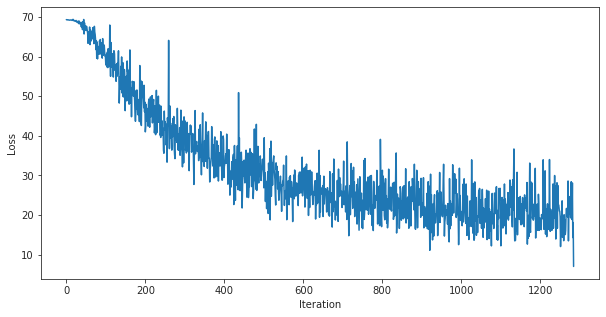

In [24]:
transform = transforms.Compose([Normalize(), ToTensor()])
dataset = TACDatasetClassification(DATASET_ID_TRAIN, tuples_train_classification)
data_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=lambda x: x)

neural_net_sinkhorn_pr_model = NeuralNetSinkhornPRModel(D_in, D_out).cuda()

criterion = nn.BCELoss()
optimizer = optim.SGD(neural_net_sinkhorn_pr_model.parameters(), lr=learning_rate)

loss = []

for batch in data_loader:
    L = 0.0
    
    for sample in batch:
        (d, s1, s2), y = transform(sample)
                
        L += criterion(neural_net_sinkhorn_pr_model(d, s1, s2), y)
        
        optimizer.step()
        
    loss.append(L.item())
    print(f'{loss[-1]:.4f}')
    
    optimizer.zero_grad()

    L.backward()
    
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
plot_loss(ax, loss)
plt.show()

In [25]:
torch.save(neural_net_sinkhorn_pr_model.state_dict(), os.path.join(MODELS_DIR, 'neural_net_sinkhorn_pr_model.pt'))

# Scoring

In [28]:
emb_dim = 768
D_in = 2 * emb_dim
H = 2 * D_in
scaling_factor = 1
learning_rate = 1e-4
batch_size = 100

class NeuralNetScoringPRModel(nn.Module):
    def __init__(self, D_in, H):
        super(NeuralNetScoringPRModel, self).__init__()
        self.layer1 = nn.Linear(D_in, H)
        self.layer2 = nn.Linear(H, 1)
        self.sigm = nn.Sigmoid()
    
    def predict(self, d, si):
        a0 = torch.cat((d, si), axis=0)
        z0 = self.layer1(a0)
        a1 = F.relu(z0)
        return self.layer2(a1)
    
    def score(self, d, s):
        return sum([self.predict(d, si) for si in s]).squeeze()
    
    def forward(self, d, s1, s2):
        d = d.mean(axis=0)
        return self.sigm(scaling_factor * (self.score(d, s1) - self.score(d, s2)))

D0810
D0847
D0815
D0807
D0839
D0835
D0841
D0812
D0831
D0821
D0825
D0804
D0839
D0831
D0823
D0846
D0827
D0810
D0847
D0809
D0826
D0822
D0847
D0835
D0841
D0823
D0841
D0807
D0817
D0844
D0812
D0813
D0831
D0810
D0818
D0809
D0809
D0827
D0823
D0829
D0829
D0831
D0804
D0821
D0809
D0810
D0827
D0802
D0829
D0802
D0846
D0843
D0805
D0844
D0815
D0817
D0846
D0810
D0822
D0813
D0829
D0847
D0846
D0848
D0817
D0813
D0847
D0843
D0831
D0835
D0821
D0831
D0812
D0825
D0831
D0812
D0804
D0831
D0839
D0826
D0810
D0824
D0821
D0839
D0815
D0820
D0805
D0810
D0824
D0847
D0809
D0843
D0823
D0823
D0820
D0812
D0846
D0845
D0802
D0825
0.682646
D0824
D0817
D0817
D0846
D0819
D0845
D0847
D0829
D0846
D0845
D0819
D0820
D0821
D0847
D0844
D0835
D0812
D0844
D0827
D0844
D0802
D0843
D0824
D0839
D0820
D0823
D0844
D0824
D0845
D0846
D0817
D0835
D0807
D0812
D0839
D0831
D0818
D0831
D0824
D0810
D0841
D0820
D0814
D0847
D0831
D0802
D0822
D0841
D0815
D0818
D0824
D0817
D0843
D0814
D0822
D0813
D0829
D0812
D0843
D0812
D0825
D0824
D0847
D0843
D0814
D

0.698066
D0819
D0815
D0817
D0802
D0824
D0839
D0812
D0844
D0812
D0814
D0820
D0809
D0825
D0848
D0817
D0829
D0804
D0819
D0805
D0828
D0810
D0820
D0826
D0810
D0821
D0819
D0822
D0814
D0810
D0810
D0822
D0843
D0835
D0828
D0839
D0826
D0839
D0823
D0822
D0820
D0819
D0827
D0831
D0802
D0829
D0845
D0828
D0825
D0822
D0809
D0814
D0804
D0822
D0843
D0809
D0828
D0834
D0818
D0804
D0809
D0843
D0831
D0835
D0818
D0820
D0804
D0829
D0839
D0804
D0812
D0846
D0843
D0813
D0848
D0818
D0845
D0834
D0821
D0804
D0829
D0845
D0821
D0839
D0825
D0829
D0807
D0805
D0834
D0829
D0841
D0823
D0831
D0802
D0814
D0829
D0834
D0815
D0828
D0826
D0829
0.681444
D0818
D0821
D0805
D0814
D0843
D0815
D0812
D0848
D0820
D0847
D0818
D0812
D0820
D0813
D0841
D0812
D0827
D0821
D0817
D0831
D0802
D0835
D0812
D0821
D0847
D0805
D0823
D0805
D0826
D0813
D0824
D0839
D0824
D0829
D0848
D0813
D0804
D0824
D0825
D0802
D0818
D0822
D0825
D0813
D0826
D0814
D0817
D0812
D0827
D0807
D0810
D0815
D0844
D0819
D0802
D0834
D0839
D0821
D0841
D0835
D0826
D0846
D0839
D082

0.617911
D0826
D0810
D0824
D0825
D0828
D0804
D0813
D0810
D0835
D0820
D0826
D0824
D0812
D0845
D0821
D0822
D0831
D0822
D0802
D0829
D0804
D0847
D0809
D0802
D0826
D0848
D0822
D0848
D0848
D0835
D0843
D0818
D0812
D0845
D0802
D0823
D0829
D0815
D0844
D0824
D0819
D0822
D0834
D0835
D0815
D0847
D0824
D0826
D0839
D0821
D0841
D0835
D0802
D0827
D0809
D0804
D0815
D0820
D0828
D0821
D0822
D0839
D0819
D0829
D0826
D0826
D0824
D0824
D0846
D0835
D0828
D0810
D0807
D0845
D0845
D0814
D0824
D0848
D0843
D0828
D0835
D0831
D0818
D0809
D0810
D0817
D0815
D0825
D0817
D0822
D0829
D0829
D0826
D0847
D0818
D0821
D0827
D0844
D0846
D0843
0.642845
D0823
D0807
D0825
D0819
D0813
D0839
D0805
D0814
D0827
D0802
D0809
D0841
D0829
D0819
D0831
D0844
D0819
D0809
D0825
D0804
D0843
D0825
D0824
D0815
D0835
D0824
D0815
D0844
D0835
D0843
D0826
D0839
D0805
D0817
D0814
D0822
D0828
D0810
D0825
D0829
D0844
D0848
D0835
D0823
D0807
D0845
D0845
D0825
D0835
D0834
D0817
D0844
D0807
D0848
D0829
D0848
D0812
D0828
D0820
D0827
D0805
D0825
D0822
D082

0.623372
D0817
D0814
D0815
D0843
D0813
D0829
D0846
D0834
D0823
D0825
D0802
D0844
D0844
D0831
D0817
D0846
D0828
D0831
D0809
D0826
D0834
D0843
D0825
D0819
D0848
D0843
D0819
D0824
D0810
D0805
D0821
D0823
D0825
D0841
D0845
D0845
D0824
D0810
D0828
D0823
D0839
D0810
D0813
D0820
D0828
D0802
D0826
D0831
D0813
D0847
D0818
D0823
D0818
D0845
D0845
D0822
D0802
D0817
D0848
D0826
D0825
D0810
D0844
D0848
D0831
D0813
D0818
D0822
D0821
D0802
D0819
D0827
D0826
D0819
D0827
D0825
D0818
D0809
D0817
D0813
D0843
D0825
D0823
D0810
D0802
D0807
D0810
D0841
D0817
D0835
D0839
D0814
D0825
D0804
D0802
D0847
D0812
D0814
D0810
D0846
0.662511
D0839
D0829
D0824
D0839
D0847
D0825
D0831
D0847
D0813
D0841
D0819
D0822
D0823
D0810
D0818
D0847
D0805
D0834
D0834
D0810
D0835
D0826
D0809
D0813
D0828
D0814
D0828
D0835
D0809
D0817
D0845
D0827
D0820
D0804
D0834
D0809
D0844
D0826
D0814
D0802
D0834
D0834
D0826
D0804
D0817
D0841
D0812
D0835
D0823
D0824
D0848
D0831
D0848
D0813
D0818
D0824
D0822
D0847
D0831
D0829
D0846
D0818
D0805
D082

0.589953
D0843
D0805
D0814
D0835
D0802
D0809
D0824
D0828
D0831
D0826
D0824
D0829
D0845
D0826
D0846
D0848
D0845
D0829
D0846
D0828
D0821
D0831
D0827
D0823
D0845
D0818
D0845
D0843
D0818
D0848
D0802
D0822
D0822
D0823
D0848
D0821
D0804
D0844
D0818
D0807
D0839
D0843
D0843
D0835
D0825
D0802
D0834
D0834
D0839
D0813
D0847
D0848
D0813
D0815
D0804
D0834
D0817
D0812
D0822
D0807
D0846
D0813
D0828
D0810
D0819
D0802
D0820
D0829
D0823
D0807
D0823
D0846
D0825
D0847
D0843
D0845
D0834
D0835
D0831
D0804
D0834
D0824
D0814
D0825
D0829
D0848
D0820
D0802
D0807
D0828
D0810
D0824
D0841
D0802
D0820
D0843
D0820
D0815
D0835
D0829
0.601004
D0825
D0813
D0802
D0802
D0835
D0844
D0827
D0807
D0804
D0828
D0812
D0828
D0845
D0824
D0822
D0834
D0818
D0831
D0841
D0847
D0844
D0829
D0825
D0821
D0843
D0844
D0828
D0843
D0829
D0834
D0828
D0831
D0826
D0821
D0846
D0810
D0804
D0823
D0802
D0812
D0824
D0804
D0822
D0802
D0847
D0819
D0817
D0843
D0817
D0835
D0831
D0834
D0835
D0807
D0802
D0807
D0835
D0809
D0810
D0804
D0809
D0824
D0819
D081

0.640055
D0826
D0831
D0823
D0814
D0810
D0807
D0846
D0815
D0841
D0807
D0807
D0826
D0827
D0824
D0831
D0823
D0809
D0815
D0841
D0807
D0828
D0821
D0823
D0815
D0821
D0812
D0845
D0835
D0828
D0813
D0813
D0810
D0807
D0834
D0804
D0809
D0804
D0813
D0835
D0844
D0815
D0824
D0846
D0841
D0823
D0823
D0817
D0843
D0810
D0813
D0810
D0819
D0845
D0802
D0846
D0845
D0826
D0822
D0814
D0820
D0810
D0827
D0844
D0843
D0839
D0814
D0809
D0848
D0825
D0815
D0829
D0818
D0847
D0834
D0848
D0844
D0812
D0825
D0828
D0831
D0843
D0843
D0810
D0843
D0839
D0805
D0834
D0807
D0847
D0839
D0826
D0820
D0824
D0810
D0823
D0822
D0843
D0809
D0826
D0843
0.603311
D0815
D0841
D0804
D0812
D0804
D0818
D0829
D0829
D0847
D0824
D0809
D0834
D0844
D0834
D0821
D0813
D0844
D0814
D0827
D0810
D0844
D0835
D0805
D0815
D0834
D0814
D0804
D0839
D0848
D0818
D0822
D0814
D0813
D0846
D0845
D0809
D0819
D0817
D0815
D0805
D0847
D0809
D0829
D0809
D0825
D0807
D0813
D0813
D0814
D0809
D0818
D0822
D0825
D0804
D0839
D0834
D0834
D0822
D0814
D0812
D0807
D0844
D0827
D080

0.594734
D0812
D0809
D0844
D0829
D0814
D0807
D0835
D0822
D0823
D0815
D0834
D0845
D0802
D0815
D0810
D0805
D0818
D0820
D0846
D0812
D0825
D0835
D0827
D0815
D0846
D0813
D0829
D0826
D0815
D0834
D0847
D0841
D0844
D0822
D0820
D0841
D0809
D0809
D0845
D0845
D0835
D0821
D0848
D0807
D0805
D0822
D0827
D0812
D0809
D0821
D0847
D0834
D0834
D0843
D0822
D0844
D0827
D0827
D0821
D0831
D0809
D0835
D0834
D0813
D0817
D0824
D0822
D0813
D0817
D0824
D0824
D0819
D0814
D0826
D0825
D0819
D0804
D0831
D0825
D0827
D0812
D0824
D0807
D0807
D0819
D0813
D0834
D0829
D0825
D0804
D0823
D0809
D0823
D0820
D0839
D0820
D0848
D0826
D0834
D0845
0.667124
D0841
D0823
D0804
D0810
D0844
D0843
D0847
D0813
D0846
D0829
D0821
D0831
D0827
D0820
D0805
D0843
D0844
D0825
D0825
D0826
D0846
D0846
D0819
D0835
D0818
D0812
D0820
D0839
D0818
D0834
D0818
D0818
D0804
D0843
D0813
D0841
D0819
D0826
D0834
D0827
D0804
D0841
D0815
D0828
D0817
D0821
D0817
D0813
D0817
D0824
D0812
D0841
D0810
D0846
D0822
D0802
D0805
D0813
D0822
D0829
D0805
D0847
D0829
D084

0.602665
D0827
D0818
D0827
D0805
D0810
D0817
D0841
D0820
D0829
D0839
D0826
D0829
D0807
D0839
D0825
D0839
D0848
D0824
D0819
D0846
D0846
D0834
D0828
D0807
D0822
D0813
D0810
D0839
D0821
D0834
D0831
D0817
D0827
D0848
D0843
D0831
D0847
D0813
D0818
D0843
D0802
D0807
D0813
D0829
D0815
D0815
D0818
D0821
D0819
D0819
D0829
D0839
D0826
D0805
D0802
D0821
D0813
D0809
D0819
D0818
D0835
D0810
D0820
D0819
D0814
D0810
D0848
D0824
D0807
D0831
D0818
D0823
D0843
D0807
D0826
D0847
D0831
D0826
D0831
D0834
D0847
D0802
D0848
D0841
D0825
D0834
D0802
D0834
D0841
D0824
D0814
D0802
D0802
D0826
D0828
D0844
D0828
D0804
D0807
D0822
0.611101
D0845
D0831
D0848
D0826
D0802
D0814
D0817
D0844
D0846
D0846
D0823
D0809
D0804
D0810
D0835
D0815
D0807
D0835
D0820
D0831
D0847
D0844
D0815
D0813
D0812
D0823
D0813
D0817
D0829
D0827
D0848
D0848
D0846
D0812
D0818
D0843
D0823
D0827
D0812
D0846
D0843
D0815
D0839
D0829
D0827
D0845
D0843
D0822
D0815
D0809
D0827
D0819
D0818
D0814
D0805
D0844
D0846
D0846
D0834
D0843
D0831
D0817
D0812
D082

0.581314
D0843
D0815
D0821
D0848
D0841
D0807
D0848
D0812
D0831
D0827
D0827
D0844
D0812
D0835
D0812
D0834
D0825
D0815
D0829
D0805
D0822
D0828
D0845
D0845
D0848
D0826
D0847
D0817
D0819
D0802
D0831
D0818
D0828
D0829
D0809
D0807
D0822
D0825
D0828
D0802
D0815
D0848
D0846
D0804
D0802
D0828
D0825
D0826
D0815
D0827
D0802
D0825
D0829
D0831
D0826
D0813
D0828
D0826
D0829
D0813
D0827
D0827
D0814
D0821
D0828
D0822
D0822
D0828
D0821
D0835
D0825
D0834
D0814
D0829
D0834
D0824
D0848
D0843
D0848
D0848
D0826
D0846
D0813
D0807
D0839
D0839
D0809
D0839
D0823
D0828
D0807
D0814
D0841
D0813
D0841
D0814
D0848
D0805
D0813
D0820
0.594437
D0807
D0809
D0810
D0814
D0835
D0831
D0848
D0848
D0814
D0821
D0843
D0820
D0815
D0815
D0814
D0844
D0841
D0845
D0819
D0835
D0846
D0815
D0823
D0820
D0817
D0810
D0813
D0804
D0814
D0802
D0810
D0831
D0815
D0813
D0846
D0839
D0835
D0831
D0819
D0835
D0847
D0805
D0847
D0824
D0813
D0844
D0812
D0804
D0844
D0804
D0848
D0815
D0821
D0809
D0839
D0829
D0843
D0848
D0802
D0829
D0835
D0824
D0825
D083

0.549606
D0818
D0831
D0846
D0847
D0831
D0818
D0843
D0817
D0822
D0846
D0831
D0823
D0807
D0834
D0805
D0807
D0835
D0828
D0810
D0804
D0805
D0828
D0824
D0819
D0834
D0822
D0812
D0848
D0829
D0810
D0834
D0846
D0848
D0809
D0807
D0809
D0848
D0844
D0813
D0802
D0834
D0839
D0819
D0844
D0815
D0826
D0841
D0841
D0824
D0812
D0821
D0828
D0805
D0805
D0825
D0846
D0823
D0805
D0824
D0812
D0841
D0807
D0822
D0845
D0827
D0825
D0812
D0845
D0847
D0812
D0826
D0807
D0807
D0810
D0829
D0813
D0825
D0809
D0814
D0848
D0823
D0807
D0835
D0834
D0847
D0817
D0835
D0843
D0820
D0802
D0826
D0817
D0814
D0823
D0825
D0818
D0829
D0843
D0825
D0828
0.588960
D0848
D0827
D0807
D0812
D0817
D0818
D0829
D0828
D0805
D0802
D0844
D0822
D0843
D0834
D0825
D0828
D0843
D0847
D0814
D0846
D0823
D0807
D0835
D0802
D0815
D0825
D0845
D0841
D0814
D0826
D0847
D0810
D0824
D0843
D0834
D0815
D0831
D0824
D0809
D0813
D0835
D0823
D0846
D0817
D0835
D0844
D0805
D0826
D0826
D0825
D0841
D0844
D0814
D0835
D0835
D0813
D0843
D0831
D0846
D0814
D0804
D0812
D0826
D080

0.558200
D0805
D0810
D0846
D0846
D0812
D0824
D0805
D0809
D0829
D0814
D0831
D0841
D0829
D0807
D0843
D0847
D0839
D0846
D0846
D0845
D0819
D0804
D0814
D0827
D0839
D0846
D0848
D0821
D0812
D0813
D0839
D0823
D0835
D0847
D0845
D0819
D0818
D0814
D0820
D0841
D0813
D0809
D0810
D0834
D0848
D0809
D0807
D0818
D0812
D0812
D0818
D0824
D0805
D0844
D0844
D0831
D0839
D0828
D0839
D0845
D0841
D0818
D0831
D0818
D0825
D0831
D0810
D0815
D0824
D0820
D0805
D0802
D0821
D0828
D0845
D0810
D0834
D0828
D0822
D0826
D0815
D0820
D0805
D0802
D0802
D0826
D0821
D0848
D0815
D0828
D0825
D0834
D0844
D0829
D0848
D0848
D0810
D0804
D0826
D0841
0.605416
D0820
D0814
D0819
D0827
D0844
D0805
D0804
D0845
D0819
D0812
D0841
D0810
D0814
D0829
D0814
D0834
D0827
D0844
D0815
D0814
D0802
D0828
D0847
D0802
D0822
D0810
D0812
D0802
D0829
D0809
D0841
D0818
D0834
D0810
D0847
D0827
D0815
D0814
D0815
D0805
D0835
D0819
D0844
D0826
D0807
D0821
D0818
D0828
D0841
D0818
D0834
D0805
D0815
D0829
D0843
D0820
D0810
D0841
D0818
D0831
D0809
D0831
D0820
D082

0.571613
D0839
D0804
D0821
D0819
D0839
D0824
D0841
D0831
D0812
D0818
D0818
D0817
D0825
D0828
D0848
D0815
D0812
D0820
D0815
D0848
D0813
D0820
D0809
D0817
D0845
D0802
D0812
D0839
D0804
D0815
D0804
D0834
D0804
D0846
D0834
D0817
D0817
D0826
D0824
D0817
D0822
D0822
D0831
D0845
D0846
D0829
D0829
D0843
D0829
D0839
D0846
D0810
D0823
D0847
D0829
D0824
D0844
D0828
D0824
D0805
D0814
D0844
D0839
D0807
D0835
D0848
D0835
D0824
D0845
D0817
D0805
D0825
D0815
D0844
D0810
D0812
D0821
D0820
D0817
D0817
D0835
D0839
D0824
D0847
D0819
D0828
D0827
D0831
D0846
D0841
D0834
D0815
D0802
D0827
D0818
D0817
D0845
D0829
D0815
D0829
0.591490
D0848
D0824
D0848
D0834
D0827
D0805
D0817
D0835
D0807
D0831
D0844
D0802
D0812
D0813
D0829
D0824
D0829
D0814
D0817
D0825
D0825
D0819
D0804
D0848
D0823
D0844
D0848
D0825
D0829
D0817
D0827
D0829
D0807
D0846
D0821
D0835
D0835
D0825
D0843
D0822
D0817
D0810
D0839
D0828
D0819
D0828
D0848
D0804
D0843
D0805
D0829
D0814
D0810
D0809
D0835
D0804
D0821
D0817
D0845
D0805
D0826
D0848
D0843
D083

0.569400
D0839
D0822
D0826
D0835
D0846
D0827
D0809
D0847
D0845
D0807
D0844
D0807
D0834
D0826
D0820
D0813
D0817
D0821
D0804
D0802
D0819
D0821
D0809
D0831
D0815
D0807
D0846
D0841
D0835
D0831
D0845
D0839
D0839
D0813
D0822
D0846
D0844
D0821
D0839
D0843
D0839
D0804
D0810
D0819
D0822
D0828
D0844
D0824
D0821
D0841
D0814
D0813
D0823
D0845
D0824
D0805
D0819
D0845
D0821
D0820
D0822
D0824
D0848
D0846
D0812
D0819
D0822
D0815
D0844
D0817
D0846
D0814
D0821
D0841
D0848
D0848
D0818
D0843
D0828
D0821
D0814
D0846
D0802
D0814
D0804
D0848
D0822
D0834
D0845
D0839
D0809
D0843
D0831
D0847
D0827
D0802
D0845
D0820
D0825
D0822
0.598073
D0843
D0844
D0822
D0810
D0809
D0847
D0845
D0817
D0813
D0814
D0820
D0822
D0845
D0807
D0807
D0823
D0835
D0807
D0804
D0848
D0847
D0846
D0825
D0845
D0805
D0819
D0823
D0826
D0848
D0805
D0827
D0834
D0805
D0805
D0820
D0839
D0831
D0824
D0822
D0831
D0814
D0841
D0844
D0815
D0812
D0813
D0824
D0812
D0818
D0802
D0843
D0825
D0846
D0821
D0814
D0835
D0847
D0834
D0819
D0848
D0831
D0812
D0815
D082

0.570976
D0818
D0844
D0822
D0831
D0841
D0844
D0845
D0846
D0822
D0802
D0802
D0843
D0820
D0813
D0809
D0802
D0812
D0834
D0835
D0846
D0820
D0815
D0844
D0827
D0843
D0821
D0828
D0804
D0812
D0815
D0848
D0835
D0805
D0835
D0828
D0841
D0834
D0818
D0819
D0821
D0815
D0841
D0817
D0815
D0815
D0823
D0812
D0810
D0829
D0813
D0815
D0827
D0810
D0843
D0828
D0812
D0825
D0827
D0839
D0828
D0813
D0809
D0822
D0802
D0817
D0810
D0818
D0844
D0841
D0812
D0844
D0810
D0814
D0815
D0813
D0841
D0814
D0804
D0831
D0825
D0834
D0834
D0829
D0835
D0823
D0847
D0841
D0809
D0820
D0825
D0805
D0825
D0815
D0813
D0834
D0814
D0834
D0831
D0827
D0835
0.606713
D0829
D0847
D0843
D0828
D0839
D0841
D0848
D0848
D0802
D0839
D0831
D0847
D0820
D0821
D0844
D0819
D0802
D0835
D0828
D0844
D0807
D0826
D0822
D0820
D0843
D0845
D0831
D0841
D0823
D0847
D0839
D0804
D0824
D0825
D0817
D0826
D0831
D0835
D0822
D0802
D0809
D0817
D0822
D0831
D0834
D0846
D0820
D0823
D0829
D0809
D0819
D0828
D0828
D0814
D0805
D0848
D0817
D0823
D0802
D0812
D0845
D0812
D0826
D081

0.547202
D0847
D0843
D0823
D0841
D0827
D0834
D0812
D0815
D0802
D0844
D0831
D0810
D0812
D0821
D0815
D0844
D0815
D0835
D0823
D0844
D0815
D0828
D0805
D0824
D0810
D0810
D0802
D0839
D0809
D0818
D0802
D0831
D0827
D0817
D0827
D0829
D0821
D0824
D0834
D0818
D0805
D0834
D0845
D0819
D0847
D0831
D0807
D0824
D0817
D0825
D0835
D0823
D0848
D0812
D0846
D0805
D0845
D0809
D0802
D0825
D0817
D0822
D0848
D0817
D0817
D0829
D0817
D0825
D0823
D0824
D0839
D0846
D0827
D0807
D0809
D0823
D0824
D0824
D0829
D0814
D0819
D0845
D0820
D0817
D0835
D0831
D0835
D0820
D0809
D0844
D0845
D0835
D0818
D0822
D0822
D0843
D0846
D0827
D0817
D0848
0.546316
D0829
D0817
D0817
D0847
D0822
D0805
D0835
D0804
D0846
D0818
D0829
D0818
D0841
D0848
D0843
D0829
D0845
D0831
D0818
D0826
D0847
D0805
D0814
D0825
D0847
D0819
D0802
D0825
D0834
D0841
D0805
D0841
D0844
D0815
D0823
D0814
D0831
D0839
D0827
D0821
D0823
D0802
D0826
D0827
D0834
D0807
D0809
D0845
D0814
D0822
D0835
D0810
D0817
D0815
D0828
D0841
D0846
D0845
D0823
D0825
D0823
D0825
D0827
D084

0.609011
D0847
D0844
D0823
D0843
D0835
D0812
D0814
D0846
D0846
D0835
D0847
D0817
D0829
D0804
D0812
D0823
D0822
D0814
D0834
D0844
D0822
D0802
D0820
D0805
D0805
D0804
D0813
D0848
D0839
D0815
D0809
D0844
D0841
D0819
D0802
D0844
D0845
D0847
D0822
D0844
D0848
D0826
D0812
D0839
D0835
D0815
D0814
D0831
D0807
D0827
D0819
D0843
D0822
D0841
D0812
D0843
D0804
D0847
D0818
D0810
D0809
D0823
D0821
D0822
D0827
D0839
D0839
D0813
D0815
D0848
D0812
D0831
D0802
D0807
D0848
D0805
D0804
D0847
D0802
D0839
D0807
D0844
D0831
D0819
D0823
D0819
D0821
D0826
D0819
D0804
D0834
D0829
D0824
D0827
D0829
D0834
D0813
D0819
D0810
D0846
0.524036
D0843
D0847
D0817
D0821
D0812
D0847
D0824
D0819
D0846
D0841
D0809
D0820
D0804
D0834
D0843
D0825
D0839
D0815
D0821
D0847
D0802
D0810
D0813
D0835
D0809
D0823
D0824
D0807
D0810
D0828
D0817
D0809
D0847
D0839
D0818
D0809
D0824
D0843
D0846
D0834
D0813
D0826
D0802
D0814
D0834
D0802
D0818
D0819
D0824
D0845
D0831
D0827
D0835
D0843
D0802
D0844
D0827
D0820
D0813
D0847
D0835
D0835
D0848
D081

0.575487
D0827
D0845
D0824
D0823
D0847
D0845
D0825
D0819
D0804
D0812
D0831
D0843
D0834
D0827
D0828
D0822
D0820
D0814
D0804
D0819
D0807
D0825
D0848
D0818
D0827
D0804
D0822
D0805
D0818
D0848
D0848
D0819
D0818
D0818
D0814
D0809
D0818
D0818
D0805
D0847
D0839
D0802
D0814
D0810
D0831
D0835
D0829
D0821
D0847
D0841
D0847
D0834
D0819
D0817
D0820
D0824
D0813
D0825
D0819
D0810
D0821
D0818
D0843
D0809
D0846
D0805
D0815
D0848
D0828
D0820
D0847
D0820
D0843
D0839
D0823
D0825
D0828
D0828
D0818
D0815
D0835
D0834
D0841
D0845
D0822
D0809
D0813
D0823
D0839
D0812
D0809
D0819
D0820
D0817
D0814
D0839
D0804
D0834
D0847
D0831
0.576405
D0825
D0804
D0843
D0807
D0807
D0847
D0835
D0817
D0835
D0817
D0824
D0845
D0839
D0841
D0844
D0820
D0826
D0829
D0843
D0844
D0813
D0826
D0823
D0815
D0827
D0820
D0804
D0827
D0834
D0826
D0817
D0804
D0804
D0835
D0846
D0845
D0831
D0818
D0848
D0843
D0827
D0846
D0824
D0825
D0828
D0845
D0843
D0813
D0815
D0831
D0805
D0847
D0809
D0828
D0825
D0804
D0809
D0817
D0848
D0844
D0823
D0821
D0845
D081

0.477637
D0845
D0843
D0823
D0817
D0828
D0826
D0841
D0812
D0839
D0812
D0843
D0817
D0819
D0831
D0815
D0804
D0818
D0848
D0810
D0820
D0802
D0813
D0823
D0847
D0841
D0821
D0821
D0839
D0844
D0831
D0841
D0815
D0843
D0835
D0813
D0831
D0813
D0820
D0831
D0813
D0829
D0828
D0810
D0818
D0848
D0847
D0835
D0821
D0831
D0847
D0815
D0812
D0819
D0802
D0847
D0814
D0844
D0812
D0804
D0828
D0825
D0815
D0825
D0810
D0822
D0813
D0822
D0818
D0845
D0834
D0802
D0815
D0848
D0846
D0815
D0829
D0839
D0809
D0817
D0831
D0815
D0822
D0827
D0819
D0848
D0802
D0805
D0821
D0809
D0848
D0839
D0817
D0829
D0839
D0813
D0814
D0824
D0825
D0819
D0817
0.537461
D0824
D0839
D0826
D0841
D0814
D0841
D0804
D0835
D0841
D0810
D0834
D0821
D0813
D0805
D0848
D0845
D0822
D0843
D0848
D0810
D0819
D0823
D0845
D0821
D0841
D0824
D0823
D0848
D0814
D0839
D0831
D0807
D0828
D0826
D0814
D0848
D0809
D0823
D0810
D0835
D0825
D0815
D0828
D0813
D0831
D0819
D0827
D0829
D0817
D0822
D0846
D0802
D0818
D0813
D0846
D0847
D0835
D0819
D0818
D0835
D0817
D0831
D0804
D082

0.518089
D0824
D0825
D0810
D0823
D0829
D0847
D0821
D0804
D0846
D0814
D0847
D0843
D0819
D0847
D0845
D0844
D0847
D0824
D0826
D0825
D0845
D0810
D0809
D0825
D0815
D0826
D0835
D0823
D0835
D0831
D0805
D0802
D0820
D0822
D0847
D0804
D0841
D0843
D0805
D0820
D0846
D0825
D0809
D0807
D0817
D0825
D0821
D0817
D0812
D0843
D0812
D0847
D0815
D0802
D0812
D0810
D0825
D0802
D0831
D0845
D0825
D0815
D0848
D0823
D0835
D0844
D0807
D0848
D0815
D0834
D0814
D0805
D0814
D0817
D0813
D0841
D0826
D0822
D0819
D0807
D0825
D0812
D0819
D0828
D0817
D0812
D0818
D0817
D0847
D0819
D0821
D0815
D0827
D0813
D0848
D0805
D0848
D0805
D0827
D0824
0.594780
D0807
D0818
D0813
D0824
D0846
D0821
D0821
D0835
D0829
D0805
D0828
D0812
D0846
D0828
D0848
D0804
D0831
D0817
D0804
D0817
D0847
D0843
D0822
D0848
D0839
D0819
D0834
D0834
D0827
D0817
D0827
D0834
D0826
D0843
D0843
D0819
D0825
D0807
D0828
D0824
D0835
D0824
D0845
D0822
D0829
D0827
D0843
D0839
D0825
D0824
D0825
D0812
D0814
D0845
D0815
D0834
D0841
D0829
D0821
D0804
D0821
D0831
D0829
D082

0.517909
D0826
D0810
D0810
D0809
D0843
D0841
D0839
D0826
D0804
D0834
D0810
D0823
D0824
D0823
D0814
D0846
D0809
D0845
D0843
D0824
D0843
D0831
D0824
D0825
D0809
D0843
D0804
D0821
D0823
D0828
D0834
D0846
D0831
D0848
D0810
D0825
D0822
D0807
D0823
D0820
D0817
D0821
D0821
D0834
D0820
D0835
D0805
D0815
D0839
D0805
D0809
D0847
D0835
D0814
D0810
D0804
D0822
D0841
D0834
D0828
D0823
D0843
D0814
D0828
D0810
D0823
D0805
D0845
D0802
D0844
D0845
D0826
D0847
D0815
D0843
D0846
D0829
D0802
D0819
D0813
D0815
D0848
D0828
D0821
D0844
D0848
D0819
D0820
D0825
D0807
D0822
D0805
D0810
D0824
D0831
D0839
D0802
D0821
D0804
D0805
0.563406
D0831
D0825
D0809
D0821
D0841
D0847
D0826
D0813
D0826
D0831
D0824
D0835
D0821
D0821
D0827
D0802
D0847
D0834
D0848
D0812
D0812
D0810
D0819
D0810
D0810
D0839
D0812
D0818
D0823
D0817
D0818
D0807
D0835
D0810
D0834
D0818
D0827
D0815
D0823
D0810
D0824
D0821
D0823
D0828
D0818
D0812
D0848
D0826
D0822
D0845
D0802
D0844
D0814
D0829
D0810
D0834
D0821
D0846
D0807
D0848
D0802
D0846
D0823
D084

0.528889
D0831
D0826
D0827
D0839
D0813
D0820
D0829
D0829
D0820
D0846
D0834
D0844
D0848
D0843
D0813
D0831
D0812
D0839
D0807
D0819
D0847
D0847
D0820
D0845
D0835
D0848
D0814
D0818
D0825
D0814
D0847
D0834
D0815
D0848
D0809
D0812
D0845
D0824
D0847
D0844
D0825
D0847
D0826
D0843
D0834
D0822
D0805
D0841
D0834
D0828
D0817
D0846
D0834
D0848
D0823
D0825
D0812
D0818
D0826
D0810
D0844
D0809
D0820
D0819
D0804
D0805
D0848
D0844
D0844
D0818
D0824
D0827
D0810
D0820
D0822
D0834
D0847
D0839
D0843
D0817
D0846
D0848
D0829
D0831
D0848
D0819
D0814
D0810
D0841
D0813
D0841
D0810
D0825
D0822
D0819
D0809
D0844
D0841
D0809
D0810
0.491696
D0822
D0846
D0805
D0848
D0848
D0826
D0813
D0846
D0810
D0847
D0823
D0831
D0807
D0824
D0825
D0835
D0817
D0834
D0839
D0844
D0841
D0834
D0846
D0829
D0818
D0818
D0813
D0843
D0820
D0828
D0847
D0818
D0821
D0841
D0805
D0815
D0818
D0804
D0807
D0839
D0823
D0829
D0814
D0827
D0844
D0848
D0845
D0819
D0809
D0802
D0828
D0847
D0814
D0813
D0846
D0825
D0844
D0848
D0827
D0805
D0848
D0823
D0839
D082

0.612680
D0815
D0829
D0823
D0825
D0810
D0812
D0810
D0831
D0839
D0827
D0848
D0844
D0825
D0802
D0847
D0823
D0846
D0804
D0819
D0834
D0813
D0819
D0825
D0827
D0802
D0820
D0834
D0815
D0841
D0834
D0829
D0843
D0804
D0818
D0820
D0815
D0835
D0820
D0841
D0844
D0824
D0844
D0821
D0839
D0812
D0814
D0843
D0817
D0827
D0807
D0820
D0804
D0804
D0846
D0817
D0844
D0827
D0847
D0827
D0846
D0802
D0804
D0834
D0818
D0845
D0821
D0843
D0847
D0805
D0812
D0805
D0824
D0845
D0835
D0841
D0802
D0845
D0819
D0819
D0812
D0828
D0812
D0807
D0817
D0823
D0845
D0825
D0820
D0843
D0825
D0814
D0813
D0809
D0827
D0818
D0820
D0809
D0846
D0847
D0823
0.554434
D0848
D0814
D0807
D0805
D0821
D0835
D0835
D0839
D0812
D0824
D0804
D0824
D0825
D0845
D0835
D0818
D0834
D0825
D0843
D0843
D0826
D0818
D0831
D0831
D0804
D0815
D0835
D0812
D0802
D0822
D0841
D0841
D0818
D0831
D0829
D0818
D0847
D0847
D0821
D0817
D0805
D0824
D0844
D0825
D0821
D0841
D0826
D0839
D0825
D0834
D0818
D0841
D0814
D0845
D0823
D0825
D0826
D0815
D0848
D0819
D0818
D0812
D0829
D084

0.583183
D0826
D0812
D0841
D0825
D0835
D0827
D0831
D0843
D0835
D0823
D0814
D0802
D0827
D0819
D0843
D0835
D0824
D0845
D0822
D0823
D0814
D0835
D0821
D0835
D0844
D0810
D0809
D0819
D0807
D0848
D0828
D0834
D0846
D0827
D0809
D0829
D0835
D0823
D0843
D0829
D0834
D0828
D0821
D0817
D0802
D0809
D0839
D0821
D0829
D0829
D0824
D0839
D0802
D0817
D0827
D0843
D0823
D0802
D0829
D0846
D0848
D0841
D0819
D0822
D0823
D0817
D0818
D0812
D0839
D0845
D0812
D0814
D0812
D0834
D0812
D0834
D0802
D0822
D0848
D0825
D0848
D0818
D0848
D0813
D0810
D0841
D0804
D0829
D0821
D0841
D0807
D0844
D0812
D0810
D0817
D0812
D0839
D0807
D0846
D0821
0.517357
D0828
D0805
D0847
D0828
D0846
D0831
D0817
D0810
D0812
D0807
D0841
D0813
D0807
D0848
D0809
D0847
D0804
D0822
D0848
D0839
D0810
D0821
D0839
D0807
D0809
D0827
D0804
D0818
D0810
D0821
D0810
D0826
D0823
D0815
D0845
D0817
D0824
D0841
D0846
D0843
D0831
D0824
D0841
D0825
D0827
D0825
D0810
D0831
D0827
D0848
D0845
D0829
D0831
D0821
D0817
D0802
D0824
D0802
D0805
D0822
D0802
D0812
D0831
D082

0.557109
D0810
D0826
D0805
D0822
D0845
D0843
D0843
D0845
D0848
D0815
D0835
D0825
D0847
D0805
D0843
D0844
D0839
D0824
D0809
D0821
D0835
D0835
D0819
D0845
D0805
D0817
D0804
D0825
D0821
D0841
D0802
D0802
D0805
D0827
D0844
D0810
D0843
D0805
D0821
D0804
D0815
D0820
D0835
D0809
D0821
D0841
D0846
D0843
D0807
D0835
D0818
D0812
D0810
D0819
D0829
D0835
D0805
D0804
D0821
D0843
D0819
D0844
D0805
D0817
D0847
D0812
D0814
D0807
D0827
D0845
D0805
D0809
D0802
D0843
D0831
D0821
D0843
D0827
D0847
D0834
D0817
D0835
D0829
D0819
D0831
D0804
D0826
D0831
D0819
D0825
D0825
D0813
D0804
D0839
D0823
D0802
D0804
D0831
D0827
D0847
0.586234
D0813
D0815
D0846
D0820
D0826
D0835
D0827
D0810
D0835
D0848
D0841
D0829
D0825
D0805
D0817
D0826
D0815
D0844
D0843
D0844
D0813
D0828
D0841
D0829
D0827
D0829
D0846
D0814
D0813
D0848
D0848
D0810
D0823
D0819
D0844
D0828
D0802
D0818
D0846
D0824
D0824
D0825
D0819
D0828
D0834
D0813
D0807
D0835
D0841
D0847
D0802
D0817
D0805
D0802
D0826
D0847
D0847
D0812
D0839
D0802
D0845
D0829
D0812
D082

D0809
D0835
0.497778
D0810
D0835
D0820
D0820
D0828
D0815
D0820
D0817
D0819
D0825
D0818
D0809
D0815
D0829
D0846
D0819
D0815
D0813
D0846
D0823
D0828
D0847
D0831
D0844
D0807
D0823
D0815
D0821
D0839
D0835
D0809
D0812
D0810
D0848
D0818
D0809
D0810
D0809
D0802
D0843
D0817
D0813
D0839
D0823
D0843
D0813
D0818
D0813
D0815
D0848
D0841
D0820
D0823
D0822
D0848
D0829
D0831
D0809
D0813
D0845
D0823
D0844
D0817
D0831
D0825
D0812
D0822
D0825
D0809
D0828
D0813
D0822
D0809
D0844
D0819
D0813
D0834
D0835
D0814
D0829
D0839
D0810
D0846
D0804
D0802
D0818
D0847
D0827
D0822
D0824
D0841
D0819
D0826
D0821
D0845
D0826
D0818
D0805
D0820
D0810
0.568136
D0839
D0845
D0835
D0819
D0802
D0827
D0841
D0831
D0826
D0804
D0845
D0828
D0831
D0845
D0828
D0823
D0825
D0815
D0815
D0825
D0828
D0812
D0813
D0805
D0809
D0817
D0848
D0815
D0820
D0814
D0804
D0844
D0846
D0810
D0815
D0844
D0835
D0843
D0820
D0818
D0847
D0820
D0834
D0807
D0820
D0846
D0829
D0835
D0810
D0822
D0814
D0817
D0807
D0817
D0802
D0825
D0810
D0820
D0846
D0843
D0813
D082

0.557535
D0828
D0814
D0825
D0822
D0824
D0827
D0813
D0829
D0828
D0804
D0820
D0847
D0804
D0828
D0822
D0843
D0807
D0818
D0810
D0805
D0821
D0819
D0804
D0814
D0847
D0807
D0825
D0822
D0846
D0831
D0828
D0843
D0813
D0828
D0815
D0846
D0819
D0817
D0828
D0846
D0834
D0844
D0809
D0810
D0815
D0805
D0818
D0839
D0812
D0813
D0839
D0822
D0815
D0843
D0810
D0828
D0834
D0820
D0829
D0813
D0815
D0839
D0843
D0831
D0843
D0809
D0822
D0844
D0843
D0804
D0814
D0805
D0804
D0846
D0844
D0827
D0829
D0815
D0815
D0824
D0826
D0818
D0845
D0835
D0823
D0819
D0807
D0804
D0835
D0813
D0841
D0834
D0828
D0807
D0813
D0828
D0818
D0819
D0807
D0815
0.465083
D0843
D0844
D0845
D0826
D0812
D0809
D0805
D0804
D0809
D0810
D0819
D0827
D0839
D0829
D0834
D0814
D0820
D0817
D0824
D0846
D0822
D0844
D0819
D0831
D0824
D0846
D0821
D0817
D0815
D0828
D0841
D0802
D0812
D0804
D0822
D0846
D0847
D0807
D0828
D0821
D0835
D0819
D0814
D0822
D0805
D0831
D0829
D0847
D0810
D0826
D0828
D0841
D0831
D0821
D0814
D0843
D0829
D0820
D0846
D0804
D0809
D0819
D0831
D084

0.620104
D0819
D0844
D0812
D0822
D0807
D0823
D0825
D0822
D0809
D0812
D0821
D0835
D0821
D0828
D0820
D0814
D0817
D0841
D0828
D0807
D0810
D0807
D0823
D0802
D0807
D0843
D0807
D0804
D0831
D0847
D0823
D0829
D0822
D0823
D0829
D0831
D0807
D0848
D0834
D0841
D0807
D0824
D0818
D0818
D0826
D0826
D0817
D0844
D0831
D0834
D0819
D0807
D0831
D0834
D0819
D0822
D0805
D0843
D0820
D0812
D0824
D0805
D0846
D0815
D0825
D0817
D0824
D0804
D0809
D0814
D0807
D0831
D0845
D0839
D0825
D0813
D0805
D0824
D0827
D0810
D0823
D0841
D0821
D0819
D0819
D0843
D0835
D0829
D0809
D0818
D0824
D0847
D0820
D0802
D0823
D0831
D0845
D0822
D0825
D0820
0.518581
D0820
D0845
D0815
D0844
D0847
D0818
D0843
D0834
D0845
D0835
D0810
D0843
D0810
D0810
D0823
D0813
D0831
D0823
D0847
D0810
D0834
D0843
D0845
D0814
D0826
D0826
D0846
D0805
D0829
D0804
D0810
D0825
D0818
D0847
D0826
D0817
D0812
D0802
D0831
D0807
D0815
D0845
D0844
D0825
D0804
D0818
D0826
D0805
D0815
D0826
D0807
D0819
D0839
D0831
D0844
D0839
D0843
D0845
D0817
D0804
D0807
D0847
D0821
D082

0.507901
D0848
D0828
D0844
D0805
D0814
D0844
D0813
D0809
D0843
D0802
D0834
D0839
D0845
D0841
D0819
D0815
D0839
D0846
D0846
D0802
D0844
D0819
D0828
D0819
D0810
D0825
D0822
D0804
D0813
D0812
D0844
D0810
D0826
D0826
D0844
D0813
D0848
D0814
D0809
D0813
D0809
D0839
D0825
D0819
D0825
D0809
D0835
D0818
D0835
D0839
D0810
D0804
D0813
D0831
D0805
D0846
D0828
D0818
D0819
D0802
D0820
D0841
D0822
D0819
D0846
D0821
D0815
D0805
D0845
D0823
D0812
D0807
D0835
D0809
D0815
D0822
D0805
D0807
D0843
D0831
D0821
D0841
D0845
D0815
D0815
D0822
D0846
D0802
D0822
D0846
D0826
D0805
D0843
D0820
D0826
D0822
D0814
D0817
D0820
D0826
0.528813
D0815
D0819
D0828
D0843
D0819
D0814
D0828
D0828
D0822
D0844
D0824
D0812
D0825
D0813
D0841
D0847
D0804
D0844
D0825
D0839
D0839
D0821
D0812
D0802
D0812
D0848
D0828
D0826
D0813
D0805
D0804
D0810
D0835
D0826
D0804
D0812
D0809
D0802
D0825
D0805
D0822
D0834
D0818
D0810
D0824
D0805
D0823
D0810
D0819
D0815
D0846
D0814
D0848
D0810
D0813
D0845
D0819
D0820
D0807
D0847
D0845
D0835
D0818
D080

0.578703
D0834
D0822
D0846
D0804
D0820
D0844
D0846
D0809
D0848
D0812
D0809
D0821
D0813
D0805
D0820
D0824
D0809
D0802
D0827
D0819
D0809
D0848
D0845
D0848
D0821
D0829
D0819
D0819
D0835
D0835
D0847
D0828
D0824
D0824
D0807
D0826
D0820
D0819
D0835
D0821
D0821
D0829
D0810
D0823
D0814
D0804
D0805
D0826
D0820
D0820
D0820
D0810
D0812
D0848
D0810
D0820
D0814
D0824
D0814
D0822
D0813
D0821
D0823
D0807
D0824
D0809
D0812
D0845
D0827
D0810
D0817
D0822
D0827
D0848
D0845
D0829
D0810
D0802
D0826
D0848
D0826
D0820
D0825
D0826
D0845
D0810
D0804
D0810
D0827
D0841
D0804
D0844
D0822
D0809
D0845
D0818
D0802
D0835
D0843
D0805
0.579627
D0804
D0822
D0822
D0829
D0845
D0818
D0831
D0813
D0835
D0828
D0831
D0813
D0835
D0827
D0820
D0845
D0834
D0809
D0824
D0828
D0825
D0810
D0846
D0846
D0820
D0810
D0845
D0807
D0819
D0822
D0810
D0831
D0812
D0823
D0813
D0820
D0812
D0834
D0847
D0820
D0810
D0807
D0829
D0804
D0827
D0822
D0835
D0813
D0841
D0843
D0807
D0824
D0818
D0841
D0829
D0815
D0828
D0848
D0834
D0839
D0834
D0823
D0826
D081

0.561889
D0847
D0824
D0839
D0829
D0828
D0814
D0844
D0813
D0846
D0809
D0823
D0821
D0825
D0804
D0828
D0813
D0810
D0802
D0805
D0825
D0822
D0819
D0819
D0844
D0820
D0812
D0822
D0826
D0819
D0825
D0818
D0824
D0844
D0805
D0834
D0807
D0839
D0821
D0824
D0823
D0844
D0812
D0839
D0828
D0834
D0848
D0824
D0807
D0846
D0841
D0846
D0827
D0813
D0834
D0809
D0822
D0802
D0810
D0835
D0802
D0815
D0814
D0805
D0822
D0817
D0844
D0841
D0821
D0820
D0845
D0844
D0825
D0809
D0831
D0819
D0815
D0843
D0807
D0831
D0828
D0819
D0835
D0804
D0809
D0821
D0813
D0831
D0823
D0819
D0815
D0831
D0828
D0831
D0839
D0809
D0817
D0824
D0826
D0820
D0839
0.567202
D0827
D0843
D0828
D0827
D0810
D0821
D0843
D0818
D0812
D0807
D0813
D0810
D0827
D0807
D0804
D0843
D0802
D0805
D0809
D0820
D0819
D0834
D0845
D0829
D0824
D0807
D0802
D0821
D0812
D0818
D0809
D0845
D0823
D0804
D0825
D0831
D0834
D0846
D0828
D0819
D0815
D0828
D0810
D0804
D0814
D0835
D0834
D0804
D0847
D0809
D0819
D0841
D0820
D0819
D0802
D0846
D0848
D0848
D0829
D0819
D0843
D0846
D0827
D081

0.513976
D0844
D0814
D0810
D0812
D0809
D0825
D0818
D0819
D0821
D0824
D0839
D0827
D0831
D0815
D0841
D0826
D0843
D0812
D0839
D0820
D0809
D0805
D0814
D0839
D0825
D0815
D0845
D0839
D0839
D0819
D0828
D0841
D0821
D0824
D0810
D0827
D0848
D0809
D0817
D0831
D0823
D0843
D0841
D0805
D0846
D0843
D0809
D0841
D0847
D0848
D0821
D0843
D0847
D0831
D0835
D0848
D0805
D0823
D0809
D0820
D0825
D0826
D0802
D0812
D0847
D0807
D0829
D0821
D0829
D0814
D0824
D0807
D0807
D0821
D0822
D0813
D0835
D0807
D0821
D0821
D0819
D0846
D0835
D0825
D0820
D0825
D0847
D0841
D0843
D0846
D0845
D0818
D0805
D0802
D0804
D0805
D0809
D0805
D0848
D0818
0.550678
D0820
D0843
D0822
D0835
D0834
D0844
D0815
D0825
D0814
D0847
D0843
D0804
D0846
D0835
D0815
D0804
D0814
D0809
D0826
D0809
D0827
D0841
D0817
D0812
D0822
D0802
D0818
D0817
D0815
D0841
D0824
D0804
D0835
D0831
D0827
D0828
D0835
D0824
D0819
D0802
D0844
D0804
D0844
D0847
D0814
D0825
D0829
D0818
D0805
D0835
D0815
D0823
D0805
D0821
D0835
D0834
D0823
D0828
D0815
D0839
D0821
D0804
D0817
D081

0.583651
D0825
D0813
D0822
D0846
D0804
D0828
D0829
D0821
D0841
D0825
D0834
D0815
D0804
D0843
D0826
D0831
D0834
D0817
D0843
D0846
D0829
D0810
D0844
D0819
D0844
D0817
D0848
D0813
D0831
D0848
D0810
D0819
D0831
D0821
D0817
D0843
D0810
D0845
D0847
D0802
D0848
D0815
D0847
D0810
D0819
D0813
D0825
D0804
D0818
D0818
D0805
D0817
D0815
D0844
D0807
D0839
D0818
D0831
D0805
D0834
D0819
D0835
D0835
D0824
D0821
D0841
D0828
D0827
D0826
D0839
D0823
D0818
D0835
D0826
D0841
D0819
D0802
D0814
D0834
D0845
D0828
D0826
D0827
D0845
D0823
D0822
D0820
D0820
D0828
D0848
D0807
D0812
D0826
D0829
D0805
D0835
D0809
D0815
D0804
D0834
0.536666
D0822
D0824
D0829
D0826
D0847
D0848
D0822
D0828
D0825
D0812
D0844
D0820
D0821
D0835
D0824
D0821
D0847
D0805
D0835
D0839
D0805
D0821
D0813
D0820
D0802
D0834
D0826
D0807
D0821
D0847
D0807
D0822
D0845
D0812
D0834
D0809
D0843
D0815
D0844
D0812
D0827
D0841
D0835
D0815
D0802
D0820
D0802
D0807
D0813
D0846
D0812
D0823
D0813
D0847
D0824
D0827
D0802
D0824
D0813
D0810
D0810
D0841
D0810
D082

0.580850
D0802
D0835
D0839
D0817
D0819
D0847
D0804
D0804
D0835
D0818
D0826
D0827
D0834
D0823
D0823
D0848
D0827
D0835
D0845
D0826
D0847
D0814
D0807
D0810
D0828
D0810
D0839
D0822
D0805
D0844
D0810
D0847
D0809
D0843
D0805
D0809
D0805
D0805
D0807
D0846
D0809
D0822
D0848
D0843
D0813
D0820
D0812
D0839
D0823
D0831
D0825
D0823
D0809
D0824
D0823
D0831
D0817
D0809
D0819
D0821
D0817
D0839
D0805
D0834
D0834
D0812
D0835
D0829
D0823
D0809
D0835
D0847
D0807
D0810
D0815
D0817
D0809
D0824
D0846
D0820
D0812
D0824
D0809
D0814
D0817
D0848
D0827
D0824
D0827
D0815
D0802
D0848
D0807
D0802
D0819
D0839
D0824
D0841
D0829
D0817
0.473862
D0813
D0839
D0809
D0809
D0804
D0828
D0839
D0804
D0802
D0835
D0815
D0810
D0809
D0831
D0804
D0822
D0831
D0848
D0825
D0815
D0822
D0823
D0824
D0829
D0810
D0820
D0820
D0829
D0828
D0818
D0839
D0818
D0844
D0807
D0807
D0815
D0805
D0804
D0807
D0813
D0823
D0814
D0829
D0823
D0843
D0820
D0822
D0846
D0846
D0809
D0827
D0829
D0845
D0839
D0839
D0825
D0810
D0821
D0835
D0812
D0834
D0843
D0826
D083

0.538202
D0845
D0822
D0822
D0813
D0835
D0827
D0843
D0805
D0822
D0822
D0820
D0841
D0817
D0844
D0809
D0812
D0835
D0815
D0845
D0829
D0826
D0841
D0802
D0844
D0817
D0847
D0826
D0817
D0815
D0802
D0847
D0805
D0807
D0809
D0809
D0812
D0834
D0834
D0845
D0822
D0826
D0831
D0810
D0827
D0835
D0815
D0827
D0805
D0831
D0809
D0804
D0809
D0829
D0834
D0814
D0817
D0823
D0815
D0824
D0822
D0845
D0817
D0819
D0829
D0802
D0809
D0814
D0804
D0844
D0826
D0839
D0819
D0821
D0826
D0821
D0845
D0831
D0818
D0821
D0845
D0812
D0835
D0814
D0810
D0809
D0819
D0802
D0820
D0829
D0839
D0809
D0817
D0807
D0846
D0825
D0804
D0825
D0823
D0839
D0843
0.538319
D0822
D0813
D0824
D0845
D0821
D0807
D0831
D0827
D0825
D0821
D0845
D0827
D0847
D0817
D0824
D0817
D0839
D0815
D0825
D0844
D0846
D0845
D0845
D0805
D0810
D0818
D0829
D0829
D0826
D0839
D0844
D0829
D0814
D0818
D0844
D0813
D0809
D0829
D0844
D0804
D0805
D0802
D0818
D0844
D0834
D0827
D0817
D0810
D0821
D0821
D0819
D0818
D0825
D0839
D0815
D0817
D0810
D0846
D0848
D0835
D0812
D0834
D0817
D083

0.596946
D0822
D0810
D0812
D0844
D0814
D0815
D0823
D0807
D0848
D0839
D0813
D0846
D0824
D0846
D0824
D0828
D0807
D0831
D0825
D0807
D0829
D0848
D0828
D0812
D0809
D0829
D0807
D0846
D0802
D0817
D0847
D0834
D0823
D0848
D0844
D0825
D0824
D0834
D0831
D0813
D0848
D0822
D0831
D0834
D0831
D0817
D0831
D0839
D0831
D0812
D0820
D0804
D0807
D0834
D0820
D0827
D0827
D0818
D0835
D0835
D0810
D0831
D0844
D0824
D0841
D0815
D0841
D0825
D0807
D0835
D0825
D0820
D0824
D0809
D0814
D0841
D0809
D0820
D0805
D0819
D0824
D0817
D0825
D0821
D0829
D0843
D0826
D0848
D0825
D0802
D0845
D0827
D0844
D0815
D0828
D0827
D0809
D0828
D0846
D0809
0.523205
D0815
D0825
D0831
D0817
D0805
D0847
D0841
D0846
D0831
D0824
D0804
D0812
D0845
D0812
D0847
D0829
D0817
D0817
D0847
D0846
D0831
D0807
D0814
D0802
D0815
D0826
D0828
D0829
D0846
D0809
D0845
D0823
D0817
D0814
D0846
D0807
D0843
D0829
D0817
D0843
D0812
D0843
D0812
D0828
D0819
D0812
D0834
D0802
D0802
D0846
D0827
D0831
D0822
D0813
D0812
D0826
D0844
D0848
D0823
D0824
D0809
D0805
D0814
D084

0.516700
D0827
D0844
D0825
D0802
D0843
D0813
D0812
D0848
D0848
D0846
D0847
D0807
D0825
D0828
D0839
D0834
D0846
D0829
D0819
D0807
D0829
D0828
D0813
D0823
D0826
D0844
D0810
D0844
D0825
D0807
D0844
D0831
D0845
D0804
D0820
D0844
D0809
D0835
D0826
D0805
D0819
D0825
D0835
D0829
D0809
D0818
D0841
D0812
D0831
D0826
D0823
D0825
D0814
D0844
D0831
D0809
D0820
D0845
D0847
D0823
D0826
D0825
D0835
D0848
D0802
D0843
D0802
D0810
D0823
D0814
D0829
D0821
D0823
D0824
D0843
D0839
D0810
D0823
D0813
D0805
D0822
D0820
D0820
D0846
D0815
D0821
D0812
D0845
D0848
D0802
D0813
D0844
D0813
D0844
D0847
D0809
D0848
D0831
D0824
D0804
0.526682
D0820
D0810
D0821
D0844
D0827
D0847
D0813
D0826
D0818
D0839
D0815
D0823
D0841
D0822
D0835
D0802
D0823
D0813
D0828
D0824
D0818
D0828
D0835
D0845
D0817
D0823
D0831
D0820
D0815
D0834
D0805
D0822
D0817
D0846
D0846
D0834
D0817
D0804
D0824
D0812
D0843
D0825
D0839
D0818
D0846
D0822
D0805
D0839
D0815
D0817
D0841
D0802
D0807
D0813
D0828
D0810
D0826
D0847
D0804
D0807
D0846
D0820
D0817
D082

0.546529
D0829
D0834
D0845
D0817
D0817
D0809
D0825
D0814
D0848
D0845
D0821
D0815
D0848
D0843
D0834
D0812
D0807
D0810
D0828
D0812
D0802
D0815
D0821
D0826
D0817
D0809
D0812
D0804
D0813
D0814
D0844
D0818
D0845
D0845
D0825
D0820
D0814
D0815
D0831
D0817
D0819
D0831
D0822
D0825
D0839
D0843
D0821
D0828
D0846
D0841
D0814
D0826
D0822
D0819
D0823
D0847
D0839
D0848
D0812
D0845
D0839
D0814
D0822
D0815
D0839
D0846
D0846
D0805
D0810
D0823
D0834
D0802
D0818
D0845
D0807
D0844
D0826
D0843
D0809
D0841
D0812
D0828
D0823
D0814
D0819
D0822
D0820
D0819
D0809
D0802
D0827
D0822
D0843
D0825
D0805
D0824
D0815
D0847
D0825
D0846
0.539361
D0834
D0846
D0829
D0846
D0825
D0829
D0807
D0825
D0822
D0807
D0824
D0826
D0810
D0835
D0848
D0848
D0834
D0841
D0821
D0844
D0826
D0825
D0845
D0818
D0814
D0831
D0834
D0805
D0835
D0805
D0827
D0847
D0824
D0807
D0807
D0821
D0846
D0834
D0817
D0802
D0831
D0825
D0821
D0843
D0805
D0809
D0843
D0829
D0814
D0826
D0829
D0812
D0802
D0827
D0818
D0821
D0822
D0841
D0819
D0810
D0844
D0817
D0839
D084

0.473881
D0828
D0820
D0817
D0809
D0845
D0834
D0805
D0826
D0841
D0841
D0804
D0802
D0817
D0820
D0841
D0829
D0819
D0814
D0809
D0821
D0835
D0814
D0814
D0809
D0805
D0809
D0835
D0834
D0814
D0815
D0826
D0844
D0817
D0825
D0810
D0846
D0812
D0834
D0820
D0809
D0802
D0805
D0825
D0813
D0835
D0809
D0835
D0848
D0831
D0818
D0845
D0824
D0825
D0810
D0824
D0846
D0804
D0834
D0820
D0821
D0807
D0848
D0835
D0835
D0841
D0844
D0802
D0821
D0845
D0813
D0809
D0823
D0825
D0839
D0809
D0825
D0821
D0839
D0835
D0809
D0810
D0809
D0824
D0824
D0841
D0829
D0844
D0818
D0831
D0823
D0835
D0831
D0823
D0813
D0835
D0805
D0828
D0822
D0814
D0802
0.517978
D0820
D0841
D0812
D0845
D0828
D0834
D0805
D0831
D0813
D0841
D0827
D0848
D0812
D0804
D0839
D0819
D0805
D0809
D0841
D0828
D0823
D0812
D0809
D0829
D0823
D0802
D0847
D0834
D0845
D0827
D0818
D0831
D0822
D0841
D0819
D0819
D0848
D0815
D0818
D0848
D0835
D0845
D0831
D0804
D0807
D0843
D0845
D0810
D0804
D0805
D0817
D0813
D0822
D0818
D0848
D0820
D0825
D0841
D0810
D0824
D0817
D0835
D0809
D082

0.565241
D0817
D0822
D0804
D0821
D0848
D0841
D0831
D0828
D0802
D0846
D0804
D0841
D0848
D0821
D0820
D0815
D0835
D0804
D0824
D0846
D0821
D0807
D0824
D0822
D0827
D0847
D0814
D0831
D0835
D0812
D0818
D0831
D0818
D0812
D0809
D0824
D0834
D0825
D0834
D0827
D0809
D0827
D0815
D0815
D0835
D0834
D0809
D0827
D0809
D0822
D0809
D0829
D0826
D0820
D0807
D0812
D0822
D0845
D0834
D0813
D0812
D0821
D0839
D0827
D0815
D0820
D0831
D0829
D0809
D0843
D0821
D0815
D0826
D0831
D0805
D0821
D0820
D0841
D0824
D0805
D0834
D0813
D0847
D0831
D0847
D0824
D0831
D0818
D0807
D0824
D0809
D0841
D0841
D0847
D0846
D0812
D0820
D0817
D0847
D0844
0.434152
D0822
D0843
D0839
D0848
D0813
D0822
D0843
D0817
D0835
D0817
D0825
D0831
D0818
D0843
D0815
D0824
D0826
D0843
D0805
D0822
D0809
D0814
D0828
D0802
D0804
D0825
D0814
D0843
D0828
D0821
D0804
D0824
D0812
D0841
D0822
D0843
D0845
D0815
D0810
D0824
D0807
D0839
D0827
D0814
D0834
D0819
D0847
D0812
D0843
D0848
D0810
D0847
D0809
D0820
D0835
D0847
D0820
D0827
D0815
D0820
D0815
D0813
D0810
D082

0.548161
D0817
D0835
D0812
D0807
D0805
D0818
D0848
D0812
D0835
D0847
D0817
D0827
D0834
D0839
D0831
D0818
D0804
D0817
D0818
D0826
D0810
D0809
D0823
D0807
D0844
D0823
D0822
D0820
D0846
D0819
D0805
D0820
D0825
D0818
D0820
D0813
D0812
D0821
D0821
D0812
D0814
D0809
D0817
D0841
D0843
D0814
D0845
D0810
D0820
D0834
D0839
D0813
D0829
D0845
D0848
D0835
D0819
D0818
D0815
D0835
D0835
D0826
D0823
D0819
D0839
D0809
D0845
D0802
D0817
D0821
D0802
D0831
D0844
D0805
D0815
D0813
D0822
D0819
D0835
D0810
D0825
D0825
D0805
D0817
D0810
D0820
D0819
D0810
D0826
D0804
D0831
D0813
D0810
D0817
D0841
D0804
D0844
D0813
D0821
D0828
0.531592
D0809
D0802
D0814
D0822
D0841
D0845
D0825
D0828
D0835
D0846
D0835
D0848
D0845
D0828
D0825
D0804
D0810
D0810
D0824
D0814
D0815
D0804
D0827
D0822
D0828
D0829
D0813
D0828
D0817
D0822
D0814
D0805
D0809
D0823
D0846
D0844
D0844
D0817
D0848
D0827
D0823
D0812
D0834
D0829
D0812
D0825
D0814
D0822
D0831
D0844
D0831
D0812
D0834
D0822
D0822
D0839
D0845
D0804
D0826
D0829
D0823
D0831
D0819
D082

0.473703
D0827
D0820
D0814
D0835
D0812
D0841
D0802
D0826
D0839
D0821
D0847
D0829
D0810
D0805
D0817
D0825
D0839
D0802
D0824
D0841
D0845
D0845
D0845
D0848
D0812
D0818
D0815
D0831
D0826
D0845
D0822
D0802
D0826
D0821
D0822
D0819
D0818
D0826
D0829
D0825
D0819
D0844
D0827
D0810
D0845
D0820
D0810
D0845
D0812
D0828
D0810
D0805
D0839
D0815
D0817
D0843
D0835
D0835
D0825
D0824
D0813
D0827
D0812
D0835
D0809
D0817
D0828
D0828
D0812
D0810
D0835
D0809
D0845
D0805
D0819
D0848
D0805
D0835
D0821
D0834
D0827
D0825
D0817
D0813
D0844
D0809
D0804
D0828
D0848
D0802
D0817
D0843
D0839
D0843
D0839
D0824
D0828
D0828
D0809
D0831
0.509881
D0807
D0802
D0823
D0827
D0810
D0846
D0810
D0846
D0841
D0848
D0818
D0812
D0818
D0828
D0814
D0841
D0831
D0824
D0834
D0812
D0843
D0810
D0815
D0841
D0805
D0813
D0841
D0817
D0846
D0839
D0844
D0815
D0804
D0825
D0812
D0848
D0844
D0817
D0822
D0817
D0818
D0821
D0824
D0805
D0844
D0848
D0809
D0821
D0802
D0844
D0813
D0819
D0823
D0825
D0835
D0827
D0820
D0821
D0841
D0826
D0818
D0848
D0807
D083

0.463780
D0829
D0846
D0834
D0814
D0812
D0809
D0807
D0813
D0826
D0846
D0815
D0835
D0802
D0805
D0847
D0828
D0822
D0824
D0841
D0834
D0826
D0824
D0834
D0845
D0823
D0825
D0835
D0827
D0817
D0820
D0847
D0804
D0802
D0802
D0845
D0813
D0820
D0824
D0804
D0805
D0821
D0813
D0804
D0845
D0828
D0825
D0817
D0828
D0847
D0847
D0846
D0839
D0825
D0823
D0804
D0813
D0824
D0826
D0848
D0834
D0819
D0848
D0847
D0827
D0835
D0824
D0828
D0807
D0824
D0843
D0802
D0821
D0848
D0847
D0807
D0828
D0843
D0823
D0834
D0846
D0848
D0846
D0821
D0839
D0825
D0826
D0819
D0820
D0818
D0812
D0820
D0818
D0810
D0834
D0828
D0839
D0826
D0846
D0818
D0812
0.546016
D0821
D0828
D0839
D0802
D0831
D0827
D0843
D0844
D0817
D0843
D0814
D0817
D0829
D0817
D0814
D0827
D0845
D0825
D0846
D0804
D0844
D0823
D0835
D0841
D0846
D0841
D0831
D0810
D0828
D0828
D0802
D0834
D0834
D0844
D0848
D0812
D0826
D0819
D0820
D0846
D0822
D0814
D0821
D0828
D0817
D0846
D0841
D0825
D0812
D0844
D0812
D0826
D0839
D0841
D0847
D0815
D0802
D0802
D0843
D0804
D0826
D0845
D0834
D083

0.471314
D0805
D0821
D0805
D0829
D0819
D0807
D0845
D0814
D0845
D0825
D0834
D0846
D0818
D0804
D0807
D0848
D0835
D0834
D0813
D0820
D0824
D0822
D0818
D0841
D0812
D0812
D0814
D0831
D0821
D0814
D0804
D0802
D0844
D0812
D0823
D0810
D0805
D0809
D0804
D0846
D0827
D0835
D0810
D0817
D0825
D0809
D0804
D0844
D0820
D0839
D0817
D0807
D0845
D0845
D0818
D0831
D0827
D0841
D0826
D0819
D0834
D0843
D0824
D0825
D0804
D0821
D0805
D0834
D0802
D0828
D0824
D0847
D0817
D0847
D0835
D0812
D0817
D0847
D0807
D0822
D0813
D0802
D0804
D0802
D0819
D0820
D0834
D0814
D0805
D0825
D0807
D0804
D0835
D0812
D0807
D0841
D0846
D0820
D0839
D0845
0.498449
D0817
D0841
D0822
D0834
D0813
D0828
D0824
D0839
D0828
D0843
D0814
D0817
D0831
D0844
D0847
D0847
D0819
D0815
D0824
D0804
D0828
D0824
D0823
D0845
D0812
D0829
D0825
D0820
D0810
D0809
D0843
D0809
D0847
D0825
D0844
D0821
D0825
D0846
D0818
D0820
D0817
D0802
D0814
D0828
D0843
D0843
D0835
D0845
D0841
D0845
D0844
D0827
D0822
D0809
D0822
D0835
D0819
D0825
D0828
D0823
D0847
D0804
D0843
D081

0.543584
D0821
D0828
D0831
D0812
D0802
D0804
D0823
D0822
D0813
D0831
D0826
D0835
D0815
D0839
D0825
D0823
D0822
D0807
D0823
D0829
D0824
D0824
D0826
D0829
D0834
D0824
D0813
D0817
D0817
D0848
D0822
D0802
D0845
D0817
D0835
D0844
D0813
D0848
D0829
D0831
D0802
D0822
D0817
D0812
D0812
D0818
D0815
D0809
D0848
D0822
D0841
D0824
D0810
D0826
D0847
D0813
D0847
D0815
D0813
D0805
D0810
D0809
D0847
D0823
D0827
D0843
D0835
D0823
D0815
D0841
D0829
D0824
D0822
D0812
D0824
D0834
D0824
D0817
D0848
D0828
D0841
D0846
D0846
D0834
D0818
D0835
D0841
D0821
D0812
D0827
D0831
D0812
D0827
D0828
D0802
D0817
D0826
D0847
D0817
D0825
0.490989
D0812
D0847
D0844
D0844
D0846
D0824
D0848
D0813
D0845
D0826
D0846
D0814
D0843
D0827
D0818
D0835
D0802
D0812
D0813
D0821
D0819
D0841
D0831
D0839
D0847
D0823
D0825
D0846
D0819
D0846
D0812
D0810
D0841
D0834
D0820
D0834
D0815
D0815
D0823
D0827
D0822
D0845
D0812
D0819
D0827
D0809
D0844
D0818
D0824
D0843
D0839
D0820
D0834
D0805
D0821
D0826
D0804
D0822
D0822
D0839
D0810
D0807
D0813
D081

0.528763
D0810
D0804
D0804
D0828
D0831
D0846
D0843
D0802
D0829
D0839
D0815
D0848
D0831
D0809
D0843
D0818
D0804
D0822
D0805
D0848
D0848
D0810
D0828
D0807
D0805
D0831
D0843
D0834
D0822
D0834
D0805
D0846
D0822
D0815
D0839
D0819
D0831
D0839
D0829
D0831
D0834
D0848
D0826
D0828
D0845
D0845
D0817
D0831
D0823
D0841
D0829
D0809
D0843
D0848
D0824
D0835
D0802
D0817
D0805
D0841
D0824
D0804
D0810
D0815
D0815
D0818
D0804
D0847
D0841
D0809
D0805
D0822
D0820
D0817
D0824
D0818
D0822
D0848
D0814
D0831
D0817
D0817
D0819
D0846
D0810
D0831
D0828
D0831
D0834
D0825
D0839
D0846
D0847
D0804
D0819
D0818
D0846
D0810
D0818
D0809
0.496013
D0810
D0825
D0819
D0823
D0815
D0804
D0826
D0802
D0821
D0818
D0819
D0805
D0822
D0841
D0831
D0844
D0817
D0846
D0825
D0824
D0831
D0839
D0848
D0844
D0846
D0827
D0807
D0825
D0835
D0804
D0824
D0844
D0846
D0823
D0812
D0802
D0848
D0819
D0817
D0829
D0834
D0847
D0834
D0815
D0835
D0824
D0812
D0814
D0802
D0846
D0841
D0805
D0826
D0845
D0819
D0824
D0825
D0807
D0807
D0812
D0847
D0805
D0821
D083

D0812
D0817
0.526699
D0818
D0824
D0812
D0828
D0828
D0823
D0809
D0844
D0831
D0847
D0829
D0846
D0822
D0844
D0845
D0819
D0844
D0821
D0819
D0804
D0807
D0822
D0826
D0839
D0846
D0839
D0819
D0846
D0810
D0827
D0802
D0821
D0835
D0819
D0831
D0813
D0807
D0810
D0819
D0820
D0821
D0839
D0841
D0809
D0814
D0812
D0825
D0834
D0813
D0818
D0847
D0829
D0825
D0812
D0815
D0802
D0802
D0813
D0805
D0823
D0812
D0822
D0809
D0814
D0845
D0813
D0818
D0834
D0829
D0848
D0810
D0807
D0847
D0817
D0802
D0820
D0841
D0813
D0813
D0809
D0813
D0822
D0805
D0834
D0815
D0825
D0827
D0835
D0835
D0846
D0821
D0847
D0815
D0848
D0845
D0824
D0848
D0820
D0824
D0848
0.464020
D0847
D0846
D0809
D0847
D0843
D0841
D0819
D0826
D0824
D0817
D0818
D0818
D0845
D0841
D0828
D0810
D0823
D0847
D0844
D0831
D0825
D0835
D0847
D0805
D0843
D0818
D0826
D0847
D0810
D0845
D0847
D0819
D0845
D0810
D0814
D0822
D0804
D0827
D0834
D0843
D0822
D0825
D0813
D0809
D0839
D0831
D0846
D0831
D0814
D0841
D0844
D0807
D0814
D0802
D0821
D0815
D0804
D0848
D0820
D0814
D0815
D083

0.528946
D0829
D0834
D0839
D0848
D0822
D0817
D0813
D0824
D0815
D0827
D0828
D0826
D0831
D0846
D0823
D0825
D0813
D0820
D0807
D0824
D0812
D0818
D0820
D0834
D0818
D0844
D0804
D0825
D0825
D0821
D0812
D0822
D0809
D0820
D0829
D0827
D0804
D0845
D0839
D0835
D0825
D0823
D0841
D0839
D0841
D0824
D0815
D0844
D0831
D0846
D0821
D0825
D0824
D0802
D0810
D0820
D0848
D0845
D0822
D0827
D0807
D0826
D0831
D0817
D0819
D0848
D0822
D0841
D0828
D0813
D0825
D0815
D0827
D0846
D0810
D0824
D0826
D0815
D0824
D0812
D0814
D0825
D0815
D0844
D0825
D0829
D0848
D0822
D0815
D0829
D0847
D0828
D0848
D0834
D0844
D0847
D0834
D0845
D0824
D0814
0.534492
D0841
D0812
D0814
D0807
D0826
D0824
D0804
D0818
D0834
D0807
D0805
D0826
D0810
D0814
D0822
D0812
D0819
D0829
D0841
D0828
D0831
D0844
D0839
D0847
D0805
D0829
D0824
D0815
D0828
D0841
D0812
D0820
D0823
D0843
D0818
D0847
D0825
D0817
D0805
D0829
D0813
D0841
D0844
D0807
D0848
D0810
D0843
D0810
D0813
D0818
D0828
D0804
D0831
D0815
D0841
D0841
D0815
D0809
D0825
D0819
D0841
D0822
D0848
D081

0.488259
D0807
D0846
D0812
D0835
D0815
D0810
D0844
D0822
D0827
D0831
D0810
D0812
D0829
D0847
D0822
D0843
D0827
D0815
D0813
D0844
D0818
D0820
D0819
D0829
D0844
D0835
D0846
D0820
D0825
D0805
D0829
D0835
D0805
D0802
D0825
D0834
D0844
D0821
D0802
D0821
D0812
D0845
D0845
D0819
D0810
D0820
D0831
D0839
D0823
D0844
D0841
D0827
D0815
D0805
D0846
D0835
D0802
D0825
D0829
D0839
D0846
D0841
D0829
D0812
D0846
D0835
D0847
D0821
D0846
D0805
D0822
D0835
D0827
D0820
D0819
D0820
D0810
D0822
D0814
D0823
D0824
D0818
D0807
D0813
D0822
D0826
D0819
D0823
D0835
D0810
D0846
D0818
D0822
D0818
D0819
D0809
D0829
D0814
D0831
D0805
0.480601
D0815
D0819
D0844
D0825
D0814
D0820
D0845
D0831
D0843
D0819
D0805
D0814
D0819
D0824
D0825
D0812
D0814
D0823
D0805
D0847
D0821
D0820
D0805
D0825
D0814
D0819
D0822
D0846
D0847
D0834
D0805
D0844
D0821
D0824
D0826
D0815
D0834
D0843
D0824
D0821
D0815
D0814
D0839
D0817
D0802
D0822
D0819
D0805
D0847
D0834
D0831
D0815
D0804
D0839
D0841
D0817
D0815
D0818
D0810
D0818
D0807
D0812
D0845
D082

0.475831
D0817
D0818
D0807
D0825
D0822
D0809
D0820
D0841
D0831
D0848
D0834
D0847
D0821
D0814
D0826
D0817
D0822
D0812
D0827
D0819
D0843
D0835
D0821
D0813
D0804
D0807
D0841
D0847
D0847
D0810
D0819
D0819
D0819
D0819
D0822
D0844
D0844
D0819
D0844
D0825
D0826
D0847
D0823
D0818
D0814
D0843
D0812
D0818
D0814
D0815
D0829
D0821
D0821
D0813
D0802
D0815
D0814
D0844
D0846
D0813
D0847
D0820
D0843
D0839
D0814
D0835
D0839
D0807
D0822
D0826
D0802
D0831
D0814
D0819
D0827
D0813
D0818
D0839
D0845
D0835
D0828
D0807
D0844
D0819
D0826
D0848
D0812
D0815
D0813
D0820
D0848
D0834
D0839
D0847
D0813
D0834
D0802
D0814
D0845
D0815
0.533276
D0825
D0829
D0815
D0819
D0826
D0843
D0823
D0821
D0825
D0834
D0809
D0815
D0839
D0812
D0825
D0846
D0829
D0846
D0834
D0843
D0810
D0820
D0831
D0819
D0817
D0845
D0802
D0818
D0843
D0844
D0846
D0824
D0831
D0814
D0839
D0812
D0826
D0821
D0825
D0845
D0848
D0810
D0821
D0825
D0819
D0848
D0804
D0831
D0822
D0844
D0802
D0841
D0823
D0829
D0810
D0848
D0825
D0819
D0807
D0847
D0829
D0804
D0823
D083

0.459893
D0823
D0805
D0839
D0802
D0845
D0814
D0813
D0845
D0821
D0805
D0824
D0834
D0824
D0824
D0825
D0847
D0829
D0804
D0845
D0831
D0814
D0814
D0820
D0821
D0824
D0802
D0815
D0813
D0802
D0813
D0802
D0829
D0821
D0839
D0804
D0846
D0824
D0835
D0834
D0807
D0848
D0807
D0847
D0848
D0848
D0844
D0818
D0810
D0848
D0846
D0820
D0807
D0844
D0831
D0825
D0813
D0848
D0841
D0828
D0821
D0826
D0829
D0844
D0821
D0810
D0820
D0829
D0821
D0835
D0814
D0831
D0828
D0848
D0846
D0823
D0817
D0807
D0818
D0821
D0826
D0848
D0844
D0819
D0815
D0846
D0814
D0828
D0805
D0813
D0821
D0847
D0812
D0846
D0820
D0809
D0817
D0835
D0824
D0820
D0805
0.525508
D0846
D0841
D0841
D0822
D0804
D0815
D0841
D0841
D0822
D0812
D0826
D0825
D0825
D0815
D0831
D0845
D0814
D0812
D0818
D0805
D0843
D0821
D0844
D0843
D0821
D0846
D0802
D0817
D0841
D0845
D0814
D0847
D0847
D0818
D0827
D0827
D0820
D0820
D0845
D0810
D0818
D0823
D0845
D0847
D0814
D0813
D0846
D0809
D0805
D0813
D0841
D0826
D0819
D0817
D0812
D0845
D0817
D0817
D0841
D0817
D0839
D0839
D0819
D084

D0835
D0843
D0841
D0809
D0829
D0807
0.551985
D0827
D0817
D0818
D0805
D0847
D0823
D0818
D0834
D0825
D0821
D0802
D0834
D0805
D0820
D0812
D0843
D0813
D0843
D0826
D0819
D0846
D0821
D0805
D0821
D0809
D0845
D0802
D0829
D0802
D0807
D0835
D0812
D0846
D0820
D0827
D0835
D0826
D0810
D0805
D0848
D0807
D0847
D0815
D0819
D0819
D0844
D0846
D0828
D0839
D0821
D0827
D0807
D0820
D0847
D0845
D0817
D0815
D0817
D0843
D0802
D0839
D0841
D0835
D0804
D0844
D0818
D0814
D0831
D0823
D0822
D0845
D0839
D0804
D0812
D0823
D0826
D0822
D0834
D0815
D0805
D0843
D0822
D0846
D0823
D0827
D0828
D0823
D0846
D0807
D0814
D0809
D0821
D0812
D0827
D0828
D0807
D0826
D0807
D0812
D0825
0.595567
D0847
D0829
D0813
D0845
D0802
D0843
D0804
D0826
D0807
D0824
D0807
D0822
D0824
D0820
D0807
D0839
D0804
D0812
D0819
D0819
D0807
D0847
D0826
D0835
D0834
D0835
D0831
D0815
D0835
D0810
D0848
D0818
D0810
D0824
D0807
D0844
D0814
D0820
D0829
D0820
D0846
D0810
D0827
D0828
D0826
D0817
D0827
D0827
D0820
D0821
D0835
D0815
D0812
D0843
D0802
D0814
D0848
D080

0.527615
D0843
D0821
D0804
D0844
D0810
D0846
D0841
D0823
D0829
D0834
D0841
D0812
D0834
D0805
D0829
D0828
D0843
D0846
D0802
D0831
D0818
D0802
D0821
D0821
D0809
D0802
D0821
D0807
D0824
D0814
D0829
D0839
D0820
D0818
D0835
D0814
D0847
D0843
D0802
D0829
D0815
D0828
D0818
D0820
D0812
D0822
D0834
D0825
D0828
D0826
D0846
D0820
D0822
D0818
D0827
D0819
D0826
D0824
D0834
D0804
D0821
D0834
D0812
D0835
D0845
D0827
D0823
D0824
D0834
D0839
D0804
D0823
D0825
D0831
D0834
D0828
D0804
D0827
D0828
D0810
D0818
D0821
D0847
D0847
D0823
D0820
D0804
D0826
D0825
D0828
D0807
D0817
D0824
D0847
D0828
D0814
D0847
D0819
D0831
D0812
0.442237
D0843
D0805
D0846
D0823
D0814
D0818
D0813
D0848
D0846
D0844
D0819
D0817
D0815
D0804
D0841
D0817
D0846
D0835
D0813
D0804
D0807
D0847
D0822
D0819
D0847
D0829
D0834
D0810
D0835
D0839
D0847
D0834
D0821
D0818
D0839
D0814
D0815
D0805
D0819
D0813
D0841
D0831
D0843
D0839
D0846
D0815
D0835
D0841
D0826
D0814
D0846
D0847
D0834
D0846
D0805
D0815
D0831
D0822
D0835
D0829
D0828
D0813
D0817
D080

0.525603
D0813
D0841
D0847
D0822
D0813
D0805
D0819
D0819
D0810
D0817
D0825
D0841
D0829
D0826
D0834
D0822
D0813
D0814
D0821
D0815
D0819
D0815
D0810
D0810
D0847
D0826
D0813
D0817
D0802
D0831
D0812
D0824
D0815
D0817
D0848
D0823
D0823
D0805
D0835
D0822
D0848
D0841
D0825
D0835
D0802
D0821
D0831
D0815
D0818
D0818
D0831
D0834
D0817
D0826
D0814
D0823
D0831
D0818
D0820
D0831
D0825
D0821
D0826
D0835
D0807
D0848
D0821
D0845
D0835
D0802
D0846
D0827
D0817
D0844
D0815
D0831
D0831
D0834
D0848
D0827
D0807
D0814
D0831
D0821
D0846
D0804
D0828
D0818
D0805
D0814
D0841
D0812
D0823
D0824
D0818
D0804
D0812
D0843
D0802
D0802
0.523497
D0828
D0818
D0817
D0831
D0826
D0828
D0847
D0825
D0812
D0822
D0843
D0845
D0834
D0812
D0810
D0809
D0826
D0812
D0818
D0804
D0841
D0831
D0817
D0839
D0818
D0834
D0829
D0839
D0826
D0839
D0807
D0822
D0845
D0820
D0802
D0810
D0841
D0846
D0813
D0804
D0834
D0820
D0810
D0819
D0825
D0818
D0844
D0834
D0844
D0815
D0819
D0814
D0809
D0827
D0805
D0824
D0813
D0843
D0822
D0847
D0839
D0812
D0805
D082

0.503925
D0828
D0846
D0817
D0819
D0821
D0843
D0810
D0825
D0825
D0814
D0802
D0824
D0827
D0823
D0826
D0815
D0812
D0831
D0828
D0828
D0805
D0826
D0843
D0813
D0845
D0839
D0828
D0827
D0814
D0829
D0809
D0804
D0825
D0820
D0843
D0823
D0810
D0845
D0805
D0828
D0805
D0841
D0804
D0826
D0821
D0831
D0824
D0839
D0848
D0809
D0848
D0825
D0845
D0848
D0839
D0815
D0843
D0827
D0812
D0835
D0809
D0810
D0825
D0818
D0827
D0810
D0820
D0831
D0847
D0802
D0812
D0845
D0844
D0807
D0802
D0828
D0845
D0822
D0818
D0823
D0809
D0809
D0827
D0820
D0845
D0821
D0818
D0817
D0848
D0831
D0822
D0827
D0814
D0810
D0831
D0841
D0846
D0839
D0827
D0826
0.442989
D0846
D0819
D0819
D0810
D0817
D0813
D0848
D0843
D0815
D0831
D0814
D0809
D0818
D0802
D0810
D0805
D0845
D0819
D0835
D0813
D0834
D0825
D0810
D0805
D0826
D0834
D0807
D0843
D0824
D0828
D0824
D0847
D0817
D0818
D0841
D0813
D0846
D0841
D0834
D0809
D0805
D0814
D0839
D0846
D0843
D0807
D0812
D0809
D0804
D0828
D0814
D0815
D0844
D0848
D0814
D0814
D0814
D0813
D0805
D0814
D0818
D0845
D0843
D081

0.469656
D0807
D0834
D0844
D0813
D0825
D0846
D0847
D0828
D0802
D0823
D0839
D0820
D0827
D0815
D0829
D0815
D0846
D0846
D0823
D0821
D0829
D0804
D0820
D0815
D0805
D0828
D0839
D0822
D0818
D0847
D0821
D0845
D0848
D0845
D0815
D0825
D0827
D0835
D0848
D0839
D0807
D0834
D0829
D0824
D0848
D0805
D0844
D0848
D0845
D0824
D0823
D0802
D0839
D0831
D0822
D0814
D0802
D0813
D0826
D0843
D0810
D0839
D0813
D0815
D0823
D0814
D0819
D0820
D0809
D0815
D0818
D0805
D0812
D0817
D0841
D0802
D0804
D0848
D0814
D0813
D0843
D0814
D0814
D0848
D0820
D0805
D0841
D0841
D0824
D0829
D0845
D0817
D0835
D0827
D0820
D0839
D0844
D0846
D0821
D0843
0.522026
D0835
D0823
D0841
D0844
D0821
D0809
D0831
D0809
D0814
D0824
D0809
D0805
D0846
D0818
D0822
D0812
D0809
D0805
D0804
D0841
D0804
D0807
D0805
D0812
D0819
D0827
D0821
D0804
D0841
D0822
D0824
D0845
D0809
D0809
D0827
D0843
D0820
D0848
D0802
D0834
D0817
D0835
D0828
D0810
D0815
D0807
D0819
D0812
D0839
D0824
D0821
D0821
D0846
D0814
D0825
D0826
D0835
D0813
D0827
D0835
D0805
D0843
D0847
D080

0.496520
D0831
D0814
D0826
D0822
D0841
D0824
D0834
D0814
D0824
D0815
D0826
D0829
D0813
D0828
D0828
D0821
D0835
D0815
D0814
D0815
D0843
D0810
D0841
D0847
D0805
D0848
D0828
D0812
D0805
D0807
D0829
D0841
D0841
D0821
D0807
D0821
D0807
D0844
D0809
D0805
D0829
D0844
D0829
D0839
D0824
D0848
D0817
D0831
D0804
D0835
D0845
D0804
D0846
D0846
D0847
D0802
D0815
D0817
D0814
D0848
D0820
D0834
D0848
D0814
D0820
D0810
D0804
D0804
D0824
D0835
D0826
D0825
D0834
D0810
D0821
D0826
D0822
D0804
D0812
D0841
D0848
D0844
D0827
D0818
D0824
D0825
D0821
D0827
D0828
D0815
D0821
D0818
D0823
D0821
D0845
D0831
D0822
D0824
D0825
D0844
0.451168
D0807
D0819
D0807
D0807
D0805
D0819
D0814
D0820
D0839
D0835
D0846
D0822
D0834
D0817
D0829
D0802
D0835
D0821
D0825
D0827
D0802
D0819
D0828
D0810
D0843
D0841
D0826
D0829
D0819
D0818
D0812
D0805
D0807
D0848
D0815
D0839
D0812
D0804
D0817
D0846
D0846
D0846
D0839
D0809
D0802
D0802
D0814
D0818
D0845
D0822
D0847
D0847
D0841
D0818
D0823
D0819
D0847
D0834
D0813
D0822
D0817
D0826
D0804
D080

0.499686
D0848
D0802
D0817
D0847
D0834
D0821
D0839
D0818
D0831
D0814
D0839
D0818
D0820
D0824
D0823
D0847
D0843
D0817
D0813
D0815
D0834
D0844
D0834
D0846
D0828
D0802
D0828
D0812
D0822
D0813
D0805
D0827
D0802
D0813
D0826
D0804
D0848
D0834
D0814
D0820
D0847
D0823
D0822
D0846
D0825
D0825
D0814
D0831
D0848
D0813
D0845
D0809
D0839
D0819
D0813
D0826
D0828
D0841
D0821
D0827
D0820
D0827
D0829
D0805
D0847
D0841
D0839
D0820
D0812
D0802
D0814
D0839
D0825
D0821
D0820
D0835
D0802
D0845
D0815
D0818
D0815
D0818
D0818
D0843
D0844
D0828
D0815
D0831
D0804
D0831
D0845
D0809
D0829
D0841
D0846
D0825
D0834
D0845
D0809
D0834
0.551854
D0843
D0841
D0809
D0847
D0835
D0821
D0835
D0815
D0807
D0807
D0831
D0846
D0823
D0846
D0848
D0844
D0828
D0826
D0813
D0812
D0847
D0839
D0845
D0817
D0826
D0820
D0848
D0828
D0815
D0844
D0812
D0835
D0810
D0829
D0819
D0819
D0814
D0805
D0845
D0804
D0835
D0843
D0845
D0848
D0835
D0843
D0835
D0825
D0829
D0820
D0843
D0844
D0844
D0826
D0819
D0814
D0822
D0820
D0812
D0826
D0827
D0815
D0807
D080

0.459669
D0846
D0828
D0810
D0818
D0847
D0828
D0810
D0810
D0804
D0820
D0814
D0848
D0835
D0810
D0827
D0826
D0848
D0819
D0847
D0828
D0844
D0815
D0815
D0817
D0821
D0835
D0827
D0827
D0841
D0817
D0820
D0846
D0804
D0823
D0809
D0815
D0848
D0804
D0847
D0839
D0807
D0820
D0804
D0812
D0826
D0828
D0834
D0802
D0828
D0810
D0819
D0834
D0809
D0846
D0841
D0826
D0835
D0844
D0846
D0805
D0824
D0845
D0817
D0848
D0826
D0821
D0823
D0848
D0810
D0824
D0804
D0815
D0848
D0846
D0813
D0820
D0847
D0818
D0824
D0825
D0812
D0817
D0845
D0824
D0826
D0841
D0841
D0827
D0815
D0839
D0844
D0813
D0824
D0829
D0843
D0839
D0825
D0802
D0802
D0812
0.422050
D0809
D0846
D0821
D0814
D0805
D0815
D0831
D0826
D0826
D0839
D0834
D0814
D0834
D0845
D0807
D0807
D0835
D0844
D0844
D0822
D0831
D0804
D0815
D0848
D0825
D0823
D0821
D0809
D0805
D0810
D0818
D0821
D0812
D0826
D0844
D0835
D0847
D0812
D0807
D0826
D0841
D0828
D0823
D0814
D0845
D0814
D0814
D0807
D0848
D0846
D0843
D0809
D0819
D0847
D0815
D0802
D0820
D0824
D0825
D0817
D0814
D0846
D0848
D080

D0845
D0826
D0804
D0802
D0822
0.491587
D0820
D0809
D0820
D0827
D0817
D0820
D0817
D0802
D0804
D0804
D0820
D0835
D0845
D0828
D0818
D0827
D0841
D0846
D0813
D0841
D0846
D0824
D0814
D0847
D0804
D0828
D0847
D0817
D0812
D0843
D0815
D0823
D0821
D0843
D0844
D0844
D0845
D0825
D0810
D0839
D0815
D0847
D0829
D0805
D0843
D0847
D0810
D0828
D0845
D0819
D0822
D0802
D0818
D0810
D0810
D0847
D0821
D0814
D0827
D0807
D0839
D0810
D0847
D0834
D0827
D0810
D0822
D0818
D0827
D0841
D0825
D0831
D0822
D0821
D0805
D0810
D0821
D0817
D0841
D0812
D0815
D0820
D0848
D0846
D0814
D0813
D0804
D0834
D0835
D0845
D0831
D0848
D0810
D0815
D0827
D0821
D0827
D0815
D0823
D0845
0.511170
D0846
D0813
D0844
D0825
D0844
D0823
D0846
D0812
D0819
D0847
D0825
D0819
D0827
D0810
D0804
D0807
D0823
D0835
D0848
D0822
D0825
D0819
D0805
D0841
D0826
D0805
D0844
D0812
D0820
D0814
D0825
D0843
D0831
D0819
D0814
D0848
D0804
D0819
D0839
D0804
D0821
D0829
D0835
D0814
D0823
D0835
D0824
D0825
D0827
D0823
D0834
D0825
D0805
D0848
D0819
D0810
D0825
D0814
D084

0.563648
D0846
D0828
D0835
D0835
D0813
D0822
D0822
D0824
D0823
D0829
D0825
D0845
D0835
D0813
D0845
D0845
D0804
D0804
D0831
D0846
D0828
D0826
D0814
D0828
D0843
D0844
D0807
D0848
D0839
D0844
D0827
D0843
D0831
D0828
D0810
D0823
D0845
D0804
D0825
D0839
D0812
D0835
D0812
D0829
D0824
D0810
D0810
D0841
D0822
D0825
D0826
D0841
D0841
D0845
D0829
D0831
D0825
D0822
D0828
D0823
D0805
D0841
D0813
D0821
D0845
D0823
D0835
D0814
D0815
D0818
D0847
D0815
D0847
D0819
D0827
D0814
D0817
D0812
D0805
D0824
D0846
D0804
D0807
D0809
D0831
D0825
D0834
D0810
D0828
D0829
D0824
D0809
D0824
D0827
D0826
D0843
D0810
D0827
D0825
D0831
0.587706
D0827
D0818
D0846
D0818
D0822
D0805
D0817
D0831
D0827
D0809
D0828
D0839
D0828
D0819
D0844
D0845
D0802
D0825
D0828
D0819
D0807
D0804
D0844
D0817
D0802
D0847
D0826
D0817
D0847
D0812
D0848
D0814
D0828
D0819
D0841
D0826
D0810
D0815
D0848
D0820
D0807
D0844
D0812
D0820
D0812
D0822
D0845
D0834
D0817
D0810
D0848
D0847
D0804
D0824
D0815
D0822
D0822
D0802
D0812
D0815
D0818
D0846
D0821
D081

0.528325
D0821
D0821
D0807
D0814
D0834
D0834
D0823
D0817
D0843
D0821
D0823
D0812
D0819
D0810
D0847
D0831
D0821
D0847
D0841
D0812
D0824
D0844
D0848
D0804
D0847
D0845
D0835
D0843
D0841
D0813
D0835
D0847
D0825
D0802
D0841
D0848
D0828
D0847
D0843
D0820
D0813
D0828
D0844
D0815
D0804
D0827
D0826
D0844
D0804
D0826
D0820
D0839
D0807
D0835
D0809
D0815
D0802
D0815
D0804
D0827
D0817
D0843
D0822
D0819
D0839
D0809
D0841
D0809
D0817
D0823
D0846
D0815
D0815
D0844
D0835
D0823
D0821
D0845
D0844
D0820
D0802
D0822
D0827
D0810
D0843
D0827
D0835
D0843
D0828
D0810
D0821
D0818
D0841
D0828
D0822
D0823
D0831
D0820
D0805
D0810
0.427752
D0822
D0822
D0819
D0805
D0845
D0843
D0826
D0822
D0843
D0826
D0827
D0843
D0843
D0820
D0821
D0807
D0834
D0845
D0835
D0839
D0845
D0835
D0845
D0817
D0826
D0802
D0809
D0818
D0827
D0839
D0845
D0845
D0822
D0804
D0831
D0820
D0804
D0828
D0841
D0845
D0828
D0821
D0802
D0828
D0813
D0823
D0843
D0845
D0831
D0841
D0822
D0814
D0818
D0813
D0841
D0845
D0807
D0848
D0819
D0823
D0813
D0845
D0841
D082

0.487791
D0810
D0829
D0828
D0846
D0814
D0827
D0827
D0846
D0839
D0841
D0844
D0844
D0812
D0820
D0812
D0812
D0814
D0847
D0828
D0818
D0821
D0805
D0821
D0844
D0807
D0815
D0845
D0802
D0813
D0835
D0834
D0821
D0846
D0815
D0824
D0823
D0825
D0812
D0845
D0815
D0805
D0817
D0844
D0839
D0843
D0828
D0823
D0826
D0844
D0809
D0823
D0831
D0848
D0848
D0820
D0820
D0810
D0848
D0802
D0814
D0841
D0848
D0820
D0807
D0822
D0822
D0802
D0815
D0819
D0829
D0814
D0809
D0828
D0804
D0812
D0828
D0831
D0828
D0843
D0817
D0814
D0826
D0809
D0825
D0812
D0834
D0847
D0829
D0813
D0827
D0831
D0810
D0828
D0820
D0825
D0820
D0802
D0847
D0812
D0804
0.584592
D0813
D0821
D0812
D0839
D0844
D0848
D0847
D0802
D0804
D0827
D0824
D0802
D0824
D0839
D0812
D0818
D0802
D0810
D0825
D0812
D0822
D0819
D0847
D0810
D0844
D0820
D0813
D0844
D0824
D0817
D0823
D0820
D0831
D0819
D0802
D0804
D0812
D0829
D0826
D0835
D0834
D0805
D0831
D0821
D0847
D0839
D0829
D0846
D0817
D0835
D0829
D0848
D0826
D0839
D0847
D0846
D0826
D0805
D0807
D0818
D0848
D0835
D0827
D083

0.604360
D0814
D0815
D0818
D0841
D0846
D0823
D0810
D0831
D0828
D0809
D0818
D0810
D0827
D0823
D0831
D0804
D0825
D0825
D0812
D0814
D0812
D0821
D0839
D0814
D0815
D0847
D0817
D0826
D0804
D0814
D0814
D0839
D0827
D0835
D0848
D0824
D0820
D0810
D0846
D0823
D0848
D0815
D0810
D0824
D0810
D0805
D0827
D0822
D0807
D0822
D0814
D0835
D0847
D0821
D0839
D0802
D0835
D0814
D0812
D0820
D0835
D0821
D0839
D0841
D0828
D0825
D0805
D0846
D0817
D0823
D0828
D0815
D0825
D0845
D0826
D0820
D0821
D0815
D0802
D0822
D0841
D0809
D0847
D0826
D0820
D0848
D0828
D0825
D0814
D0813
D0824
D0809
D0843
D0846
D0815
D0809
D0839
D0826
D0848
D0805
0.510181
D0841
D0818
D0826
D0827
D0828
D0822
D0844
D0834
D0835
D0835
D0829
D0804
D0805
D0826
D0848
D0824
D0815
D0815
D0821
D0825
D0847
D0810
D0809
D0815
D0810
D0846
D0835
D0826
D0823
D0847
D0846
D0835
D0802
D0848
D0845
D0827
D0819
D0812
D0812
D0831
D0813
D0813
D0815
D0846
D0820
D0829
D0817
D0839
D0817
D0848
D0839
D0829
D0805
D0826
D0835
D0822
D0814
D0839
D0827
D0802
D0848
D0847
D0846
D082

0.549685
D0807
D0844
D0817
D0814
D0822
D0817
D0826
D0814
D0829
D0821
D0809
D0804
D0820
D0824
D0810
D0841
D0845
D0809
D0813
D0824
D0820
D0828
D0827
D0805
D0802
D0817
D0834
D0831
D0835
D0804
D0847
D0844
D0829
D0805
D0814
D0820
D0804
D0807
D0831
D0846
D0810
D0839
D0820
D0821
D0825
D0818
D0818
D0819
D0827
D0812
D0802
D0825
D0844
D0828
D0814
D0817
D0815
D0844
D0819
D0841
D0815
D0844
D0839
D0809
D0834
D0847
D0802
D0815
D0822
D0823
D0820
D0835
D0814
D0812
D0815
D0834
D0821
D0834
D0839
D0839
D0814
D0809
D0802
D0835
D0845
D0805
D0823
D0814
D0813
D0847
D0829
D0819
D0847
D0835
D0820
D0847
D0821
D0843
D0843
D0822
0.541166
D0843
D0827
D0804
D0821
D0809
D0825
D0817
D0818
D0823
D0810
D0813
D0809
D0839
D0824
D0831
D0810
D0826
D0828
D0819
D0844
D0839
D0826
D0804
D0822
D0839
D0826
D0820
D0835
D0844
D0818
D0809
D0810
D0822
D0846
D0839
D0834
D0818
D0828
D0804
D0814
D0802
D0847
D0831
D0823
D0807
D0845
D0824
D0829
D0835
D0810
D0846
D0845
D0822
D0818
D0820
D0848
D0843
D0843
D0827
D0802
D0814
D0829
D0827
D084

0.533475
D0812
D0823
D0815
D0829
D0828
D0843
D0807
D0847
D0817
D0843
D0839
D0828
D0809
D0848
D0846
D0827
D0822
D0818
D0844
D0843
D0809
D0825
D0807
D0815
D0828
D0815
D0841
D0848
D0813
D0819
D0815
D0845
D0834
D0828
D0824
D0810
D0815
D0823
D0807
D0805
D0829
D0820
D0824
D0802
D0831
D0841
D0818
D0845
D0825
D0810
D0848
D0839
D0841
D0815
D0812
D0817
D0843
D0819
D0819
D0804
D0820
D0805
D0812
D0834
D0831
D0834
D0839
D0848
D0815
D0826
D0843
D0828
D0820
D0847
D0827
D0818
D0802
D0820
D0848
D0848
D0846
D0843
D0848
D0847
D0812
D0824
D0802
D0807
D0820
D0831
D0843
D0834
D0823
D0815
D0829
D0846
D0823
D0829
D0828
D0844
0.464171
D0824
D0807
D0827
D0848
D0829
D0846
D0802
D0843
D0810
D0845
D0802
D0841
D0818
D0805
D0847
D0828
D0841
D0813
D0820
D0834
D0847
D0817
D0847
D0834
D0826
D0810
D0813
D0821
D0822
D0817
D0814
D0845
D0822
D0807
D0843
D0804
D0809
D0815
D0834
D0807
D0831
D0844
D0815
D0807
D0843
D0810
D0844
D0815
D0839
D0848
D0839
D0826
D0819
D0831
D0818
D0826
D0814
D0826
D0829
D0822
D0807
D0847
D0810
D082

0.460815
D0829
D0825
D0819
D0813
D0824
D0807
D0818
D0819
D0810
D0813
D0843
D0812
D0810
D0822
D0814
D0841
D0835
D0839
D0818
D0843
D0802
D0814
D0843
D0822
D0818
D0843
D0848
D0841
D0843
D0812
D0845
D0826
D0847
D0847
D0826
D0823
D0839
D0825
D0812
D0815
D0824
D0843
D0831
D0820
D0807
D0825
D0815
D0812
D0835
D0825
D0805
D0831
D0820
D0845
D0847
D0846
D0817
D0822
D0821
D0824
D0841
D0814
D0807
D0848
D0805
D0802
D0826
D0825
D0820
D0831
D0828
D0805
D0804
D0834
D0805
D0814
D0820
D0818
D0823
D0846
D0831
D0845
D0841
D0818
D0825
D0834
D0824
D0815
D0821
D0804
D0825
D0827
D0844
D0839
D0819
D0839
D0813
D0841
D0815
D0834
0.493987
D0820
D0809
D0819
D0843
D0823
D0843
D0814
D0819
D0807
D0823
D0848
D0810
D0844
D0839
D0845
D0814
D0827
D0841
D0841
D0823
D0839
D0835
D0809
D0826
D0810
D0834
D0821
D0822
D0819
D0809
D0819
D0848
D0807
D0805
D0825
D0825
D0824
D0810
D0807
D0845
D0844
D0828
D0846
D0826
D0825
D0818
D0826
D0805
D0831
D0821
D0814
D0812
D0831
D0834
D0828
D0804
D0845
D0846
D0827
D0843
D0804
D0810
D0845
D083

0.542883
D0831
D0841
D0804
D0818
D0827
D0823
D0824
D0831
D0821
D0821
D0835
D0814
D0814
D0810
D0818
D0828
D0802
D0831
D0807
D0841
D0822
D0823
D0835
D0804
D0843
D0812
D0815
D0846
D0814
D0829
D0843
D0843
D0812
D0804
D0848
D0819
D0848
D0835
D0822
D0848
D0821
D0814
D0847
D0802
D0843
D0845
D0843
D0839
D0822
D0810
D0843
D0804
D0817
D0843
D0815
D0813
D0834
D0827
D0807
D0805
D0817
D0805
D0817
D0827
D0818
D0815
D0845
D0814
D0804
D0827
D0809
D0809
D0847
D0819
D0846
D0845
D0812
D0810
D0804
D0827
D0845
D0827
D0825
D0848
D0828
D0814
D0823
D0810
D0845
D0841
D0810
D0834
D0841
D0839
D0805
D0843
D0828
D0815
D0819
D0807
0.484708
D0805
D0834
D0822
D0823
D0829
D0810
D0827
D0815
D0829
D0826
D0810
D0814
D0812
D0802
D0810
D0844
D0847
D0831
D0829
D0824
D0805
D0825
D0823
D0828
D0815
D0819
D0821
D0843
D0818
D0814
D0812
D0827
D0804
D0807
D0841
D0815
D0846
D0815
D0841
D0810
D0810
D0821
D0809
D0834
D0821
D0839
D0839
D0810
D0844
D0817
D0848
D0844
D0848
D0809
D0823
D0815
D0813
D0809
D0825
D0805
D0829
D0835
D0807
D083

0.493068
D0812
D0825
D0823
D0804
D0834
D0809
D0817
D0826
D0841
D0815
D0823
D0823
D0817
D0841
D0825
D0814
D0829
D0822
D0805
D0810
D0818
D0822
D0828
D0810
D0828
D0822
D0828
D0841
D0826
D0845
D0826
D0809
D0824
D0825
D0802
D0825
D0823
D0807
D0820
D0843
D0825
D0834
D0843
D0822
D0826
D0822
D0817
D0846
D0843
D0813
D0831
D0815
D0813
D0807
D0841
D0848
D0822
D0848
D0823
D0844
D0827
D0813
D0839
D0847
D0829
D0845
D0817
D0848
D0835
D0821
D0835
D0818
D0814
D0810
D0848
D0848
D0839
D0825
D0817
D0802
D0814
D0844
D0813
D0848
D0810
D0822
D0802
D0839
D0847
D0813
D0825
D0821
D0822
D0825
D0839
D0809
D0807
D0846
D0848
D0810
0.511771
D0823
D0821
D0829
D0829
D0834
D0810
D0802
D0846
D0835
D0844
D0809
D0815
D0848
D0809
D0828
D0835
D0839
D0831
D0818
D0828
D0848
D0812
D0825
D0821
D0814
D0839
D0844
D0821
D0834
D0834
D0819
D0841
D0844
D0809
D0821
D0804
D0804
D0827
D0807
D0824
D0822
D0802
D0823
D0814
D0848
D0841
D0810
D0831
D0819
D0807
D0812
D0813
D0823
D0844
D0844
D0813
D0846
D0809
D0839
D0847
D0812
D0814
D0839
D084

0.537487
D0839
D0825
D0822
D0822
D0831
D0827
D0821
D0809
D0826
D0845
D0814
D0823
D0825
D0821
D0817
D0835
D0809
D0847
D0809
D0802
D0847
D0835
D0841
D0847
D0825
D0805
D0814
D0831
D0818
D0845
D0824
D0824
D0827
D0802
D0826
D0848
D0848
D0843
D0805
D0822
D0839
D0834
D0818
D0843
D0843
D0825
D0809
D0845
D0839
D0814
D0835
D0825
D0841
D0841
D0834
D0802
D0812
D0827
D0835
D0844
D0822
D0825
D0820
D0809
D0848
D0812
D0818
D0847
D0835
D0848
D0820
D0847
D0813
D0841
D0841
D0844
D0818
D0828
D0831
D0807
D0818
D0845
D0844
D0824
D0825
D0848
D0841
D0844
D0845
D0823
D0810
D0828
D0820
D0805
D0810
D0844
D0824
D0819
D0805
D0839
0.506253
D0844
D0812
D0845
D0818
D0818
D0819
D0843
D0812
D0834
D0826
D0845
D0831
D0821
D0815
D0825
D0815
D0812
D0824
D0820
D0827
D0844
D0843
D0818
D0810
D0812
D0805
D0824
D0831
D0805
D0844
D0812
D0807
D0805
D0839
D0824
D0835
D0824
D0844
D0817
D0824
D0841
D0826
D0825
D0818
D0814
D0819
D0807
D0823
D0828
D0804
D0829
D0827
D0827
D0815
D0809
D0825
D0843
D0812
D0823
D0829
D0834
D0817
D0829
D080

0.418632
D0831
D0813
D0847
D0835
D0824
D0812
D0826
D0824
D0843
D0826
D0820
D0823
D0846
D0818
D0827
D0819
D0812
D0814
D0845
D0810
D0839
D0807
D0815
D0823
D0839
D0812
D0810
D0824
D0815
D0826
D0821
D0809
D0845
D0847
D0847
D0847
D0804
D0825
D0826
D0809
D0843
D0813
D0810
D0827
D0807
D0848
D0809
D0839
D0828
D0828
D0814
D0831
D0807
D0845
D0843
D0804
D0846
D0813
D0846
D0820
D0846
D0821
D0844
D0814
D0829
D0841
D0814
D0815
D0809
D0820
D0844
D0820
D0829
D0807
D0817
D0802
D0815
D0828
D0835
D0825
D0847
D0844
D0819
D0841
D0810
D0817
D0844
D0848
D0826
D0845
D0825
D0834
D0834
D0809
D0815
D0826
D0819
D0821
D0821
D0809
0.440701
D0812
D0802
D0807
D0813
D0834
D0804
D0824
D0820
D0826
D0812
D0813
D0807
D0804
D0825
D0829
D0814
D0813
D0821
D0843
D0826
D0847
D0802
D0827
D0821
D0821
D0841
D0814
D0847
D0825
D0846
D0821
D0807
D0843
D0819
D0807
D0835
D0824
D0809
D0829
D0827
D0820
D0829
D0822
D0828
D0829
D0827
D0804
D0812
D0822
D0848
D0848
D0835
D0847
D0841
D0822
D0834
D0829
D0835
D0825
D0814
D0847
D0847
D0839
D083

D0828
D0829
D0805
D0810
D0810
D0819
D0819
D0848
D0825
D0817
D0845
D0824
D0818
D0848
0.456573
D0834
D0845
D0804
D0818
D0827
D0834
D0813
D0814
D0802
D0844
D0844
D0820
D0829
D0809
D0841
D0825
D0824
D0809
D0831
D0841
D0848
D0822
D0802
D0843
D0848
D0823
D0843
D0804
D0807
D0818
D0835
D0843
D0815
D0834
D0839
D0809
D0825
D0844
D0823
D0844
D0827
D0809
D0818
D0843
D0822
D0828
D0825
D0802
D0810
D0846
D0821
D0815
D0805
D0839
D0828
D0844
D0826
D0821
D0827
D0846
D0812
D0846
D0807
D0819
D0809
D0805
D0817
D0841
D0824
D0810
D0810
D0824
D0827
D0828
D0824
D0820
D0846
D0848
D0807
D0802
D0829
D0818
D0829
D0819
D0831
D0824
D0846
D0812
D0841
D0831
D0843
D0813
D0826
D0841
D0831
D0821
D0828
D0804
D0810
D0834
0.513736
D0847
D0845
D0820
D0807
D0826
D0841
D0839
D0848
D0843
D0810
D0835
D0813
D0847
D0845
D0847
D0817
D0846
D0835
D0835
D0813
D0820
D0828
D0817
D0810
D0848
D0844
D0804
D0822
D0818
D0846
D0835
D0804
D0813
D0823
D0813
D0817
D0818
D0813
D0835
D0848
D0845
D0826
D0831
D0848
D0841
D0834
D0810
D0820
D0815
D083

0.488477
D0817
D0826
D0804
D0813
D0817
D0831
D0817
D0819
D0844
D0804
D0807
D0839
D0802
D0813
D0824
D0823
D0829
D0845
D0824
D0845
D0809
D0825
D0814
D0818
D0820
D0825
D0818
D0835
D0824
D0805
D0846
D0831
D0822
D0845
D0802
D0821
D0826
D0845
D0805
D0815
D0818
D0847
D0843
D0815
D0807
D0843
D0807
D0814
D0845
D0822
D0844
D0804
D0828
D0835
D0847
D0805
D0809
D0831
D0804
D0824
D0834
D0828
D0846
D0843
D0834
D0817
D0804
D0817
D0807
D0835
D0810
D0805
D0835
D0846
D0841
D0826
D0818
D0824
D0815
D0809
D0825
D0845
D0807
D0804
D0821
D0805
D0820
D0825
D0835
D0828
D0845
D0813
D0809
D0815
D0813
D0817
D0825
D0843
D0817
D0802
0.444599
D0802
D0848
D0817
D0817
D0829
D0815
D0805
D0812
D0820
D0804
D0820
D0813
D0826
D0835
D0831
D0828
D0827
D0843
D0813
D0805
D0846
D0818
D0818
D0807
D0812
D0819
D0847
D0824
D0827
D0815
D0828
D0831
D0814
D0810
D0820
D0845
D0846
D0809
D0822
D0815
D0820
D0804
D0846
D0841
D0823
D0810
D0818
D0843
D0815
D0841
D0823
D0804
D0809
D0819
D0820
D0823
D0845
D0817
D0827
D0831
D0828
D0846
D0843
D084

0.435818
D0815
D0844
D0821
D0810
D0848
D0825
D0822
D0822
D0847
D0826
D0817
D0825
D0845
D0807
D0845
D0829
D0847
D0822
D0844
D0826
D0817
D0827
D0843
D0823
D0847
D0822
D0809
D0828
D0810
D0848
D0819
D0809
D0829
D0822
D0809
D0839
D0819
D0807
D0825
D0839
D0827
D0844
D0802
D0817
D0848
D0843
D0826
D0847
D0828
D0805
D0810
D0815
D0828
D0841
D0809
D0843
D0823
D0815
D0827
D0805
D0814
D0824
D0815
D0810
D0826
D0831
D0839
D0822
D0819
D0845
D0810
D0831
D0820
D0813
D0807
D0823
D0844
D0817
D0835
D0824
D0839
D0807
D0821
D0807
D0834
D0802
D0821
D0814
D0820
D0835
D0807
D0846
D0843
D0834
D0829
D0819
D0823
D0826
D0834
D0835
0.480144
D0847
D0841
D0817
D0820
D0828
D0814
D0828
D0839
D0804
D0802
D0802
D0804
D0827
D0810
D0831
D0810
D0815
D0805
D0828
D0823
D0812
D0829
D0809
D0844
D0848
D0804
D0841
D0847
D0845
D0834
D0802
D0827
D0820
D0825
D0817
D0823
D0821
D0825
D0845
D0835
D0822
D0819
D0802
D0835
D0839
D0824
D0839
D0823
D0812
D0820
D0848
D0843
D0818
D0813
D0812
D0819
D0820
D0846
D0821
D0831
D0812
D0826
D0815
D083

0.583074
D0810
D0805
D0847
D0834
D0847
D0847
D0844
D0819
D0843
D0818
D0810
D0819
D0820
D0814
D0829
D0828
D0821
D0841
D0829
D0824
D0812
D0825
D0826
D0831
D0843
D0805
D0829
D0805
D0813
D0823
D0807
D0835
D0815
D0821
D0825
D0818
D0810
D0814
D0810
D0839
D0812
D0847
D0834
D0815
D0828
D0827
D0839
D0839
D0845
D0822
D0827
D0814
D0820
D0823
D0845
D0821
D0807
D0810
D0848
D0817
D0834
D0839
D0844
D0843
D0831
D0828
D0825
D0831
D0804
D0829
D0846
D0829
D0825
D0847
D0834
D0846
D0844
D0818
D0818
D0805
D0818
D0841
D0810
D0827
D0828
D0847
D0807
D0813
D0828
D0812
D0826
D0820
D0847
D0847
D0812
D0829
D0820
D0810
D0812
D0817
0.494780
D0819
D0802
D0810
D0819
D0817
D0846
D0834
D0805
D0813
D0802
D0822
D0831
D0839
D0813
D0822
D0844
D0820
D0814
D0839
D0807
D0802
D0821
D0819
D0827
D0823
D0819
D0841
D0821
D0813
D0804
D0802
D0823
D0846
D0835
D0820
D0814
D0804
D0827
D0841
D0820
D0845
D0821
D0839
D0829
D0841
D0818
D0815
D0835
D0824
D0824
D0825
D0841
D0814
D0815
D0807
D0828
D0815
D0845
D0825
D0819
D0814
D0848
D0804
D083

0.528740
D0847
D0817
D0841
D0805
D0822
D0834
D0802
D0821
D0822
D0805
D0824
D0821
D0846
D0845
D0848
D0824
D0820
D0813
D0823
D0835
D0846
D0831
D0827
D0823
D0813
D0822
D0845
D0825
D0827
D0824
D0820
D0815
D0847
D0807
D0820
D0813
D0822
D0822
D0814
D0828
D0848
D0827
D0843
D0812
D0812
D0846
D0802
D0822
D0848
D0807
D0815
D0825
D0839
D0821
D0827
D0841
D0846
D0821
D0841
D0814
D0839
D0802
D0834
D0835
D0847
D0825
D0847
D0814
D0814
D0810
D0827
D0804
D0848
D0848
D0817
D0839
D0843
D0834
D0829
D0802
D0815
D0813
D0824
D0820
D0835
D0807
D0812
D0847
D0829
D0845
D0844
D0829
D0825
D0834
D0843
D0809
D0815
D0822
D0848
D0835
0.554059
D0824
D0841
D0846
D0821
D0810
D0829
D0821
D0821
D0848
D0835
D0809
D0813
D0809
D0818
D0817
D0812
D0848
D0844
D0814
D0805
D0821
D0813
D0804
D0844
D0848
D0834
D0847
D0841
D0848
D0804
D0815
D0828
D0804
D0847
D0804
D0831
D0822
D0820
D0823
D0831
D0821
D0846
D0829
D0844
D0829
D0802
D0827
D0841
D0829
D0848
D0848
D0834
D0818
D0826
D0844
D0820
D0848
D0810
D0829
D0813
D0804
D0818
D0813
D081

0.456218
D0825
D0810
D0820
D0831
D0823
D0827
D0846
D0823
D0813
D0831
D0821
D0812
D0818
D0847
D0820
D0839
D0831
D0848
D0834
D0819
D0817
D0814
D0815
D0809
D0813
D0820
D0810
D0828
D0824
D0825
D0817
D0814
D0815
D0847
D0807
D0802
D0809
D0827
D0834
D0846
D0839
D0839
D0825
D0824
D0826
D0835
D0802
D0846
D0802
D0812
D0829
D0820
D0813
D0831
D0839
D0802
D0847
D0815
D0843
D0817
D0820
D0813
D0825
D0813
D0835
D0823
D0813
D0817
D0835
D0814
D0815
D0845
D0846
D0815
D0831
D0821
D0817
D0827
D0848
D0845
D0826
D0815
D0831
D0848
D0828
D0817
D0825
D0829
D0821
D0827
D0822
D0839
D0847
D0845
D0823
D0843
D0839
D0819
D0804
D0826
0.424334
D0826
D0804
D0834
D0845
D0845
D0813
D0815
D0835
D0825
D0824
D0834
D0824
D0812
D0810
D0825
D0828
D0809
D0817
D0821
D0826
D0817
D0807
D0828
D0805
D0827
D0844
D0810
D0834
D0824
D0813
D0809
D0823
D0829
D0815
D0810
D0813
D0827
D0845
D0841
D0848
D0820
D0807
D0802
D0812
D0841
D0810
D0812
D0841
D0848
D0824
D0807
D0828
D0802
D0802
D0847
D0827
D0818
D0846
D0819
D0813
D0847
D0843
D0841
D080

0.534580
D0827
D0821
D0846
D0843
D0820
D0834
D0807
D0805
D0831
D0841
D0843
D0846
D0847
D0848
D0827
D0835
D0834
D0823
D0841
D0809
D0813
D0819
D0817
D0826
D0812
D0829
D0807
D0847
D0835
D0822
D0843
D0819
D0810
D0846
D0841
D0846
D0828
D0815
D0834
D0821
D0826
D0819
D0848
D0802
D0847
D0835
D0834
D0805
D0809
D0805
D0848
D0818
D0821
D0823
D0841
D0812
D0813
D0805
D0841
D0815
D0829
D0809
D0814
D0843
D0818
D0834
D0824
D0805
D0826
D0846
D0813
D0845
D0812
D0828
D0834
D0822
D0846
D0834
D0818
D0809
D0815
D0820
D0841
D0817
D0825
D0825
D0804
D0819
D0844
D0821
D0846
D0845
D0818
D0846
D0826
D0821
D0813
D0845
D0834
D0802
0.499263
D0847
D0823
D0824
D0841
D0846
D0817
D0827
D0845
D0848
D0827
D0846
D0807
D0848
D0813
D0810
D0829
D0828
D0815
D0813
D0809
D0831
D0841
D0826
D0817
D0809
D0841
D0845
D0807
D0815
D0807
D0823
D0807
D0827
D0823
D0825
D0834
D0828
D0821
D0817
D0820
D0805
D0846
D0845
D0827
D0848
D0810
D0807
D0835
D0812
D0841
D0818
D0828
D0843
D0810
D0831
D0812
D0835
D0814
D0845
D0805
D0835
D0846
D0819
D082

0.473951
D0819
D0820
D0825
D0819
D0805
D0817
D0831
D0847
D0831
D0848
D0829
D0831
D0814
D0846
D0805
D0818
D0844
D0834
D0820
D0824
D0843
D0802
D0828
D0846
D0802
D0813
D0831
D0805
D0810
D0828
D0821
D0826
D0818
D0805
D0827
D0817
D0843
D0834
D0818
D0844
D0805
D0843
D0839
D0843
D0848
D0820
D0812
D0846
D0831
D0824
D0822
D0824
D0824
D0839
D0835
D0824
D0813
D0814
D0819
D0812
D0809
D0844
D0805
D0846
D0815
D0818
D0827
D0829
D0812
D0827
D0812
D0847
D0847
D0807
D0810
D0802
D0844
D0829
D0835
D0839
D0847
D0805
D0828
D0815
D0815
D0824
D0810
D0823
D0834
D0804
D0847
D0839
D0821
D0827
D0812
D0825
D0820
D0843
D0829
D0822
0.427933
D0843
D0818
D0828
D0839
D0841
D0827
D0804
D0831
D0822
D0827
D0825
D0846
D0846
D0843
D0813
D0844
D0823
D0819
D0831
D0847
D0818
D0809
D0848
D0817
D0821
D0814
D0844
D0815
D0818
D0825
D0809
D0814
D0843
D0818
D0821
D0802
D0802
D0809
D0822
D0817
D0824
D0802
D0847
D0807
D0826
D0823
D0835
D0822
D0807
D0844
D0823
D0802
D0845
D0835
D0847
D0847
D0815
D0818
D0844
D0828
D0846
D0804
D0844
D080

0.518807
D0821
D0839
D0823
D0810
D0805
D0829
D0804
D0822
D0822
D0826
D0812
D0804
D0815
D0827
D0817
D0846
D0821
D0822
D0813
D0819
D0845
D0812
D0826
D0841
D0823
D0826
D0825
D0812
D0810
D0807
D0820
D0829
D0820
D0825
D0823
D0843
D0829
D0824
D0819
D0844
D0814
D0822
D0814
D0845
D0823
D0846
D0825
D0813
D0815
D0809
D0810
D0834
D0814
D0813
D0815
D0810
D0810
D0822
D0820
D0822
D0810
D0815
D0814
D0827
D0812
D0827
D0809
D0819
D0834
D0824
D0818
D0825
D0825
D0815
D0823
D0844
D0847
D0822
D0804
D0807
D0819
D0815
D0826
D0831
D0813
D0847
D0815
D0810
D0825
D0813
D0829
D0835
D0818
D0813
D0813
D0804
D0812
D0844
D0809
D0817
0.464432
D0825
D0822
D0846
D0835
D0814
D0807
D0839
D0804
D0810
D0835
D0845
D0823
D0846
D0809
D0821
D0824
D0835
D0825
D0824
D0846
D0831
D0802
D0815
D0825
D0807
D0817
D0820
D0834
D0810
D0847
D0817
D0829
D0835
D0824
D0804
D0817
D0845
D0844
D0823
D0844
D0841
D0834
D0831
D0826
D0824
D0834
D0839
D0834
D0826
D0813
D0834
D0807
D0818
D0802
D0847
D0819
D0820
D0848
D0822
D0847
D0835
D0827
D0813
D082

0.453743
D0815
D0823
D0823
D0809
D0821
D0834
D0822
D0809
D0843
D0814
D0817
D0812
D0827
D0818
D0817
D0802
D0807
D0810
D0805
D0825
D0846
D0843
D0824
D0835
D0829
D0818
D0813
D0818
D0812
D0821
D0839
D0812
D0804
D0828
D0829
D0809
D0835
D0841
D0821
D0814
D0835
D0824
D0809
D0805
D0825
D0813
D0847
D0805
D0834
D0802
D0812
D0812
D0815
D0828
D0835
D0805
D0844
D0823
D0813
D0826
D0817
D0814
D0802
D0822
D0824
D0825
D0805
D0804
D0804
D0820
D0844
D0843
D0841
D0817
D0829
D0844
D0844
D0814
D0843
D0826
D0810
D0805
D0805
D0845
D0841
D0804
D0827
D0828
D0846
D0823
D0831
D0844
D0825
D0848
D0802
D0845
D0834
D0820
D0846
D0844
0.535789
D0814
D0814
D0839
D0810
D0825
D0824
D0844
D0831
D0820
D0828
D0839
D0813
D0835
D0815
D0804
D0843
D0807
D0841
D0818
D0809
D0815
D0828
D0813
D0831
D0802
D0814
D0821
D0813
D0824
D0819
D0817
D0815
D0824
D0843
D0826
D0824
D0839
D0815
D0829
D0831
D0820
D0818
D0805
D0826
D0813
D0819
D0845
D0824
D0820
D0839
D0826
D0826
D0810
D0804
D0802
D0814
D0821
D0817
D0824
D0820
D0817
D0839
D0844
D084

0.467594
D0846
D0813
D0848
D0822
D0810
D0826
D0809
D0817
D0802
D0828
D0815
D0810
D0824
D0820
D0820
D0814
D0831
D0812
D0807
D0813
D0818
D0834
D0820
D0819
D0812
D0843
D0813
D0804
D0828
D0812
D0819
D0843
D0847
D0810
D0821
D0835
D0824
D0828
D0831
D0825
D0828
D0813
D0810
D0824
D0818
D0827
D0839
D0828
D0823
D0826
D0825
D0828
D0827
D0834
D0839
D0845
D0841
D0817
D0829
D0810
D0846
D0815
D0805
D0805
D0802
D0835
D0820
D0813
D0825
D0845
D0846
D0847
D0848
D0827
D0848
D0822
D0802
D0818
D0813
D0824
D0847
D0802
D0821
D0841
D0821
D0820
D0846
D0824
D0844
D0814
D0841
D0809
D0818
D0834
D0826
D0839
D0804
D0823
D0847
D0818
0.445587
D0841
D0822
D0828
D0804
D0822
D0802
D0814
D0809
D0815
D0802
D0825
D0829
D0846
D0834
D0821
D0843
D0818
D0841
D0804
D0831
D0802
D0814
D0812
D0820
D0839
D0829
D0848
D0813
D0829
D0820
D0823
D0805
D0818
D0828
D0827
D0814
D0810
D0802
D0822
D0822
D0821
D0828
D0826
D0809
D0812
D0818
D0835
D0813
D0810
D0805
D0809
D0821
D0834
D0831
D0825
D0822
D0847
D0809
D0839
D0813
D0846
D0847
D0819
D083

0.532148
D0812
D0831
D0846
D0825
D0821
D0843
D0823
D0804
D0826
D0835
D0817
D0835
D0822
D0821
D0841
D0846
D0820
D0804
D0823
D0835
D0848
D0815
D0819
D0828
D0827
D0817
D0834
D0829
D0825
D0829
D0812
D0810
D0812
D0829
D0821
D0810
D0827
D0828
D0809
D0804
D0819
D0817
D0813
D0835
D0817
D0819
D0805
D0843
D0805
D0825
D0817
D0823
D0823
D0825
D0818
D0805
D0824
D0821
D0823
D0814
D0813
D0815
D0824
D0824
D0827
D0834
D0824
D0843
D0805
D0826
D0821
D0834
D0823
D0810
D0810
D0821
D0812
D0805
D0826
D0828
D0827
D0824
D0834
D0828
D0835
D0827
D0804
D0848
D0826
D0814
D0805
D0812
D0839
D0834
D0815
D0822
D0815
D0847
D0829
D0810
0.497887
D0807
D0848
D0831
D0828
D0807
D0841
D0846
D0844
D0828
D0813
D0817
D0821
D0841
D0828
D0827
D0828
D0848
D0843
D0810
D0834
D0822
D0818
D0845
D0814
D0820
D0805
D0848
D0848
D0834
D0826
D0819
D0828
D0843
D0835
D0829
D0820
D0805
D0814
D0804
D0818
D0823
D0841
D0826
D0815
D0845
D0831
D0826
D0824
D0802
D0805
D0824
D0841
D0835
D0817
D0828
D0813
D0846
D0802
D0812
D0802
D0819
D0807
D0805
D084

0.433768
D0845
D0807
D0812
D0810
D0805
D0813
D0823
D0834
D0827
D0818
D0818
D0818
D0828
D0813
D0809
D0810
D0814
D0820
D0826
D0819
D0815
D0809
D0829
D0813
D0814
D0848
D0812
D0843
D0829
D0827
D0812
D0831
D0809
D0828
D0843
D0831
D0829
D0805
D0839
D0813
D0802
D0815
D0829
D0819
D0826
D0834
D0805
D0824
D0823
D0841
D0835
D0813
D0813
D0814
D0826
D0848
D0810
D0845
D0826
D0824
D0809
D0810
D0807
D0824
D0809
D0827
D0831
D0847
D0804
D0802
D0844
D0824
D0829
D0848
D0824
D0826
D0829
D0834
D0815
D0831
D0823
D0807
D0802
D0813
D0821
D0843
D0834
D0826
D0805
D0819
D0825
D0845
D0809
D0827
D0826
D0807
D0845
D0834
D0809
D0823
0.445151
D0814
D0819
D0820
D0831
D0821
D0819
D0827
D0844
D0821
D0824
D0839
D0818
D0802
D0848
D0831
D0825
D0834
D0839
D0804
D0831
D0834
D0845
D0845
D0848
D0810
D0831
D0828
D0802
D0802
D0813
D0805
D0846
D0835
D0802
D0809
D0841
D0827
D0824
D0819
D0835
D0824
D0819
D0817
D0807
D0828
D0824
D0839
D0819
D0826
D0807
D0822
D0844
D0817
D0812
D0805
D0820
D0831
D0827
D0845
D0827
D0839
D0831
D0845
D084

0.433224
D0807
D0814
D0844
D0821
D0834
D0805
D0847
D0847
D0823
D0812
D0817
D0835
D0807
D0831
D0819
D0812
D0824
D0843
D0824
D0828
D0844
D0827
D0818
D0845
D0844
D0807
D0810
D0828
D0825
D0828
D0828
D0807
D0812
D0812
D0825
D0804
D0812
D0820
D0848
D0825
D0843
D0822
D0843
D0829
D0828
D0807
D0831
D0846
D0841
D0828
D0826
D0809
D0807
D0821
D0847
D0819
D0835
D0825
D0841
D0843
D0845
D0827
D0843
D0821
D0815
D0839
D0834
D0827
D0820
D0813
D0845
D0845
D0843
D0846
D0824
D0844
D0845
D0824
D0835
D0807
D0835
D0839
D0821
D0812
D0820
D0829
D0829
D0814
D0835
D0827
D0819
D0846
D0812
D0826
D0819
D0818
D0809
D0846
D0814
D0826
0.484612
D0804
D0802
D0822
D0821
D0809
D0820
D0843
D0847
D0846
D0824
D0839
D0821
D0847
D0814
D0818
D0844
D0845
D0847
D0828
D0810
D0819
D0846
D0846
D0821
D0831
D0839
D0813
D0825
D0809
D0841
D0810
D0802
D0810
D0823
D0820
D0805
D0848
D0841
D0812
D0818
D0828
D0822
D0810
D0835
D0835
D0809
D0848
D0820
D0823
D0814
D0825
D0843
D0834
D0804
D0824
D0843
D0807
D0848
D0805
D0817
D0824
D0812
D0843
D081

0.444847
D0831
D0824
D0827
D0815
D0844
D0834
D0845
D0804
D0805
D0819
D0809
D0826
D0822
D0827
D0821
D0843
D0845
D0826
D0848
D0841
D0815
D0844
D0820
D0829
D0818
D0813
D0834
D0822
D0815
D0817
D0846
D0823
D0823
D0828
D0841
D0829
D0847
D0834
D0822
D0817
D0809
D0822
D0805
D0825
D0841
D0810
D0829
D0818
D0817
D0846
D0844
D0804
D0805
D0845
D0813
D0802
D0822
D0805
D0815
D0844
D0809
D0828
D0846
D0807
D0825
D0841
D0835
D0827
D0835
D0823
D0818
D0809
D0809
D0822
D0814
D0817
D0824
D0809
D0846
D0846
D0820
D0845
D0847
D0812
D0829
D0839
D0802
D0839
D0834
D0824
D0834
D0820
D0847
D0817
D0828
D0804
D0828
D0839
D0814
D0805
0.407043
D0810
D0848
D0809
D0848
D0817
D0848
D0804
D0807
D0809
D0810
D0813
D0817
D0841
D0826
D0824
D0815
D0813
D0802
D0843
D0831
D0821
D0831
D0814
D0847
D0831
D0819
D0844
D0828
D0818
D0846
D0804
D0807
D0809
D0815
D0834
D0826
D0824
D0809
D0813
D0822
D0843
D0815
D0809
D0847
D0826
D0812
D0815
D0818
D0807
D0823
D0822
D0813
D0827
D0827
D0809
D0804
D0828
D0843
D0845
D0810
D0845
D0825
D0812
D082

0.484162
D0835
D0834
D0814
D0819
D0826
D0814
D0810
D0822
D0847
D0822
D0820
D0809
D0827
D0843
D0831
D0843
D0817
D0814
D0818
D0810
D0831
D0827
D0835
D0812
D0818
D0823
D0843
D0834
D0825
D0844
D0804
D0848
D0820
D0847
D0835
D0821
D0807
D0810
D0834
D0812
D0804
D0821
D0827
D0826
D0831
D0826
D0847
D0807
D0818
D0827
D0835
D0819
D0831
D0809
D0831
D0828
D0812
D0821
D0823
D0826
D0848
D0848
D0825
D0844
D0804
D0846
D0812
D0825
D0807
D0835
D0820
D0824
D0810
D0827
D0812
D0843
D0820
D0844
D0810
D0831
D0827
D0804
D0828
D0841
D0805
D0835
D0820
D0839
D0815
D0820
D0825
D0847
D0835
D0822
D0841
D0844
D0815
D0843
D0817
D0846
0.459308
D0824
D0828
D0824
D0826
D0819
D0814
D0835
D0846
D0829
D0834
D0810
D0835
D0805
D0847
D0802
D0843
D0821
D0843
D0835
D0827
D0820
D0825
D0826
D0835
D0843
D0810
D0810
D0812
D0821
D0826
D0807
D0825
D0815
D0810
D0841
D0819
D0839
D0844
D0827
D0813
D0821
D0805
D0835
D0846
D0827
D0839
D0843
D0810
D0848
D0848
D0843
D0814
D0827
D0827
D0809
D0847
D0810
D0846
D0847
D0835
D0813
D0813
D0841
D081

0.586304
D0828
D0845
D0847
D0819
D0848
D0819
D0829
D0848
D0813
D0815
D0827
D0831
D0847
D0835
D0814
D0845
D0839
D0821
D0844
D0827
D0815
D0845
D0839
D0829
D0819
D0814
D0827
D0834
D0821
D0804
D0823
D0815
D0818
D0824
D0807
D0841
D0823
D0826
D0846
D0815
D0835
D0815
D0835
D0839
D0819
D0822
D0815
D0805
D0812
D0822
D0821
D0846
D0843
D0828
D0821
D0802
D0819
D0813
D0809
D0826
D0820
D0847
D0802
D0807
D0824
D0828
D0831
D0805
D0818
D0828
D0846
D0839
D0829
D0820
D0809
D0813
D0846
D0848
D0845
D0848
D0824
D0831
D0843
D0824
D0839
D0826
D0804
D0845
D0829
D0835
D0820
D0814
D0825
D0817
D0827
D0826
D0831
D0826
D0805
D0817
0.385506
D0818
D0829
D0812
D0835
D0820
D0820
D0825
D0834
D0823
D0825
D0825
D0821
D0820
D0831
D0823
D0817
D0835
D0823
D0845
D0827
D0807
D0810
D0848
D0829
D0823
D0843
D0815
D0817
D0819
D0829
D0810
D0815
D0805
D0825
D0845
D0807
D0814
D0807
D0822
D0831
D0831
D0814
D0843
D0821
D0820
D0802
D0810
D0831
D0835
D0814
D0810
D0845
D0839
D0846
D0804
D0807
D0835
D0843
D0848
D0804
D0805
D0825
D0818
D080

0.568667
D0831
D0846
D0829
D0823
D0844
D0812
D0817
D0813
D0841
D0818
D0825
D0810
D0841
D0835
D0809
D0805
D0834
D0822
D0841
D0831
D0819
D0841
D0831
D0814
D0847
D0829
D0804
D0809
D0839
D0829
D0818
D0827
D0835
D0828
D0823
D0819
D0826
D0819
D0809
D0831
D0829
D0846
D0839
D0823
D0826
D0815
D0846
D0847
D0828
D0841
D0846
D0812
D0804
D0805
D0829
D0841
D0844
D0846
D0815
D0817
D0848
D0809
D0821
D0822
D0826
D0821
D0820
D0814
D0814
D0841
D0834
D0841
D0813
D0810
D0843
D0847
D0819
D0825
D0839
D0831
D0818
D0812
D0822
D0844
D0844
D0819
D0820
D0815
D0848
D0844
D0829
D0820
D0845
D0813
D0805
D0820
D0820
D0822
D0831
D0818
0.447852
D0814
D0815
D0810
D0810
D0820
D0847
D0818
D0829
D0846
D0839
D0820
D0831
D0804
D0814
D0843
D0802
D0802
D0841
D0822
D0828
D0810
D0804
D0823
D0826
D0813
D0821
D0844
D0841
D0831
D0819
D0843
D0822
D0846
D0835
D0824
D0817
D0841
D0802
D0835
D0818
D0831
D0824
D0825
D0815
D0827
D0810
D0823
D0820
D0847
D0815
D0827
D0825
D0815
D0826
D0841
D0843
D0810
D0826
D0828
D0814
D0824
D0807
D0802
D084

D0817
D0841
D0847
D0841
D0804
D0818
D0812
D0831
D0829
D0823
D0846
D0804
D0825
D0823
D0845
D0845
0.494656
D0819
D0826
D0821
D0846
D0831
D0826
D0819
D0827
D0847
D0813
D0828
D0827
D0809
D0802
D0822
D0843
D0823
D0819
D0827
D0827
D0839
D0831
D0843
D0829
D0826
D0835
D0817
D0818
D0834
D0848
D0817
D0835
D0835
D0814
D0804
D0822
D0812
D0846
D0831
D0817
D0845
D0846
D0834
D0847
D0815
D0809
D0831
D0834
D0844
D0841
D0819
D0817
D0823
D0823
D0821
D0839
D0846
D0812
D0827
D0819
D0818
D0829
D0807
D0845
D0839
D0839
D0829
D0820
D0809
D0835
D0835
D0841
D0823
D0810
D0814
D0828
D0804
D0839
D0847
D0818
D0814
D0825
D0823
D0846
D0812
D0812
D0848
D0824
D0812
D0804
D0847
D0823
D0841
D0827
D0843
D0809
D0828
D0821
D0822
D0848
0.464879
D0810
D0822
D0843
D0847
D0831
D0846
D0818
D0802
D0835
D0848
D0813
D0845
D0829
D0824
D0835
D0835
D0817
D0809
D0812
D0813
D0817
D0824
D0831
D0805
D0812
D0829
D0823
D0805
D0829
D0802
D0848
D0822
D0845
D0821
D0814
D0825
D0812
D0828
D0843
D0805
D0818
D0819
D0835
D0825
D0843
D0826
D0834
D082

0.472127
D0834
D0827
D0835
D0819
D0839
D0827
D0847
D0824
D0809
D0802
D0822
D0817
D0845
D0809
D0812
D0822
D0818
D0834
D0843
D0820
D0827
D0845
D0807
D0814
D0825
D0820
D0823
D0821
D0810
D0818
D0820
D0826
D0826
D0819
D0822
D0835
D0824
D0827
D0846
D0828
D0826
D0829
D0826
D0824
D0802
D0825
D0847
D0844
D0831
D0804
D0846
D0829
D0814
D0843
D0831
D0845
D0835
D0835
D0814
D0809
D0817
D0843
D0824
D0820
D0845
D0846
D0817
D0820
D0810
D0819
D0818
D0834
D0821
D0823
D0834
D0835
D0810
D0820
D0820
D0807
D0813
D0831
D0841
D0813
D0845
D0805
D0825
D0839
D0847
D0826
D0810
D0824
D0839
D0846
D0823
D0819
D0807
D0819
D0809
D0845
0.491004
D0813
D0804
D0835
D0809
D0822
D0810
D0834
D0835
D0839
D0844
D0817
D0809
D0834
D0839
D0812
D0824
D0826
D0831
D0825
D0812
D0812
D0847
D0847
D0820
D0807
D0831
D0823
D0848
D0847
D0829
D0828
D0839
D0841
D0810
D0847
D0805
D0810
D0844
D0845
D0848
D0831
D0810
D0845
D0844
D0823
D0831
D0844
D0809
D0818
D0829
D0841
D0841
D0813
D0802
D0825
D0829
D0835
D0841
D0809
D0844
D0810
D0813
D0809
D084

0.450957
D0812
D0825
D0819
D0834
D0839
D0824
D0828
D0831
D0834
D0835
D0817
D0831
D0823
D0822
D0834
D0802
D0843
D0809
D0814
D0824
D0819
D0831
D0805
D0802
D0812
D0848
D0848
D0825
D0818
D0818
D0818
D0809
D0810
D0845
D0810
D0827
D0826
D0829
D0844
D0817
D0848
D0822
D0826
D0831
D0834
D0807
D0823
D0827
D0810
D0817
D0845
D0827
D0846
D0822
D0821
D0817
D0812
D0827
D0805
D0814
D0831
D0847
D0827
D0826
D0831
D0810
D0822
D0845
D0828
D0818
D0819
D0802
D0813
D0841
D0844
D0812
D0835
D0809
D0848
D0813
D0802
D0820
D0817
D0829
D0827
D0817
D0815
D0827
D0841
D0812
D0823
D0819
D0820
D0829
D0821
D0809
D0844
D0812
D0844
D0826
0.450202
D0846
D0823
D0809
D0834
D0810
D0824
D0822
D0827
D0848
D0824
D0829
D0825
D0805
D0828
D0815
D0844
D0810
D0817
D0845
D0821
D0847
D0848
D0812
D0821
D0848
D0831
D0825
D0848
D0818
D0814
D0818
D0822
D0805
D0812
D0810
D0812
D0831
D0812
D0812
D0846
D0822
D0841
D0825
D0805
D0846
D0848
D0831
D0813
D0827
D0828
D0822
D0841
D0809
D0815
D0807
D0843
D0805
D0843
D0829
D0825
D0835
D0810
D0834
D081

0.371217
D0807
D0802
D0817
D0824
D0841
D0835
D0809
D0804
D0810
D0824
D0805
D0805
D0844
D0812
D0835
D0824
D0821
D0844
D0824
D0846
D0815
D0845
D0805
D0802
D0812
D0824
D0822
D0841
D0814
D0805
D0819
D0805
D0819
D0822
D0823
D0826
D0834
D0805
D0822
D0818
D0843
D0827
D0802
D0819
D0823
D0819
D0844
D0804
D0802
D0839
D0810
D0829
D0841
D0831
D0847
D0847
D0815
D0815
D0839
D0817
D0834
D0831
D0844
D0846
D0821
D0831
D0819
D0824
D0804
D0812
D0809
D0814
D0810
D0814
D0848
D0810
D0826
D0804
D0804
D0845
D0809
D0804
D0821
D0820
D0817
D0817
D0825
D0827
D0831
D0814
D0814
D0817
D0815
D0826
D0810
D0844
D0822
D0812
D0843
D0846
0.408182
D0822
D0826
D0815
D0822
D0810
D0802
D0819
D0844
D0831
D0813
D0834
D0846
D0843
D0825
D0814
D0834
D0825
D0834
D0835
D0839
D0817
D0807
D0805
D0810
D0802
D0826
D0825
D0829
D0809
D0812
D0828
D0843
D0829
D0817
D0818
D0835
D0845
D0815
D0813
D0835
D0815
D0805
D0805
D0804
D0823
D0839
D0815
D0846
D0827
D0805
D0805
D0839
D0802
D0846
D0824
D0821
D0821
D0822
D0835
D0846
D0828
D0827
D0802
D081

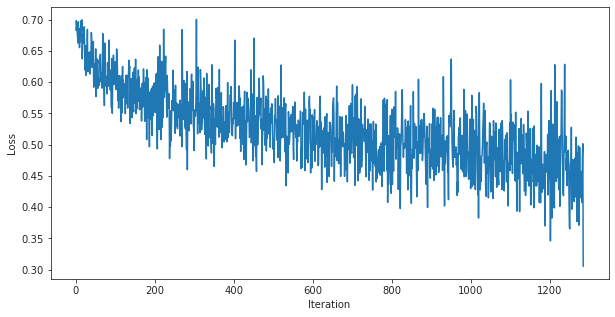

In [29]:
transform = transforms.Compose([ToTensor()])
dataset = TACDatasetClassification(DATASET_ID_TRAIN, tuples_train_classification)
data_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=lambda x: x)

neural_net_scoring_pr_model = NeuralNetScoringPRModel(D_in, H).cuda()

criterion = nn.BCELoss()
optimizer = optim.SGD(neural_net_scoring_pr_model.parameters(), lr=learning_rate)

loss = []

for batch in data_loader:
    L = 0.0

    for sample in batch:
        (d, s1, s2), y = transform(sample)
        
        L += criterion(neural_net_scoring_pr_model(d, s1, s2), y).div(batch_size)

        optimizer.step()

    loss.append(L.item())
    print(f'{loss[-1]:4f}')

    optimizer.zero_grad()

    L.backward()

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
plot_loss(ax, loss)
plt.show()

In [30]:
torch.save(neural_net_scoring_pr_model.state_dict(), os.path.join(MODELS_DIR, 'neural_net_scoring_pr_model.pt'))

In [31]:
# emb_dim = 768
# D_in = 2 * emb_dim
# H = 2 * D_in
# scaling_factor = 1
# learning_rate = 1e-4
# batch_size = 100

# class NeuralNetScoringPREmbModel(nn.Module):
#     def __init__(self, num_emb, emb_dim, D_in, H):
#         super(NeuralNetScoringPREmbModel, self).__init__()
#         self.emb = nn.Embedding(num_emb, emb_dim)
#         self.layer1 = nn.Linear(D_in, H)
#         self.layer2 = nn.Linear(H, 1)
#         self.sigm = nn.Sigmoid()
    
#     def score(self, d, s):
#         return sum([self.predict(d, si) for si in s]).squeeze()
    
#     def embed(self, d):
#         from_table = lambda w: self.emb(torch.tensor([w])).mean(axis=0)
#         return torch.cat(list(map(from_table, d)), axis=0)
        
#     def predict(self, d, s):
#         ds = torch.cat((d, s), axis=0)
#         z = self.layer1(ds)
#         a = F.relu(z)
#         return self.layer2(a)
    
#     def forward(self, d, s1, s2):
#         d  = self.embed(d).mean(axis=0)
#         s1 = self.embed(s1)
#         s2 = self.embed(s2)
#         return self.sigm(scaling_factor * (self.score(d, s1) - self.score(d, s2)))

In [32]:
# dataset = TACDatasetClassificationScoring(DATASET_ID_TRAIN, tuples_train_classification)
# data_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=lambda x: x)

# neural_net_scoring_pr_emb_model = NeuralNetScoringPREmbModel(dataset.num_nnz(), emb_dim, D_in, H).cuda()

# criterion = nn.BCELoss()
# optimizer = optim.Adam(neural_net_scoring_pr_emb_model.parameters(), lr=learning_rate)

# loss = []

# for batch in data_loader:
#     L = 0.0

#     for sample in batch:
#         (d, s1, s2), y = sample
        
#         L += criterion(neural_net_scoring_pr_emb_model(d, s1, s2), torch.tensor(y)).div(batch_size)

#         optimizer.step()

#     loss.append(L.item())
#     print(f'{loss[-1]:4f}')

#     optimizer.zero_grad()

#     L.backward()

# fig = plt.figure(figsize=(10,5))
# ax = fig.add_subplot(1,1,1)
# plot_loss(ax, loss)
# plt.show()

In [33]:
# torch.save(neural_net_scoring_pr_emb_model.state_dict(), os.path.join(MODELS_DIR, 'neural_net_scoring_pr_emb_model.pt'))

## Visualizations

In [34]:
# document_embs, summary_embs, indices, pyr_scores, _ = data_encoded_train
# m = np.argsort(-np.array(pyr_scores))

# x, y = np.array(pyr_scores)[m], []

# d = torch.tensor(document_embs).mean(axis=0)
# for i in np.array(indices)[m]:
#     s = torch.tensor(summary_embs[i[0]:i[1]])
#     y.append(model.score(d, s).cpu().data.numpy())

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(1,1,1)
# ax.scatter(x, y)
# ax.set_title(f'Correlation: {kendalltau(x, y)[0]:.2f}')
# ax.set_xlabel('Pyramid')
# ax.set_ylabel('NN Score')
# plt.show()

In [35]:
sinkhorn = SamplesLoss(loss='sinkhorn', p=2, blur=.05, scaling=.9)

In [36]:
def experiment_transform_sinkhorn(data, M):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs) @ M
    summary_embs = np.array(summary_embs) @ M
    metric = lambda i: sinkhorn(torch.tensor(document_embs), torch.tensor(summary_embs[i[0]:i[1]]))
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

def experiment_neural_net_sinkhorn(data, model):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    metric = lambda i: sinkhorn(model.predict(torch.tensor(document_embs)), model.predict(torch.tensor(summary_embs[i[0]:i[1]])))
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

def experiment_neural_net_scoring(data, model):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    d = torch.tensor(document_embs).mean(axis=0)
    metric = lambda i: model.score(d, torch.tensor(summary_embs[i[0]:i[1]]))
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

In [37]:
def execute(experiment):
    scores = []
    for topic_id in TOPIC_IDS[DATASET_ID_TRAIN]:
        print(topic_id)
        topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET_ID_TRAIN), topic_id, encoded=True)
        data = extract(topic)
        scores.append(experiment(data))
    return np.array(scores)

In [ ]:
print('transform_sinkhorn_reg_model')
M = np.load(os.path.join(MODELS_DIR, 'transform_sinkhorn_reg_model.npy'))
scores_transform_sinkhorn_reg_model = execute(lambda data: experiment_transform_sinkhorn(data, M))

print('transform_sinkhorn_pr_model')
M = np.load(os.path.join(MODELS_DIR, 'transform_sinkhorn_pr_model.npy'))
scores_transform_sinkhorn_pr_model = execute(lambda data: experiment_transform_sinkhorn(data, M))

print('neural_net_sinkhorn_pr_model')
neural_net_sinkhorn_pr_model = NeuralNetSinkhornPRModel(768, 768).cuda()
neural_net_sinkhorn_pr_model.load_state_dict(torch.load(os.path.join(MODELS_DIR, 'neural_net_sinkhorn_pr_model.pt')))
neural_net_sinkhorn_pr_model.eval()
scores_neural_net_sinkhorn_pr_model = np.array(execute(lambda data: experiment_neural_net_sinkhorn(data, neural_net_sinkhorn_pr_model)))

print('neural_net_scoring_pr_model')
neural_net_scoring_pr_model = NeuralNetScoringPRModel(2 * 768, 4 * 768).cuda()
neural_net_scoring_pr_model.load_state_dict(torch.load(os.path.join(MODELS_DIR, 'neural_net_scoring_pr_model.pt')))
neural_net_scoring_pr_model.eval()
scores_neural_net_scoring_pr_model = np.array(execute(lambda data: experiment_neural_net_scoring(data, neural_net_scoring_pr_model)))

transform_sinkhorn_reg_model
D0841
D0804
D0802
D0809
D0819
D0825
D0828
D0826
D0843
D0829
D0813
D0807
D0812
D0820
D0835
D0823
D0847
D0848
D0810
D0822
D0845
D0844
D0839
D0814
D0824
D0821
D0827
D0846
D0818
D0834
D0805
D0817
D0831
D0815
D0836
D0806
D0808
D0837
D0803


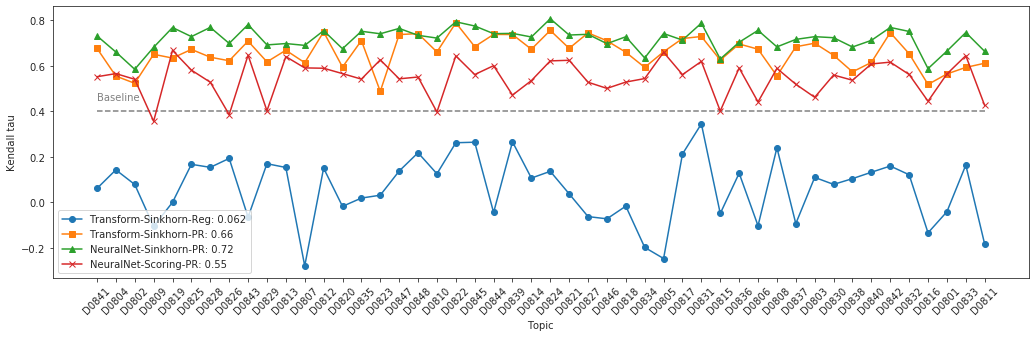

In [61]:
topics = TOPIC_IDS[DATASET_ID_TRAIN]
x = np.arange(len(topics))
fig = plt.figure(figsize=(17.5,5))
ax = fig.add_subplot(1,1,1)
ax.plot(x, -scores_transform_sinkhorn_reg_model, '-o', label=f'Transform-Sinkhorn-Reg: {np.mean(-scores_transform_sinkhorn_reg_model):.2}')
ax.plot(x, -scores_transform_sinkhorn_pr_model, '-s', label=f'Transform-Sinkhorn-PR: {np.mean(-scores_transform_sinkhorn_pr_model):.2}')
ax.plot(x, -scores_neural_net_sinkhorn_pr_model, '-^', label=f'NeuralNet-Sinkhorn-PR: {np.mean(-scores_neural_net_sinkhorn_pr_model):.2}')
ax.plot(x, scores_neural_net_scoring_pr_model, '-x', label=f'NeuralNet-Scoring-PR: {np.mean(scores_neural_net_scoring_pr_model):.2}')
plt.text(0, 0.45, 'Baseline', color='gray')
ax.hlines(0.4, x[0], x[-1], linestyle='dashed', color='gray')
ax.set_xticks(x)
ax.set_xticklabels(topics, rotation=45)
ax.set_xlabel('Topic')
ax.set_ylabel('Kendall tau')
ax.legend(loc='best')
plt.show()

In [79]:
# document_embs, summary_embs, indices, pyr_scores, _ = data_encoded_train

# m = np.argsort(-np.array(pyr_scores))

# b, w = 0, -1

# fig = plt.figure(figsize=(20,20))

# document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), len(document_embs))

# ax1 = fig.add_subplot(2,2,1)
# plot_hull(ax1, 'Summary with highest Pyramid score in original space', 'pca', document_pts, summary_pts[indices[m[b]][0]:indices[m[b]][1]])
# ax2 = fig.add_subplot(2,2,2)
# plot_hull(ax2, 'Summary with lowest Pyramid score in original space', 'pca', document_pts, summary_pts[indices[m[w]][0]:indices[m[w]][1]])

# document_pts, summary_pts = project_pca(np.concatenate((document_embs @ M, summary_embs @ M)), len(document_embs))

# ax3 = fig.add_subplot(2,2,3)
# plot_hull(ax3, 'Summary with highest Pyramid score in embedded space', 'pca', document_pts, summary_pts[indices[m[b]][0]:indices[m[b]][1]])
# ax4 = fig.add_subplot(2,2,4)
# plot_hull(ax4, 'Summary with lowest Pyramid score in embedded space', 'pca', document_pts, summary_pts[indices[m[w]][0]:indices[m[w]][1]])

# plt.show()

## Distributed computation of scores

In [1]:
import os
import time
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import kendalltau
from src.lexrank import degree_centrality_scores
import ray # Interferes with linalg.det causing semantic_spread to output different results

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

from typing import Callable

from config import *
from helpers import *
from visualization import *
from redundancy import *
from relevance import *

In [2]:
class ExperimentExecutor():
    ''' This class serves as experiment executor for the proposed metrics. '''
    
    def __init__(self, base_data_dir: str, dataset_id: str, topic_ids: list, embedding_met: str):
        ''' Constructor.
        
        The data directory will be generated as:
        
            base_data_dir + embedding_met + dataset_id
        
        :param base_data_dir: Base data directory
        :param dataset_id:    Dataset ID (TAC2008 or TAC2009)
        :param topic_ids:     Topic IDs for the particular dataset
        :param embedding_met: Embedding method
        '''
        self.dataset_id    = dataset_id
        self.embedding_met = embedding_met
        self.data_dir      = os.path.join(base_data_dir, self.embedding_met, self.dataset_id)
        self.topic_ids     = topic_ids
        
        # Define list of experiments to execute.
        # Every entry needs to contain a label - the experiment name,
        # and a procedure - the method that will be executed.
        self.experiments = [{
                'label': 'Average Pairwise Distance',
                'procedure': self.experiment_average_pairwise_distance 
            }, {
                'label': 'Semantic Volume',
                'procedure': self.experiment_semantic_volume 
            }, {
                'label': 'Semantic Spread',
                'procedure': self.experiment_semantic_spread 
            }, {
                'label': 'Word Mover Distance',
                'procedure': self.experiment_word_mover_distance 
            }, {
                'label': 'LexRank',
                'procedure': self.experiment_lex_rank 
            }]
    
    @staticmethod
    @ray.remote
    def load_and_extract_topic(data_dir: str, topic_id: str) -> tuple:
        ''' Encapsulates the loading and extracting procedure.
        
        :param data_dir: Data directory
        :param topic_id: Topic ID
        
        :return: Tuple as recieved from extract()
        '''
        topic = load_data(data_dir, topic_id, encoded=True)
        return extract(topic)
    
    @staticmethod
    @ray.remote
    def experiment_average_pairwise_distance(data: tuple) -> float:
        document_embs, summary_embs, indices, pyr_scores, summary_ids = data
        document_embs = np.array(document_embs)
        metric = lambda i: average_pairwise_distance(np.array(summary_embs[i[0]:i[1]]))
        return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

    @staticmethod
    @ray.remote
    def experiment_semantic_volume(data: tuple) -> float:
        document_embs, summary_embs, indices, pyr_scores, summary_ids = data
        document_embs = np.array(document_embs)
        document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])
        metric = lambda i: semantic_volume(np.array(summary_pts[i[0]:i[1]]))
        return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

    @staticmethod
    @ray.remote
    def experiment_semantic_spread(data: tuple) -> float:
        document_embs, summary_embs, indices, pyr_scores, summary_ids = data
        document_embs = np.array(document_embs)
        metric = lambda i: semantic_spread(np.array(summary_embs[i[0]:i[1]]))
        return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

    @staticmethod
    @ray.remote
    def experiment_word_mover_distance(data: tuple) -> float:
        document_embs, summary_embs, indices, pyr_scores, summary_ids = data
        document_embs = np.array(document_embs)
        metric = lambda i: word_mover_distance(document_embs, np.array(summary_embs[i[0]:i[1]]))
        return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

    @staticmethod
    @ray.remote
    def experiment_lex_rank(data: tuple) -> float:
        document_embs, summary_embs, indices, pyr_scores, summary_ids = data
        document_embs = np.array(document_embs)
        lr_scores = degree_centrality_scores(cdist(document_embs, document_embs, metric='cosine'))
        metric = lambda i: lex_rank(document_embs, np.array(summary_embs[i[0]:i[1]]), lr_scores)
        return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]
    
    def __execute_experiment(self, experiment: Callable) -> np.array:
        ''' Main method that executes an experiment.
        
        :param experiment: Experiment to execute
        
        :return: Array of values, one per topic
        '''
        # Pass 1: Collect the topics
        dataset = [ self.load_and_extract_topic.remote(self.data_dir, topic_id)
                       for topic_id in self.topic_ids ]
        # Pass 2: Execute the experiment
        scores  = [ experiment.remote(topic)
                       for topic in dataset ]

        return np.array(ray.get(scores))
    
    def __generate_plots(self):
        ''' Utility method for generating plots.
        
        Assumes that first three experiments are redundancy metrics.
        '''
        fig = plt.figure(figsize=(17.5,10))
        # Redundancy
        ax1 = fig.add_subplot(2,1,1)
        plot_corr_coeff(ax1, self.topic_ids, self.experiments[:3])
        ax1.set_xlabel('')
        # Relevance
        ax2 = fig.add_subplot(2,1,2)
        plot_corr_coeff(ax2, self.topic_ids, self.experiments[3:])
        fig.savefig(os.path.join(PLOTS_DIR, f'{self.dataset_id}_{self.embedding_met}.png'), dpi=fig.dpi, bbox_inches='tight')
          
    def execute(self):
        ''' Entry point.
        
        Executes each experiment one by one, prints execution times,
        results, and generates correlation coefficient plots.
        '''
        result = ''
        print(f'=== Experiment "{self.dataset_id}" - Embeddings "{self.embedding_met}" ===\n')

        for i, experiment in enumerate(self.experiments):
            label = experiment['label']
            procedure = experiment['procedure']
            
            print('Executing "{}"\n'.format(label))
            
            start = time.time()
            values = np.nan_to_num(self.__execute_experiment(procedure), nan=0)
            end = time.time()
            
            print('   *** Elapsed: {:}\n'.format(format_time(end - start)))
            
            result += '{:30} {:.4}\n'.format(label, np.mean(values))
            
            self.experiments[i]['values'] = values

        print('\n=== Results ===\n')
        print(result)
        
        self.__generate_plots()

In [3]:
BASE_DATA_DIR = f'/scratch/korunosk/data'

ex0 = ExperimentExecutor(BASE_DATA_DIR, DATASET_IDS[0], TOPIC_IDS[DATASET_IDS[0]], EMBEDDING_METS[0])
ex1 = ExperimentExecutor(BASE_DATA_DIR, DATASET_IDS[1], TOPIC_IDS[DATASET_IDS[1]], EMBEDDING_METS[0])
ex2 = ExperimentExecutor(BASE_DATA_DIR, DATASET_IDS[0], TOPIC_IDS[DATASET_IDS[0]], EMBEDDING_METS[1])
ex3 = ExperimentExecutor(BASE_DATA_DIR, DATASET_IDS[1], TOPIC_IDS[DATASET_IDS[1]], EMBEDDING_METS[1])
ex4 = ExperimentExecutor(BASE_DATA_DIR, DATASET_IDS[0], TOPIC_IDS[DATASET_IDS[0]], EMBEDDING_METS[2])
ex5 = ExperimentExecutor(BASE_DATA_DIR, DATASET_IDS[1], TOPIC_IDS[DATASET_IDS[1]], EMBEDDING_METS[2])
ex6 = ExperimentExecutor(BASE_DATA_DIR, DATASET_IDS[0], TOPIC_IDS[DATASET_IDS[0]], EMBEDDING_METS[3])
ex7 = ExperimentExecutor(BASE_DATA_DIR, DATASET_IDS[1], TOPIC_IDS[DATASET_IDS[1]], EMBEDDING_METS[3])
ex8 = ExperimentExecutor(BASE_DATA_DIR, DATASET_IDS[0], TOPIC_IDS[DATASET_IDS[0]], EMBEDDING_METS[4])
ex9 = ExperimentExecutor(BASE_DATA_DIR, DATASET_IDS[1], TOPIC_IDS[DATASET_IDS[1]], EMBEDDING_METS[4])

2020-04-21 13:09:50,431	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-04-21 13:09:50,436	INFO resource_spec.py:212 -- Starting Ray with 152.2 GiB memory available for workers and up to 18.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-21 13:09:50,804	INFO services.py:1078 -- View the Ray dashboard at localhost:8265


=== Experiment "TAC2009" - Embeddings "BERT_sent" ===

Executing "Average Pairwise Distance"

   *** Elapsed: 0:00:04

Executing "Semantic Volume"

   *** Elapsed: 0:00:05

Executing "Semantic Spread"

   *** Elapsed: 0:00:01

Executing "Word Mover Distance"

   *** Elapsed: 0:00:01

Executing "LexRank"

   *** Elapsed: 0:00:01


=== Results ===

Average Pairwise Distance      0.1198
Semantic Volume                0.1677
Semantic Spread                0.1597
Word Mover Distance            -0.04091
LexRank                        0.198



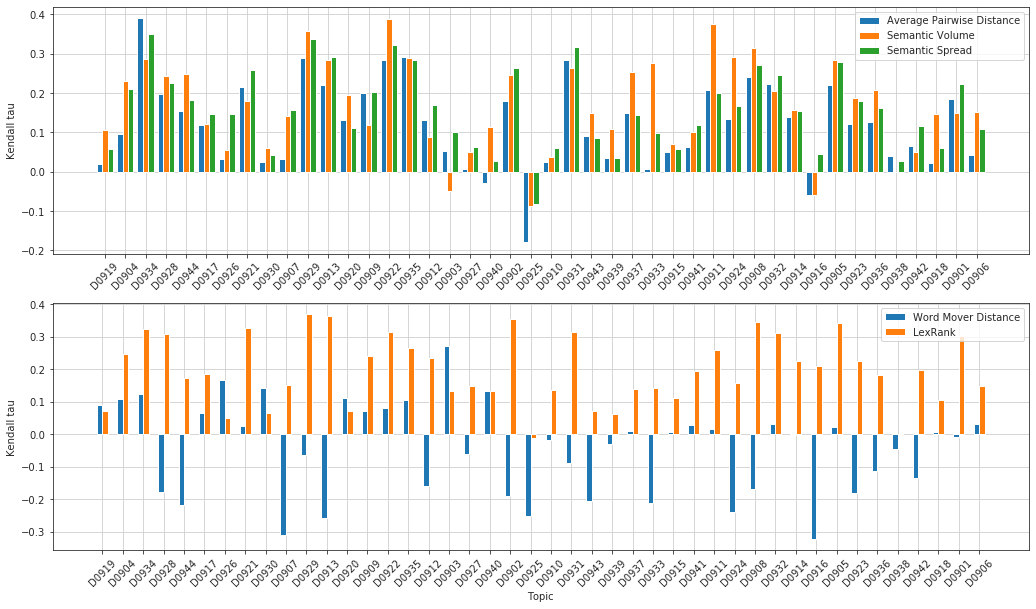

In [13]:
ray.init(num_cpus=30)
ex9.execute()
ray.shutdown()

## LSA

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.extmath import randomized_svd

from config import *
from helpers import *

def read_sentences() -> list:
    ''' Reads all the sentences from all topics and
    returns a list of them.
    
    :return: Sentences
    '''
    sentences = []

    for dataset_id in DATASET_IDS:
        print(dataset_id)
        dataset = load_data(BASE_DATA_DIR, dataset_id, encoded=False)

        for topic_id in TOPIC_IDS[dataset_id]:
            documents, _, _, _, _ = extract(dataset[topic_id])

            sentences.extend(documents)
    
    return sentences

def make_vectorizer(sentences: list) -> CountVectorizer:
    ''' Factory method for generating count vectorizer.
    The same initialization is used in several places.
    
    :param sentences: Sentences to vectorize
    
    :return: Count vectorizer
    '''
    from gensim.parsing.preprocessing import STOPWORDS
    vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,2), stop_words=list(STOPWORDS))
    vectorizer.fit(sentences)
    return vectorizer

In [2]:
BASE_DATA_DIR = '/scratch/korunosk/data'
EMBEDDINGS_DIR = os.path.join(BASE_DATA_DIR, 'LSA')

In [3]:
sentences = read_sentences()
vectorizer = make_vectorizer(sentences)
X = vectorizer.transform(sentences)

U, Sigma, VT = randomized_svd(X, n_components=300, random_state=42)

V = VT.T
bigrams = vectorizer.get_feature_names()

print(V.shape, len(bigrams))

with open(os.path.join(EMBEDDINGS_DIR, f'tac-100d.npy'), mode='wb') as fp:
    np.save(fp, V)

with open(os.path.join(EMBEDDINGS_DIR, f'tac-100d.vocab'), mode='w') as fp:
    fp.write('\n'.join(bigrams))

TAC2008
TAC2009
(186368, 300) 186368


## Export embeddings

In [2]:
# TODO
class Encoder():
    pass

In [4]:
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.extmath import randomized_svd

from gensim.parsing.preprocessing import *

from config import *
from helpers import *

In [5]:
BASE_DATA_DIR = '/scratch/korunosk/data'
EMBEDDINGS_DIR = os.path.join(BASE_DATA_DIR, 'LSA')

In [6]:
vocab, embs = load_embeddings(os.path.join(EMBEDDINGS_DIR, 'tac-100d'))
sentences = read_sentences()
vectorizer = make_vectorizer(sentences)

TAC2008
TAC2009


In [7]:
def encode_words_glove_fasttext(documents):
    filters = [
        lambda s: s.lower(),
        strip_punctuation,
        strip_multiple_whitespaces,
        remove_stopwords,
    ]
    def encode(sentence):
        words = preprocess_string(sentence, filters)
        return [ list(embs[vocab[w]]) for w in words if w in vocab ]
    document_embs = []
    for document in documents:
        sentence_embs = []
        for sentence in document:
            sentence_embs.extend(encode(sentence))
        document_embs.append(sentence_embs)
    return document_embs

def encode_bigrams_lsa(documents):
    def encode(sentence):
        X = vectorizer.transform(sentence)
        return [ list(embs[j]) for i,j in zip(*X.nonzero()) for c in range(X[i,j]) ]
    document_embs = []
    for document in documents:
        sentence_embs = []
        for sentence in document:
            sentence_embs.extend(encode([sentence]))
        document_embs.append(sentence_embs)
    return document_embs

In [8]:
for dataset_id in DATASET_IDS:
    print(dataset_id)
    dataset = load_data(BASE_DATA_DIR, dataset_id, encoded=False)
    
    for topic_id in TOPIC_IDS[dataset_id]:
        print('   {}'.format(topic_id))
        
        topic = make_topic(dataset[topic_id], encode_bigrams_lsa)
        store_data(os.path.join(EMBEDDINGS_DIR, dataset_id), topic_id, topic)

TAC2008
   D0841
   D0804
   D0802
   D0809
   D0819
   D0825
   D0828
   D0826
   D0843
   D0829
   D0813
   D0807
   D0812
   D0820
   D0835
   D0823
   D0847
   D0848
   D0810
   D0822
   D0845
   D0844
   D0839
   D0814
   D0824
   D0821
   D0827
   D0846
   D0818
   D0834
   D0805
   D0817
   D0831
   D0815
   D0836
   D0806
   D0808
   D0837
   D0803
   D0830
   D0838
   D0840
   D0842
   D0832
   D0816
   D0801
   D0833
   D0811
TAC2009
   D0919
   D0904
   D0934
   D0928
   D0944
   D0917
   D0926
   D0921
   D0930
   D0907
   D0929
   D0913
   D0920
   D0909
   D0922
   D0935
   D0912
   D0903
   D0927
   D0940
   D0902
   D0925
   D0910
   D0931
   D0943
   D0939
   D0937
   D0933
   D0915
   D0941
   D0911
   D0924
   D0908
   D0932
   D0914
   D0916
   D0905
   D0923
   D0936
   D0938
   D0942
   D0918
   D0901
   D0906
